In [1]:
!pip install -q langchain langgraph transformers accelerate

In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True).to("cuda")

/home/jungi.byun/AMA/solution/jupyter_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-07-08 10:29:39.129739: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-08 10:29:39.158858: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751938179.196249 1278916 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751938179.208405 1278916 cuda_bl

In [3]:
from typing import TypedDict, Optional, Dict, Any, Annotated, List
from langgraph.graph import StateGraph, END

class GeometryState(TypedDict):
    user_request: str
    math_concept: str = ""
    parameters: Optional[Dict[str, Any]]
    generated_code: str = ""
    comments: str = ""
    formulas: Optional[Dict[str, str]]

In [4]:
import json

def extract_shape_node(state: GeometryState) -> GeometryState:
    messages = [
        {
            "role": "system",
            "content": """
                사용자가 제공하는 수학과 관련된 문장에서 어떠한 개념을 그려주면 사용자의 이해를 도울 수 있을지, JSON 형식으로 출력하세요.
                아래 JSON의 schema에 맞게 하나만 출력하세요. 다른 설명은 절대 추가하지 마세요.
                쉼표, 따옴표, 중괄호 등 문법을 엄격히 지키세요. 문제가 있어도 반드시 완전한 JSON으로만 출력하세요.
                출력 형식 예시 (값은 사용자가 제공하는 수학과 관련된 문장에서 나온 개념과 인자를 사용해야 합니다):
                {
                    "math_concept": "원"
                    "parameters": {
                        "radius": 1
                    }
                }
                그릴 수 있는 개념과 인자 다음과 같습니다. (사용자가 제공하는 수학과 관련된 문장에서 찾은 개념의 영단어와 문장을 영어로 번역한 것과 비교하여 찾아보세요)
                    - 선분(Line Segment) 또는 반직선(Half Line) 또는 곧은선, 직선, 라인(Line, Straight Line)
                        - 인자 없음
                    - 굽은선, 곡선, 커브(Curve)
                        - 인자 없음
                    - 각 또는 각도(Angle)
                        - size(예: 60° = 60)
                    - 직각(Right Angle)
                    - 직각삼각형(Right Triangle)
                        - base
                        - height
                    - 직사각형(Rectangle)
                        - width
                        - height
                    - 정사각형(Square)
                        - length
                    - 원(Circle)
                        - radius
             """
        },
        {
            "role": "user",
            "content": state["user_request"]
        }
    ]
    
    input_ids = tokenizer.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,
        return_tensors="pt"
    )

    output = model.generate(
        input_ids.to("cuda"),
        eos_token_id=tokenizer.eos_token_id,
        max_new_tokens=128,
        do_sample=False,
    )

    decoded = tokenizer.decode(output[0], skip_special_tokens=True)
    
    # 마크다운 제거 로직
    decoded = decoded[decoded.find("```json") + len("```json"):decoded.rfind("```")]
    parsed = json.loads(decoded)

    state["math_concept"] = parsed["math_concept"]
    if parsed["parameters"] is not None:
        state["parameters"] = parsed["parameters"]
        
    return state

In [5]:
def gen_lines_prototype(svg_frame=500, stroke="black", stroke_width=2):
    """
    곧은선(선분, 반직선, 직선)을 그립니다.
    """

    x0, y0 = svg_frame // 4, svg_frame // 4
    x1, y1 = svg_frame // 4, svg_frame // 2
    x2, y2 = svg_frame // 4, (svg_frame * 3) // 4

    distance = svg_frame // 2

    svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
    <text x="{svg_frame // 2}" y="{svg_frame // 20}" font-size="{svg_frame // 20}" text-anchor="middle">곧은선</text>
    <text x="{svg_frame // 2}" y="{(svg_frame * 3) // 20}" font-size="{svg_frame // 20}" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="{x0}" cy="{y0}" r="1" stroke="{stroke}" stroke-width="{stroke_width}" fill="black" />
    <circle cx="{x0 + distance}" cy="{y0}" r="1" stroke="{stroke}" stroke-width="{stroke_width}" fill="black" />
    <line x1="{x0}" y1="{y0}" x2="{x0 + distance}" y2="{y0}" stroke="{stroke}" stroke-width="{stroke_width}" />
    <!-- 반직선 -->
    <text x="{svg_frame // 2}" y="{(svg_frame * 7) // 20}" font-size="{svg_frame // 20}" text-anchor="middle">반직선</text>
    <circle cx="{x1}" cy="{y1}" r="1" stroke="{stroke}" stroke-width="{stroke_width}" fill="black" />
    <circle cx="{x1 + distance}" cy="{y1}" r="1" stroke="{stroke}" stroke-width="{stroke_width}" fill="black" />
    <line x1="{x1}" y1="{y1}" x2="{svg_frame}" y2="{y1}" stroke="{stroke}" stroke-width="{stroke_width}" />
    <!-- 직선 -->
    <text x="{svg_frame // 2}" y="{(svg_frame * 3) // 5}" font-size="{svg_frame // 20}" text-anchor="middle">직선</text>
    <circle cx="{x2}" cy="{y2}" r="1" stroke="{stroke}" stroke-width="{stroke_width}" fill="black" />
    <circle cx="{x2 + distance}" cy="{y2}" r="1" stroke="{stroke}" stroke-width="{stroke_width}" fill="black" />
    <line x1="0" y1="{y2}" x2="{svg_frame}" y2="{y2}" stroke="{stroke}" stroke-width="{stroke_width}" />
    </svg>
    '''
    
    return svg_content

In [6]:
import math

def gen_curves_prototype(svg_frame=500, stroke="black", stroke_width=2):
    """
    굽은선(곡선)을 그립니다    
    """
    
    svg_content = f'''
    <svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
    <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">굽은선</text>
    <!-- 복잡한 S자 곡선 (두 개의 Cubic Bézier) -->
    <path d="M {svg_frame // 5},{(svg_frame * 4) // 5}
    C {svg_frame // 5},{svg_frame // 5} {(svg_frame * 4) // 5},{svg_frame // 5} {(svg_frame * 4) // 5},{svg_frame // 2}
    C {(svg_frame * 4) // 5},{(svg_frame * 4) // 5} {svg_frame // 5},{(svg_frame * 4) // 5} {svg_frame // 5},{svg_frame // 5}"
    stroke="{stroke}" fill="none" stroke-width="{stroke_width}"/>
    </svg>
    '''
    return svg_content

In [7]:
def gen_circle_prototype(variants=None, svg_frame=500, stroke="black", stroke_width=2, fill="none"):
    """
    SVG 파일로 원을 생성합니다.
    
    Parameters:
        cx (int): 원의 중심 X좌표
        cy (int): 원의 중심 Y좌표
        r (int): 반지름
        stroke (str): 선 색상
        stroke_width (int): 선 두께
        fill (str): 내부 색상
        svg_width (int): SVG 전체 너비
        svg_height (int): SVG 전체 높이
    """

    cx = svg_frame // 2
    cy = cx
    if variants["radius"] is None:
        r = svg_frame // 3
    else:
        r = min(variants["radius"] * 50, 450)
    
    svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
    <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">원</text>
    <circle cx="{cx}" cy="{cy}" r="{r}" stroke="{stroke}" stroke-width="{stroke_width}" fill="{fill}" />
    <circle cx="{cx}" cy="{cy}" r="1" stroke="{stroke}" stroke-width="{stroke_width}" fill="black" />
    <line x1="{cx}" y1="{cy}" x2="{cx + r}" y2="{cy}" stroke="{stroke}" stroke-width="{stroke_width}" />
    </svg>
    '''

    return svg_content

In [8]:
def gen_rectangle_prototype(variants=None, is_square=False, svg_frame=500, stroke="black", stroke_width=2, fill="none"):
    """
    SVG 직사각형을 그리는 코드 문자열을 생성합니다.

    Parameters:
        x (int): 왼쪽 위 꼭짓점 X좌표
        y (int): 왼쪽 위 꼭짓점 Y좌표
        width (int): 직사각형 가로 길이
        height (int): 직사각형 세로 길이
        stroke (str): 테두리 색상
        stroke_width (int): 테두리 두께
        fill (str): 내부 색상
        svg_width (int): SVG 전체 폭
        svg_height (int): SVG 전체 높이

    Returns:
        str: SVG 코드 문자열
    """

    x = svg_frame // 5
    y = svg_frame // 5
    if is_square:
        s_width = (svg_frame * 3) // 5 if variants["length"] is None else min(300, variants["length"] * 100)
        s_height = s_width
        svg_height = svg_frame
        name = "정사각형"
    else:
        s_width = (svg_frame * 3) // 5  if variants["width"] is None else min(300, variants["width"] * 50)
        s_height = width // 2 if variants["height"] is None else min(300, variants["height"] * 50)
        svg_height = min(500, ((y + s_height) * 5) // 4)
        name = "직사각형"

    # svg_width = x + width + x, svg_height = y + height + y
    svg_content = f'''<svg width="{svg_frame}" height="{svg_height}" xmlns="http://www.w3.org/2000/svg">
    <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">{name}</text>
    <rect x="{x}" y="{y}" width="{s_width}" height="{s_height}" stroke="{stroke}" stroke-width="{stroke_width}" fill="{fill}" />
    </svg>'''
    return svg_content

In [9]:
import math

def gen_angle_prototype(variants=None, svg_frame=500, stroke="black", stroke_width=2, arc_color="black"):
    """
    기준선과 기울어진 선 + 각도를 나타내는 호를 그립니다.
    """

    # 기준점
    x0, y0 = svg_frame // 4, (svg_frame * 2) // 3

    # 기준선 끝점 (수평)
    line_length = svg_frame // 2
    x1 = x0 + line_length
    y1 = y0

    # 기울어진 선 끝점
    angle_deg = 60 if variants["size"] is None else variants["size"]
    if 180 < angle_deg:
        angle_deg = angle_deg % 90
    rad = math.radians(angle_deg)
    x2 = x0 + line_length * math.cos(-rad)
    y2 = y0 + line_length * math.sin(-rad)

    # 호의 시작점 (반지름만큼 떨어진 점)
    arc_radius = svg_frame // 10
    arc_start_x = x0 + arc_radius * math.cos(-rad)
    arc_start_y = y0 + arc_radius * math.sin(-rad)

    # 호의 끝점 (반지름과 각도로 계산)
    arc_end_x = x0 + arc_radius
    arc_end_y = y0

    # SVG 내용
    svg_content = f'''<svg width="{svg_frame}" height="{(svg_frame * 3) // 4}" xmlns="http://www.w3.org/2000/svg">
    <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">각</text>
    <!-- 기준선 -->
    <line x1="{x0}" y1="{y0}" x2="{x1}" y2="{y1}" stroke="{stroke}" stroke-width="{stroke_width}" />
    <!-- 기울어진 선 -->
    <line x1="{x0}" y1="{y0}" x2="{x2}" y2="{y2}" stroke="{stroke}" stroke-width="{stroke_width}" />
    <!-- 각도 호 -->
    <path d="M {arc_start_x},{arc_start_y} A {arc_radius},{arc_radius} 0 0,1 {arc_end_x},{arc_end_y}" stroke="{arc_color}" stroke-width="{stroke_width}" fill="none"/>
    </svg>
    '''

    return svg_content

In [10]:
def gen_right_angle_prototype(svg_frame=500, stroke="black", stroke_width=2):
    """
    직각과 직각을 나타내는 보조선을 그립니다
    """
    # 기준점
    x0, y0 = svg_frame // 4, (svg_frame * 4) // 5

    # 기준선 끝점 (수평)
    line_length = (svg_frame * 2) // 3
    x1 = x0 + line_length
    y1 = y0

    # 기울어진 선 끝점
    x2 = x0
    y2 = y0 - line_length

    # 직각 보조선
    epsilon = svg_frame // 10

    h1 = x0 + epsilon
    h2 = y0 - epsilon

    # SVG 내용
    svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
    <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">직각</text>
    <!-- 기준선 -->
    <line x1="{x0}" y1="{y0}" x2="{x1}" y2="{y1}" stroke="{stroke}" stroke-width="{stroke_width}" />
    <!-- 기울어진 선 -->
    <line x1="{x0}" y1="{y0}" x2="{x2}" y2="{y2}" stroke="{stroke}" stroke-width="{stroke_width}" />
    <!-- 직각 보조선 -->
    <line x1="{h1}" y1="{y0}" x2="{h1}" y2="{h2}" stroke="{stroke}" stroke-width="{stroke_width}" />
    <line x1="{x0}" y1="{h2}" x2="{h1}" y2="{h2}" stroke="{stroke}" stroke-width="{stroke_width}" />
    </svg>
    '''
    
    return svg_content

In [11]:
def gen_right_triangle_prototype(variants=None, svg_frame=500, stroke="black", stroke_width=2):
    """
    직각삼각형을 그립니다
    """

    # 기준점
    rt_base = variants["base"] * 75 if variants["base"] is not None else (svg_frame * 2) // 3
    rt_height = variants["height"] * 75 if variants["height"] is not None else svg_frame // 2
    x0, y0 = svg_frame // 6, (svg_frame * 5) // 6
    x1, y1 = min(x0 + rt_base, (svg_frame * 5) // 6), y0
    x2, y2 = x1, max(y1 - rt_height, svg_frame // 3)

    epsilon = min(rt_base, rt_height) // 10

    h1 = x1 - epsilon
    h2 = y1 - epsilon
    
    # SVG 내용
    svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
    <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <line x1="{x0}" y1="{y0}" x2="{x1}" y2="{y1}" stroke="{stroke}" stroke-width="{stroke_width}" />
    <line x1="{x1}" y1="{y1}" x2="{x2}" y2="{y2}" stroke="{stroke}" stroke-width="{stroke_width}" />
    <line x1="{x0}" y1="{y0}" x2="{x2}" y2="{y2}" stroke="{stroke}" stroke-width="{stroke_width}" />
    <!-- 직각 보조선 -->
    <line x1="{h1}" y1="{y1}" x2="{h1}" y2="{h2}" stroke="{stroke}" stroke-width="{stroke_width}" />
    <line x1="{h1}" y1="{h2}" x2="{x1}" y2="{h2}" stroke="{stroke}" stroke-width="{stroke_width}" />
    </svg>
    '''
    return svg_content

In [12]:
def generate_code_node(state: GeometryState) -> GeometryState:
    concept = state["math_concept"]

    if concept == "원" or concept == "Circle":
        radius = state["parameters"]["radius"] if "radius" in state["parameters"].keys() else None
        code = gen_circle_prototype(state["parameters"])
    elif concept == "선분" or concept == "반직선" or concept == "직선" or concept == "곧은선" or concept == "Line":
        code = gen_lines_prototype()
    elif concept == "곡선" or concept == "굽은선" or concept == "Curve":
        code = gen_curves_prototype()
    elif concept == "각" or concept == "각도" or concept == "Angle":
        code = gen_angle_prototype(state["parameters"])
    elif concept == "직각" or concept == "Right Angle":
        code = gen_right_angle_prototype()
    elif concept == "직각삼각형" or concept == "Right Triangle":
        code = gen_right_triangle_prototype(state["parameters"])
    elif concept == "직사각형" or concept == "Rectangle" :
        code = gen_rectangle_prototype(state["parameters"])
    elif concept == "정사각형" or concept == "Square":
        code = gen_rectangle_prototype(state["parameters"], True)
    else:
        code = f"# '{concept}'을 그리는 코드는 아직 구현되지 않았습니다."

    # return {**state, "generated_code": code}
    return {"generated_code": code}

In [13]:
def generate_comments_node(state: GeometryState) -> GeometryState:
    messages = [
        {
            "role": "system",
            "content": '''
                당신은 초등학생들이 수학 문제를 풀 때 힌트를 제공하는 초등학교 선생님입니다.
                수학 개념{state["math_concept"]}에 대한 설명을 다음 내용을 포함하여 간결하게 제공해주세요.
                    - 정의
                    - 기본 성질(공식은 제외하세요)
                원주율을 \pi가 아닌 3.14로하여 제공해주세요.
             '''
        },
        {
            "role": "user",
            "content": state["math_concept"]
        }
    ]
    
    input_ids = tokenizer.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,
        return_tensors="pt"
    )

    output = model.generate(
        input_ids.to("cuda"),
        eos_token_id=tokenizer.eos_token_id,
        max_new_tokens=512,
        do_sample=False,
    )

    decoded = tokenizer.decode(output[0], skip_special_tokens=True)

    # 답변 추출 로직
    decoded = decoded[decoded.find("[|assistant|]") + len("[|assistant|]"):]

    # state["comments"] = decoded

    return {"comments": decoded}

In [14]:
def generate_formulas_node(state: GeometryState) -> GeometryState:
    supported_shape = {"직각삼각형": "Right Triangle", "직사각형": "Rectangle", "정사각형": "Square", "원": "Circle"}

    math_concept = state["math_concept"]
    if math_concept not in supported_shape.keys() and math_concept not in supported_shape.values():
        return state
        
    messages = [
        {
            "role": "system",
            "content": '''
                당신은 초등학생들이 수학 문제를 풀 때 힌트를 제공하는 초등학교 선생님입니다.
                초등학생의 이해를 돕기위해, 수학 개념{state["math_concept"]}에 대한 둘레와 넓이 공식을 JSON 형식으로 출력하세요.
                아래 JSON의 schema에 맞게 하나만 출력하세요. 다른 설명은 절대 추가하지 마세요.
                쉼표, 따옴표, 중괄호 등 문법을 엄격히 지키세요. 문제가 있어도 반드시 완전한 JSON으로만 출력하세요.
                출력 형식 예시 (값은 {state["math_concept"]}에 대한 둘레와 넓이 공식을 사용하세요.):
                {
                    "formulas": {
                        "perimeter": "2 \\times 3.14(원주율) \\times \mathrm{반지름}",
                        "area": "3.14(원주율) \\times \mathrm{반지름} \\times \mathrm{반지름}",
                    }
                }
                공식을 제공할 수 있는 개념은 다음과 같습니다. (사용자가 제공하는 수학과 관련된 문장에서 찾은 개념의 영단어와 문장을 영어로 번역한 것과 비교하여 찾아보세요)
                    - 직각삼각형(Right Triangle)
                        - 둘레: 밑변 + 높이 + 빗변
                        - 넓이: 밑변 × 높이 ÷ 2
                    - 직사각형(Rectangle)
                        - 둘레: 2 × (밑변 + 높이)
                        - 넓이: 밑변 × 높이                    
                    - 정사각형(Square)
                        - 둘레: 4 × 한 변의 길이
                        - 넓이: 한 변의 길이 × 한 변의 길이
                    - 원(Circle)
                        - 둘레: 2 × 3.14 × 반지름
                        - 넓이: 3.14 × 반지름 × 반지름
                원주율을 \pi가 아닌 3.14로하여 제공해주세요.
             '''
        },
        {
            "role": "user",
            "content": state["math_concept"]
        }
    ]
    
    input_ids = tokenizer.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,
        return_tensors="pt"
    )

    output = model.generate(
        input_ids.to("cuda"),
        eos_token_id=tokenizer.eos_token_id,
        max_new_tokens=512,
        do_sample=False,
    )

    decoded = tokenizer.decode(output[0], skip_special_tokens=True)

    # 마크다운 제거 로직
    decoded = decoded[decoded.find("```json") + len("```json"):decoded.rfind("```")]
    decoded = decoded.replace('\\', '\\\\')
    parsed = json.loads(decoded)
    
    # state["formulas"] = parsed["formulas"]

    return {"formulas": parsed["formulas"]}

In [15]:
def merge_hints(state: GeometryState) -> GeometryState:
    return state

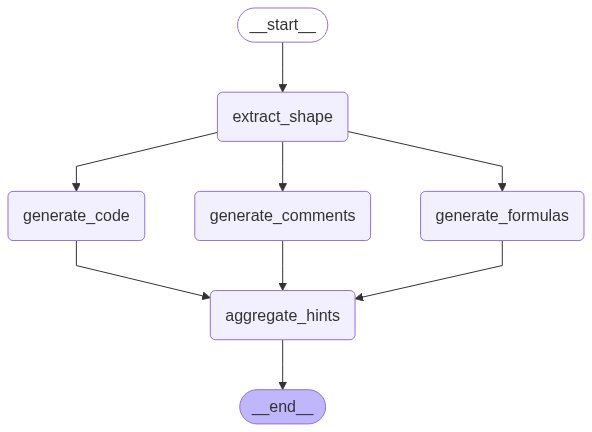

In [16]:
# LangGraph StateGraph 생성
geometry_agent = StateGraph(GeometryState)

# 노드 등록
geometry_agent.add_node("extract_shape", extract_shape_node)
geometry_agent.add_node("generate_code", generate_code_node)
geometry_agent.add_node("generate_comments", generate_comments_node)
geometry_agent.add_node("generate_formulas", generate_formulas_node)
geometry_agent.add_node("aggregate_hints", merge_hints)

# 엣지 연결
geometry_agent.set_entry_point("extract_shape")
geometry_agent.add_edge("extract_shape", "generate_code")
geometry_agent.add_edge("extract_shape", "generate_comments")
geometry_agent.add_edge("extract_shape", "generate_formulas")
geometry_agent.add_edge("generate_code", "aggregate_hints")
geometry_agent.add_edge("generate_comments", "aggregate_hints")
geometry_agent.add_edge("generate_formulas", "aggregate_hints")
geometry_agent.add_edge("aggregate_hints", END)

# 그래프 완성
app = geometry_agent.compile()
app

In [17]:
from IPython.display import SVG, display

def show_svg(svg_content):
    display(SVG(svg_content))

In [18]:
from IPython.display import Math, display

def show_formulas(formula):
    display(Math(formula))

요청한 문장: 곧은선이 뭐야?
추출된 개념: 직선
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="75" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="175" font-size="25" text-anchor="middle">반직선</text>
    <circle cx="125" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="250" x2="500" y2="250" stroke="black" stroke-width="2" />
    <!-- 직선 -->
    <text x="250" y="300" font-size="25" text-anchor="middle">직선</text>
    <circle cx="125" cy="375" r="1" stroke="black"

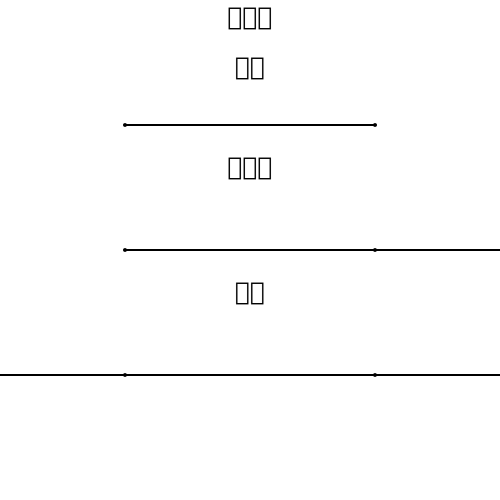

요청한 문장: 대표적인 굽은선을 그려줘
추출된 개념: 곡선
추출된 인자: {'type': '타원', 'description': '타원은 가장 대표적인 굽은선의 한 종류로, 두 초점 사이의 거리의 합이 일정한 점들의 집합으로 정의됩니다.'}

생성된 코드:
 
    <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">굽은선</text>
    <!-- 복잡한 S자 곡선 (두 개의 Cubic Bézier) -->
    <path d="M 100,400
    C 100,100 400,100 400,250
    C 400,400 100,400 100,100"
    stroke="black" fill="none" stroke-width="2"/>
    </svg>
    

생성된 설명:
 ### 곡선에 대한 설명

**정의:**
곡선은 직선이 아닌, 연속적으로 이어지는 점들의 모임으로 이루어진 도형입니다. 쉽게 말해, 직선처럼 일정한 방향으로만 움직이는 것이 아니라, 부드럽게 휘어지거나 굽어지는 형태를 가진 선을 말합니다.

**기본 성질:**
1. **연속성:** 곡선 위의 모든 점들은 부드럽게 이어져 있어, 어떤 작은 구간에서도 끊어지지 않고 이어집니다.
2. **길이:** 곡선의 길이는 그 곡선을 따라 측정한 총 거리입니다. 이 길이는 곡선의 모양에 따라 달라집니다. 예를 들어, 원의 둘레는 반지름에 따라 결정되며, 이는 곡선의 길이를 정확히 계산하는 방법 중 하나입니다.
3. **곡률:** 곡선이 얼마나 빠르게 방향을 바꾸는지를 나타내는 값입니다. 곡률이 크면 곡선이 더 급하게 굽어지고, 작으면 더 부드럽게 굽어집니다. 예를 들어, 원의 경우 모든 점에서 곡률이 일정합니다.
4. **접선:** 곡선 위의 어떤 점에서 그 점을 지나는 가장 가까운 직선을 접선이라고 합니다. 이 접

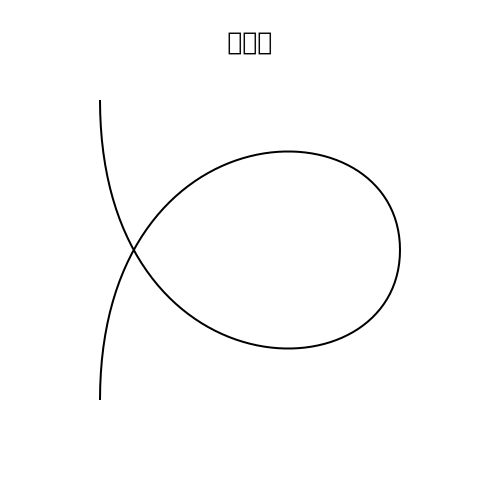

요청한 문장: 중심이 (0,0)이고 반지름이 2인 원을 그려주세요.
추출된 개념: Circle
추출된 인자: {'radius': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="100" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="250" y1="250" x2="350" y2="250" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Circle (원)

#### 정의:
원은 평면 위에서 한 점(중심)으로부터 일정한 거리(반지름)에 있는 모든 점들의 집합을 말합니다. 이 중심점을 기준으로 원 위의 모든 점들은 동일한 거리에 위치해 있습니다.

#### 기본 성질:
1. **둘레와 지름**: 원의 둘레는 지름에 π(약 3.14)를 곱한 값입니다. 즉, 둘레 = 지름 × π 입니다. 반대로 지름은 둘레를 π로 나누면 구할 수 있습니다.
   
2. **면적**: 원의 면적은 반지름의 제곱에 π를 곱한 값입니다. 공식으로 표현하면 면적 = π × 반지름2 입니다.

3. **대칭성**: 원은 중심을 기준으로 완벽하게 대칭입니다. 즉, 중심을 지나는 어떤 직선을 기준으로 원을 접어도 양쪽이 완전히 일치합니다.

4. **원주각과 호의 관계**: 원 위의 두 점을 잇는 호의 중앙각은 그 호에 대응하는 원주각의 두 배입니다. 예를 들어, 호의 중앙각이 θ라면 원주각은 θ/2가 됩니다.

이러한 성질들로 인해 원은 기하학에

<IPython.core.display.Math object>

<IPython.core.display.Math object>

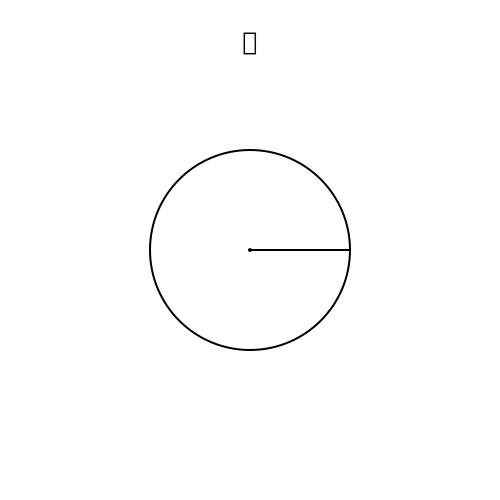

요청한 문장: 37° 각도를 그려줘
추출된 개념: 각도
추출된 인자: {'size': 37}

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
    <!-- 기준선 -->
    <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="333" x2="324.6588775118232" y2="182.54624421198793" stroke="black" stroke-width="2" />
    <!-- 각도 호 -->
    <path d="M 164.93177550236464,302.9092488423976 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>
    </svg>
    

생성된 설명:
 ### 각도에 대한 설명

**정의:**
각도는 두 직선이나 선분이 만나서 생기는 공간의 크기를 측정하는 방법입니다. 우리가 일상에서 자주 접하는 각도는 주로 도로 표지판에서 볼 수 있는 방향 지시나, 그림에서 선들이 만나는 부분을 표현할 때 사용됩니다.

**기본 성질:**
1. **직선의 각도:** 직선은 정확히 180도의 각도를 가집니다. 직선은 두 방향으로 무한히 이어지는 것처럼 보이지만, 실제로는 시작점과 끝점이 있습니다.
   
2. **직각 각도:** 직각은 90도를 의미합니다. 이는 우리가 흔히 사용하는 'L'자 모양의 모서리나 사각형의 모서리에서 볼 수 있습니다. 직각은 두 직선이 서로 수직으로 만나는 경우에 생깁니다.

3. **평행선과 각도:** 평행한 두 직선은 만나지 않기 때문에, 그들 사이의 각도는

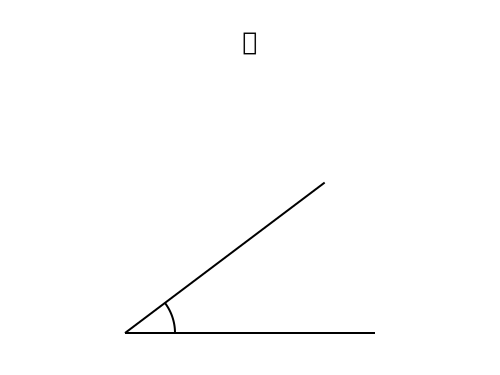

요청한 문장: 직각을 표현해줘
추출된 개념: Right Angle
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
    <!-- 기준선 -->
    <line x1="125" y1="400" x2="458" y2="400" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="400" x2="125" y2="67" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="175" y1="400" x2="175" y2="350" stroke="black" stroke-width="2" />
    <line x1="125" y1="350" x2="175" y2="350" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Angle

**정의:**
Right Angle은 기하학에서 가장 기본적인 각도 중 하나로, 정확히 90도를 이루는 각도를 말합니다. 이 각도는 직각이라고도 불리며, 직선이나 특정 도형의 모서리에서 만나는 두 변이 서로 수직으로 만나는 경우에 나타납니다.

**기본 성질:**
1. **크기:** Right Angle은 항상 정확히 90도입니다. 이는 모든 Right Angle이 동일한 크기를 가짐을 의미합니다.
2. **모양:** Right Angle은 보통 'L' 모양으로 쉽게 인식할 수 있습니다. 이 모양은 직각을 나타내는 데 자주 사용됩니다.
3. **도형과의 관계:** 직각은 사각형, 직사각형, 정사각형 등 다양한 도형의 모서리에서 발견됩니다. 특히, 직사각형이나 정사각형은 네 개

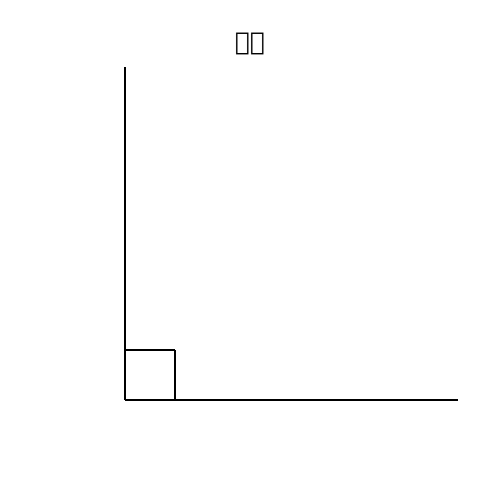

요청한 문장: 밑변이 3이고, 높이가 4인 직각삼각형 하나를 그려줘
추출된 개념: Right Triangle
추출된 인자: {'base': 3, 'height': 4}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <line x1="83" y1="416" x2="308" y2="416" stroke="black" stroke-width="2" />
    <line x1="308" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <line x1="83" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="286" y1="416" x2="286" y2="394" stroke="black" stroke-width="2" />
    <line x1="286" y1="394" x2="308" y2="394" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Triangle

**정의:**
A right triangle is a special type of triangle that has one angle which measures exactly 90 degrees (a right angle). This unique angle distinguishes it from other triangles where all angles are less than 90 degrees.

**기본 성질:**
1. **한 각이 직각:** 가장 중요한 특징은 한 꼭짓점

<IPython.core.display.Math object>

<IPython.core.display.Math object>

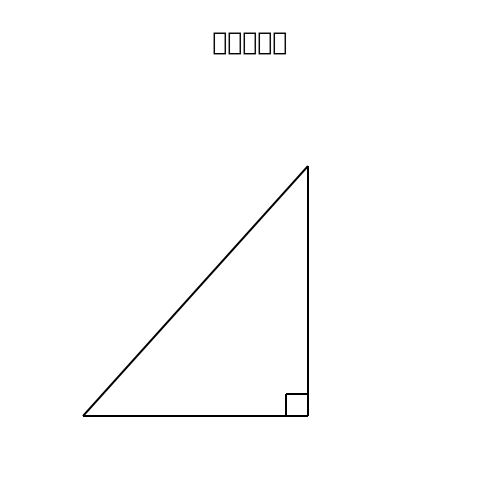

요청한 문장: 가로가 5, 세로가 3인 직사각형의 넓이
추출된 개념: Rectangle
추출된 인자: {'width': 5, 'height': 3}

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="250" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Rectangle 설명

**정의:**
사각형은 네 개의 직선으로 둘러싸인 평면 도형으로, 각 내각이 직각(90도)인 특징을 가지고 있습니다. 즉, 사각형의 네 모서리는 모두 직각을 이루며, 대변이 평행하고 길이가 같은 특성을 갖습니다.

**기본 성질:**
1. **대변의 길이가 같음:** 사각형의 두 쌍의 대변은 길이가 동일합니다. 예를 들어, 가로와 세로가 같은 길이를 가집니다.
2. **대각선이 서로 같음:** 사각형의 두 대각선은 길이가 같습니다. 즉, 사각형을 두 개의 동일한 삼각형으로 나눌 수 있습니다.
3. **내각의 합:** 사각형의 네 내각의 합은 항상 360도입니다.
4. **변의 배열:** 사각형은 여러 가지 형태로 배열될 수 있습니다. 예를 들어, 직사각형은 가로와 세로가 각각 다른 길이를 가질 수 있으며, 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 형태의 사각형입니다.

이러한 성질들로 인해 사각형은 우리 일상생활에서 매우 흔하게 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '2 × (밑변 + 높이)', 'area': '밑변 × 높이'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

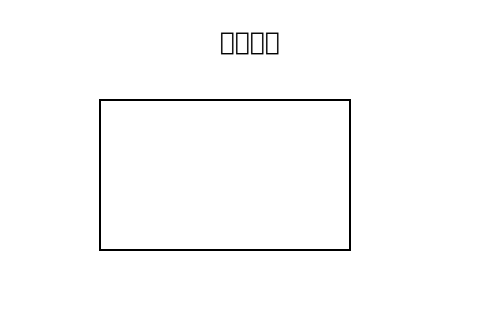

요청한 문장: 한 변의 길이가 2인 정사각형 하나를 그려줘
추출된 개념: Square
추출된 인자: {'length': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="200" height="200" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Square

**정의:**
사각형은 네 개의 변으로 이루어진 평면 도형입니다. 모든 내각이 직각(90도)이며, 반대편의 변들이 길이가 같아서 마주보는 두 변은 평행하고 길이가 동일합니다.

**기본 성질:**
1. **대변의 길이 동일:** 사각형의 마주보는 두 변은 길이가 같습니다. 예를 들어, 정사각형이나 직사각형에서는 모든 대변이 같은 길이를 가집니다.
2. **대각선의 성질:** 사각형의 대각선은 서로를 반으로 나눕니다. 즉, 대각선이 만나는 점에서 대각선을 잇는 선분들은 서로를 절반으로 나눕니다.
3. **변의 합:** 사각형의 네 변의 길이를 모두 더하면, 그 합은 사각형의 둘레를 나타냅니다. 예를 들어, 한 변의 길이가 \(a\)이고 다른 변의 길이가 \(b\)라면, 둘레는 \(a + b + a + b = 2(a + b)\)가 됩니다.
4. **정사각형의 특징:** 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 사각형입니다. 모든 대각선도 길이가 같고 서로를 직각으로 이룹니다.

이러한 성질들로 인해 사각형은 다양한 형태와 크기로 존재하며, 건축, 디자인, 그리고 일상생활에서 자주 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '4 \\times \\mathrm{한 변의 길이}', 'area': '\\m

<IPython.core.display.Math object>

<IPython.core.display.Math object>

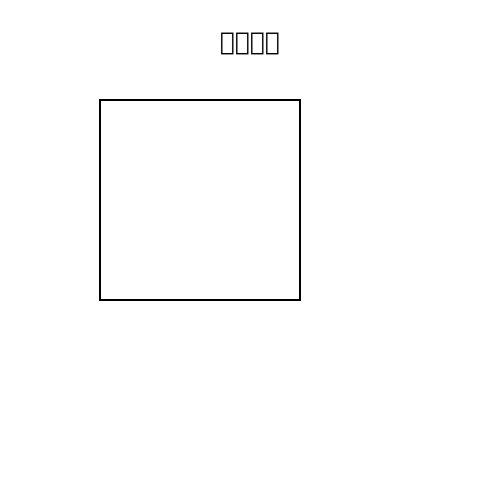

요청한 문장: 곧은선이 뭐야?
추출된 개념: 직선
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="75" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="175" font-size="25" text-anchor="middle">반직선</text>
    <circle cx="125" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="250" x2="500" y2="250" stroke="black" stroke-width="2" />
    <!-- 직선 -->
    <text x="250" y="300" font-size="25" text-anchor="middle">직선</text>
    <circle cx="125" cy="375" r="1" stroke="black"

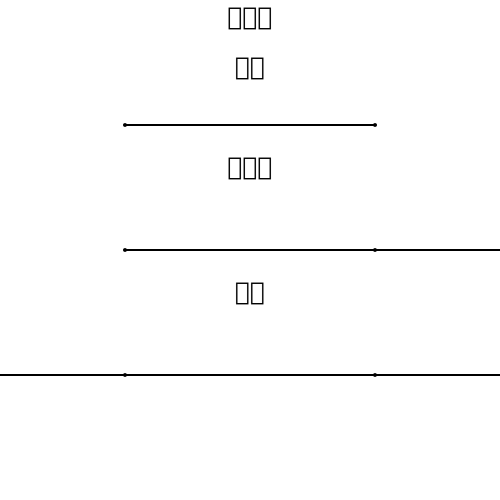

요청한 문장: 대표적인 굽은선을 그려줘
추출된 개념: 곡선
추출된 인자: {'type': '타원', 'description': '타원은 가장 대표적인 굽은선의 한 종류로, 두 초점 사이의 거리의 합이 일정한 점들의 집합으로 정의됩니다.'}

생성된 코드:
 
    <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">굽은선</text>
    <!-- 복잡한 S자 곡선 (두 개의 Cubic Bézier) -->
    <path d="M 100,400
    C 100,100 400,100 400,250
    C 400,400 100,400 100,100"
    stroke="black" fill="none" stroke-width="2"/>
    </svg>
    

생성된 설명:
 ### 곡선에 대한 설명

**정의:**
곡선은 직선이 아닌, 연속적으로 이어지는 점들의 모임으로 이루어진 도형입니다. 쉽게 말해, 직선처럼 일정한 방향으로만 움직이는 것이 아니라, 부드럽게 휘어지거나 굽어지는 형태를 가진 선을 말합니다.

**기본 성질:**
1. **연속성:** 곡선 위의 모든 점들은 부드럽게 이어져 있어, 어떤 작은 구간에서도 끊어지지 않고 이어집니다.
2. **길이:** 곡선의 길이는 그 곡선을 따라 측정한 총 거리입니다. 이 길이는 곡선의 모양에 따라 달라집니다. 예를 들어, 원의 둘레는 반지름에 따라 결정되며, 이는 곡선의 길이를 정확히 계산하는 방법 중 하나입니다.
3. **곡률:** 곡선이 얼마나 빠르게 방향을 바꾸는지를 나타내는 값입니다. 곡률이 크면 곡선이 더 급하게 굽어지고, 작으면 더 부드럽게 굽어집니다. 예를 들어, 원의 경우 모든 점에서 곡률이 일정합니다.
4. **접선:** 곡선 위의 어떤 점에서 그 점을 지나는 가장 가까운 직선을 접선이라고 합니다. 이 접

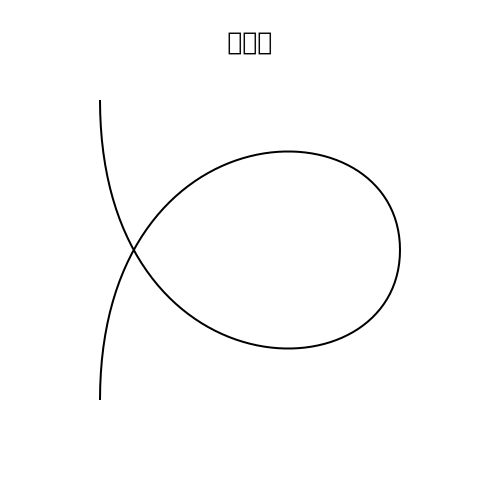

요청한 문장: 중심이 (0,0)이고 반지름이 2인 원을 그려주세요.
추출된 개념: Circle
추출된 인자: {'radius': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="100" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="250" y1="250" x2="350" y2="250" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Circle (원)

#### 정의:
원은 평면 위에서 한 점(중심)으로부터 일정한 거리(반지름)에 있는 모든 점들의 집합을 말합니다. 이 중심점을 기준으로 원 위의 모든 점들은 동일한 거리에 위치해 있습니다.

#### 기본 성질:
1. **둘레와 지름**: 원의 둘레는 지름에 π(약 3.14)를 곱한 값입니다. 즉, 둘레 = 지름 × π 입니다. 반대로 지름은 둘레를 π로 나누면 구할 수 있습니다.
   
2. **면적**: 원의 면적은 반지름의 제곱에 π를 곱한 값입니다. 공식으로 표현하면 면적 = π × 반지름2 입니다.

3. **대칭성**: 원은 중심을 기준으로 완벽하게 대칭입니다. 즉, 중심을 지나는 어떤 직선을 기준으로 원을 접어도 양쪽이 완전히 일치합니다.

4. **원주각과 호의 관계**: 원 위의 두 점을 잇는 호의 중앙각은 그 호에 대응하는 원주각의 두 배입니다. 예를 들어, 호의 중앙각이 θ라면 원주각은 θ/2가 됩니다.

이러한 성질들로 인해 원은 기하학에

<IPython.core.display.Math object>

<IPython.core.display.Math object>

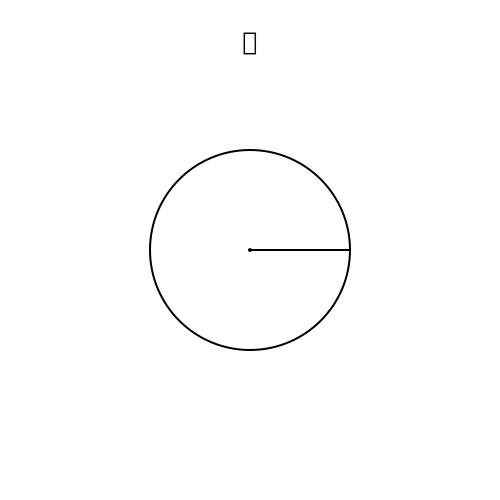

요청한 문장: 37° 각도를 그려줘
추출된 개념: 각도
추출된 인자: {'size': 37}

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
    <!-- 기준선 -->
    <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="333" x2="324.6588775118232" y2="182.54624421198793" stroke="black" stroke-width="2" />
    <!-- 각도 호 -->
    <path d="M 164.93177550236464,302.9092488423976 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>
    </svg>
    

생성된 설명:
 ### 각도에 대한 설명

**정의:**
각도는 두 직선이나 선분이 만나서 생기는 공간의 크기를 측정하는 방법입니다. 우리가 일상에서 자주 접하는 각도는 주로 도로 표지판에서 볼 수 있는 방향 지시나, 그림에서 선들이 만나는 부분을 표현할 때 사용됩니다.

**기본 성질:**
1. **직선의 각도:** 직선은 정확히 180도의 각도를 가집니다. 직선은 두 방향으로 무한히 이어지는 것처럼 보이지만, 실제로는 시작점과 끝점이 있습니다.
   
2. **직각 각도:** 직각은 90도를 의미합니다. 이는 우리가 흔히 사용하는 'L'자 모양의 모서리나 사각형의 모서리에서 볼 수 있습니다. 직각은 두 직선이 서로 수직으로 만나는 경우에 생깁니다.

3. **평행선과 각도:** 평행한 두 직선은 만나지 않기 때문에, 그들 사이의 각도는

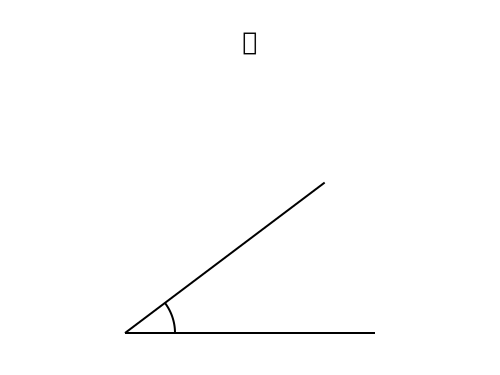

요청한 문장: 직각을 표현해줘
추출된 개념: Right Angle
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
    <!-- 기준선 -->
    <line x1="125" y1="400" x2="458" y2="400" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="400" x2="125" y2="67" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="175" y1="400" x2="175" y2="350" stroke="black" stroke-width="2" />
    <line x1="125" y1="350" x2="175" y2="350" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Angle

**정의:**
Right Angle은 기하학에서 가장 기본적인 각도 중 하나로, 정확히 90도를 이루는 각도를 말합니다. 이 각도는 직각이라고도 불리며, 직선이나 특정 도형의 모서리에서 만나는 두 변이 서로 수직으로 만나는 경우에 나타납니다.

**기본 성질:**
1. **크기:** Right Angle은 항상 정확히 90도입니다. 이는 모든 Right Angle이 동일한 크기를 가짐을 의미합니다.
2. **모양:** Right Angle은 보통 'L' 모양으로 쉽게 인식할 수 있습니다. 이 모양은 직각을 나타내는 데 자주 사용됩니다.
3. **도형과의 관계:** 직각은 사각형, 직사각형, 정사각형 등 다양한 도형의 모서리에서 발견됩니다. 특히, 직사각형이나 정사각형은 네 개

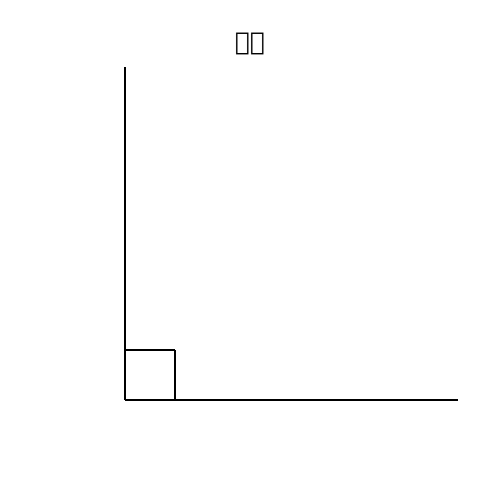

요청한 문장: 밑변이 3이고, 높이가 4인 직각삼각형 하나를 그려줘
추출된 개념: Right Triangle
추출된 인자: {'base': 3, 'height': 4}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <line x1="83" y1="416" x2="308" y2="416" stroke="black" stroke-width="2" />
    <line x1="308" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <line x1="83" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="286" y1="416" x2="286" y2="394" stroke="black" stroke-width="2" />
    <line x1="286" y1="394" x2="308" y2="394" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Triangle

**정의:**
A right triangle is a special type of triangle that has one angle which measures exactly 90 degrees (a right angle). This unique angle distinguishes it from other triangles where all angles are less than 90 degrees.

**기본 성질:**
1. **한 각이 직각:** 가장 중요한 특징은 한 꼭짓점

<IPython.core.display.Math object>

<IPython.core.display.Math object>

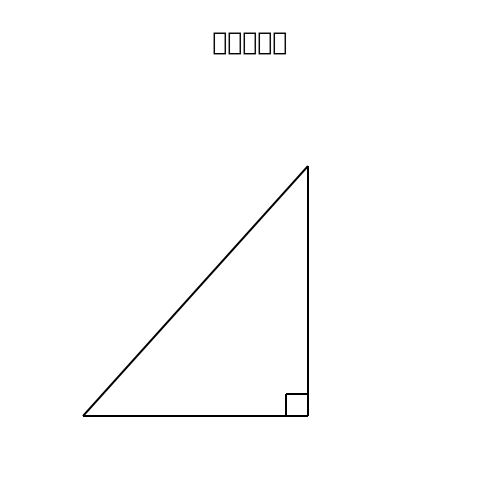

요청한 문장: 가로가 5, 세로가 3인 직사각형의 넓이
추출된 개념: Rectangle
추출된 인자: {'width': 5, 'height': 3}

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="250" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Rectangle 설명

**정의:**
사각형은 네 개의 직선으로 둘러싸인 평면 도형으로, 각 내각이 직각(90도)인 특징을 가지고 있습니다. 즉, 사각형의 네 모서리는 모두 직각을 이루며, 대변이 평행하고 길이가 같은 특성을 갖습니다.

**기본 성질:**
1. **대변의 길이가 같음:** 사각형의 두 쌍의 대변은 길이가 동일합니다. 예를 들어, 가로와 세로가 같은 길이를 가집니다.
2. **대각선이 서로 같음:** 사각형의 두 대각선은 길이가 같습니다. 즉, 사각형을 두 개의 동일한 삼각형으로 나눌 수 있습니다.
3. **내각의 합:** 사각형의 네 내각의 합은 항상 360도입니다.
4. **변의 배열:** 사각형은 여러 가지 형태로 배열될 수 있습니다. 예를 들어, 직사각형은 가로와 세로가 각각 다른 길이를 가질 수 있으며, 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 형태의 사각형입니다.

이러한 성질들로 인해 사각형은 우리 일상생활에서 매우 흔하게 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '2 × (밑변 + 높이)', 'area': '밑변 × 높이'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

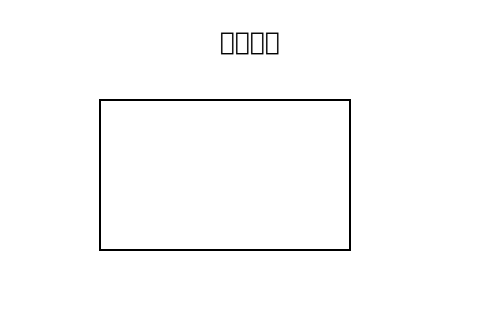

요청한 문장: 한 변의 길이가 2인 정사각형 하나를 그려줘
추출된 개념: Square
추출된 인자: {'length': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="200" height="200" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Square

**정의:**
사각형은 네 개의 변으로 이루어진 평면 도형입니다. 모든 내각이 직각(90도)이며, 반대편의 변들이 길이가 같아서 마주보는 두 변은 평행하고 길이가 동일합니다.

**기본 성질:**
1. **대변의 길이 동일:** 사각형의 마주보는 두 변은 길이가 같습니다. 예를 들어, 정사각형이나 직사각형에서는 모든 대변이 같은 길이를 가집니다.
2. **대각선의 성질:** 사각형의 대각선은 서로를 반으로 나눕니다. 즉, 대각선이 만나는 점에서 대각선을 잇는 선분들은 서로를 절반으로 나눕니다.
3. **변의 합:** 사각형의 네 변의 길이를 모두 더하면, 그 합은 사각형의 둘레를 나타냅니다. 예를 들어, 한 변의 길이가 \(a\)이고 다른 변의 길이가 \(b\)라면, 둘레는 \(a + b + a + b = 2(a + b)\)가 됩니다.
4. **정사각형의 특징:** 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 사각형입니다. 모든 대각선도 길이가 같고 서로를 직각으로 이룹니다.

이러한 성질들로 인해 사각형은 다양한 형태와 크기로 존재하며, 건축, 디자인, 그리고 일상생활에서 자주 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '4 \\times \\mathrm{한 변의 길이}', 'area': '\\m

<IPython.core.display.Math object>

<IPython.core.display.Math object>

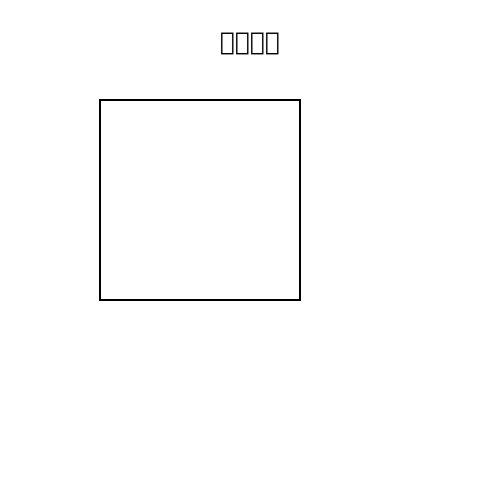

요청한 문장: 곧은선이 뭐야?
추출된 개념: 직선
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="75" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="175" font-size="25" text-anchor="middle">반직선</text>
    <circle cx="125" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="250" x2="500" y2="250" stroke="black" stroke-width="2" />
    <!-- 직선 -->
    <text x="250" y="300" font-size="25" text-anchor="middle">직선</text>
    <circle cx="125" cy="375" r="1" stroke="black"

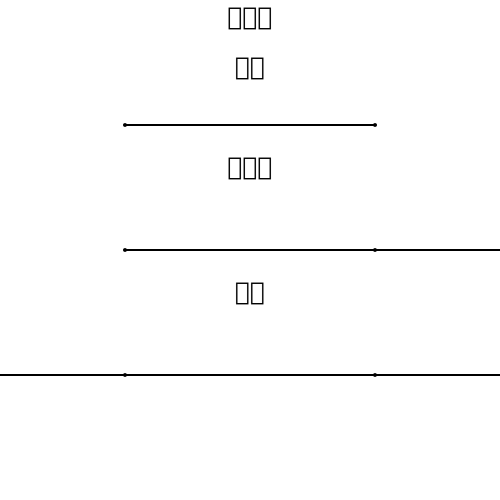

요청한 문장: 대표적인 굽은선을 그려줘
추출된 개념: 곡선
추출된 인자: {'type': '타원', 'description': '타원은 가장 대표적인 굽은선의 한 종류로, 두 초점 사이의 거리의 합이 일정한 점들의 집합으로 정의됩니다.'}

생성된 코드:
 
    <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">굽은선</text>
    <!-- 복잡한 S자 곡선 (두 개의 Cubic Bézier) -->
    <path d="M 100,400
    C 100,100 400,100 400,250
    C 400,400 100,400 100,100"
    stroke="black" fill="none" stroke-width="2"/>
    </svg>
    

생성된 설명:
 ### 곡선에 대한 설명

**정의:**
곡선은 직선이 아닌, 연속적으로 이어지는 점들의 모임으로 이루어진 도형입니다. 쉽게 말해, 직선처럼 일정한 방향으로만 움직이는 것이 아니라, 부드럽게 휘어지거나 굽어지는 형태를 가진 선을 말합니다.

**기본 성질:**
1. **연속성:** 곡선 위의 모든 점들은 부드럽게 이어져 있어, 어떤 작은 구간에서도 끊어지지 않고 이어집니다.
2. **길이:** 곡선의 길이는 그 곡선을 따라 측정한 총 거리입니다. 이 길이는 곡선의 모양에 따라 달라집니다. 예를 들어, 원의 둘레는 반지름에 따라 결정되며, 이는 곡선의 길이를 정확히 계산하는 방법 중 하나입니다.
3. **곡률:** 곡선이 얼마나 빠르게 방향을 바꾸는지를 나타내는 값입니다. 곡률이 크면 곡선이 더 급하게 굽어지고, 작으면 더 부드럽게 굽어집니다. 예를 들어, 원의 경우 모든 점에서 곡률이 일정합니다.
4. **접선:** 곡선 위의 어떤 점에서 그 점을 지나는 가장 가까운 직선을 접선이라고 합니다. 이 접

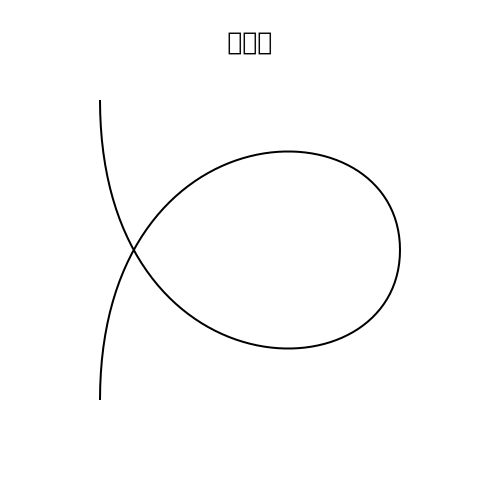

요청한 문장: 중심이 (0,0)이고 반지름이 2인 원을 그려주세요.
추출된 개념: Circle
추출된 인자: {'radius': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="100" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="250" y1="250" x2="350" y2="250" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Circle (원)

#### 정의:
원은 평면 위에서 한 점(중심)으로부터 일정한 거리(반지름)에 있는 모든 점들의 집합을 말합니다. 이 중심점을 기준으로 원 위의 모든 점들은 동일한 거리에 위치해 있습니다.

#### 기본 성질:
1. **둘레와 지름**: 원의 둘레는 지름에 π(약 3.14)를 곱한 값입니다. 즉, 둘레 = 지름 × π 입니다. 반대로 지름은 둘레를 π로 나누면 구할 수 있습니다.
   
2. **면적**: 원의 면적은 반지름의 제곱에 π를 곱한 값입니다. 공식으로 표현하면 면적 = π × 반지름2 입니다.

3. **대칭성**: 원은 중심을 기준으로 완벽하게 대칭입니다. 즉, 중심을 지나는 어떤 직선을 기준으로 원을 접어도 양쪽이 완전히 일치합니다.

4. **원주각과 호의 관계**: 원 위의 두 점을 잇는 호의 중앙각은 그 호에 대응하는 원주각의 두 배입니다. 예를 들어, 호의 중앙각이 θ라면 원주각은 θ/2가 됩니다.

이러한 성질들로 인해 원은 기하학에

<IPython.core.display.Math object>

<IPython.core.display.Math object>

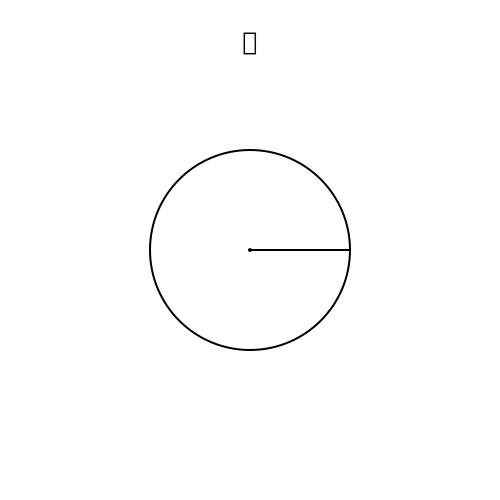

요청한 문장: 37° 각도를 그려줘
추출된 개념: 각도
추출된 인자: {'size': 37}

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
    <!-- 기준선 -->
    <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="333" x2="324.6588775118232" y2="182.54624421198793" stroke="black" stroke-width="2" />
    <!-- 각도 호 -->
    <path d="M 164.93177550236464,302.9092488423976 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>
    </svg>
    

생성된 설명:
 ### 각도에 대한 설명

**정의:**
각도는 두 직선이나 선분이 만나서 생기는 공간의 크기를 측정하는 방법입니다. 우리가 일상에서 자주 접하는 각도는 주로 도로 표지판에서 볼 수 있는 방향 지시나, 그림에서 선들이 만나는 부분을 표현할 때 사용됩니다.

**기본 성질:**
1. **직선의 각도:** 직선은 정확히 180도의 각도를 가집니다. 직선은 두 방향으로 무한히 이어지는 것처럼 보이지만, 실제로는 시작점과 끝점이 있습니다.
   
2. **직각 각도:** 직각은 90도를 의미합니다. 이는 우리가 흔히 사용하는 'L'자 모양의 모서리나 사각형의 모서리에서 볼 수 있습니다. 직각은 두 직선이 서로 수직으로 만나는 경우에 생깁니다.

3. **평행선과 각도:** 평행한 두 직선은 만나지 않기 때문에, 그들 사이의 각도는

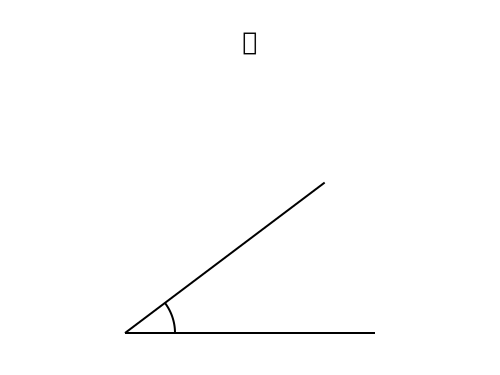

요청한 문장: 직각을 표현해줘
추출된 개념: Right Angle
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
    <!-- 기준선 -->
    <line x1="125" y1="400" x2="458" y2="400" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="400" x2="125" y2="67" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="175" y1="400" x2="175" y2="350" stroke="black" stroke-width="2" />
    <line x1="125" y1="350" x2="175" y2="350" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Angle

**정의:**
Right Angle은 기하학에서 가장 기본적인 각도 중 하나로, 정확히 90도를 이루는 각도를 말합니다. 이 각도는 직각이라고도 불리며, 직선이나 특정 도형의 모서리에서 만나는 두 변이 서로 수직으로 만나는 경우에 나타납니다.

**기본 성질:**
1. **크기:** Right Angle은 항상 정확히 90도입니다. 이는 모든 Right Angle이 동일한 크기를 가짐을 의미합니다.
2. **모양:** Right Angle은 보통 'L' 모양으로 쉽게 인식할 수 있습니다. 이 모양은 직각을 나타내는 데 자주 사용됩니다.
3. **도형과의 관계:** 직각은 사각형, 직사각형, 정사각형 등 다양한 도형의 모서리에서 발견됩니다. 특히, 직사각형이나 정사각형은 네 개

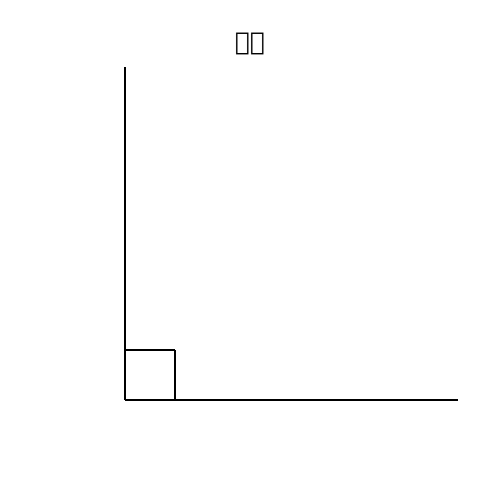

요청한 문장: 밑변이 3이고, 높이가 4인 직각삼각형 하나를 그려줘
추출된 개념: Right Triangle
추출된 인자: {'base': 3, 'height': 4}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <line x1="83" y1="416" x2="308" y2="416" stroke="black" stroke-width="2" />
    <line x1="308" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <line x1="83" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="286" y1="416" x2="286" y2="394" stroke="black" stroke-width="2" />
    <line x1="286" y1="394" x2="308" y2="394" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Triangle

**정의:**
A right triangle is a special type of triangle that has one angle which measures exactly 90 degrees (a right angle). This unique angle distinguishes it from other triangles where all angles are less than 90 degrees.

**기본 성질:**
1. **한 각이 직각:** 가장 중요한 특징은 한 꼭짓점

<IPython.core.display.Math object>

<IPython.core.display.Math object>

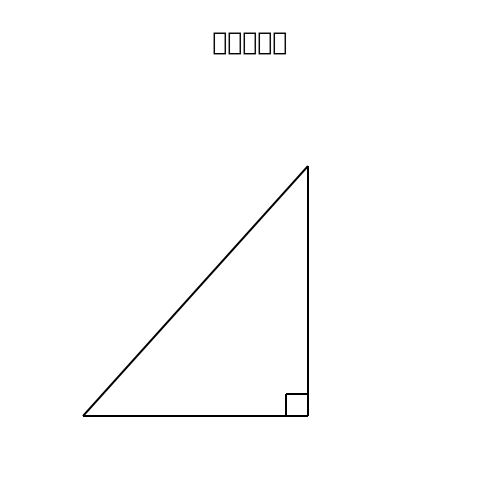

요청한 문장: 가로가 5, 세로가 3인 직사각형의 넓이
추출된 개념: Rectangle
추출된 인자: {'width': 5, 'height': 3}

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="250" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Rectangle 설명

**정의:**
사각형은 네 개의 직선으로 둘러싸인 평면 도형으로, 각 내각이 직각(90도)인 특징을 가지고 있습니다. 즉, 사각형의 네 모서리는 모두 직각을 이루며, 대변이 평행하고 길이가 같은 특성을 갖습니다.

**기본 성질:**
1. **대변의 길이가 같음:** 사각형의 두 쌍의 대변은 길이가 동일합니다. 예를 들어, 가로와 세로가 같은 길이를 가집니다.
2. **대각선이 서로 같음:** 사각형의 두 대각선은 길이가 같습니다. 즉, 사각형을 두 개의 동일한 삼각형으로 나눌 수 있습니다.
3. **내각의 합:** 사각형의 네 내각의 합은 항상 360도입니다.
4. **변의 배열:** 사각형은 여러 가지 형태로 배열될 수 있습니다. 예를 들어, 직사각형은 가로와 세로가 각각 다른 길이를 가질 수 있으며, 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 형태의 사각형입니다.

이러한 성질들로 인해 사각형은 우리 일상생활에서 매우 흔하게 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '2 × (밑변 + 높이)', 'area': '밑변 × 높이'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

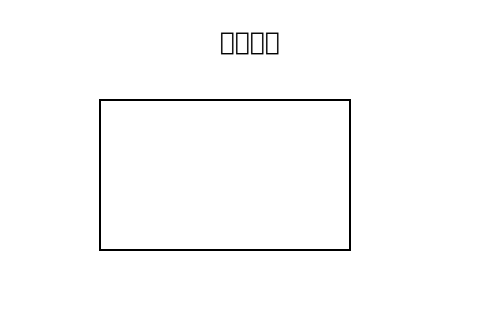

요청한 문장: 한 변의 길이가 2인 정사각형 하나를 그려줘
추출된 개념: Square
추출된 인자: {'length': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="200" height="200" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Square

**정의:**
사각형은 네 개의 변으로 이루어진 평면 도형입니다. 모든 내각이 직각(90도)이며, 반대편의 변들이 길이가 같아서 마주보는 두 변은 평행하고 길이가 동일합니다.

**기본 성질:**
1. **대변의 길이 동일:** 사각형의 마주보는 두 변은 길이가 같습니다. 예를 들어, 정사각형이나 직사각형에서는 모든 대변이 같은 길이를 가집니다.
2. **대각선의 성질:** 사각형의 대각선은 서로를 반으로 나눕니다. 즉, 대각선이 만나는 점에서 대각선을 잇는 선분들은 서로를 절반으로 나눕니다.
3. **변의 합:** 사각형의 네 변의 길이를 모두 더하면, 그 합은 사각형의 둘레를 나타냅니다. 예를 들어, 한 변의 길이가 \(a\)이고 다른 변의 길이가 \(b\)라면, 둘레는 \(a + b + a + b = 2(a + b)\)가 됩니다.
4. **정사각형의 특징:** 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 사각형입니다. 모든 대각선도 길이가 같고 서로를 직각으로 이룹니다.

이러한 성질들로 인해 사각형은 다양한 형태와 크기로 존재하며, 건축, 디자인, 그리고 일상생활에서 자주 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '4 \\times \\mathrm{한 변의 길이}', 'area': '\\m

<IPython.core.display.Math object>

<IPython.core.display.Math object>

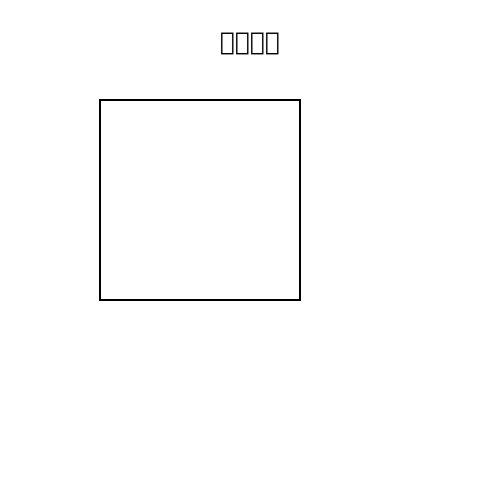

요청한 문장: 곧은선이 뭐야?
추출된 개념: 직선
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="75" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="175" font-size="25" text-anchor="middle">반직선</text>
    <circle cx="125" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="250" x2="500" y2="250" stroke="black" stroke-width="2" />
    <!-- 직선 -->
    <text x="250" y="300" font-size="25" text-anchor="middle">직선</text>
    <circle cx="125" cy="375" r="1" stroke="black"

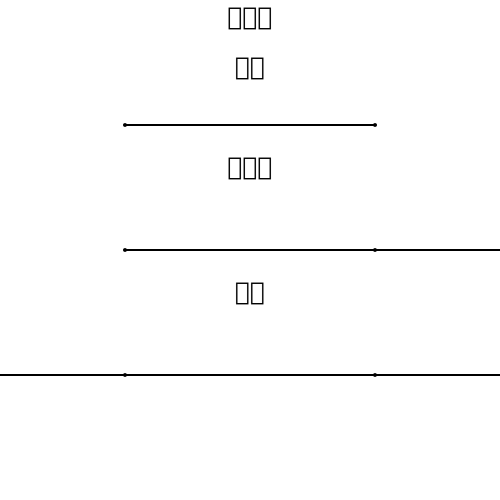

요청한 문장: 대표적인 굽은선을 그려줘
추출된 개념: 곡선
추출된 인자: {'type': '타원', 'description': '타원은 가장 대표적인 굽은선의 한 종류로, 두 초점 사이의 거리의 합이 일정한 점들의 집합으로 정의됩니다.'}

생성된 코드:
 
    <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">굽은선</text>
    <!-- 복잡한 S자 곡선 (두 개의 Cubic Bézier) -->
    <path d="M 100,400
    C 100,100 400,100 400,250
    C 400,400 100,400 100,100"
    stroke="black" fill="none" stroke-width="2"/>
    </svg>
    

생성된 설명:
 ### 곡선에 대한 설명

**정의:**
곡선은 직선이 아닌, 연속적으로 이어지는 점들의 모임으로 이루어진 도형입니다. 쉽게 말해, 직선처럼 일정한 방향으로만 움직이는 것이 아니라, 부드럽게 휘어지거나 굽어지는 형태를 가진 선을 말합니다.

**기본 성질:**
1. **연속성:** 곡선 위의 모든 점들은 부드럽게 이어져 있어, 어떤 작은 구간에서도 끊어지지 않고 이어집니다.
2. **길이:** 곡선의 길이는 그 곡선을 따라 측정한 총 거리입니다. 이 길이는 곡선의 모양에 따라 달라집니다. 예를 들어, 원의 둘레는 반지름에 따라 결정되며, 이는 곡선의 길이를 정확히 계산하는 방법 중 하나입니다.
3. **곡률:** 곡선이 얼마나 빠르게 방향을 바꾸는지를 나타내는 값입니다. 곡률이 크면 곡선이 더 급하게 굽어지고, 작으면 더 부드럽게 굽어집니다. 예를 들어, 원의 경우 모든 점에서 곡률이 일정합니다.
4. **접선:** 곡선 위의 어떤 점에서 그 점을 지나는 가장 가까운 직선을 접선이라고 합니다. 이 접

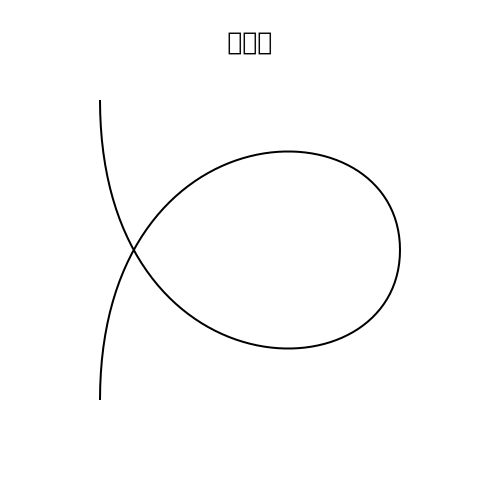

요청한 문장: 중심이 (0,0)이고 반지름이 2인 원을 그려주세요.
추출된 개념: Circle
추출된 인자: {'radius': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="100" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="250" y1="250" x2="350" y2="250" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Circle (원)

#### 정의:
원은 평면 위에서 한 점(중심)으로부터 일정한 거리(반지름)에 있는 모든 점들의 집합을 말합니다. 이 중심점을 기준으로 원 위의 모든 점들은 동일한 거리에 위치해 있습니다.

#### 기본 성질:
1. **둘레와 지름**: 원의 둘레는 지름에 π(약 3.14)를 곱한 값입니다. 즉, 둘레 = 지름 × π 입니다. 반대로 지름은 둘레를 π로 나누면 구할 수 있습니다.
   
2. **면적**: 원의 면적은 반지름의 제곱에 π를 곱한 값입니다. 공식으로 표현하면 면적 = π × 반지름2 입니다.

3. **대칭성**: 원은 중심을 기준으로 완벽하게 대칭입니다. 즉, 중심을 지나는 어떤 직선을 기준으로 원을 접어도 양쪽이 완전히 일치합니다.

4. **원주각과 호의 관계**: 원 위의 두 점을 잇는 호의 중앙각은 그 호에 대응하는 원주각의 두 배입니다. 예를 들어, 호의 중앙각이 θ라면 원주각은 θ/2가 됩니다.

이러한 성질들로 인해 원은 기하학에

<IPython.core.display.Math object>

<IPython.core.display.Math object>

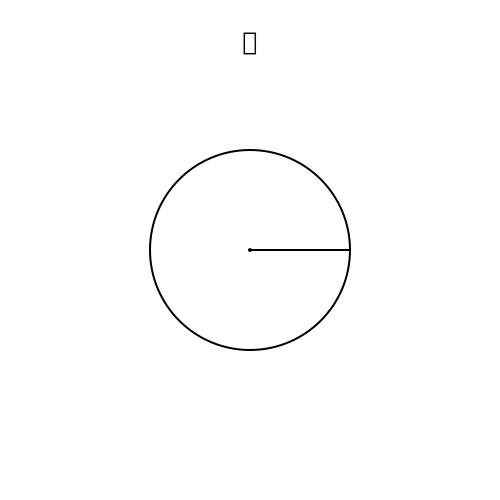

요청한 문장: 37° 각도를 그려줘
추출된 개념: 각도
추출된 인자: {'size': 37}

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
    <!-- 기준선 -->
    <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="333" x2="324.6588775118232" y2="182.54624421198793" stroke="black" stroke-width="2" />
    <!-- 각도 호 -->
    <path d="M 164.93177550236464,302.9092488423976 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>
    </svg>
    

생성된 설명:
 ### 각도에 대한 설명

**정의:**
각도는 두 직선이나 선분이 만나서 생기는 공간의 크기를 측정하는 방법입니다. 우리가 일상에서 자주 접하는 각도는 주로 도로 표지판에서 볼 수 있는 방향 지시나, 그림에서 선들이 만나는 부분을 표현할 때 사용됩니다.

**기본 성질:**
1. **직선의 각도:** 직선은 정확히 180도의 각도를 가집니다. 직선은 두 방향으로 무한히 이어지는 것처럼 보이지만, 실제로는 시작점과 끝점이 있습니다.
   
2. **직각 각도:** 직각은 90도를 의미합니다. 이는 우리가 흔히 사용하는 'L'자 모양의 모서리나 사각형의 모서리에서 볼 수 있습니다. 직각은 두 직선이 서로 수직으로 만나는 경우에 생깁니다.

3. **평행선과 각도:** 평행한 두 직선은 만나지 않기 때문에, 그들 사이의 각도는

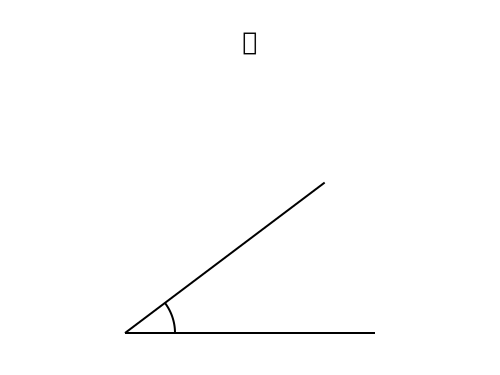

요청한 문장: 직각을 표현해줘
추출된 개념: Right Angle
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
    <!-- 기준선 -->
    <line x1="125" y1="400" x2="458" y2="400" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="400" x2="125" y2="67" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="175" y1="400" x2="175" y2="350" stroke="black" stroke-width="2" />
    <line x1="125" y1="350" x2="175" y2="350" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Angle

**정의:**
Right Angle은 기하학에서 가장 기본적인 각도 중 하나로, 정확히 90도를 이루는 각도를 말합니다. 이 각도는 직각이라고도 불리며, 직선이나 특정 도형의 모서리에서 만나는 두 변이 서로 수직으로 만나는 경우에 나타납니다.

**기본 성질:**
1. **크기:** Right Angle은 항상 정확히 90도입니다. 이는 모든 Right Angle이 동일한 크기를 가짐을 의미합니다.
2. **모양:** Right Angle은 보통 'L' 모양으로 쉽게 인식할 수 있습니다. 이 모양은 직각을 나타내는 데 자주 사용됩니다.
3. **도형과의 관계:** 직각은 사각형, 직사각형, 정사각형 등 다양한 도형의 모서리에서 발견됩니다. 특히, 직사각형이나 정사각형은 네 개

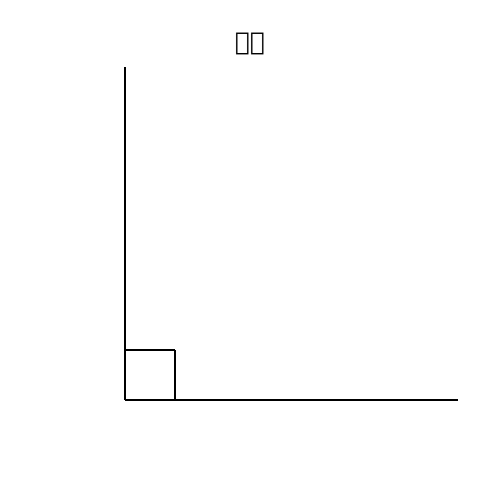

요청한 문장: 밑변이 3이고, 높이가 4인 직각삼각형 하나를 그려줘
추출된 개념: Right Triangle
추출된 인자: {'base': 3, 'height': 4}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <line x1="83" y1="416" x2="308" y2="416" stroke="black" stroke-width="2" />
    <line x1="308" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <line x1="83" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="286" y1="416" x2="286" y2="394" stroke="black" stroke-width="2" />
    <line x1="286" y1="394" x2="308" y2="394" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Triangle

**정의:**
A right triangle is a special type of triangle that has one angle which measures exactly 90 degrees (a right angle). This unique angle distinguishes it from other triangles where all angles are less than 90 degrees.

**기본 성질:**
1. **한 각이 직각:** 가장 중요한 특징은 한 꼭짓점

<IPython.core.display.Math object>

<IPython.core.display.Math object>

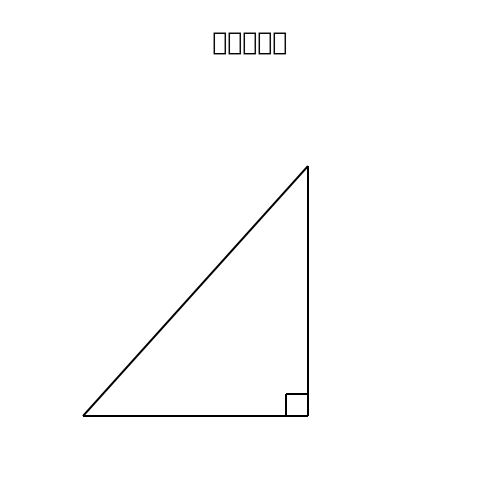

요청한 문장: 가로가 5, 세로가 3인 직사각형의 넓이
추출된 개념: Rectangle
추출된 인자: {'width': 5, 'height': 3}

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="250" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Rectangle 설명

**정의:**
사각형은 네 개의 직선으로 둘러싸인 평면 도형으로, 각 내각이 직각(90도)인 특징을 가지고 있습니다. 즉, 사각형의 네 모서리는 모두 직각을 이루며, 대변이 평행하고 길이가 같은 특성을 갖습니다.

**기본 성질:**
1. **대변의 길이가 같음:** 사각형의 두 쌍의 대변은 길이가 동일합니다. 예를 들어, 가로와 세로가 같은 길이를 가집니다.
2. **대각선이 서로 같음:** 사각형의 두 대각선은 길이가 같습니다. 즉, 사각형을 두 개의 동일한 삼각형으로 나눌 수 있습니다.
3. **내각의 합:** 사각형의 네 내각의 합은 항상 360도입니다.
4. **변의 배열:** 사각형은 여러 가지 형태로 배열될 수 있습니다. 예를 들어, 직사각형은 가로와 세로가 각각 다른 길이를 가질 수 있으며, 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 형태의 사각형입니다.

이러한 성질들로 인해 사각형은 우리 일상생활에서 매우 흔하게 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '2 × (밑변 + 높이)', 'area': '밑변 × 높이'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

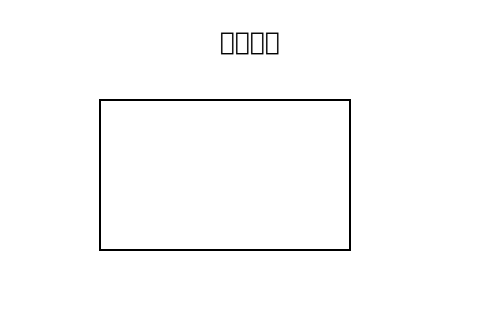

요청한 문장: 한 변의 길이가 2인 정사각형 하나를 그려줘
추출된 개념: Square
추출된 인자: {'length': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="200" height="200" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Square

**정의:**
사각형은 네 개의 변으로 이루어진 평면 도형입니다. 모든 내각이 직각(90도)이며, 반대편의 변들이 길이가 같아서 마주보는 두 변은 평행하고 길이가 동일합니다.

**기본 성질:**
1. **대변의 길이 동일:** 사각형의 마주보는 두 변은 길이가 같습니다. 예를 들어, 정사각형이나 직사각형에서는 모든 대변이 같은 길이를 가집니다.
2. **대각선의 성질:** 사각형의 대각선은 서로를 반으로 나눕니다. 즉, 대각선이 만나는 점에서 대각선을 잇는 선분들은 서로를 절반으로 나눕니다.
3. **변의 합:** 사각형의 네 변의 길이를 모두 더하면, 그 합은 사각형의 둘레를 나타냅니다. 예를 들어, 한 변의 길이가 \(a\)이고 다른 변의 길이가 \(b\)라면, 둘레는 \(a + b + a + b = 2(a + b)\)가 됩니다.
4. **정사각형의 특징:** 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 사각형입니다. 모든 대각선도 길이가 같고 서로를 직각으로 이룹니다.

이러한 성질들로 인해 사각형은 다양한 형태와 크기로 존재하며, 건축, 디자인, 그리고 일상생활에서 자주 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '4 \\times \\mathrm{한 변의 길이}', 'area': '\\m

<IPython.core.display.Math object>

<IPython.core.display.Math object>

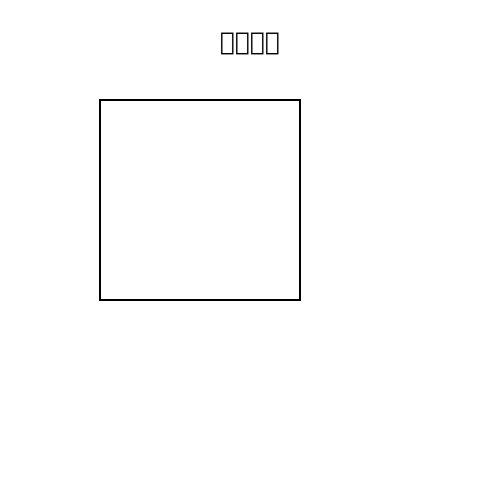

요청한 문장: 곧은선이 뭐야?
추출된 개념: 직선
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="75" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="175" font-size="25" text-anchor="middle">반직선</text>
    <circle cx="125" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="250" x2="500" y2="250" stroke="black" stroke-width="2" />
    <!-- 직선 -->
    <text x="250" y="300" font-size="25" text-anchor="middle">직선</text>
    <circle cx="125" cy="375" r="1" stroke="black"

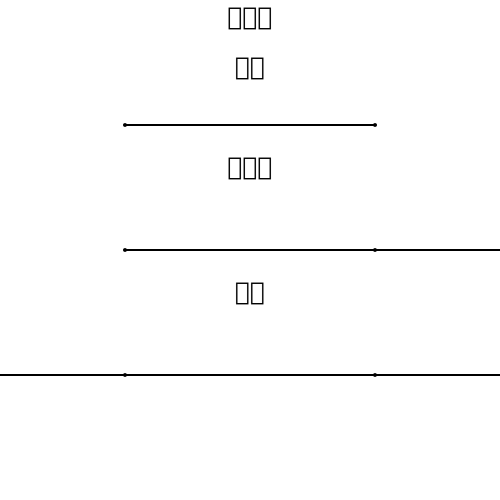

요청한 문장: 대표적인 굽은선을 그려줘
추출된 개념: 곡선
추출된 인자: {'type': '타원', 'description': '타원은 가장 대표적인 굽은선의 한 종류로, 두 초점 사이의 거리의 합이 일정한 점들의 집합으로 정의됩니다.'}

생성된 코드:
 
    <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">굽은선</text>
    <!-- 복잡한 S자 곡선 (두 개의 Cubic Bézier) -->
    <path d="M 100,400
    C 100,100 400,100 400,250
    C 400,400 100,400 100,100"
    stroke="black" fill="none" stroke-width="2"/>
    </svg>
    

생성된 설명:
 ### 곡선에 대한 설명

**정의:**
곡선은 직선이 아닌, 연속적으로 이어지는 점들의 모임으로 이루어진 도형입니다. 쉽게 말해, 직선처럼 일정한 방향으로만 움직이는 것이 아니라, 부드럽게 휘어지거나 굽어지는 형태를 가진 선을 말합니다.

**기본 성질:**
1. **연속성:** 곡선 위의 모든 점들은 부드럽게 이어져 있어, 어떤 작은 구간에서도 끊어지지 않고 이어집니다.
2. **길이:** 곡선의 길이는 그 곡선을 따라 측정한 총 거리입니다. 이 길이는 곡선의 모양에 따라 달라집니다. 예를 들어, 원의 둘레는 반지름에 따라 결정되며, 이는 곡선의 길이를 정확히 계산하는 방법 중 하나입니다.
3. **곡률:** 곡선이 얼마나 빠르게 방향을 바꾸는지를 나타내는 값입니다. 곡률이 크면 곡선이 더 급하게 굽어지고, 작으면 더 부드럽게 굽어집니다. 예를 들어, 원의 경우 모든 점에서 곡률이 일정합니다.
4. **접선:** 곡선 위의 어떤 점에서 그 점을 지나는 가장 가까운 직선을 접선이라고 합니다. 이 접

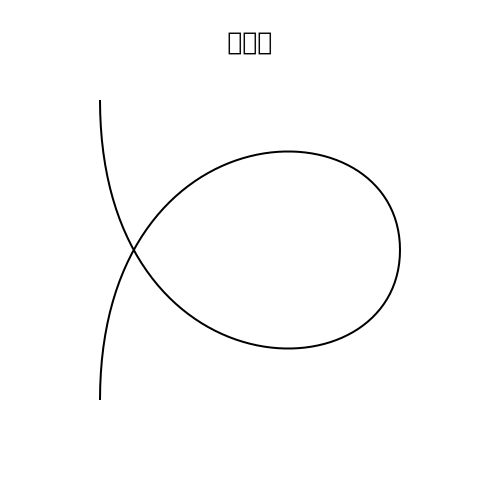

요청한 문장: 중심이 (0,0)이고 반지름이 2인 원을 그려주세요.
추출된 개념: Circle
추출된 인자: {'radius': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="100" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="250" y1="250" x2="350" y2="250" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Circle (원)

#### 정의:
원은 평면 위에서 한 점(중심)으로부터 일정한 거리(반지름)에 있는 모든 점들의 집합을 말합니다. 이 중심점을 기준으로 원 위의 모든 점들은 동일한 거리에 위치해 있습니다.

#### 기본 성질:
1. **둘레와 지름**: 원의 둘레는 지름에 π(약 3.14)를 곱한 값입니다. 즉, 둘레 = 지름 × π 입니다. 반대로 지름은 둘레를 π로 나누면 구할 수 있습니다.
   
2. **면적**: 원의 면적은 반지름의 제곱에 π를 곱한 값입니다. 공식으로 표현하면 면적 = π × 반지름2 입니다.

3. **대칭성**: 원은 중심을 기준으로 완벽하게 대칭입니다. 즉, 중심을 지나는 어떤 직선을 기준으로 원을 접어도 양쪽이 완전히 일치합니다.

4. **원주각과 호의 관계**: 원 위의 두 점을 잇는 호의 중앙각은 그 호에 대응하는 원주각의 두 배입니다. 예를 들어, 호의 중앙각이 θ라면 원주각은 θ/2가 됩니다.

이러한 성질들로 인해 원은 기하학에

<IPython.core.display.Math object>

<IPython.core.display.Math object>

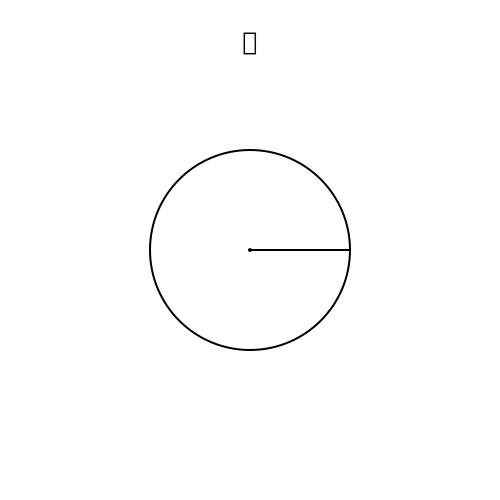

요청한 문장: 37° 각도를 그려줘
추출된 개념: 각도
추출된 인자: {'size': 37}

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
    <!-- 기준선 -->
    <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="333" x2="324.6588775118232" y2="182.54624421198793" stroke="black" stroke-width="2" />
    <!-- 각도 호 -->
    <path d="M 164.93177550236464,302.9092488423976 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>
    </svg>
    

생성된 설명:
 ### 각도에 대한 설명

**정의:**
각도는 두 직선이나 선분이 만나서 생기는 공간의 크기를 측정하는 방법입니다. 우리가 일상에서 자주 접하는 각도는 주로 도로 표지판에서 볼 수 있는 방향 지시나, 그림에서 선들이 만나는 부분을 표현할 때 사용됩니다.

**기본 성질:**
1. **직선의 각도:** 직선은 정확히 180도의 각도를 가집니다. 직선은 두 방향으로 무한히 이어지는 것처럼 보이지만, 실제로는 시작점과 끝점이 있습니다.
   
2. **직각 각도:** 직각은 90도를 의미합니다. 이는 우리가 흔히 사용하는 'L'자 모양의 모서리나 사각형의 모서리에서 볼 수 있습니다. 직각은 두 직선이 서로 수직으로 만나는 경우에 생깁니다.

3. **평행선과 각도:** 평행한 두 직선은 만나지 않기 때문에, 그들 사이의 각도는

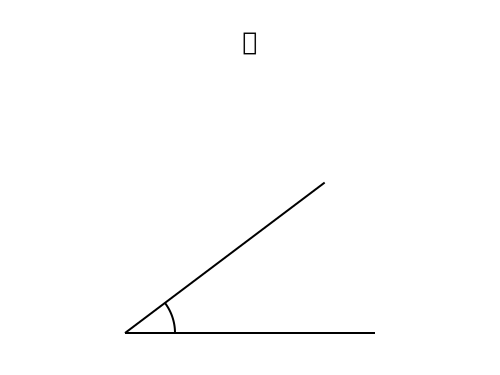

요청한 문장: 직각을 표현해줘
추출된 개념: Right Angle
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
    <!-- 기준선 -->
    <line x1="125" y1="400" x2="458" y2="400" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="400" x2="125" y2="67" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="175" y1="400" x2="175" y2="350" stroke="black" stroke-width="2" />
    <line x1="125" y1="350" x2="175" y2="350" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Angle

**정의:**
Right Angle은 기하학에서 가장 기본적인 각도 중 하나로, 정확히 90도를 이루는 각도를 말합니다. 이 각도는 직각이라고도 불리며, 직선이나 특정 도형의 모서리에서 만나는 두 변이 서로 수직으로 만나는 경우에 나타납니다.

**기본 성질:**
1. **크기:** Right Angle은 항상 정확히 90도입니다. 이는 모든 Right Angle이 동일한 크기를 가짐을 의미합니다.
2. **모양:** Right Angle은 보통 'L' 모양으로 쉽게 인식할 수 있습니다. 이 모양은 직각을 나타내는 데 자주 사용됩니다.
3. **도형과의 관계:** 직각은 사각형, 직사각형, 정사각형 등 다양한 도형의 모서리에서 발견됩니다. 특히, 직사각형이나 정사각형은 네 개

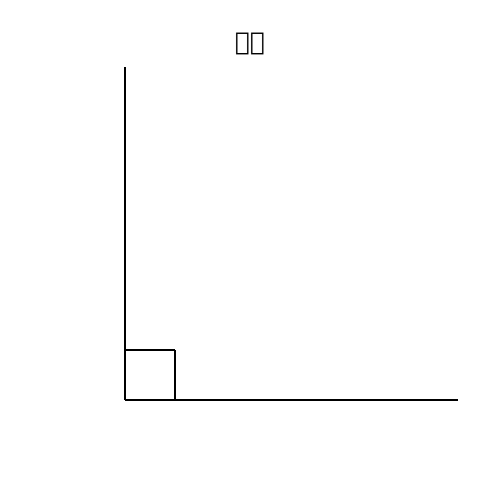

요청한 문장: 밑변이 3이고, 높이가 4인 직각삼각형 하나를 그려줘
추출된 개념: Right Triangle
추출된 인자: {'base': 3, 'height': 4}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <line x1="83" y1="416" x2="308" y2="416" stroke="black" stroke-width="2" />
    <line x1="308" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <line x1="83" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="286" y1="416" x2="286" y2="394" stroke="black" stroke-width="2" />
    <line x1="286" y1="394" x2="308" y2="394" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Triangle

**정의:**
A right triangle is a special type of triangle that has one angle which measures exactly 90 degrees (a right angle). This unique angle distinguishes it from other triangles where all angles are less than 90 degrees.

**기본 성질:**
1. **한 각이 직각:** 가장 중요한 특징은 한 꼭짓점

<IPython.core.display.Math object>

<IPython.core.display.Math object>

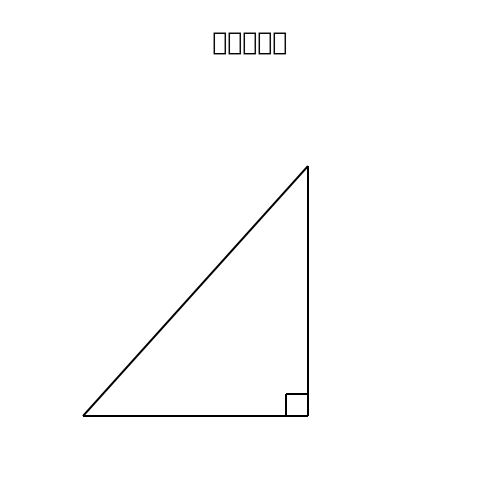

요청한 문장: 가로가 5, 세로가 3인 직사각형의 넓이
추출된 개념: Rectangle
추출된 인자: {'width': 5, 'height': 3}

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="250" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Rectangle 설명

**정의:**
사각형은 네 개의 직선으로 둘러싸인 평면 도형으로, 각 내각이 직각(90도)인 특징을 가지고 있습니다. 즉, 사각형의 네 모서리는 모두 직각을 이루며, 대변이 평행하고 길이가 같은 특성을 갖습니다.

**기본 성질:**
1. **대변의 길이가 같음:** 사각형의 두 쌍의 대변은 길이가 동일합니다. 예를 들어, 가로와 세로가 같은 길이를 가집니다.
2. **대각선이 서로 같음:** 사각형의 두 대각선은 길이가 같습니다. 즉, 사각형을 두 개의 동일한 삼각형으로 나눌 수 있습니다.
3. **내각의 합:** 사각형의 네 내각의 합은 항상 360도입니다.
4. **변의 배열:** 사각형은 여러 가지 형태로 배열될 수 있습니다. 예를 들어, 직사각형은 가로와 세로가 각각 다른 길이를 가질 수 있으며, 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 형태의 사각형입니다.

이러한 성질들로 인해 사각형은 우리 일상생활에서 매우 흔하게 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '2 × (밑변 + 높이)', 'area': '밑변 × 높이'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

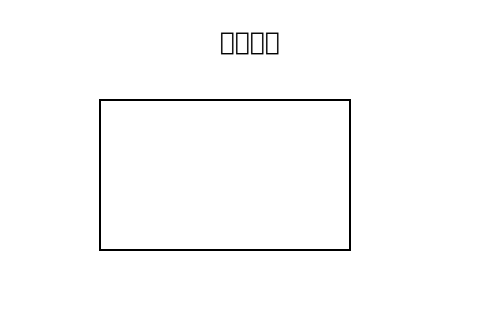

요청한 문장: 한 변의 길이가 2인 정사각형 하나를 그려줘
추출된 개념: Square
추출된 인자: {'length': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="200" height="200" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Square

**정의:**
사각형은 네 개의 변으로 이루어진 평면 도형입니다. 모든 내각이 직각(90도)이며, 반대편의 변들이 길이가 같아서 마주보는 두 변은 평행하고 길이가 동일합니다.

**기본 성질:**
1. **대변의 길이 동일:** 사각형의 마주보는 두 변은 길이가 같습니다. 예를 들어, 정사각형이나 직사각형에서는 모든 대변이 같은 길이를 가집니다.
2. **대각선의 성질:** 사각형의 대각선은 서로를 반으로 나눕니다. 즉, 대각선이 만나는 점에서 대각선을 잇는 선분들은 서로를 절반으로 나눕니다.
3. **변의 합:** 사각형의 네 변의 길이를 모두 더하면, 그 합은 사각형의 둘레를 나타냅니다. 예를 들어, 한 변의 길이가 \(a\)이고 다른 변의 길이가 \(b\)라면, 둘레는 \(a + b + a + b = 2(a + b)\)가 됩니다.
4. **정사각형의 특징:** 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 사각형입니다. 모든 대각선도 길이가 같고 서로를 직각으로 이룹니다.

이러한 성질들로 인해 사각형은 다양한 형태와 크기로 존재하며, 건축, 디자인, 그리고 일상생활에서 자주 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '4 \\times \\mathrm{한 변의 길이}', 'area': '\\m

<IPython.core.display.Math object>

<IPython.core.display.Math object>

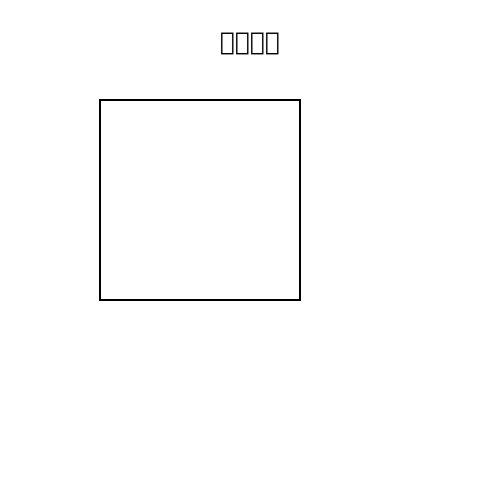

요청한 문장: 곧은선이 뭐야?
추출된 개념: 직선
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="75" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="175" font-size="25" text-anchor="middle">반직선</text>
    <circle cx="125" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="250" x2="500" y2="250" stroke="black" stroke-width="2" />
    <!-- 직선 -->
    <text x="250" y="300" font-size="25" text-anchor="middle">직선</text>
    <circle cx="125" cy="375" r="1" stroke="black"

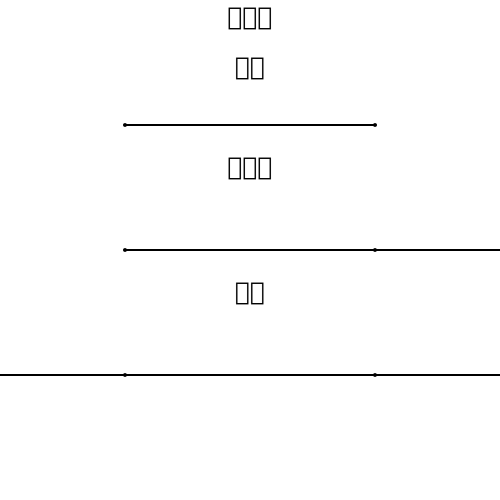

요청한 문장: 대표적인 굽은선을 그려줘
추출된 개념: 곡선
추출된 인자: {'type': '타원', 'description': '타원은 가장 대표적인 굽은선의 한 종류로, 두 초점 사이의 거리의 합이 일정한 점들의 집합으로 정의됩니다.'}

생성된 코드:
 
    <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">굽은선</text>
    <!-- 복잡한 S자 곡선 (두 개의 Cubic Bézier) -->
    <path d="M 100,400
    C 100,100 400,100 400,250
    C 400,400 100,400 100,100"
    stroke="black" fill="none" stroke-width="2"/>
    </svg>
    

생성된 설명:
 ### 곡선에 대한 설명

**정의:**
곡선은 직선이 아닌, 연속적으로 이어지는 점들의 모임으로 이루어진 도형입니다. 쉽게 말해, 직선처럼 일정한 방향으로만 움직이는 것이 아니라, 부드럽게 휘어지거나 굽어지는 형태를 가진 선을 말합니다.

**기본 성질:**
1. **연속성:** 곡선 위의 모든 점들은 부드럽게 이어져 있어, 어떤 작은 구간에서도 끊어지지 않고 이어집니다.
2. **길이:** 곡선의 길이는 그 곡선을 따라 측정한 총 거리입니다. 이 길이는 곡선의 모양에 따라 달라집니다. 예를 들어, 원의 둘레는 반지름에 따라 결정되며, 이는 곡선의 길이를 정확히 계산하는 방법 중 하나입니다.
3. **곡률:** 곡선이 얼마나 빠르게 방향을 바꾸는지를 나타내는 값입니다. 곡률이 크면 곡선이 더 급하게 굽어지고, 작으면 더 부드럽게 굽어집니다. 예를 들어, 원의 경우 모든 점에서 곡률이 일정합니다.
4. **접선:** 곡선 위의 어떤 점에서 그 점을 지나는 가장 가까운 직선을 접선이라고 합니다. 이 접

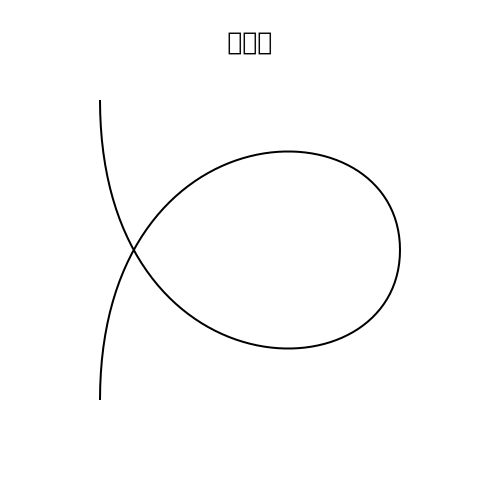

요청한 문장: 중심이 (0,0)이고 반지름이 2인 원을 그려주세요.
추출된 개념: Circle
추출된 인자: {'radius': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="100" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="250" y1="250" x2="350" y2="250" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Circle (원)

#### 정의:
원은 평면 위에서 한 점(중심)으로부터 일정한 거리(반지름)에 있는 모든 점들의 집합을 말합니다. 이 중심점을 기준으로 원 위의 모든 점들은 동일한 거리에 위치해 있습니다.

#### 기본 성질:
1. **둘레와 지름**: 원의 둘레는 지름에 π(약 3.14)를 곱한 값입니다. 즉, 둘레 = 지름 × π 입니다. 반대로 지름은 둘레를 π로 나누면 구할 수 있습니다.
   
2. **면적**: 원의 면적은 반지름의 제곱에 π를 곱한 값입니다. 공식으로 표현하면 면적 = π × 반지름2 입니다.

3. **대칭성**: 원은 중심을 기준으로 완벽하게 대칭입니다. 즉, 중심을 지나는 어떤 직선을 기준으로 원을 접어도 양쪽이 완전히 일치합니다.

4. **원주각과 호의 관계**: 원 위의 두 점을 잇는 호의 중앙각은 그 호에 대응하는 원주각의 두 배입니다. 예를 들어, 호의 중앙각이 θ라면 원주각은 θ/2가 됩니다.

이러한 성질들로 인해 원은 기하학에

<IPython.core.display.Math object>

<IPython.core.display.Math object>

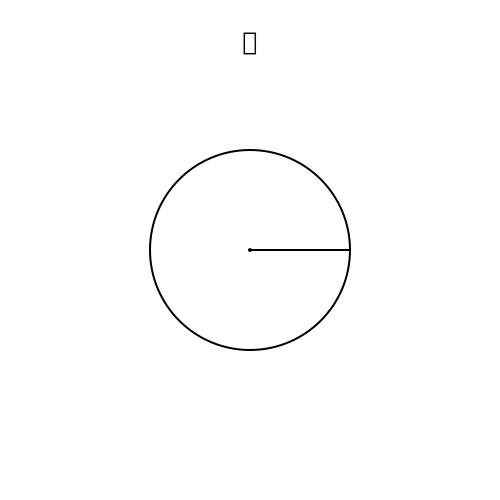

요청한 문장: 37° 각도를 그려줘
추출된 개념: 각도
추출된 인자: {'size': 37}

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
    <!-- 기준선 -->
    <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="333" x2="324.6588775118232" y2="182.54624421198793" stroke="black" stroke-width="2" />
    <!-- 각도 호 -->
    <path d="M 164.93177550236464,302.9092488423976 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>
    </svg>
    

생성된 설명:
 ### 각도에 대한 설명

**정의:**
각도는 두 직선이나 선분이 만나서 생기는 공간의 크기를 측정하는 방법입니다. 우리가 일상에서 자주 접하는 각도는 주로 도로 표지판에서 볼 수 있는 방향 지시나, 그림에서 선들이 만나는 부분을 표현할 때 사용됩니다.

**기본 성질:**
1. **직선의 각도:** 직선은 정확히 180도의 각도를 가집니다. 직선은 두 방향으로 무한히 이어지는 것처럼 보이지만, 실제로는 시작점과 끝점이 있습니다.
   
2. **직각 각도:** 직각은 90도를 의미합니다. 이는 우리가 흔히 사용하는 'L'자 모양의 모서리나 사각형의 모서리에서 볼 수 있습니다. 직각은 두 직선이 서로 수직으로 만나는 경우에 생깁니다.

3. **평행선과 각도:** 평행한 두 직선은 만나지 않기 때문에, 그들 사이의 각도는

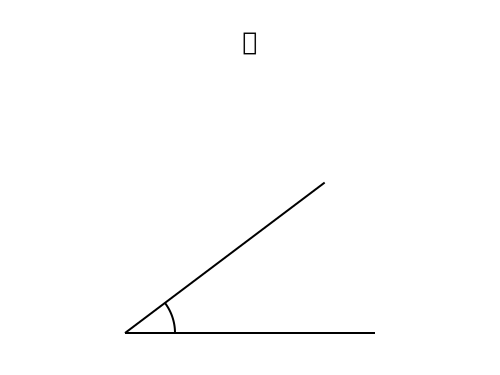

요청한 문장: 직각을 표현해줘
추출된 개념: Right Angle
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
    <!-- 기준선 -->
    <line x1="125" y1="400" x2="458" y2="400" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="400" x2="125" y2="67" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="175" y1="400" x2="175" y2="350" stroke="black" stroke-width="2" />
    <line x1="125" y1="350" x2="175" y2="350" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Angle

**정의:**
Right Angle은 기하학에서 가장 기본적인 각도 중 하나로, 정확히 90도를 이루는 각도를 말합니다. 이 각도는 직각이라고도 불리며, 직선이나 특정 도형의 모서리에서 만나는 두 변이 서로 수직으로 만나는 경우에 나타납니다.

**기본 성질:**
1. **크기:** Right Angle은 항상 정확히 90도입니다. 이는 모든 Right Angle이 동일한 크기를 가짐을 의미합니다.
2. **모양:** Right Angle은 보통 'L' 모양으로 쉽게 인식할 수 있습니다. 이 모양은 직각을 나타내는 데 자주 사용됩니다.
3. **도형과의 관계:** 직각은 사각형, 직사각형, 정사각형 등 다양한 도형의 모서리에서 발견됩니다. 특히, 직사각형이나 정사각형은 네 개

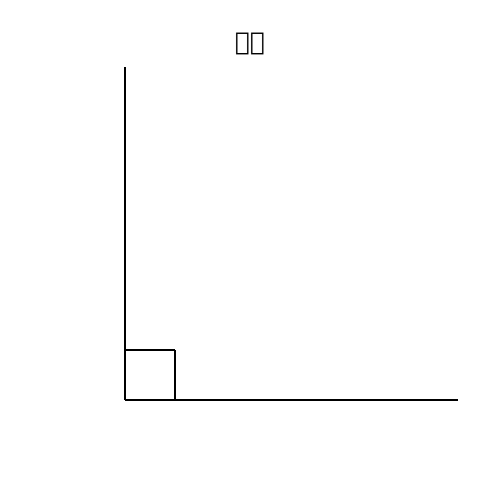

요청한 문장: 밑변이 3이고, 높이가 4인 직각삼각형 하나를 그려줘
추출된 개념: Right Triangle
추출된 인자: {'base': 3, 'height': 4}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <line x1="83" y1="416" x2="308" y2="416" stroke="black" stroke-width="2" />
    <line x1="308" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <line x1="83" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="286" y1="416" x2="286" y2="394" stroke="black" stroke-width="2" />
    <line x1="286" y1="394" x2="308" y2="394" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Triangle

**정의:**
A right triangle is a special type of triangle that has one angle which measures exactly 90 degrees (a right angle). This unique angle distinguishes it from other triangles where all angles are less than 90 degrees.

**기본 성질:**
1. **한 각이 직각:** 가장 중요한 특징은 한 꼭짓점

<IPython.core.display.Math object>

<IPython.core.display.Math object>

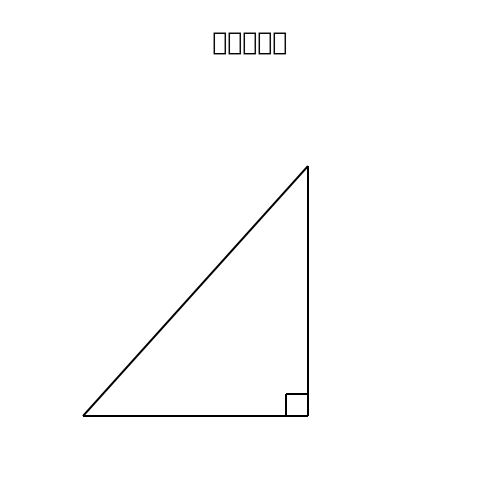

요청한 문장: 가로가 5, 세로가 3인 직사각형의 넓이
추출된 개념: Rectangle
추출된 인자: {'width': 5, 'height': 3}

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="250" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Rectangle 설명

**정의:**
사각형은 네 개의 직선으로 둘러싸인 평면 도형으로, 각 내각이 직각(90도)인 특징을 가지고 있습니다. 즉, 사각형의 네 모서리는 모두 직각을 이루며, 대변이 평행하고 길이가 같은 특성을 갖습니다.

**기본 성질:**
1. **대변의 길이가 같음:** 사각형의 두 쌍의 대변은 길이가 동일합니다. 예를 들어, 가로와 세로가 같은 길이를 가집니다.
2. **대각선이 서로 같음:** 사각형의 두 대각선은 길이가 같습니다. 즉, 사각형을 두 개의 동일한 삼각형으로 나눌 수 있습니다.
3. **내각의 합:** 사각형의 네 내각의 합은 항상 360도입니다.
4. **변의 배열:** 사각형은 여러 가지 형태로 배열될 수 있습니다. 예를 들어, 직사각형은 가로와 세로가 각각 다른 길이를 가질 수 있으며, 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 형태의 사각형입니다.

이러한 성질들로 인해 사각형은 우리 일상생활에서 매우 흔하게 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '2 × (밑변 + 높이)', 'area': '밑변 × 높이'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

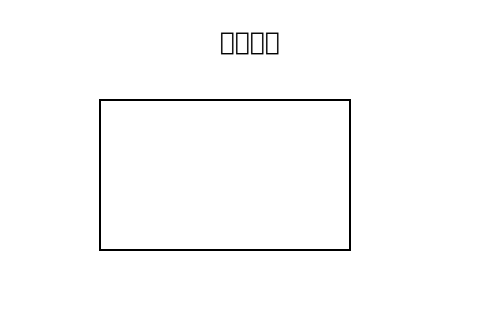

요청한 문장: 한 변의 길이가 2인 정사각형 하나를 그려줘
추출된 개념: Square
추출된 인자: {'length': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="200" height="200" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Square

**정의:**
사각형은 네 개의 변으로 이루어진 평면 도형입니다. 모든 내각이 직각(90도)이며, 반대편의 변들이 길이가 같아서 마주보는 두 변은 평행하고 길이가 동일합니다.

**기본 성질:**
1. **대변의 길이 동일:** 사각형의 마주보는 두 변은 길이가 같습니다. 예를 들어, 정사각형이나 직사각형에서는 모든 대변이 같은 길이를 가집니다.
2. **대각선의 성질:** 사각형의 대각선은 서로를 반으로 나눕니다. 즉, 대각선이 만나는 점에서 대각선을 잇는 선분들은 서로를 절반으로 나눕니다.
3. **변의 합:** 사각형의 네 변의 길이를 모두 더하면, 그 합은 사각형의 둘레를 나타냅니다. 예를 들어, 한 변의 길이가 \(a\)이고 다른 변의 길이가 \(b\)라면, 둘레는 \(a + b + a + b = 2(a + b)\)가 됩니다.
4. **정사각형의 특징:** 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 사각형입니다. 모든 대각선도 길이가 같고 서로를 직각으로 이룹니다.

이러한 성질들로 인해 사각형은 다양한 형태와 크기로 존재하며, 건축, 디자인, 그리고 일상생활에서 자주 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '4 \\times \\mathrm{한 변의 길이}', 'area': '\\m

<IPython.core.display.Math object>

<IPython.core.display.Math object>

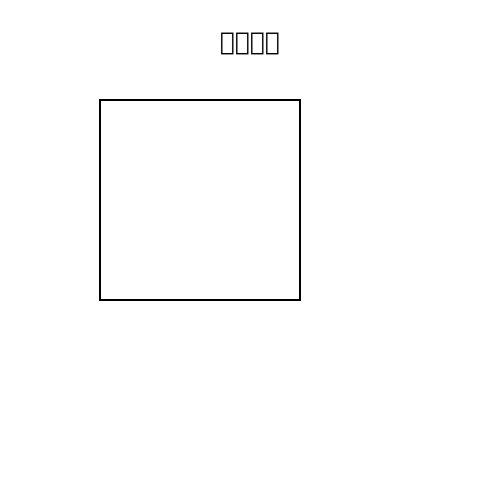

요청한 문장: 곧은선이 뭐야?
추출된 개념: 직선
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="75" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="175" font-size="25" text-anchor="middle">반직선</text>
    <circle cx="125" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="250" x2="500" y2="250" stroke="black" stroke-width="2" />
    <!-- 직선 -->
    <text x="250" y="300" font-size="25" text-anchor="middle">직선</text>
    <circle cx="125" cy="375" r="1" stroke="black"

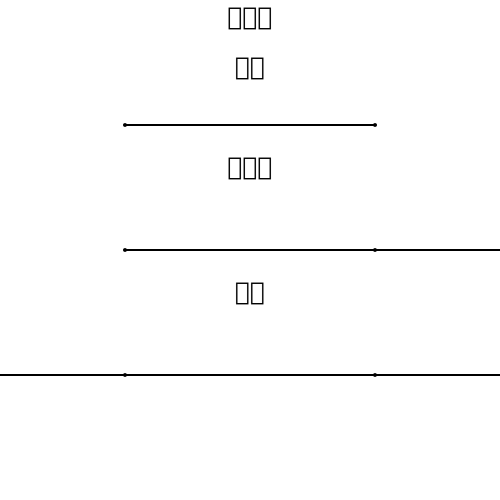

요청한 문장: 대표적인 굽은선을 그려줘
추출된 개념: 곡선
추출된 인자: {'type': '타원', 'description': '타원은 가장 대표적인 굽은선의 한 종류로, 두 초점 사이의 거리의 합이 일정한 점들의 집합으로 정의됩니다.'}

생성된 코드:
 
    <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">굽은선</text>
    <!-- 복잡한 S자 곡선 (두 개의 Cubic Bézier) -->
    <path d="M 100,400
    C 100,100 400,100 400,250
    C 400,400 100,400 100,100"
    stroke="black" fill="none" stroke-width="2"/>
    </svg>
    

생성된 설명:
 ### 곡선에 대한 설명

**정의:**
곡선은 직선이 아닌, 연속적으로 이어지는 점들의 모임으로 이루어진 도형입니다. 쉽게 말해, 직선처럼 일정한 방향으로만 움직이는 것이 아니라, 부드럽게 휘어지거나 굽어지는 형태를 가진 선을 말합니다.

**기본 성질:**
1. **연속성:** 곡선 위의 모든 점들은 부드럽게 이어져 있어, 어떤 작은 구간에서도 끊어지지 않고 이어집니다.
2. **길이:** 곡선의 길이는 그 곡선을 따라 측정한 총 거리입니다. 이 길이는 곡선의 모양에 따라 달라집니다. 예를 들어, 원의 둘레는 반지름에 따라 결정되며, 이는 곡선의 길이를 정확히 계산하는 방법 중 하나입니다.
3. **곡률:** 곡선이 얼마나 빠르게 방향을 바꾸는지를 나타내는 값입니다. 곡률이 크면 곡선이 더 급하게 굽어지고, 작으면 더 부드럽게 굽어집니다. 예를 들어, 원의 경우 모든 점에서 곡률이 일정합니다.
4. **접선:** 곡선 위의 어떤 점에서 그 점을 지나는 가장 가까운 직선을 접선이라고 합니다. 이 접

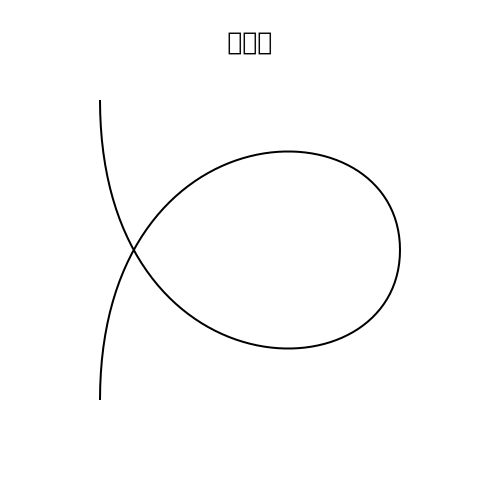

요청한 문장: 중심이 (0,0)이고 반지름이 2인 원을 그려주세요.
추출된 개념: Circle
추출된 인자: {'radius': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="100" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="250" y1="250" x2="350" y2="250" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Circle (원)

#### 정의:
원은 평면 위에서 한 점(중심)으로부터 일정한 거리(반지름)에 있는 모든 점들의 집합을 말합니다. 이 중심점을 기준으로 원 위의 모든 점들은 동일한 거리에 위치해 있습니다.

#### 기본 성질:
1. **둘레와 지름**: 원의 둘레는 지름에 π(약 3.14)를 곱한 값입니다. 즉, 둘레 = 지름 × π 입니다. 반대로 지름은 둘레를 π로 나누면 구할 수 있습니다.
   
2. **면적**: 원의 면적은 반지름의 제곱에 π를 곱한 값입니다. 공식으로 표현하면 면적 = π × 반지름2 입니다.

3. **대칭성**: 원은 중심을 기준으로 완벽하게 대칭입니다. 즉, 중심을 지나는 어떤 직선을 기준으로 원을 접어도 양쪽이 완전히 일치합니다.

4. **원주각과 호의 관계**: 원 위의 두 점을 잇는 호의 중앙각은 그 호에 대응하는 원주각의 두 배입니다. 예를 들어, 호의 중앙각이 θ라면 원주각은 θ/2가 됩니다.

이러한 성질들로 인해 원은 기하학에

<IPython.core.display.Math object>

<IPython.core.display.Math object>

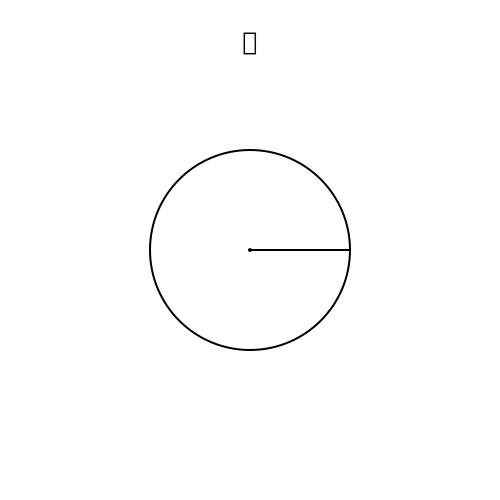

요청한 문장: 37° 각도를 그려줘
추출된 개념: 각도
추출된 인자: {'size': 37}

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
    <!-- 기준선 -->
    <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="333" x2="324.6588775118232" y2="182.54624421198793" stroke="black" stroke-width="2" />
    <!-- 각도 호 -->
    <path d="M 164.93177550236464,302.9092488423976 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>
    </svg>
    

생성된 설명:
 ### 각도에 대한 설명

**정의:**
각도는 두 직선이나 선분이 만나서 생기는 공간의 크기를 측정하는 방법입니다. 우리가 일상에서 자주 접하는 각도는 주로 도로 표지판에서 볼 수 있는 방향 지시나, 그림에서 선들이 만나는 부분을 표현할 때 사용됩니다.

**기본 성질:**
1. **직선의 각도:** 직선은 정확히 180도의 각도를 가집니다. 직선은 두 방향으로 무한히 이어지는 것처럼 보이지만, 실제로는 시작점과 끝점이 있습니다.
   
2. **직각 각도:** 직각은 90도를 의미합니다. 이는 우리가 흔히 사용하는 'L'자 모양의 모서리나 사각형의 모서리에서 볼 수 있습니다. 직각은 두 직선이 서로 수직으로 만나는 경우에 생깁니다.

3. **평행선과 각도:** 평행한 두 직선은 만나지 않기 때문에, 그들 사이의 각도는

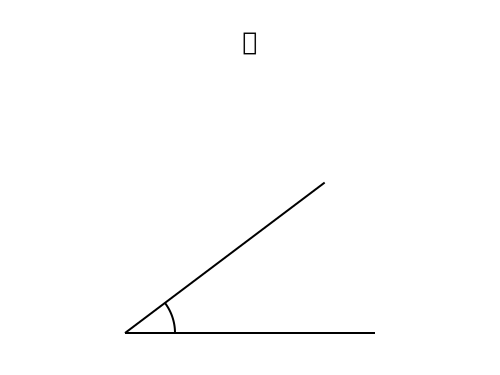

요청한 문장: 직각을 표현해줘
추출된 개념: Right Angle
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
    <!-- 기준선 -->
    <line x1="125" y1="400" x2="458" y2="400" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="400" x2="125" y2="67" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="175" y1="400" x2="175" y2="350" stroke="black" stroke-width="2" />
    <line x1="125" y1="350" x2="175" y2="350" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Angle

**정의:**
Right Angle은 기하학에서 가장 기본적인 각도 중 하나로, 정확히 90도를 이루는 각도를 말합니다. 이 각도는 직각이라고도 불리며, 직선이나 특정 도형의 모서리에서 만나는 두 변이 서로 수직으로 만나는 경우에 나타납니다.

**기본 성질:**
1. **크기:** Right Angle은 항상 정확히 90도입니다. 이는 모든 Right Angle이 동일한 크기를 가짐을 의미합니다.
2. **모양:** Right Angle은 보통 'L' 모양으로 쉽게 인식할 수 있습니다. 이 모양은 직각을 나타내는 데 자주 사용됩니다.
3. **도형과의 관계:** 직각은 사각형, 직사각형, 정사각형 등 다양한 도형의 모서리에서 발견됩니다. 특히, 직사각형이나 정사각형은 네 개

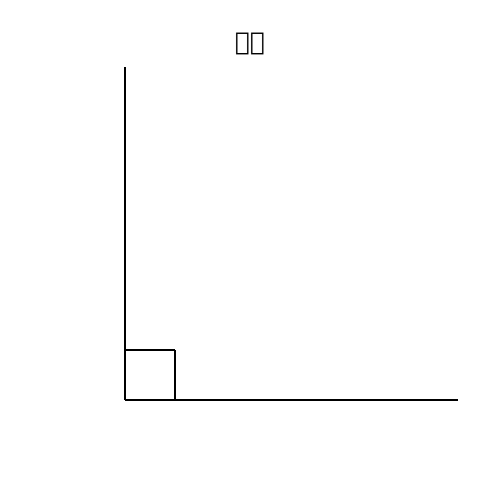

요청한 문장: 밑변이 3이고, 높이가 4인 직각삼각형 하나를 그려줘
추출된 개념: Right Triangle
추출된 인자: {'base': 3, 'height': 4}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <line x1="83" y1="416" x2="308" y2="416" stroke="black" stroke-width="2" />
    <line x1="308" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <line x1="83" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="286" y1="416" x2="286" y2="394" stroke="black" stroke-width="2" />
    <line x1="286" y1="394" x2="308" y2="394" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Triangle

**정의:**
A right triangle is a special type of triangle that has one angle which measures exactly 90 degrees (a right angle). This unique angle distinguishes it from other triangles where all angles are less than 90 degrees.

**기본 성질:**
1. **한 각이 직각:** 가장 중요한 특징은 한 꼭짓점

<IPython.core.display.Math object>

<IPython.core.display.Math object>

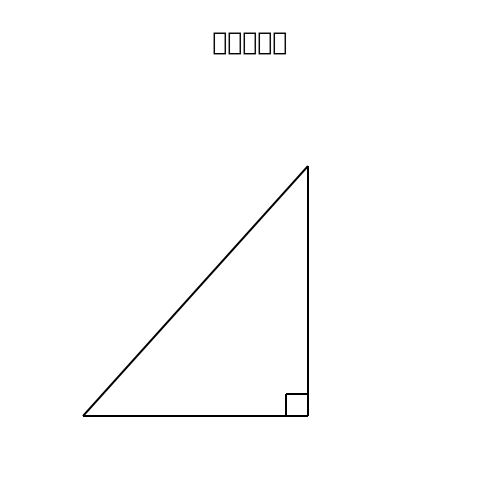

요청한 문장: 가로가 5, 세로가 3인 직사각형의 넓이
추출된 개념: Rectangle
추출된 인자: {'width': 5, 'height': 3}

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="250" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Rectangle 설명

**정의:**
사각형은 네 개의 직선으로 둘러싸인 평면 도형으로, 각 내각이 직각(90도)인 특징을 가지고 있습니다. 즉, 사각형의 네 모서리는 모두 직각을 이루며, 대변이 평행하고 길이가 같은 특성을 갖습니다.

**기본 성질:**
1. **대변의 길이가 같음:** 사각형의 두 쌍의 대변은 길이가 동일합니다. 예를 들어, 가로와 세로가 같은 길이를 가집니다.
2. **대각선이 서로 같음:** 사각형의 두 대각선은 길이가 같습니다. 즉, 사각형을 두 개의 동일한 삼각형으로 나눌 수 있습니다.
3. **내각의 합:** 사각형의 네 내각의 합은 항상 360도입니다.
4. **변의 배열:** 사각형은 여러 가지 형태로 배열될 수 있습니다. 예를 들어, 직사각형은 가로와 세로가 각각 다른 길이를 가질 수 있으며, 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 형태의 사각형입니다.

이러한 성질들로 인해 사각형은 우리 일상생활에서 매우 흔하게 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '2 × (밑변 + 높이)', 'area': '밑변 × 높이'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

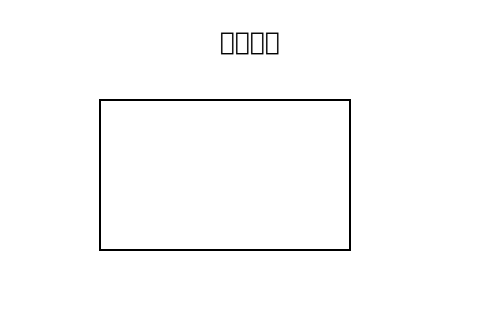

요청한 문장: 한 변의 길이가 2인 정사각형 하나를 그려줘
추출된 개념: Square
추출된 인자: {'length': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="200" height="200" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Square

**정의:**
사각형은 네 개의 변으로 이루어진 평면 도형입니다. 모든 내각이 직각(90도)이며, 반대편의 변들이 길이가 같아서 마주보는 두 변은 평행하고 길이가 동일합니다.

**기본 성질:**
1. **대변의 길이 동일:** 사각형의 마주보는 두 변은 길이가 같습니다. 예를 들어, 정사각형이나 직사각형에서는 모든 대변이 같은 길이를 가집니다.
2. **대각선의 성질:** 사각형의 대각선은 서로를 반으로 나눕니다. 즉, 대각선이 만나는 점에서 대각선을 잇는 선분들은 서로를 절반으로 나눕니다.
3. **변의 합:** 사각형의 네 변의 길이를 모두 더하면, 그 합은 사각형의 둘레를 나타냅니다. 예를 들어, 한 변의 길이가 \(a\)이고 다른 변의 길이가 \(b\)라면, 둘레는 \(a + b + a + b = 2(a + b)\)가 됩니다.
4. **정사각형의 특징:** 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 사각형입니다. 모든 대각선도 길이가 같고 서로를 직각으로 이룹니다.

이러한 성질들로 인해 사각형은 다양한 형태와 크기로 존재하며, 건축, 디자인, 그리고 일상생활에서 자주 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '4 \\times \\mathrm{한 변의 길이}', 'area': '\\m

<IPython.core.display.Math object>

<IPython.core.display.Math object>

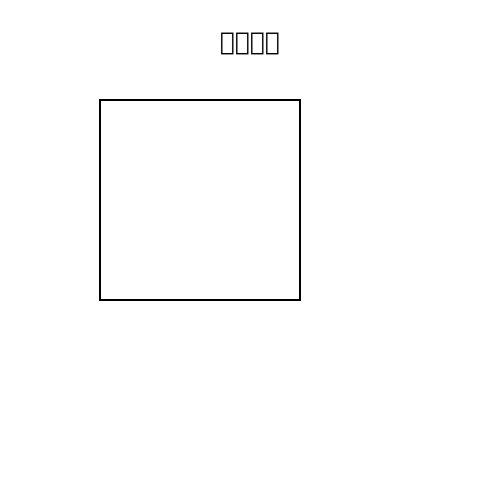

요청한 문장: 곧은선이 뭐야?
추출된 개념: 직선
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="75" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="175" font-size="25" text-anchor="middle">반직선</text>
    <circle cx="125" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="250" x2="500" y2="250" stroke="black" stroke-width="2" />
    <!-- 직선 -->
    <text x="250" y="300" font-size="25" text-anchor="middle">직선</text>
    <circle cx="125" cy="375" r="1" stroke="black"

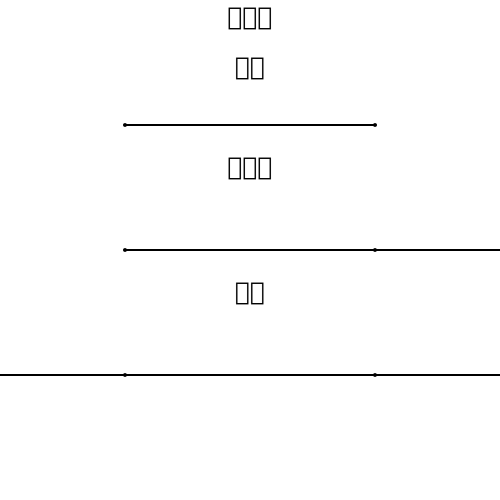

요청한 문장: 대표적인 굽은선을 그려줘
추출된 개념: 곡선
추출된 인자: {'type': '타원', 'description': '타원은 가장 대표적인 굽은선의 한 종류로, 두 초점 사이의 거리의 합이 일정한 점들의 집합으로 정의됩니다.'}

생성된 코드:
 
    <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">굽은선</text>
    <!-- 복잡한 S자 곡선 (두 개의 Cubic Bézier) -->
    <path d="M 100,400
    C 100,100 400,100 400,250
    C 400,400 100,400 100,100"
    stroke="black" fill="none" stroke-width="2"/>
    </svg>
    

생성된 설명:
 ### 곡선에 대한 설명

**정의:**
곡선은 직선이 아닌, 연속적으로 이어지는 점들의 모임으로 이루어진 도형입니다. 쉽게 말해, 직선처럼 일정한 방향으로만 움직이는 것이 아니라, 부드럽게 휘어지거나 굽어지는 형태를 가진 선을 말합니다.

**기본 성질:**
1. **연속성:** 곡선 위의 모든 점들은 부드럽게 이어져 있어, 어떤 작은 구간에서도 끊어지지 않고 이어집니다.
2. **길이:** 곡선의 길이는 그 곡선을 따라 측정한 총 거리입니다. 이 길이는 곡선의 모양에 따라 달라집니다. 예를 들어, 원의 둘레는 반지름에 따라 결정되며, 이는 곡선의 길이를 정확히 계산하는 방법 중 하나입니다.
3. **곡률:** 곡선이 얼마나 빠르게 방향을 바꾸는지를 나타내는 값입니다. 곡률이 크면 곡선이 더 급하게 굽어지고, 작으면 더 부드럽게 굽어집니다. 예를 들어, 원의 경우 모든 점에서 곡률이 일정합니다.
4. **접선:** 곡선 위의 어떤 점에서 그 점을 지나는 가장 가까운 직선을 접선이라고 합니다. 이 접

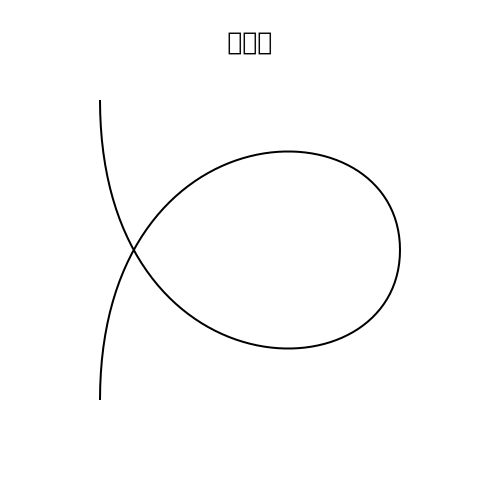

요청한 문장: 중심이 (0,0)이고 반지름이 2인 원을 그려주세요.
추출된 개념: Circle
추출된 인자: {'radius': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="100" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="250" y1="250" x2="350" y2="250" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Circle (원)

#### 정의:
원은 평면 위에서 한 점(중심)으로부터 일정한 거리(반지름)에 있는 모든 점들의 집합을 말합니다. 이 중심점을 기준으로 원 위의 모든 점들은 동일한 거리에 위치해 있습니다.

#### 기본 성질:
1. **둘레와 지름**: 원의 둘레는 지름에 π(약 3.14)를 곱한 값입니다. 즉, 둘레 = 지름 × π 입니다. 반대로 지름은 둘레를 π로 나누면 구할 수 있습니다.
   
2. **면적**: 원의 면적은 반지름의 제곱에 π를 곱한 값입니다. 공식으로 표현하면 면적 = π × 반지름2 입니다.

3. **대칭성**: 원은 중심을 기준으로 완벽하게 대칭입니다. 즉, 중심을 지나는 어떤 직선을 기준으로 원을 접어도 양쪽이 완전히 일치합니다.

4. **원주각과 호의 관계**: 원 위의 두 점을 잇는 호의 중앙각은 그 호에 대응하는 원주각의 두 배입니다. 예를 들어, 호의 중앙각이 θ라면 원주각은 θ/2가 됩니다.

이러한 성질들로 인해 원은 기하학에

<IPython.core.display.Math object>

<IPython.core.display.Math object>

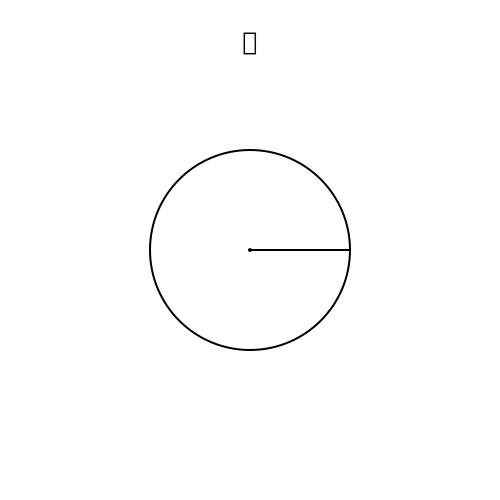

요청한 문장: 37° 각도를 그려줘
추출된 개념: 각도
추출된 인자: {'size': 37}

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
    <!-- 기준선 -->
    <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="333" x2="324.6588775118232" y2="182.54624421198793" stroke="black" stroke-width="2" />
    <!-- 각도 호 -->
    <path d="M 164.93177550236464,302.9092488423976 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>
    </svg>
    

생성된 설명:
 ### 각도에 대한 설명

**정의:**
각도는 두 직선이나 선분이 만나서 생기는 공간의 크기를 측정하는 방법입니다. 우리가 일상에서 자주 접하는 각도는 주로 도로 표지판에서 볼 수 있는 방향 지시나, 그림에서 선들이 만나는 부분을 표현할 때 사용됩니다.

**기본 성질:**
1. **직선의 각도:** 직선은 정확히 180도의 각도를 가집니다. 직선은 두 방향으로 무한히 이어지는 것처럼 보이지만, 실제로는 시작점과 끝점이 있습니다.
   
2. **직각 각도:** 직각은 90도를 의미합니다. 이는 우리가 흔히 사용하는 'L'자 모양의 모서리나 사각형의 모서리에서 볼 수 있습니다. 직각은 두 직선이 서로 수직으로 만나는 경우에 생깁니다.

3. **평행선과 각도:** 평행한 두 직선은 만나지 않기 때문에, 그들 사이의 각도는

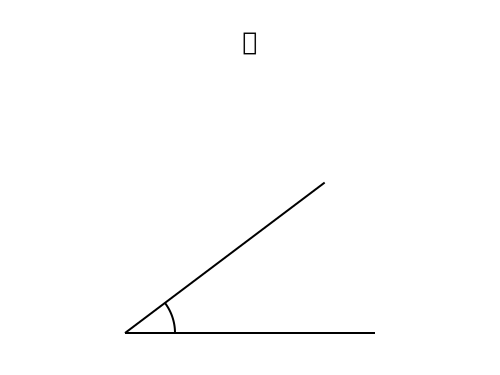

요청한 문장: 직각을 표현해줘
추출된 개념: Right Angle
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
    <!-- 기준선 -->
    <line x1="125" y1="400" x2="458" y2="400" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="400" x2="125" y2="67" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="175" y1="400" x2="175" y2="350" stroke="black" stroke-width="2" />
    <line x1="125" y1="350" x2="175" y2="350" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Angle

**정의:**
Right Angle은 기하학에서 가장 기본적인 각도 중 하나로, 정확히 90도를 이루는 각도를 말합니다. 이 각도는 직각이라고도 불리며, 직선이나 특정 도형의 모서리에서 만나는 두 변이 서로 수직으로 만나는 경우에 나타납니다.

**기본 성질:**
1. **크기:** Right Angle은 항상 정확히 90도입니다. 이는 모든 Right Angle이 동일한 크기를 가짐을 의미합니다.
2. **모양:** Right Angle은 보통 'L' 모양으로 쉽게 인식할 수 있습니다. 이 모양은 직각을 나타내는 데 자주 사용됩니다.
3. **도형과의 관계:** 직각은 사각형, 직사각형, 정사각형 등 다양한 도형의 모서리에서 발견됩니다. 특히, 직사각형이나 정사각형은 네 개

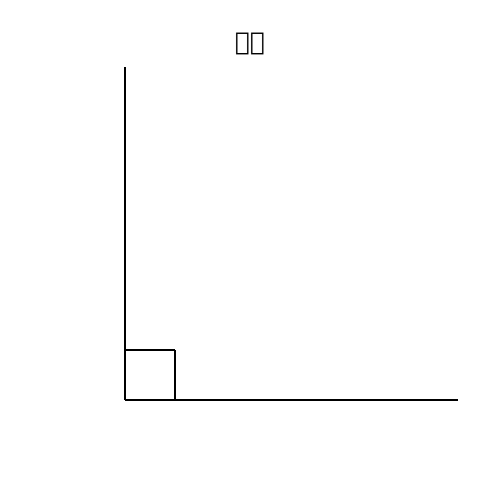

요청한 문장: 밑변이 3이고, 높이가 4인 직각삼각형 하나를 그려줘
추출된 개념: Right Triangle
추출된 인자: {'base': 3, 'height': 4}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <line x1="83" y1="416" x2="308" y2="416" stroke="black" stroke-width="2" />
    <line x1="308" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <line x1="83" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="286" y1="416" x2="286" y2="394" stroke="black" stroke-width="2" />
    <line x1="286" y1="394" x2="308" y2="394" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Triangle

**정의:**
A right triangle is a special type of triangle that has one angle which measures exactly 90 degrees (a right angle). This unique angle distinguishes it from other triangles where all angles are less than 90 degrees.

**기본 성질:**
1. **한 각이 직각:** 가장 중요한 특징은 한 꼭짓점

<IPython.core.display.Math object>

<IPython.core.display.Math object>

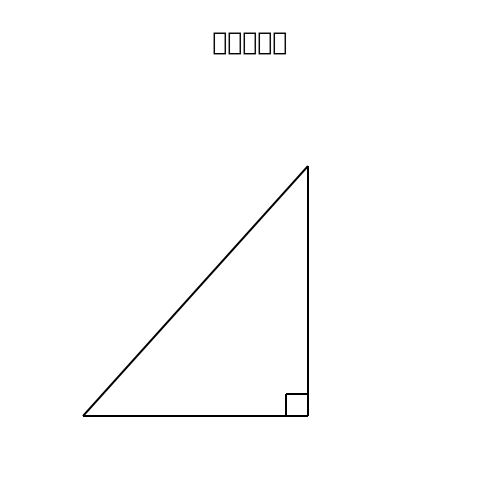

요청한 문장: 가로가 5, 세로가 3인 직사각형의 넓이
추출된 개념: Rectangle
추출된 인자: {'width': 5, 'height': 3}

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="250" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Rectangle 설명

**정의:**
사각형은 네 개의 직선으로 둘러싸인 평면 도형으로, 각 내각이 직각(90도)인 특징을 가지고 있습니다. 즉, 사각형의 네 모서리는 모두 직각을 이루며, 대변이 평행하고 길이가 같은 특성을 갖습니다.

**기본 성질:**
1. **대변의 길이가 같음:** 사각형의 두 쌍의 대변은 길이가 동일합니다. 예를 들어, 가로와 세로가 같은 길이를 가집니다.
2. **대각선이 서로 같음:** 사각형의 두 대각선은 길이가 같습니다. 즉, 사각형을 두 개의 동일한 삼각형으로 나눌 수 있습니다.
3. **내각의 합:** 사각형의 네 내각의 합은 항상 360도입니다.
4. **변의 배열:** 사각형은 여러 가지 형태로 배열될 수 있습니다. 예를 들어, 직사각형은 가로와 세로가 각각 다른 길이를 가질 수 있으며, 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 형태의 사각형입니다.

이러한 성질들로 인해 사각형은 우리 일상생활에서 매우 흔하게 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '2 × (밑변 + 높이)', 'area': '밑변 × 높이'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

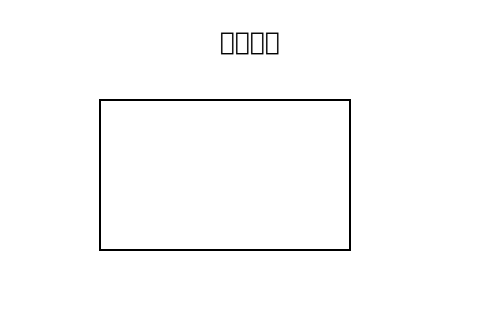

요청한 문장: 한 변의 길이가 2인 정사각형 하나를 그려줘
추출된 개념: Square
추출된 인자: {'length': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="200" height="200" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Square

**정의:**
사각형은 네 개의 변으로 이루어진 평면 도형입니다. 모든 내각이 직각(90도)이며, 반대편의 변들이 길이가 같아서 마주보는 두 변은 평행하고 길이가 동일합니다.

**기본 성질:**
1. **대변의 길이 동일:** 사각형의 마주보는 두 변은 길이가 같습니다. 예를 들어, 정사각형이나 직사각형에서는 모든 대변이 같은 길이를 가집니다.
2. **대각선의 성질:** 사각형의 대각선은 서로를 반으로 나눕니다. 즉, 대각선이 만나는 점에서 대각선을 잇는 선분들은 서로를 절반으로 나눕니다.
3. **변의 합:** 사각형의 네 변의 길이를 모두 더하면, 그 합은 사각형의 둘레를 나타냅니다. 예를 들어, 한 변의 길이가 \(a\)이고 다른 변의 길이가 \(b\)라면, 둘레는 \(a + b + a + b = 2(a + b)\)가 됩니다.
4. **정사각형의 특징:** 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 사각형입니다. 모든 대각선도 길이가 같고 서로를 직각으로 이룹니다.

이러한 성질들로 인해 사각형은 다양한 형태와 크기로 존재하며, 건축, 디자인, 그리고 일상생활에서 자주 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '4 \\times \\mathrm{한 변의 길이}', 'area': '\\m

<IPython.core.display.Math object>

<IPython.core.display.Math object>

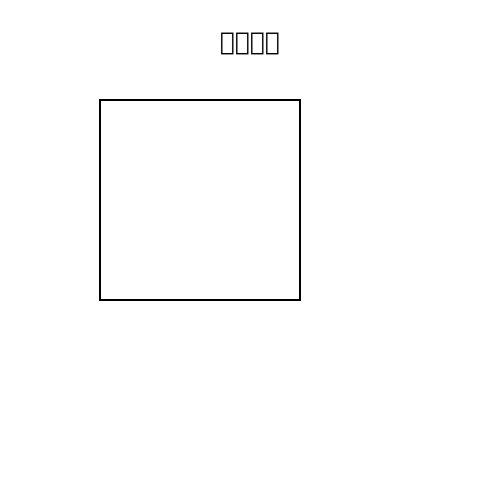

요청한 문장: 곧은선이 뭐야?
추출된 개념: 직선
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="75" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="175" font-size="25" text-anchor="middle">반직선</text>
    <circle cx="125" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="250" x2="500" y2="250" stroke="black" stroke-width="2" />
    <!-- 직선 -->
    <text x="250" y="300" font-size="25" text-anchor="middle">직선</text>
    <circle cx="125" cy="375" r="1" stroke="black"

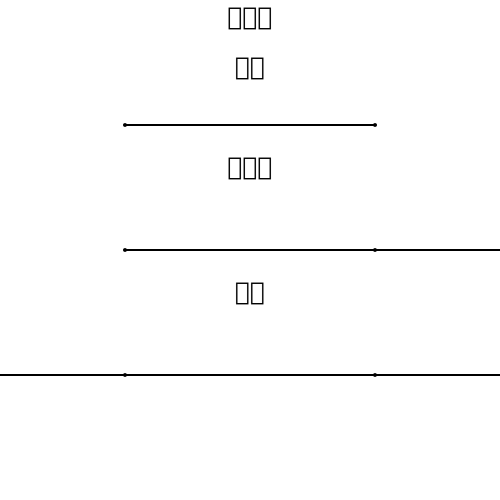

요청한 문장: 대표적인 굽은선을 그려줘
추출된 개념: 곡선
추출된 인자: {'type': '타원', 'description': '타원은 가장 대표적인 굽은선의 한 종류로, 두 초점 사이의 거리의 합이 일정한 점들의 집합으로 정의됩니다.'}

생성된 코드:
 
    <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">굽은선</text>
    <!-- 복잡한 S자 곡선 (두 개의 Cubic Bézier) -->
    <path d="M 100,400
    C 100,100 400,100 400,250
    C 400,400 100,400 100,100"
    stroke="black" fill="none" stroke-width="2"/>
    </svg>
    

생성된 설명:
 ### 곡선에 대한 설명

**정의:**
곡선은 직선이 아닌, 연속적으로 이어지는 점들의 모임으로 이루어진 도형입니다. 쉽게 말해, 직선처럼 일정한 방향으로만 움직이는 것이 아니라, 부드럽게 휘어지거나 굽어지는 형태를 가진 선을 말합니다.

**기본 성질:**
1. **연속성:** 곡선 위의 모든 점들은 부드럽게 이어져 있어, 어떤 작은 구간에서도 끊어지지 않고 이어집니다.
2. **길이:** 곡선의 길이는 그 곡선을 따라 측정한 총 거리입니다. 이 길이는 곡선의 모양에 따라 달라집니다. 예를 들어, 원의 둘레는 반지름에 따라 결정되며, 이는 곡선의 길이를 정확히 계산하는 방법 중 하나입니다.
3. **곡률:** 곡선이 얼마나 빠르게 방향을 바꾸는지를 나타내는 값입니다. 곡률이 크면 곡선이 더 급하게 굽어지고, 작으면 더 부드럽게 굽어집니다. 예를 들어, 원의 경우 모든 점에서 곡률이 일정합니다.
4. **접선:** 곡선 위의 어떤 점에서 그 점을 지나는 가장 가까운 직선을 접선이라고 합니다. 이 접

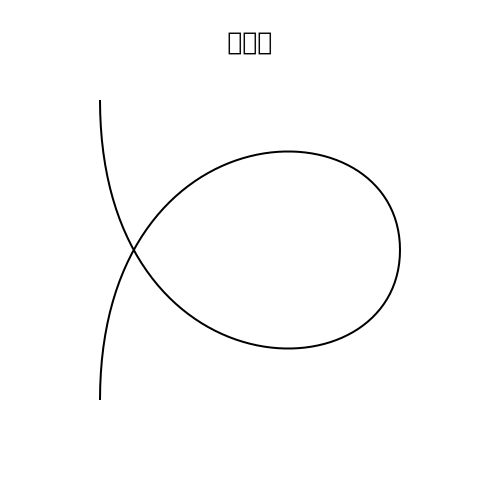

요청한 문장: 중심이 (0,0)이고 반지름이 2인 원을 그려주세요.
추출된 개념: Circle
추출된 인자: {'radius': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="100" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="250" y1="250" x2="350" y2="250" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Circle (원)

#### 정의:
원은 평면 위에서 한 점(중심)으로부터 일정한 거리(반지름)에 있는 모든 점들의 집합을 말합니다. 이 중심점을 기준으로 원 위의 모든 점들은 동일한 거리에 위치해 있습니다.

#### 기본 성질:
1. **둘레와 지름**: 원의 둘레는 지름에 π(약 3.14)를 곱한 값입니다. 즉, 둘레 = 지름 × π 입니다. 반대로 지름은 둘레를 π로 나누면 구할 수 있습니다.
   
2. **면적**: 원의 면적은 반지름의 제곱에 π를 곱한 값입니다. 공식으로 표현하면 면적 = π × 반지름2 입니다.

3. **대칭성**: 원은 중심을 기준으로 완벽하게 대칭입니다. 즉, 중심을 지나는 어떤 직선을 기준으로 원을 접어도 양쪽이 완전히 일치합니다.

4. **원주각과 호의 관계**: 원 위의 두 점을 잇는 호의 중앙각은 그 호에 대응하는 원주각의 두 배입니다. 예를 들어, 호의 중앙각이 θ라면 원주각은 θ/2가 됩니다.

이러한 성질들로 인해 원은 기하학에

<IPython.core.display.Math object>

<IPython.core.display.Math object>

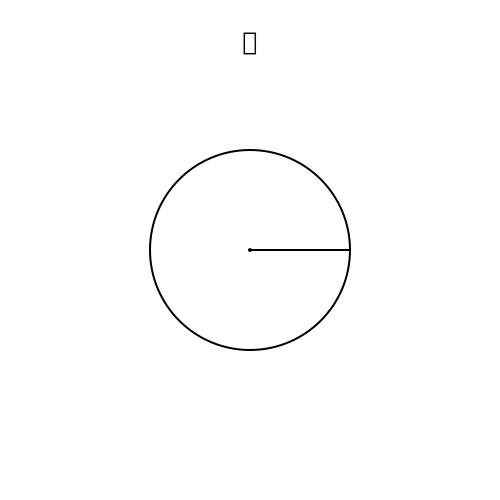

요청한 문장: 37° 각도를 그려줘
추출된 개념: 각도
추출된 인자: {'size': 37}

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
    <!-- 기준선 -->
    <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="333" x2="324.6588775118232" y2="182.54624421198793" stroke="black" stroke-width="2" />
    <!-- 각도 호 -->
    <path d="M 164.93177550236464,302.9092488423976 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>
    </svg>
    

생성된 설명:
 ### 각도에 대한 설명

**정의:**
각도는 두 직선이나 선분이 만나서 생기는 공간의 크기를 측정하는 방법입니다. 우리가 일상에서 자주 접하는 각도는 주로 도로 표지판에서 볼 수 있는 방향 지시나, 그림에서 선들이 만나는 부분을 표현할 때 사용됩니다.

**기본 성질:**
1. **직선의 각도:** 직선은 정확히 180도의 각도를 가집니다. 직선은 두 방향으로 무한히 이어지는 것처럼 보이지만, 실제로는 시작점과 끝점이 있습니다.
   
2. **직각 각도:** 직각은 90도를 의미합니다. 이는 우리가 흔히 사용하는 'L'자 모양의 모서리나 사각형의 모서리에서 볼 수 있습니다. 직각은 두 직선이 서로 수직으로 만나는 경우에 생깁니다.

3. **평행선과 각도:** 평행한 두 직선은 만나지 않기 때문에, 그들 사이의 각도는

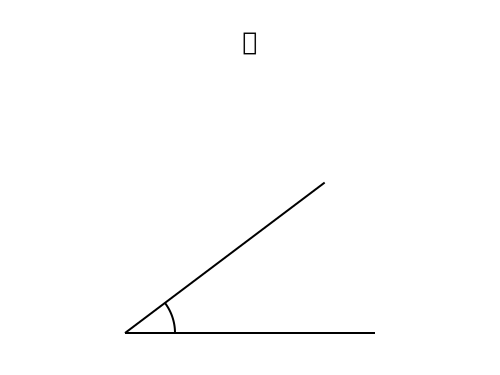

요청한 문장: 직각을 표현해줘
추출된 개념: Right Angle
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
    <!-- 기준선 -->
    <line x1="125" y1="400" x2="458" y2="400" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="400" x2="125" y2="67" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="175" y1="400" x2="175" y2="350" stroke="black" stroke-width="2" />
    <line x1="125" y1="350" x2="175" y2="350" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Angle

**정의:**
Right Angle은 기하학에서 가장 기본적인 각도 중 하나로, 정확히 90도를 이루는 각도를 말합니다. 이 각도는 직각이라고도 불리며, 직선이나 특정 도형의 모서리에서 만나는 두 변이 서로 수직으로 만나는 경우에 나타납니다.

**기본 성질:**
1. **크기:** Right Angle은 항상 정확히 90도입니다. 이는 모든 Right Angle이 동일한 크기를 가짐을 의미합니다.
2. **모양:** Right Angle은 보통 'L' 모양으로 쉽게 인식할 수 있습니다. 이 모양은 직각을 나타내는 데 자주 사용됩니다.
3. **도형과의 관계:** 직각은 사각형, 직사각형, 정사각형 등 다양한 도형의 모서리에서 발견됩니다. 특히, 직사각형이나 정사각형은 네 개

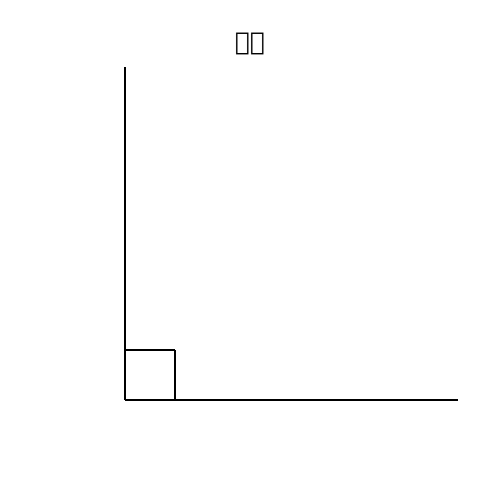

요청한 문장: 밑변이 3이고, 높이가 4인 직각삼각형 하나를 그려줘
추출된 개념: Right Triangle
추출된 인자: {'base': 3, 'height': 4}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <line x1="83" y1="416" x2="308" y2="416" stroke="black" stroke-width="2" />
    <line x1="308" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <line x1="83" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="286" y1="416" x2="286" y2="394" stroke="black" stroke-width="2" />
    <line x1="286" y1="394" x2="308" y2="394" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Triangle

**정의:**
A right triangle is a special type of triangle that has one angle which measures exactly 90 degrees (a right angle). This unique angle distinguishes it from other triangles where all angles are less than 90 degrees.

**기본 성질:**
1. **한 각이 직각:** 가장 중요한 특징은 한 꼭짓점

<IPython.core.display.Math object>

<IPython.core.display.Math object>

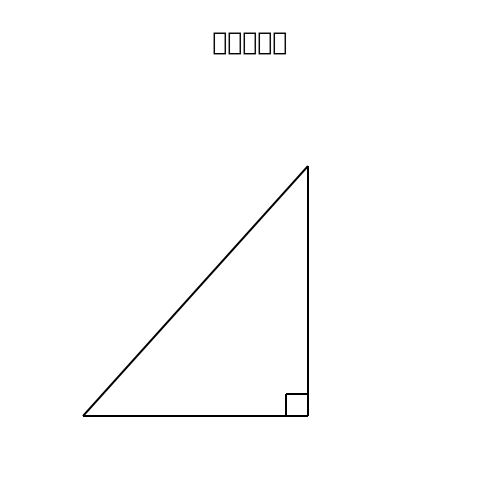

요청한 문장: 가로가 5, 세로가 3인 직사각형의 넓이
추출된 개념: Rectangle
추출된 인자: {'width': 5, 'height': 3}

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="250" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Rectangle 설명

**정의:**
사각형은 네 개의 직선으로 둘러싸인 평면 도형으로, 각 내각이 직각(90도)인 특징을 가지고 있습니다. 즉, 사각형의 네 모서리는 모두 직각을 이루며, 대변이 평행하고 길이가 같은 특성을 갖습니다.

**기본 성질:**
1. **대변의 길이가 같음:** 사각형의 두 쌍의 대변은 길이가 동일합니다. 예를 들어, 가로와 세로가 같은 길이를 가집니다.
2. **대각선이 서로 같음:** 사각형의 두 대각선은 길이가 같습니다. 즉, 사각형을 두 개의 동일한 삼각형으로 나눌 수 있습니다.
3. **내각의 합:** 사각형의 네 내각의 합은 항상 360도입니다.
4. **변의 배열:** 사각형은 여러 가지 형태로 배열될 수 있습니다. 예를 들어, 직사각형은 가로와 세로가 각각 다른 길이를 가질 수 있으며, 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 형태의 사각형입니다.

이러한 성질들로 인해 사각형은 우리 일상생활에서 매우 흔하게 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '2 × (밑변 + 높이)', 'area': '밑변 × 높이'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

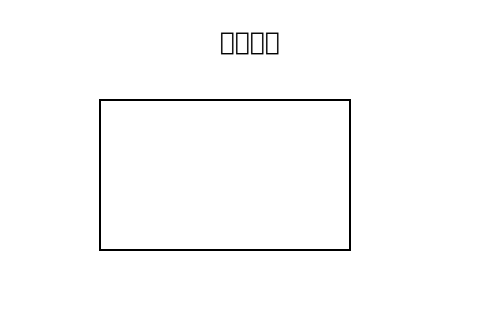

요청한 문장: 한 변의 길이가 2인 정사각형 하나를 그려줘
추출된 개념: Square
추출된 인자: {'length': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="200" height="200" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Square

**정의:**
사각형은 네 개의 변으로 이루어진 평면 도형입니다. 모든 내각이 직각(90도)이며, 반대편의 변들이 길이가 같아서 마주보는 두 변은 평행하고 길이가 동일합니다.

**기본 성질:**
1. **대변의 길이 동일:** 사각형의 마주보는 두 변은 길이가 같습니다. 예를 들어, 정사각형이나 직사각형에서는 모든 대변이 같은 길이를 가집니다.
2. **대각선의 성질:** 사각형의 대각선은 서로를 반으로 나눕니다. 즉, 대각선이 만나는 점에서 대각선을 잇는 선분들은 서로를 절반으로 나눕니다.
3. **변의 합:** 사각형의 네 변의 길이를 모두 더하면, 그 합은 사각형의 둘레를 나타냅니다. 예를 들어, 한 변의 길이가 \(a\)이고 다른 변의 길이가 \(b\)라면, 둘레는 \(a + b + a + b = 2(a + b)\)가 됩니다.
4. **정사각형의 특징:** 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 사각형입니다. 모든 대각선도 길이가 같고 서로를 직각으로 이룹니다.

이러한 성질들로 인해 사각형은 다양한 형태와 크기로 존재하며, 건축, 디자인, 그리고 일상생활에서 자주 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '4 \\times \\mathrm{한 변의 길이}', 'area': '\\m

<IPython.core.display.Math object>

<IPython.core.display.Math object>

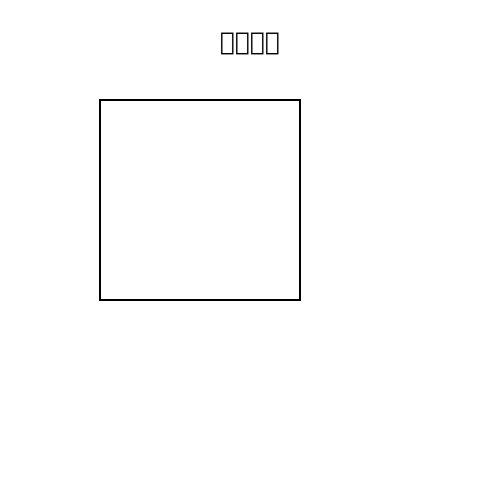

요청한 문장: 곧은선이 뭐야?
추출된 개념: 직선
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="75" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="175" font-size="25" text-anchor="middle">반직선</text>
    <circle cx="125" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="250" x2="500" y2="250" stroke="black" stroke-width="2" />
    <!-- 직선 -->
    <text x="250" y="300" font-size="25" text-anchor="middle">직선</text>
    <circle cx="125" cy="375" r="1" stroke="black"

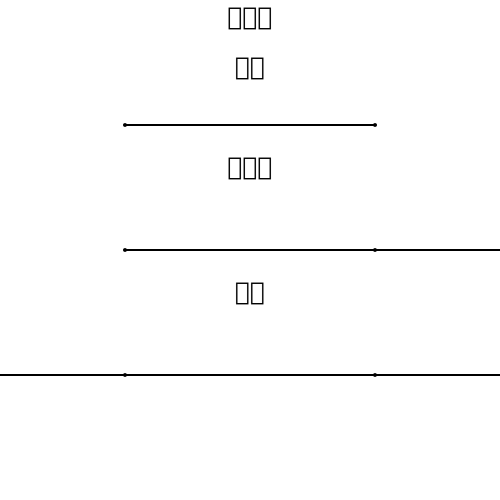

요청한 문장: 대표적인 굽은선을 그려줘
추출된 개념: 곡선
추출된 인자: {'type': '타원', 'description': '타원은 가장 대표적인 굽은선의 한 종류로, 두 초점 사이의 거리의 합이 일정한 점들의 집합으로 정의됩니다.'}

생성된 코드:
 
    <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">굽은선</text>
    <!-- 복잡한 S자 곡선 (두 개의 Cubic Bézier) -->
    <path d="M 100,400
    C 100,100 400,100 400,250
    C 400,400 100,400 100,100"
    stroke="black" fill="none" stroke-width="2"/>
    </svg>
    

생성된 설명:
 ### 곡선에 대한 설명

**정의:**
곡선은 직선이 아닌, 연속적으로 이어지는 점들의 모임으로 이루어진 도형입니다. 쉽게 말해, 직선처럼 일정한 방향으로만 움직이는 것이 아니라, 부드럽게 휘어지거나 굽어지는 형태를 가진 선을 말합니다.

**기본 성질:**
1. **연속성:** 곡선 위의 모든 점들은 부드럽게 이어져 있어, 어떤 작은 구간에서도 끊어지지 않고 이어집니다.
2. **길이:** 곡선의 길이는 그 곡선을 따라 측정한 총 거리입니다. 이 길이는 곡선의 모양에 따라 달라집니다. 예를 들어, 원의 둘레는 반지름에 따라 결정되며, 이는 곡선의 길이를 정확히 계산하는 방법 중 하나입니다.
3. **곡률:** 곡선이 얼마나 빠르게 방향을 바꾸는지를 나타내는 값입니다. 곡률이 크면 곡선이 더 급하게 굽어지고, 작으면 더 부드럽게 굽어집니다. 예를 들어, 원의 경우 모든 점에서 곡률이 일정합니다.
4. **접선:** 곡선 위의 어떤 점에서 그 점을 지나는 가장 가까운 직선을 접선이라고 합니다. 이 접

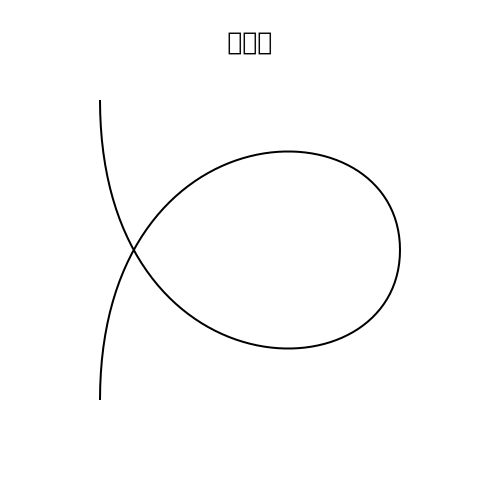

요청한 문장: 중심이 (0,0)이고 반지름이 2인 원을 그려주세요.
추출된 개념: Circle
추출된 인자: {'radius': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="100" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="250" y1="250" x2="350" y2="250" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Circle (원)

#### 정의:
원은 평면 위에서 한 점(중심)으로부터 일정한 거리(반지름)에 있는 모든 점들의 집합을 말합니다. 이 중심점을 기준으로 원 위의 모든 점들은 동일한 거리에 위치해 있습니다.

#### 기본 성질:
1. **둘레와 지름**: 원의 둘레는 지름에 π(약 3.14)를 곱한 값입니다. 즉, 둘레 = 지름 × π 입니다. 반대로 지름은 둘레를 π로 나누면 구할 수 있습니다.
   
2. **면적**: 원의 면적은 반지름의 제곱에 π를 곱한 값입니다. 공식으로 표현하면 면적 = π × 반지름2 입니다.

3. **대칭성**: 원은 중심을 기준으로 완벽하게 대칭입니다. 즉, 중심을 지나는 어떤 직선을 기준으로 원을 접어도 양쪽이 완전히 일치합니다.

4. **원주각과 호의 관계**: 원 위의 두 점을 잇는 호의 중앙각은 그 호에 대응하는 원주각의 두 배입니다. 예를 들어, 호의 중앙각이 θ라면 원주각은 θ/2가 됩니다.

이러한 성질들로 인해 원은 기하학에

<IPython.core.display.Math object>

<IPython.core.display.Math object>

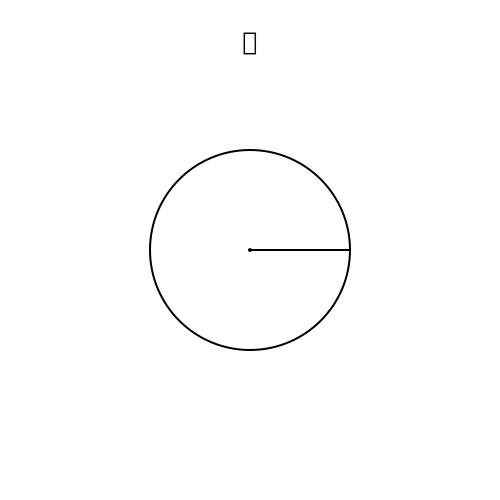

요청한 문장: 37° 각도를 그려줘
추출된 개념: 각도
추출된 인자: {'size': 37}

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
    <!-- 기준선 -->
    <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="333" x2="324.6588775118232" y2="182.54624421198793" stroke="black" stroke-width="2" />
    <!-- 각도 호 -->
    <path d="M 164.93177550236464,302.9092488423976 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>
    </svg>
    

생성된 설명:
 ### 각도에 대한 설명

**정의:**
각도는 두 직선이나 선분이 만나서 생기는 공간의 크기를 측정하는 방법입니다. 우리가 일상에서 자주 접하는 각도는 주로 도로 표지판에서 볼 수 있는 방향 지시나, 그림에서 선들이 만나는 부분을 표현할 때 사용됩니다.

**기본 성질:**
1. **직선의 각도:** 직선은 정확히 180도의 각도를 가집니다. 직선은 두 방향으로 무한히 이어지는 것처럼 보이지만, 실제로는 시작점과 끝점이 있습니다.
   
2. **직각 각도:** 직각은 90도를 의미합니다. 이는 우리가 흔히 사용하는 'L'자 모양의 모서리나 사각형의 모서리에서 볼 수 있습니다. 직각은 두 직선이 서로 수직으로 만나는 경우에 생깁니다.

3. **평행선과 각도:** 평행한 두 직선은 만나지 않기 때문에, 그들 사이의 각도는

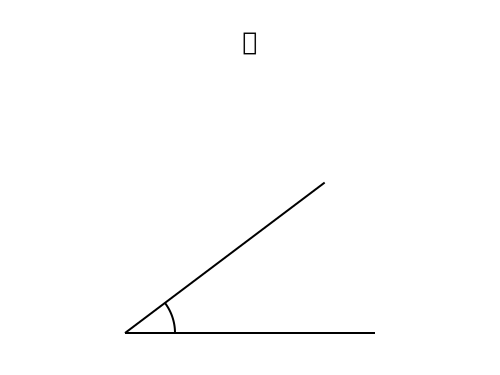

요청한 문장: 직각을 표현해줘
추출된 개념: Right Angle
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
    <!-- 기준선 -->
    <line x1="125" y1="400" x2="458" y2="400" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="400" x2="125" y2="67" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="175" y1="400" x2="175" y2="350" stroke="black" stroke-width="2" />
    <line x1="125" y1="350" x2="175" y2="350" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Angle

**정의:**
Right Angle은 기하학에서 가장 기본적인 각도 중 하나로, 정확히 90도를 이루는 각도를 말합니다. 이 각도는 직각이라고도 불리며, 직선이나 특정 도형의 모서리에서 만나는 두 변이 서로 수직으로 만나는 경우에 나타납니다.

**기본 성질:**
1. **크기:** Right Angle은 항상 정확히 90도입니다. 이는 모든 Right Angle이 동일한 크기를 가짐을 의미합니다.
2. **모양:** Right Angle은 보통 'L' 모양으로 쉽게 인식할 수 있습니다. 이 모양은 직각을 나타내는 데 자주 사용됩니다.
3. **도형과의 관계:** 직각은 사각형, 직사각형, 정사각형 등 다양한 도형의 모서리에서 발견됩니다. 특히, 직사각형이나 정사각형은 네 개

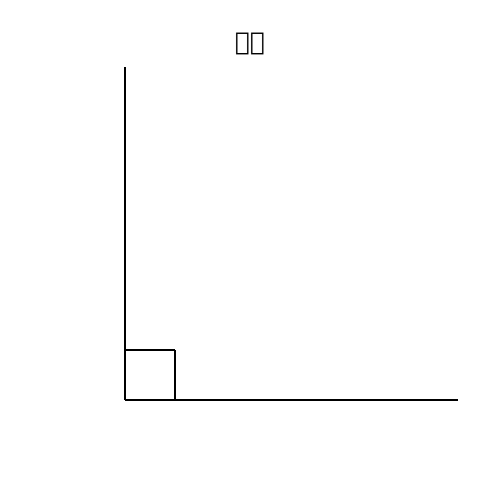

요청한 문장: 밑변이 3이고, 높이가 4인 직각삼각형 하나를 그려줘
추출된 개념: Right Triangle
추출된 인자: {'base': 3, 'height': 4}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <line x1="83" y1="416" x2="308" y2="416" stroke="black" stroke-width="2" />
    <line x1="308" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <line x1="83" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="286" y1="416" x2="286" y2="394" stroke="black" stroke-width="2" />
    <line x1="286" y1="394" x2="308" y2="394" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Triangle

**정의:**
A right triangle is a special type of triangle that has one angle which measures exactly 90 degrees (a right angle). This unique angle distinguishes it from other triangles where all angles are less than 90 degrees.

**기본 성질:**
1. **한 각이 직각:** 가장 중요한 특징은 한 꼭짓점

<IPython.core.display.Math object>

<IPython.core.display.Math object>

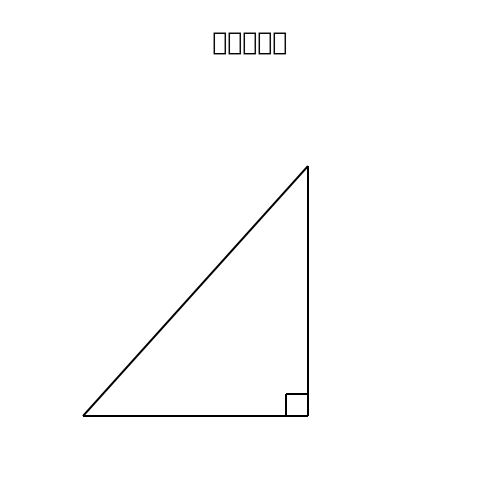

요청한 문장: 가로가 5, 세로가 3인 직사각형의 넓이
추출된 개념: Rectangle
추출된 인자: {'width': 5, 'height': 3}

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="250" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Rectangle 설명

**정의:**
사각형은 네 개의 직선으로 둘러싸인 평면 도형으로, 각 내각이 직각(90도)인 특징을 가지고 있습니다. 즉, 사각형의 네 모서리는 모두 직각을 이루며, 대변이 평행하고 길이가 같은 특성을 갖습니다.

**기본 성질:**
1. **대변의 길이가 같음:** 사각형의 두 쌍의 대변은 길이가 동일합니다. 예를 들어, 가로와 세로가 같은 길이를 가집니다.
2. **대각선이 서로 같음:** 사각형의 두 대각선은 길이가 같습니다. 즉, 사각형을 두 개의 동일한 삼각형으로 나눌 수 있습니다.
3. **내각의 합:** 사각형의 네 내각의 합은 항상 360도입니다.
4. **변의 배열:** 사각형은 여러 가지 형태로 배열될 수 있습니다. 예를 들어, 직사각형은 가로와 세로가 각각 다른 길이를 가질 수 있으며, 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 형태의 사각형입니다.

이러한 성질들로 인해 사각형은 우리 일상생활에서 매우 흔하게 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '2 × (밑변 + 높이)', 'area': '밑변 × 높이'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

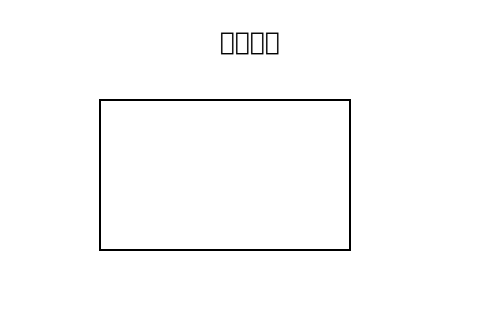

요청한 문장: 한 변의 길이가 2인 정사각형 하나를 그려줘
추출된 개념: Square
추출된 인자: {'length': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="200" height="200" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Square

**정의:**
사각형은 네 개의 변으로 이루어진 평면 도형입니다. 모든 내각이 직각(90도)이며, 반대편의 변들이 길이가 같아서 마주보는 두 변은 평행하고 길이가 동일합니다.

**기본 성질:**
1. **대변의 길이 동일:** 사각형의 마주보는 두 변은 길이가 같습니다. 예를 들어, 정사각형이나 직사각형에서는 모든 대변이 같은 길이를 가집니다.
2. **대각선의 성질:** 사각형의 대각선은 서로를 반으로 나눕니다. 즉, 대각선이 만나는 점에서 대각선을 잇는 선분들은 서로를 절반으로 나눕니다.
3. **변의 합:** 사각형의 네 변의 길이를 모두 더하면, 그 합은 사각형의 둘레를 나타냅니다. 예를 들어, 한 변의 길이가 \(a\)이고 다른 변의 길이가 \(b\)라면, 둘레는 \(a + b + a + b = 2(a + b)\)가 됩니다.
4. **정사각형의 특징:** 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 사각형입니다. 모든 대각선도 길이가 같고 서로를 직각으로 이룹니다.

이러한 성질들로 인해 사각형은 다양한 형태와 크기로 존재하며, 건축, 디자인, 그리고 일상생활에서 자주 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '4 \\times \\mathrm{한 변의 길이}', 'area': '\\m

<IPython.core.display.Math object>

<IPython.core.display.Math object>

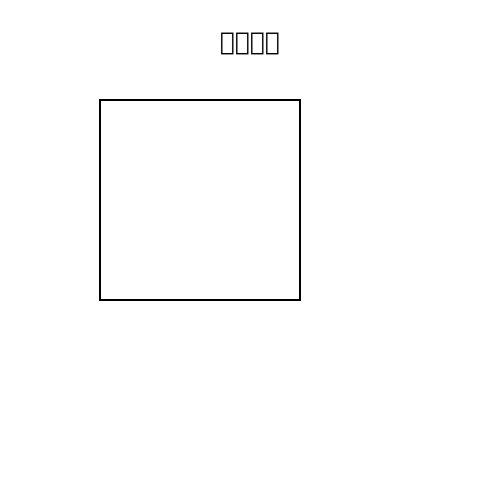

요청한 문장: 곧은선이 뭐야?
추출된 개념: 직선
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="75" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="175" font-size="25" text-anchor="middle">반직선</text>
    <circle cx="125" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="250" x2="500" y2="250" stroke="black" stroke-width="2" />
    <!-- 직선 -->
    <text x="250" y="300" font-size="25" text-anchor="middle">직선</text>
    <circle cx="125" cy="375" r="1" stroke="black"

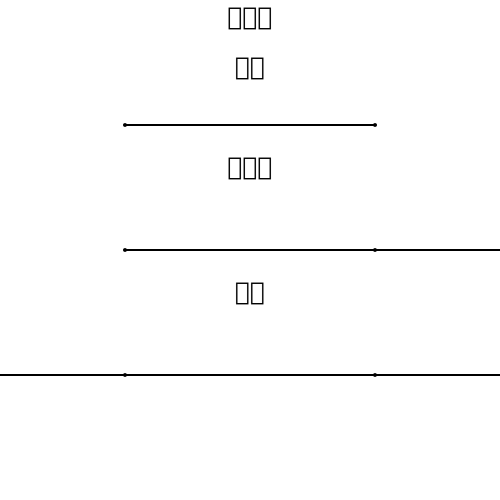

요청한 문장: 대표적인 굽은선을 그려줘
추출된 개념: 곡선
추출된 인자: {'type': '타원', 'description': '타원은 가장 대표적인 굽은선의 한 종류로, 두 초점 사이의 거리의 합이 일정한 점들의 집합으로 정의됩니다.'}

생성된 코드:
 
    <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">굽은선</text>
    <!-- 복잡한 S자 곡선 (두 개의 Cubic Bézier) -->
    <path d="M 100,400
    C 100,100 400,100 400,250
    C 400,400 100,400 100,100"
    stroke="black" fill="none" stroke-width="2"/>
    </svg>
    

생성된 설명:
 ### 곡선에 대한 설명

**정의:**
곡선은 직선이 아닌, 연속적으로 이어지는 점들의 모임으로 이루어진 도형입니다. 쉽게 말해, 직선처럼 일정한 방향으로만 움직이는 것이 아니라, 부드럽게 휘어지거나 굽어지는 형태를 가진 선을 말합니다.

**기본 성질:**
1. **연속성:** 곡선 위의 모든 점들은 부드럽게 이어져 있어, 어떤 작은 구간에서도 끊어지지 않고 이어집니다.
2. **길이:** 곡선의 길이는 그 곡선을 따라 측정한 총 거리입니다. 이 길이는 곡선의 모양에 따라 달라집니다. 예를 들어, 원의 둘레는 반지름에 따라 결정되며, 이는 곡선의 길이를 정확히 계산하는 방법 중 하나입니다.
3. **곡률:** 곡선이 얼마나 빠르게 방향을 바꾸는지를 나타내는 값입니다. 곡률이 크면 곡선이 더 급하게 굽어지고, 작으면 더 부드럽게 굽어집니다. 예를 들어, 원의 경우 모든 점에서 곡률이 일정합니다.
4. **접선:** 곡선 위의 어떤 점에서 그 점을 지나는 가장 가까운 직선을 접선이라고 합니다. 이 접

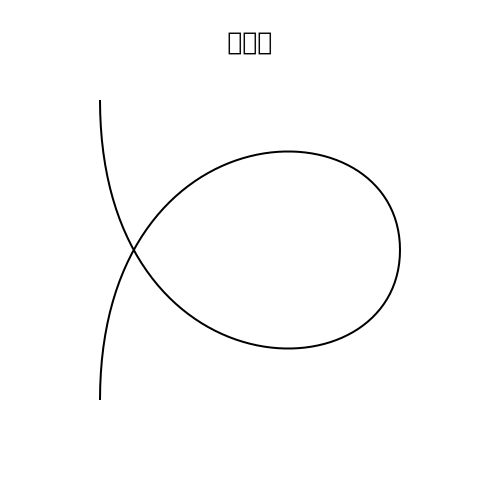

요청한 문장: 중심이 (0,0)이고 반지름이 2인 원을 그려주세요.
추출된 개념: Circle
추출된 인자: {'radius': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="100" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="250" y1="250" x2="350" y2="250" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Circle (원)

#### 정의:
원은 평면 위에서 한 점(중심)으로부터 일정한 거리(반지름)에 있는 모든 점들의 집합을 말합니다. 이 중심점을 기준으로 원 위의 모든 점들은 동일한 거리에 위치해 있습니다.

#### 기본 성질:
1. **둘레와 지름**: 원의 둘레는 지름에 π(약 3.14)를 곱한 값입니다. 즉, 둘레 = 지름 × π 입니다. 반대로 지름은 둘레를 π로 나누면 구할 수 있습니다.
   
2. **면적**: 원의 면적은 반지름의 제곱에 π를 곱한 값입니다. 공식으로 표현하면 면적 = π × 반지름2 입니다.

3. **대칭성**: 원은 중심을 기준으로 완벽하게 대칭입니다. 즉, 중심을 지나는 어떤 직선을 기준으로 원을 접어도 양쪽이 완전히 일치합니다.

4. **원주각과 호의 관계**: 원 위의 두 점을 잇는 호의 중앙각은 그 호에 대응하는 원주각의 두 배입니다. 예를 들어, 호의 중앙각이 θ라면 원주각은 θ/2가 됩니다.

이러한 성질들로 인해 원은 기하학에

<IPython.core.display.Math object>

<IPython.core.display.Math object>

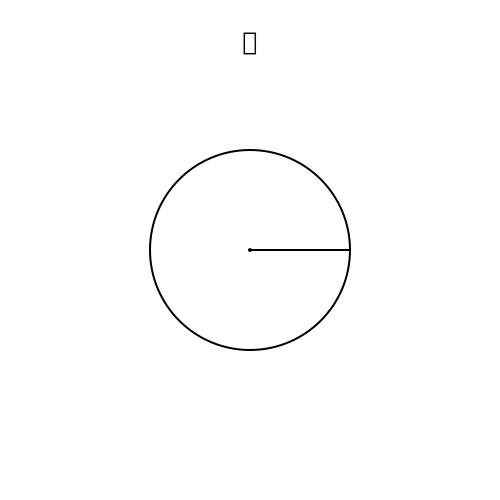

요청한 문장: 37° 각도를 그려줘
추출된 개념: 각도
추출된 인자: {'size': 37}

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
    <!-- 기준선 -->
    <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="333" x2="324.6588775118232" y2="182.54624421198793" stroke="black" stroke-width="2" />
    <!-- 각도 호 -->
    <path d="M 164.93177550236464,302.9092488423976 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>
    </svg>
    

생성된 설명:
 ### 각도에 대한 설명

**정의:**
각도는 두 직선이나 선분이 만나서 생기는 공간의 크기를 측정하는 방법입니다. 우리가 일상에서 자주 접하는 각도는 주로 도로 표지판에서 볼 수 있는 방향 지시나, 그림에서 선들이 만나는 부분을 표현할 때 사용됩니다.

**기본 성질:**
1. **직선의 각도:** 직선은 정확히 180도의 각도를 가집니다. 직선은 두 방향으로 무한히 이어지는 것처럼 보이지만, 실제로는 시작점과 끝점이 있습니다.
   
2. **직각 각도:** 직각은 90도를 의미합니다. 이는 우리가 흔히 사용하는 'L'자 모양의 모서리나 사각형의 모서리에서 볼 수 있습니다. 직각은 두 직선이 서로 수직으로 만나는 경우에 생깁니다.

3. **평행선과 각도:** 평행한 두 직선은 만나지 않기 때문에, 그들 사이의 각도는

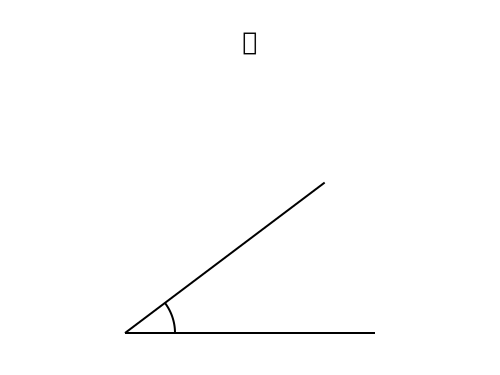

요청한 문장: 직각을 표현해줘
추출된 개념: Right Angle
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
    <!-- 기준선 -->
    <line x1="125" y1="400" x2="458" y2="400" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="400" x2="125" y2="67" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="175" y1="400" x2="175" y2="350" stroke="black" stroke-width="2" />
    <line x1="125" y1="350" x2="175" y2="350" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Angle

**정의:**
Right Angle은 기하학에서 가장 기본적인 각도 중 하나로, 정확히 90도를 이루는 각도를 말합니다. 이 각도는 직각이라고도 불리며, 직선이나 특정 도형의 모서리에서 만나는 두 변이 서로 수직으로 만나는 경우에 나타납니다.

**기본 성질:**
1. **크기:** Right Angle은 항상 정확히 90도입니다. 이는 모든 Right Angle이 동일한 크기를 가짐을 의미합니다.
2. **모양:** Right Angle은 보통 'L' 모양으로 쉽게 인식할 수 있습니다. 이 모양은 직각을 나타내는 데 자주 사용됩니다.
3. **도형과의 관계:** 직각은 사각형, 직사각형, 정사각형 등 다양한 도형의 모서리에서 발견됩니다. 특히, 직사각형이나 정사각형은 네 개

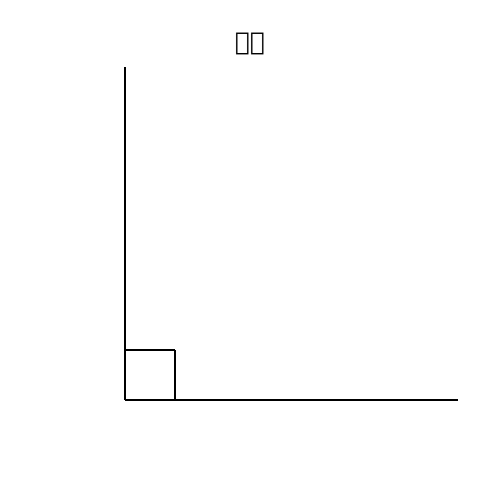

요청한 문장: 밑변이 3이고, 높이가 4인 직각삼각형 하나를 그려줘
추출된 개념: Right Triangle
추출된 인자: {'base': 3, 'height': 4}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <line x1="83" y1="416" x2="308" y2="416" stroke="black" stroke-width="2" />
    <line x1="308" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <line x1="83" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="286" y1="416" x2="286" y2="394" stroke="black" stroke-width="2" />
    <line x1="286" y1="394" x2="308" y2="394" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Triangle

**정의:**
A right triangle is a special type of triangle that has one angle which measures exactly 90 degrees (a right angle). This unique angle distinguishes it from other triangles where all angles are less than 90 degrees.

**기본 성질:**
1. **한 각이 직각:** 가장 중요한 특징은 한 꼭짓점

<IPython.core.display.Math object>

<IPython.core.display.Math object>

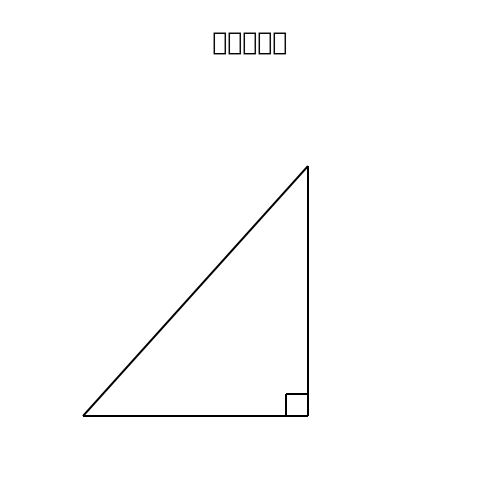

요청한 문장: 가로가 5, 세로가 3인 직사각형의 넓이
추출된 개념: Rectangle
추출된 인자: {'width': 5, 'height': 3}

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="250" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Rectangle 설명

**정의:**
사각형은 네 개의 직선으로 둘러싸인 평면 도형으로, 각 내각이 직각(90도)인 특징을 가지고 있습니다. 즉, 사각형의 네 모서리는 모두 직각을 이루며, 대변이 평행하고 길이가 같은 특성을 갖습니다.

**기본 성질:**
1. **대변의 길이가 같음:** 사각형의 두 쌍의 대변은 길이가 동일합니다. 예를 들어, 가로와 세로가 같은 길이를 가집니다.
2. **대각선이 서로 같음:** 사각형의 두 대각선은 길이가 같습니다. 즉, 사각형을 두 개의 동일한 삼각형으로 나눌 수 있습니다.
3. **내각의 합:** 사각형의 네 내각의 합은 항상 360도입니다.
4. **변의 배열:** 사각형은 여러 가지 형태로 배열될 수 있습니다. 예를 들어, 직사각형은 가로와 세로가 각각 다른 길이를 가질 수 있으며, 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 형태의 사각형입니다.

이러한 성질들로 인해 사각형은 우리 일상생활에서 매우 흔하게 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '2 × (밑변 + 높이)', 'area': '밑변 × 높이'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

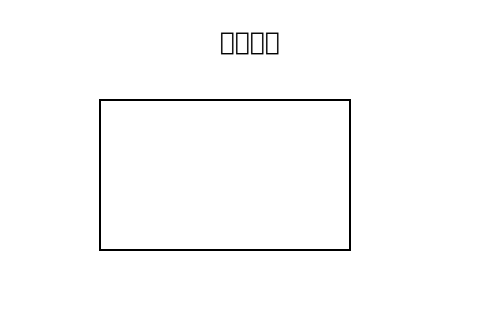

요청한 문장: 한 변의 길이가 2인 정사각형 하나를 그려줘
추출된 개념: Square
추출된 인자: {'length': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="200" height="200" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Square

**정의:**
사각형은 네 개의 변으로 이루어진 평면 도형입니다. 모든 내각이 직각(90도)이며, 반대편의 변들이 길이가 같아서 마주보는 두 변은 평행하고 길이가 동일합니다.

**기본 성질:**
1. **대변의 길이 동일:** 사각형의 마주보는 두 변은 길이가 같습니다. 예를 들어, 정사각형이나 직사각형에서는 모든 대변이 같은 길이를 가집니다.
2. **대각선의 성질:** 사각형의 대각선은 서로를 반으로 나눕니다. 즉, 대각선이 만나는 점에서 대각선을 잇는 선분들은 서로를 절반으로 나눕니다.
3. **변의 합:** 사각형의 네 변의 길이를 모두 더하면, 그 합은 사각형의 둘레를 나타냅니다. 예를 들어, 한 변의 길이가 \(a\)이고 다른 변의 길이가 \(b\)라면, 둘레는 \(a + b + a + b = 2(a + b)\)가 됩니다.
4. **정사각형의 특징:** 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 사각형입니다. 모든 대각선도 길이가 같고 서로를 직각으로 이룹니다.

이러한 성질들로 인해 사각형은 다양한 형태와 크기로 존재하며, 건축, 디자인, 그리고 일상생활에서 자주 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '4 \\times \\mathrm{한 변의 길이}', 'area': '\\m

<IPython.core.display.Math object>

<IPython.core.display.Math object>

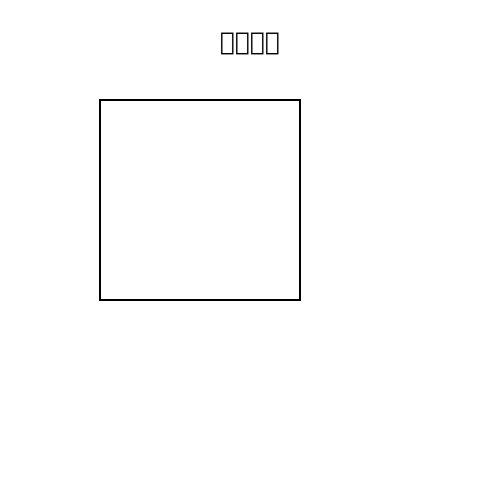

요청한 문장: 곧은선이 뭐야?
추출된 개념: 직선
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="75" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="175" font-size="25" text-anchor="middle">반직선</text>
    <circle cx="125" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="250" x2="500" y2="250" stroke="black" stroke-width="2" />
    <!-- 직선 -->
    <text x="250" y="300" font-size="25" text-anchor="middle">직선</text>
    <circle cx="125" cy="375" r="1" stroke="black"

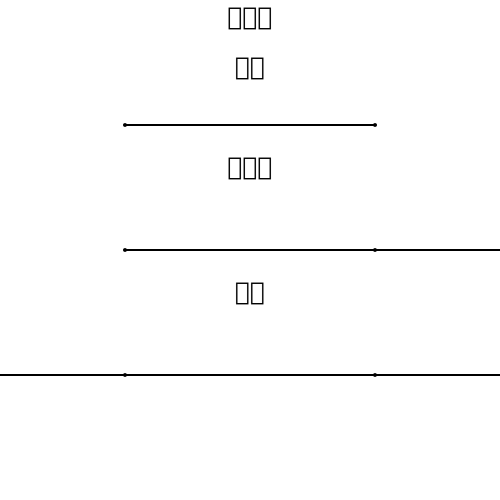

요청한 문장: 대표적인 굽은선을 그려줘
추출된 개념: 곡선
추출된 인자: {'type': '타원', 'description': '타원은 가장 대표적인 굽은선의 한 종류로, 두 초점 사이의 거리의 합이 일정한 점들의 집합으로 정의됩니다.'}

생성된 코드:
 
    <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">굽은선</text>
    <!-- 복잡한 S자 곡선 (두 개의 Cubic Bézier) -->
    <path d="M 100,400
    C 100,100 400,100 400,250
    C 400,400 100,400 100,100"
    stroke="black" fill="none" stroke-width="2"/>
    </svg>
    

생성된 설명:
 ### 곡선에 대한 설명

**정의:**
곡선은 직선이 아닌, 연속적으로 이어지는 점들의 모임으로 이루어진 도형입니다. 쉽게 말해, 직선처럼 일정한 방향으로만 움직이는 것이 아니라, 부드럽게 휘어지거나 굽어지는 형태를 가진 선을 말합니다.

**기본 성질:**
1. **연속성:** 곡선 위의 모든 점들은 부드럽게 이어져 있어, 어떤 작은 구간에서도 끊어지지 않고 이어집니다.
2. **길이:** 곡선의 길이는 그 곡선을 따라 측정한 총 거리입니다. 이 길이는 곡선의 모양에 따라 달라집니다. 예를 들어, 원의 둘레는 반지름에 따라 결정되며, 이는 곡선의 길이를 정확히 계산하는 방법 중 하나입니다.
3. **곡률:** 곡선이 얼마나 빠르게 방향을 바꾸는지를 나타내는 값입니다. 곡률이 크면 곡선이 더 급하게 굽어지고, 작으면 더 부드럽게 굽어집니다. 예를 들어, 원의 경우 모든 점에서 곡률이 일정합니다.
4. **접선:** 곡선 위의 어떤 점에서 그 점을 지나는 가장 가까운 직선을 접선이라고 합니다. 이 접

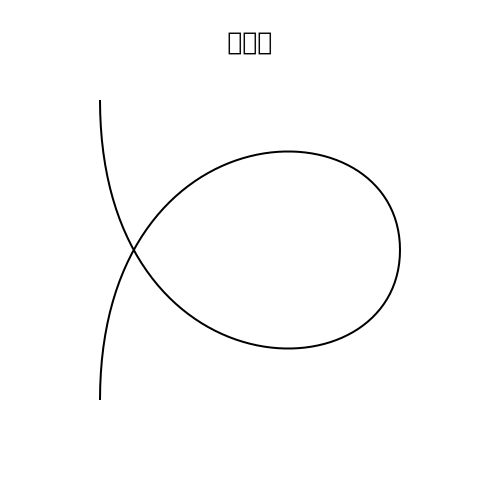

요청한 문장: 중심이 (0,0)이고 반지름이 2인 원을 그려주세요.
추출된 개념: Circle
추출된 인자: {'radius': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="100" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="250" y1="250" x2="350" y2="250" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Circle (원)

#### 정의:
원은 평면 위에서 한 점(중심)으로부터 일정한 거리(반지름)에 있는 모든 점들의 집합을 말합니다. 이 중심점을 기준으로 원 위의 모든 점들은 동일한 거리에 위치해 있습니다.

#### 기본 성질:
1. **둘레와 지름**: 원의 둘레는 지름에 π(약 3.14)를 곱한 값입니다. 즉, 둘레 = 지름 × π 입니다. 반대로 지름은 둘레를 π로 나누면 구할 수 있습니다.
   
2. **면적**: 원의 면적은 반지름의 제곱에 π를 곱한 값입니다. 공식으로 표현하면 면적 = π × 반지름2 입니다.

3. **대칭성**: 원은 중심을 기준으로 완벽하게 대칭입니다. 즉, 중심을 지나는 어떤 직선을 기준으로 원을 접어도 양쪽이 완전히 일치합니다.

4. **원주각과 호의 관계**: 원 위의 두 점을 잇는 호의 중앙각은 그 호에 대응하는 원주각의 두 배입니다. 예를 들어, 호의 중앙각이 θ라면 원주각은 θ/2가 됩니다.

이러한 성질들로 인해 원은 기하학에

<IPython.core.display.Math object>

<IPython.core.display.Math object>

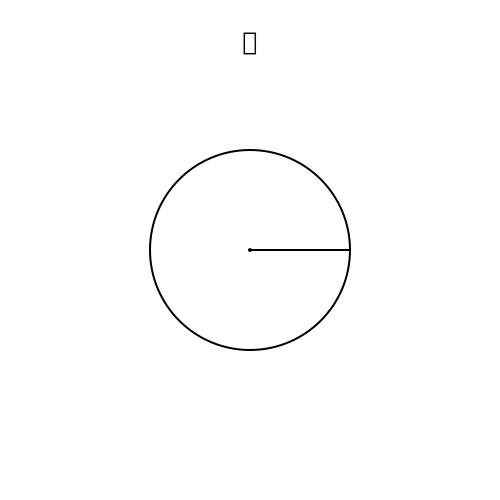

요청한 문장: 37° 각도를 그려줘
추출된 개념: 각도
추출된 인자: {'size': 37}

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
    <!-- 기준선 -->
    <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="333" x2="324.6588775118232" y2="182.54624421198793" stroke="black" stroke-width="2" />
    <!-- 각도 호 -->
    <path d="M 164.93177550236464,302.9092488423976 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>
    </svg>
    

생성된 설명:
 ### 각도에 대한 설명

**정의:**
각도는 두 직선이나 선분이 만나서 생기는 공간의 크기를 측정하는 방법입니다. 우리가 일상에서 자주 접하는 각도는 주로 도로 표지판에서 볼 수 있는 방향 지시나, 그림에서 선들이 만나는 부분을 표현할 때 사용됩니다.

**기본 성질:**
1. **직선의 각도:** 직선은 정확히 180도의 각도를 가집니다. 직선은 두 방향으로 무한히 이어지는 것처럼 보이지만, 실제로는 시작점과 끝점이 있습니다.
   
2. **직각 각도:** 직각은 90도를 의미합니다. 이는 우리가 흔히 사용하는 'L'자 모양의 모서리나 사각형의 모서리에서 볼 수 있습니다. 직각은 두 직선이 서로 수직으로 만나는 경우에 생깁니다.

3. **평행선과 각도:** 평행한 두 직선은 만나지 않기 때문에, 그들 사이의 각도는

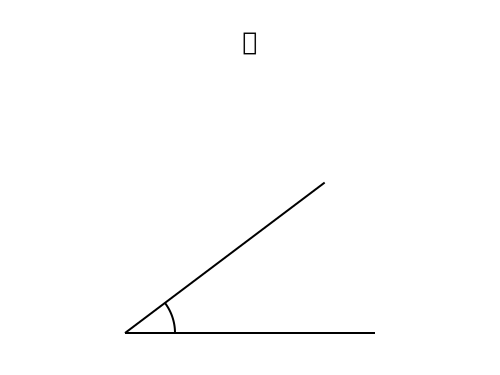

요청한 문장: 직각을 표현해줘
추출된 개념: Right Angle
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
    <!-- 기준선 -->
    <line x1="125" y1="400" x2="458" y2="400" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="400" x2="125" y2="67" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="175" y1="400" x2="175" y2="350" stroke="black" stroke-width="2" />
    <line x1="125" y1="350" x2="175" y2="350" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Angle

**정의:**
Right Angle은 기하학에서 가장 기본적인 각도 중 하나로, 정확히 90도를 이루는 각도를 말합니다. 이 각도는 직각이라고도 불리며, 직선이나 특정 도형의 모서리에서 만나는 두 변이 서로 수직으로 만나는 경우에 나타납니다.

**기본 성질:**
1. **크기:** Right Angle은 항상 정확히 90도입니다. 이는 모든 Right Angle이 동일한 크기를 가짐을 의미합니다.
2. **모양:** Right Angle은 보통 'L' 모양으로 쉽게 인식할 수 있습니다. 이 모양은 직각을 나타내는 데 자주 사용됩니다.
3. **도형과의 관계:** 직각은 사각형, 직사각형, 정사각형 등 다양한 도형의 모서리에서 발견됩니다. 특히, 직사각형이나 정사각형은 네 개

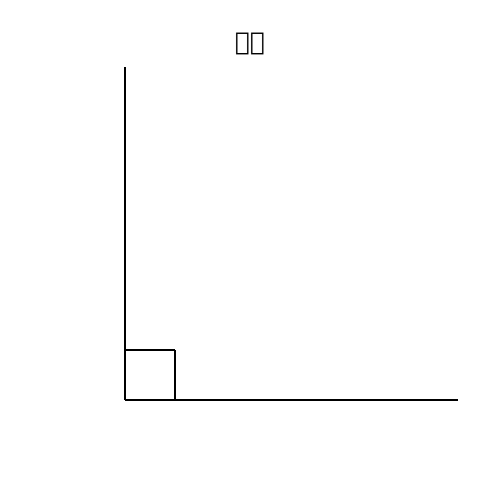

요청한 문장: 밑변이 3이고, 높이가 4인 직각삼각형 하나를 그려줘
추출된 개념: Right Triangle
추출된 인자: {'base': 3, 'height': 4}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <line x1="83" y1="416" x2="308" y2="416" stroke="black" stroke-width="2" />
    <line x1="308" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <line x1="83" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="286" y1="416" x2="286" y2="394" stroke="black" stroke-width="2" />
    <line x1="286" y1="394" x2="308" y2="394" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Triangle

**정의:**
A right triangle is a special type of triangle that has one angle which measures exactly 90 degrees (a right angle). This unique angle distinguishes it from other triangles where all angles are less than 90 degrees.

**기본 성질:**
1. **한 각이 직각:** 가장 중요한 특징은 한 꼭짓점

<IPython.core.display.Math object>

<IPython.core.display.Math object>

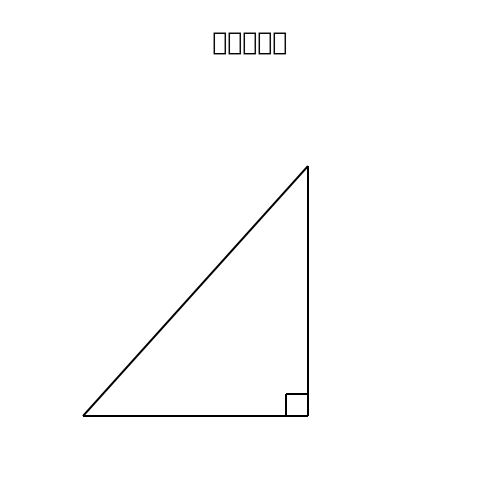

요청한 문장: 가로가 5, 세로가 3인 직사각형의 넓이
추출된 개념: Rectangle
추출된 인자: {'width': 5, 'height': 3}

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="250" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Rectangle 설명

**정의:**
사각형은 네 개의 직선으로 둘러싸인 평면 도형으로, 각 내각이 직각(90도)인 특징을 가지고 있습니다. 즉, 사각형의 네 모서리는 모두 직각을 이루며, 대변이 평행하고 길이가 같은 특성을 갖습니다.

**기본 성질:**
1. **대변의 길이가 같음:** 사각형의 두 쌍의 대변은 길이가 동일합니다. 예를 들어, 가로와 세로가 같은 길이를 가집니다.
2. **대각선이 서로 같음:** 사각형의 두 대각선은 길이가 같습니다. 즉, 사각형을 두 개의 동일한 삼각형으로 나눌 수 있습니다.
3. **내각의 합:** 사각형의 네 내각의 합은 항상 360도입니다.
4. **변의 배열:** 사각형은 여러 가지 형태로 배열될 수 있습니다. 예를 들어, 직사각형은 가로와 세로가 각각 다른 길이를 가질 수 있으며, 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 형태의 사각형입니다.

이러한 성질들로 인해 사각형은 우리 일상생활에서 매우 흔하게 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '2 × (밑변 + 높이)', 'area': '밑변 × 높이'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

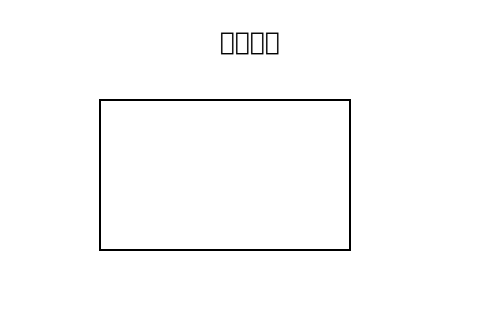

요청한 문장: 한 변의 길이가 2인 정사각형 하나를 그려줘
추출된 개념: Square
추출된 인자: {'length': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="200" height="200" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Square

**정의:**
사각형은 네 개의 변으로 이루어진 평면 도형입니다. 모든 내각이 직각(90도)이며, 반대편의 변들이 길이가 같아서 마주보는 두 변은 평행하고 길이가 동일합니다.

**기본 성질:**
1. **대변의 길이 동일:** 사각형의 마주보는 두 변은 길이가 같습니다. 예를 들어, 정사각형이나 직사각형에서는 모든 대변이 같은 길이를 가집니다.
2. **대각선의 성질:** 사각형의 대각선은 서로를 반으로 나눕니다. 즉, 대각선이 만나는 점에서 대각선을 잇는 선분들은 서로를 절반으로 나눕니다.
3. **변의 합:** 사각형의 네 변의 길이를 모두 더하면, 그 합은 사각형의 둘레를 나타냅니다. 예를 들어, 한 변의 길이가 \(a\)이고 다른 변의 길이가 \(b\)라면, 둘레는 \(a + b + a + b = 2(a + b)\)가 됩니다.
4. **정사각형의 특징:** 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 사각형입니다. 모든 대각선도 길이가 같고 서로를 직각으로 이룹니다.

이러한 성질들로 인해 사각형은 다양한 형태와 크기로 존재하며, 건축, 디자인, 그리고 일상생활에서 자주 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '4 \\times \\mathrm{한 변의 길이}', 'area': '\\m

<IPython.core.display.Math object>

<IPython.core.display.Math object>

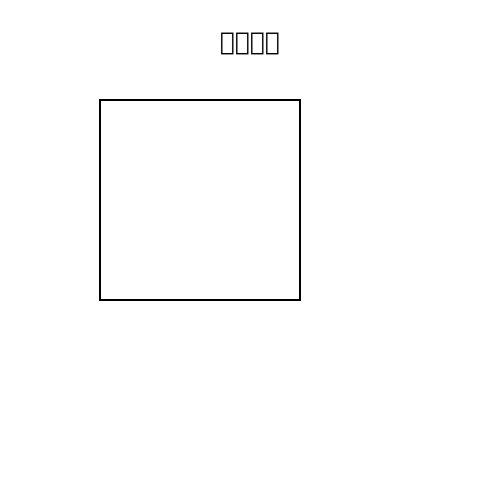

요청한 문장: 곧은선이 뭐야?
추출된 개념: 직선
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="75" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="175" font-size="25" text-anchor="middle">반직선</text>
    <circle cx="125" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="250" x2="500" y2="250" stroke="black" stroke-width="2" />
    <!-- 직선 -->
    <text x="250" y="300" font-size="25" text-anchor="middle">직선</text>
    <circle cx="125" cy="375" r="1" stroke="black"

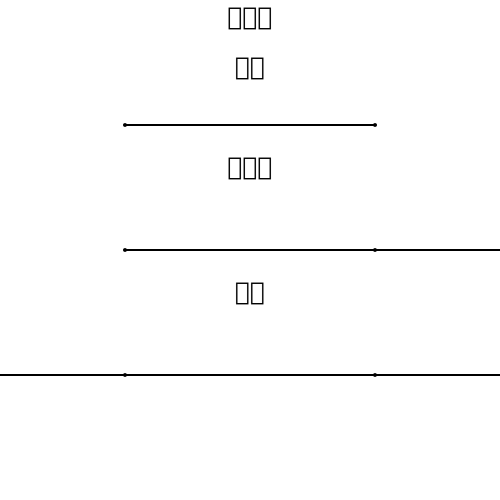

요청한 문장: 대표적인 굽은선을 그려줘
추출된 개념: 곡선
추출된 인자: {'type': '타원', 'description': '타원은 가장 대표적인 굽은선의 한 종류로, 두 초점 사이의 거리의 합이 일정한 점들의 집합으로 정의됩니다.'}

생성된 코드:
 
    <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">굽은선</text>
    <!-- 복잡한 S자 곡선 (두 개의 Cubic Bézier) -->
    <path d="M 100,400
    C 100,100 400,100 400,250
    C 400,400 100,400 100,100"
    stroke="black" fill="none" stroke-width="2"/>
    </svg>
    

생성된 설명:
 ### 곡선에 대한 설명

**정의:**
곡선은 직선이 아닌, 연속적으로 이어지는 점들의 모임으로 이루어진 도형입니다. 쉽게 말해, 직선처럼 일정한 방향으로만 움직이는 것이 아니라, 부드럽게 휘어지거나 굽어지는 형태를 가진 선을 말합니다.

**기본 성질:**
1. **연속성:** 곡선 위의 모든 점들은 부드럽게 이어져 있어, 어떤 작은 구간에서도 끊어지지 않고 이어집니다.
2. **길이:** 곡선의 길이는 그 곡선을 따라 측정한 총 거리입니다. 이 길이는 곡선의 모양에 따라 달라집니다. 예를 들어, 원의 둘레는 반지름에 따라 결정되며, 이는 곡선의 길이를 정확히 계산하는 방법 중 하나입니다.
3. **곡률:** 곡선이 얼마나 빠르게 방향을 바꾸는지를 나타내는 값입니다. 곡률이 크면 곡선이 더 급하게 굽어지고, 작으면 더 부드럽게 굽어집니다. 예를 들어, 원의 경우 모든 점에서 곡률이 일정합니다.
4. **접선:** 곡선 위의 어떤 점에서 그 점을 지나는 가장 가까운 직선을 접선이라고 합니다. 이 접

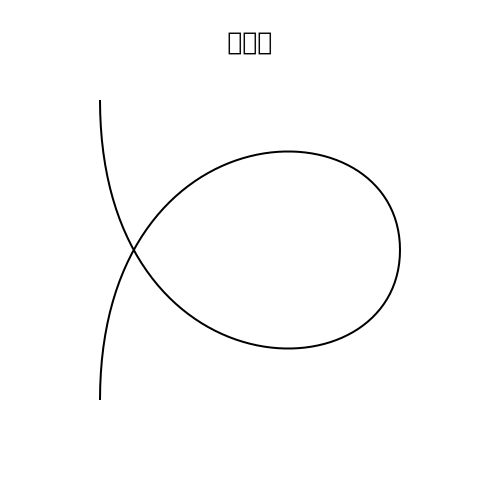

요청한 문장: 중심이 (0,0)이고 반지름이 2인 원을 그려주세요.
추출된 개념: Circle
추출된 인자: {'radius': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="100" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="250" y1="250" x2="350" y2="250" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Circle (원)

#### 정의:
원은 평면 위에서 한 점(중심)으로부터 일정한 거리(반지름)에 있는 모든 점들의 집합을 말합니다. 이 중심점을 기준으로 원 위의 모든 점들은 동일한 거리에 위치해 있습니다.

#### 기본 성질:
1. **둘레와 지름**: 원의 둘레는 지름에 π(약 3.14)를 곱한 값입니다. 즉, 둘레 = 지름 × π 입니다. 반대로 지름은 둘레를 π로 나누면 구할 수 있습니다.
   
2. **면적**: 원의 면적은 반지름의 제곱에 π를 곱한 값입니다. 공식으로 표현하면 면적 = π × 반지름2 입니다.

3. **대칭성**: 원은 중심을 기준으로 완벽하게 대칭입니다. 즉, 중심을 지나는 어떤 직선을 기준으로 원을 접어도 양쪽이 완전히 일치합니다.

4. **원주각과 호의 관계**: 원 위의 두 점을 잇는 호의 중앙각은 그 호에 대응하는 원주각의 두 배입니다. 예를 들어, 호의 중앙각이 θ라면 원주각은 θ/2가 됩니다.

이러한 성질들로 인해 원은 기하학에

<IPython.core.display.Math object>

<IPython.core.display.Math object>

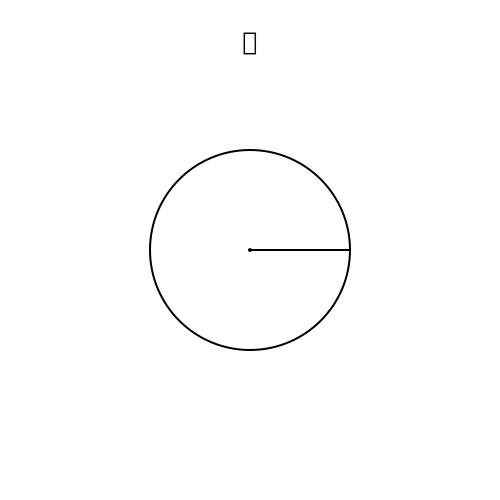

요청한 문장: 37° 각도를 그려줘
추출된 개념: 각도
추출된 인자: {'size': 37}

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
    <!-- 기준선 -->
    <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="333" x2="324.6588775118232" y2="182.54624421198793" stroke="black" stroke-width="2" />
    <!-- 각도 호 -->
    <path d="M 164.93177550236464,302.9092488423976 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>
    </svg>
    

생성된 설명:
 ### 각도에 대한 설명

**정의:**
각도는 두 직선이나 선분이 만나서 생기는 공간의 크기를 측정하는 방법입니다. 우리가 일상에서 자주 접하는 각도는 주로 도로 표지판에서 볼 수 있는 방향 지시나, 그림에서 선들이 만나는 부분을 표현할 때 사용됩니다.

**기본 성질:**
1. **직선의 각도:** 직선은 정확히 180도의 각도를 가집니다. 직선은 두 방향으로 무한히 이어지는 것처럼 보이지만, 실제로는 시작점과 끝점이 있습니다.
   
2. **직각 각도:** 직각은 90도를 의미합니다. 이는 우리가 흔히 사용하는 'L'자 모양의 모서리나 사각형의 모서리에서 볼 수 있습니다. 직각은 두 직선이 서로 수직으로 만나는 경우에 생깁니다.

3. **평행선과 각도:** 평행한 두 직선은 만나지 않기 때문에, 그들 사이의 각도는

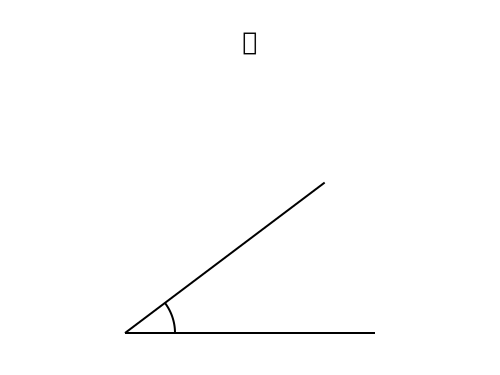

요청한 문장: 직각을 표현해줘
추출된 개념: Right Angle
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
    <!-- 기준선 -->
    <line x1="125" y1="400" x2="458" y2="400" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="400" x2="125" y2="67" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="175" y1="400" x2="175" y2="350" stroke="black" stroke-width="2" />
    <line x1="125" y1="350" x2="175" y2="350" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Angle

**정의:**
Right Angle은 기하학에서 가장 기본적인 각도 중 하나로, 정확히 90도를 이루는 각도를 말합니다. 이 각도는 직각이라고도 불리며, 직선이나 특정 도형의 모서리에서 만나는 두 변이 서로 수직으로 만나는 경우에 나타납니다.

**기본 성질:**
1. **크기:** Right Angle은 항상 정확히 90도입니다. 이는 모든 Right Angle이 동일한 크기를 가짐을 의미합니다.
2. **모양:** Right Angle은 보통 'L' 모양으로 쉽게 인식할 수 있습니다. 이 모양은 직각을 나타내는 데 자주 사용됩니다.
3. **도형과의 관계:** 직각은 사각형, 직사각형, 정사각형 등 다양한 도형의 모서리에서 발견됩니다. 특히, 직사각형이나 정사각형은 네 개

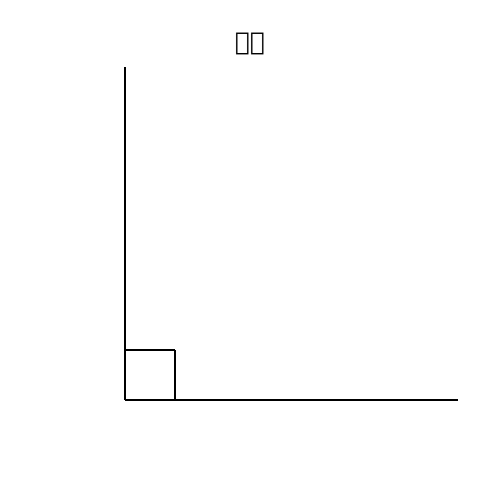

요청한 문장: 밑변이 3이고, 높이가 4인 직각삼각형 하나를 그려줘
추출된 개념: Right Triangle
추출된 인자: {'base': 3, 'height': 4}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <line x1="83" y1="416" x2="308" y2="416" stroke="black" stroke-width="2" />
    <line x1="308" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <line x1="83" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="286" y1="416" x2="286" y2="394" stroke="black" stroke-width="2" />
    <line x1="286" y1="394" x2="308" y2="394" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Triangle

**정의:**
A right triangle is a special type of triangle that has one angle which measures exactly 90 degrees (a right angle). This unique angle distinguishes it from other triangles where all angles are less than 90 degrees.

**기본 성질:**
1. **한 각이 직각:** 가장 중요한 특징은 한 꼭짓점

<IPython.core.display.Math object>

<IPython.core.display.Math object>

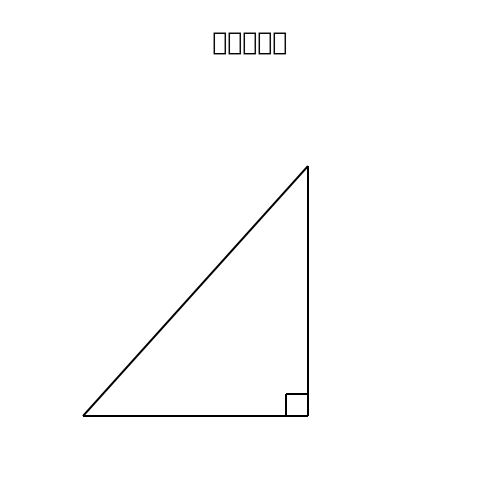

요청한 문장: 가로가 5, 세로가 3인 직사각형의 넓이
추출된 개념: Rectangle
추출된 인자: {'width': 5, 'height': 3}

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="250" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Rectangle 설명

**정의:**
사각형은 네 개의 직선으로 둘러싸인 평면 도형으로, 각 내각이 직각(90도)인 특징을 가지고 있습니다. 즉, 사각형의 네 모서리는 모두 직각을 이루며, 대변이 평행하고 길이가 같은 특성을 갖습니다.

**기본 성질:**
1. **대변의 길이가 같음:** 사각형의 두 쌍의 대변은 길이가 동일합니다. 예를 들어, 가로와 세로가 같은 길이를 가집니다.
2. **대각선이 서로 같음:** 사각형의 두 대각선은 길이가 같습니다. 즉, 사각형을 두 개의 동일한 삼각형으로 나눌 수 있습니다.
3. **내각의 합:** 사각형의 네 내각의 합은 항상 360도입니다.
4. **변의 배열:** 사각형은 여러 가지 형태로 배열될 수 있습니다. 예를 들어, 직사각형은 가로와 세로가 각각 다른 길이를 가질 수 있으며, 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 형태의 사각형입니다.

이러한 성질들로 인해 사각형은 우리 일상생활에서 매우 흔하게 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '2 × (밑변 + 높이)', 'area': '밑변 × 높이'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

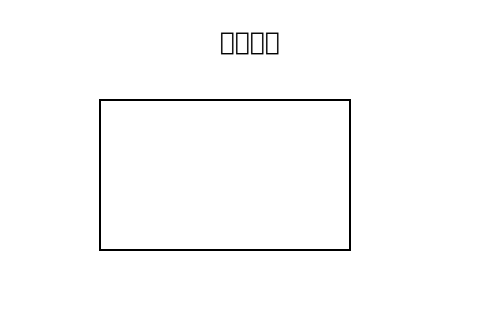

요청한 문장: 한 변의 길이가 2인 정사각형 하나를 그려줘
추출된 개념: Square
추출된 인자: {'length': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="200" height="200" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Square

**정의:**
사각형은 네 개의 변으로 이루어진 평면 도형입니다. 모든 내각이 직각(90도)이며, 반대편의 변들이 길이가 같아서 마주보는 두 변은 평행하고 길이가 동일합니다.

**기본 성질:**
1. **대변의 길이 동일:** 사각형의 마주보는 두 변은 길이가 같습니다. 예를 들어, 정사각형이나 직사각형에서는 모든 대변이 같은 길이를 가집니다.
2. **대각선의 성질:** 사각형의 대각선은 서로를 반으로 나눕니다. 즉, 대각선이 만나는 점에서 대각선을 잇는 선분들은 서로를 절반으로 나눕니다.
3. **변의 합:** 사각형의 네 변의 길이를 모두 더하면, 그 합은 사각형의 둘레를 나타냅니다. 예를 들어, 한 변의 길이가 \(a\)이고 다른 변의 길이가 \(b\)라면, 둘레는 \(a + b + a + b = 2(a + b)\)가 됩니다.
4. **정사각형의 특징:** 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 사각형입니다. 모든 대각선도 길이가 같고 서로를 직각으로 이룹니다.

이러한 성질들로 인해 사각형은 다양한 형태와 크기로 존재하며, 건축, 디자인, 그리고 일상생활에서 자주 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '4 \\times \\mathrm{한 변의 길이}', 'area': '\\m

<IPython.core.display.Math object>

<IPython.core.display.Math object>

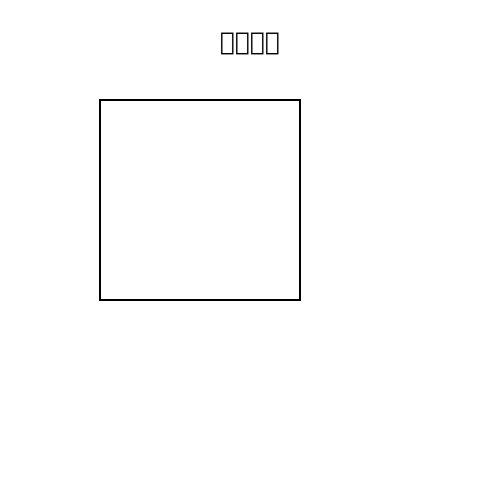

요청한 문장: 곧은선이 뭐야?
추출된 개념: 직선
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="75" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="175" font-size="25" text-anchor="middle">반직선</text>
    <circle cx="125" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="250" x2="500" y2="250" stroke="black" stroke-width="2" />
    <!-- 직선 -->
    <text x="250" y="300" font-size="25" text-anchor="middle">직선</text>
    <circle cx="125" cy="375" r="1" stroke="black"

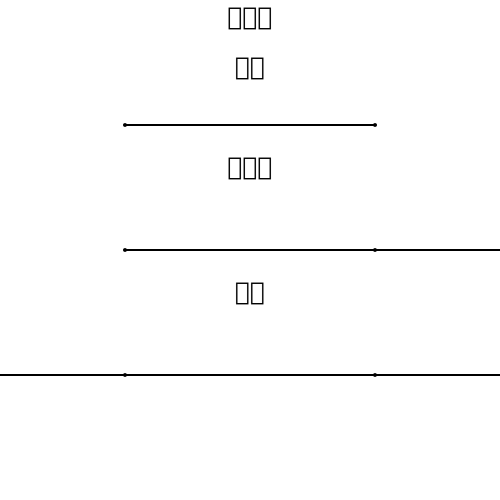

요청한 문장: 대표적인 굽은선을 그려줘
추출된 개념: 곡선
추출된 인자: {'type': '타원', 'description': '타원은 가장 대표적인 굽은선의 한 종류로, 두 초점 사이의 거리의 합이 일정한 점들의 집합으로 정의됩니다.'}

생성된 코드:
 
    <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">굽은선</text>
    <!-- 복잡한 S자 곡선 (두 개의 Cubic Bézier) -->
    <path d="M 100,400
    C 100,100 400,100 400,250
    C 400,400 100,400 100,100"
    stroke="black" fill="none" stroke-width="2"/>
    </svg>
    

생성된 설명:
 ### 곡선에 대한 설명

**정의:**
곡선은 직선이 아닌, 연속적으로 이어지는 점들의 모임으로 이루어진 도형입니다. 쉽게 말해, 직선처럼 일정한 방향으로만 움직이는 것이 아니라, 부드럽게 휘어지거나 굽어지는 형태를 가진 선을 말합니다.

**기본 성질:**
1. **연속성:** 곡선 위의 모든 점들은 부드럽게 이어져 있어, 어떤 작은 구간에서도 끊어지지 않고 이어집니다.
2. **길이:** 곡선의 길이는 그 곡선을 따라 측정한 총 거리입니다. 이 길이는 곡선의 모양에 따라 달라집니다. 예를 들어, 원의 둘레는 반지름에 따라 결정되며, 이는 곡선의 길이를 정확히 계산하는 방법 중 하나입니다.
3. **곡률:** 곡선이 얼마나 빠르게 방향을 바꾸는지를 나타내는 값입니다. 곡률이 크면 곡선이 더 급하게 굽어지고, 작으면 더 부드럽게 굽어집니다. 예를 들어, 원의 경우 모든 점에서 곡률이 일정합니다.
4. **접선:** 곡선 위의 어떤 점에서 그 점을 지나는 가장 가까운 직선을 접선이라고 합니다. 이 접

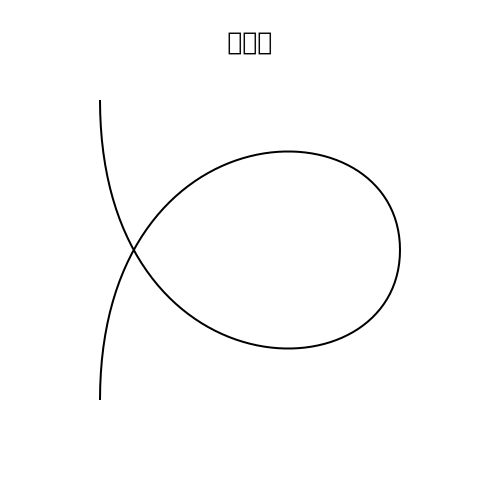

요청한 문장: 중심이 (0,0)이고 반지름이 2인 원을 그려주세요.
추출된 개념: Circle
추출된 인자: {'radius': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="100" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="250" y1="250" x2="350" y2="250" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Circle (원)

#### 정의:
원은 평면 위에서 한 점(중심)으로부터 일정한 거리(반지름)에 있는 모든 점들의 집합을 말합니다. 이 중심점을 기준으로 원 위의 모든 점들은 동일한 거리에 위치해 있습니다.

#### 기본 성질:
1. **둘레와 지름**: 원의 둘레는 지름에 π(약 3.14)를 곱한 값입니다. 즉, 둘레 = 지름 × π 입니다. 반대로 지름은 둘레를 π로 나누면 구할 수 있습니다.
   
2. **면적**: 원의 면적은 반지름의 제곱에 π를 곱한 값입니다. 공식으로 표현하면 면적 = π × 반지름2 입니다.

3. **대칭성**: 원은 중심을 기준으로 완벽하게 대칭입니다. 즉, 중심을 지나는 어떤 직선을 기준으로 원을 접어도 양쪽이 완전히 일치합니다.

4. **원주각과 호의 관계**: 원 위의 두 점을 잇는 호의 중앙각은 그 호에 대응하는 원주각의 두 배입니다. 예를 들어, 호의 중앙각이 θ라면 원주각은 θ/2가 됩니다.

이러한 성질들로 인해 원은 기하학에

<IPython.core.display.Math object>

<IPython.core.display.Math object>

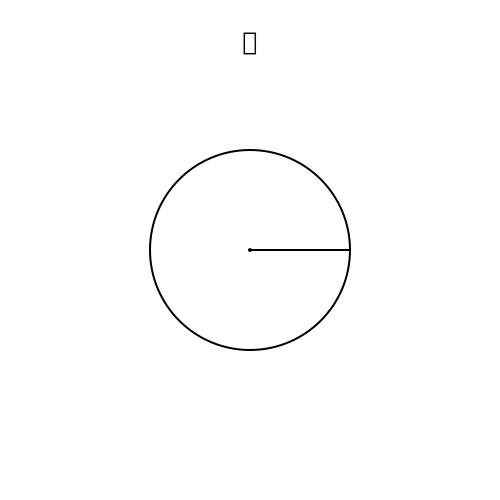

요청한 문장: 37° 각도를 그려줘
추출된 개념: 각도
추출된 인자: {'size': 37}

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
    <!-- 기준선 -->
    <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="333" x2="324.6588775118232" y2="182.54624421198793" stroke="black" stroke-width="2" />
    <!-- 각도 호 -->
    <path d="M 164.93177550236464,302.9092488423976 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>
    </svg>
    

생성된 설명:
 ### 각도에 대한 설명

**정의:**
각도는 두 직선이나 선분이 만나서 생기는 공간의 크기를 측정하는 방법입니다. 우리가 일상에서 자주 접하는 각도는 주로 도로 표지판에서 볼 수 있는 방향 지시나, 그림에서 선들이 만나는 부분을 표현할 때 사용됩니다.

**기본 성질:**
1. **직선의 각도:** 직선은 정확히 180도의 각도를 가집니다. 직선은 두 방향으로 무한히 이어지는 것처럼 보이지만, 실제로는 시작점과 끝점이 있습니다.
   
2. **직각 각도:** 직각은 90도를 의미합니다. 이는 우리가 흔히 사용하는 'L'자 모양의 모서리나 사각형의 모서리에서 볼 수 있습니다. 직각은 두 직선이 서로 수직으로 만나는 경우에 생깁니다.

3. **평행선과 각도:** 평행한 두 직선은 만나지 않기 때문에, 그들 사이의 각도는

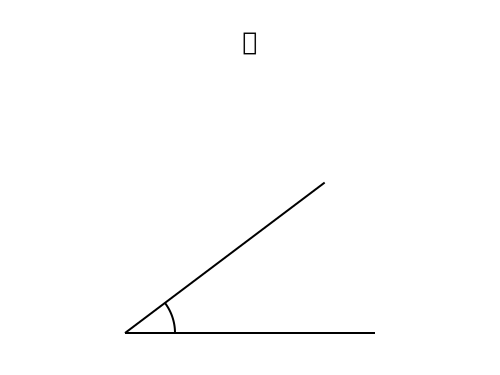

요청한 문장: 직각을 표현해줘
추출된 개념: Right Angle
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
    <!-- 기준선 -->
    <line x1="125" y1="400" x2="458" y2="400" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="400" x2="125" y2="67" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="175" y1="400" x2="175" y2="350" stroke="black" stroke-width="2" />
    <line x1="125" y1="350" x2="175" y2="350" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Angle

**정의:**
Right Angle은 기하학에서 가장 기본적인 각도 중 하나로, 정확히 90도를 이루는 각도를 말합니다. 이 각도는 직각이라고도 불리며, 직선이나 특정 도형의 모서리에서 만나는 두 변이 서로 수직으로 만나는 경우에 나타납니다.

**기본 성질:**
1. **크기:** Right Angle은 항상 정확히 90도입니다. 이는 모든 Right Angle이 동일한 크기를 가짐을 의미합니다.
2. **모양:** Right Angle은 보통 'L' 모양으로 쉽게 인식할 수 있습니다. 이 모양은 직각을 나타내는 데 자주 사용됩니다.
3. **도형과의 관계:** 직각은 사각형, 직사각형, 정사각형 등 다양한 도형의 모서리에서 발견됩니다. 특히, 직사각형이나 정사각형은 네 개

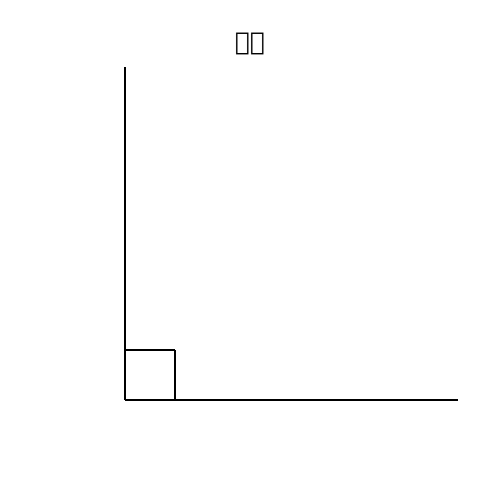

요청한 문장: 밑변이 3이고, 높이가 4인 직각삼각형 하나를 그려줘
추출된 개념: Right Triangle
추출된 인자: {'base': 3, 'height': 4}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <line x1="83" y1="416" x2="308" y2="416" stroke="black" stroke-width="2" />
    <line x1="308" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <line x1="83" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="286" y1="416" x2="286" y2="394" stroke="black" stroke-width="2" />
    <line x1="286" y1="394" x2="308" y2="394" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Triangle

**정의:**
A right triangle is a special type of triangle that has one angle which measures exactly 90 degrees (a right angle). This unique angle distinguishes it from other triangles where all angles are less than 90 degrees.

**기본 성질:**
1. **한 각이 직각:** 가장 중요한 특징은 한 꼭짓점

<IPython.core.display.Math object>

<IPython.core.display.Math object>

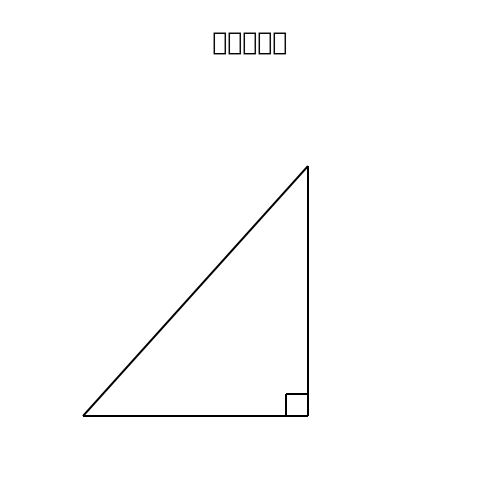

요청한 문장: 가로가 5, 세로가 3인 직사각형의 넓이
추출된 개념: Rectangle
추출된 인자: {'width': 5, 'height': 3}

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="250" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Rectangle 설명

**정의:**
사각형은 네 개의 직선으로 둘러싸인 평면 도형으로, 각 내각이 직각(90도)인 특징을 가지고 있습니다. 즉, 사각형의 네 모서리는 모두 직각을 이루며, 대변이 평행하고 길이가 같은 특성을 갖습니다.

**기본 성질:**
1. **대변의 길이가 같음:** 사각형의 두 쌍의 대변은 길이가 동일합니다. 예를 들어, 가로와 세로가 같은 길이를 가집니다.
2. **대각선이 서로 같음:** 사각형의 두 대각선은 길이가 같습니다. 즉, 사각형을 두 개의 동일한 삼각형으로 나눌 수 있습니다.
3. **내각의 합:** 사각형의 네 내각의 합은 항상 360도입니다.
4. **변의 배열:** 사각형은 여러 가지 형태로 배열될 수 있습니다. 예를 들어, 직사각형은 가로와 세로가 각각 다른 길이를 가질 수 있으며, 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 형태의 사각형입니다.

이러한 성질들로 인해 사각형은 우리 일상생활에서 매우 흔하게 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '2 × (밑변 + 높이)', 'area': '밑변 × 높이'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

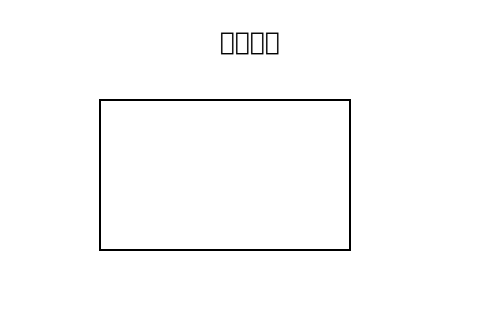

요청한 문장: 한 변의 길이가 2인 정사각형 하나를 그려줘
추출된 개념: Square
추출된 인자: {'length': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="200" height="200" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Square

**정의:**
사각형은 네 개의 변으로 이루어진 평면 도형입니다. 모든 내각이 직각(90도)이며, 반대편의 변들이 길이가 같아서 마주보는 두 변은 평행하고 길이가 동일합니다.

**기본 성질:**
1. **대변의 길이 동일:** 사각형의 마주보는 두 변은 길이가 같습니다. 예를 들어, 정사각형이나 직사각형에서는 모든 대변이 같은 길이를 가집니다.
2. **대각선의 성질:** 사각형의 대각선은 서로를 반으로 나눕니다. 즉, 대각선이 만나는 점에서 대각선을 잇는 선분들은 서로를 절반으로 나눕니다.
3. **변의 합:** 사각형의 네 변의 길이를 모두 더하면, 그 합은 사각형의 둘레를 나타냅니다. 예를 들어, 한 변의 길이가 \(a\)이고 다른 변의 길이가 \(b\)라면, 둘레는 \(a + b + a + b = 2(a + b)\)가 됩니다.
4. **정사각형의 특징:** 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 사각형입니다. 모든 대각선도 길이가 같고 서로를 직각으로 이룹니다.

이러한 성질들로 인해 사각형은 다양한 형태와 크기로 존재하며, 건축, 디자인, 그리고 일상생활에서 자주 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '4 \\times \\mathrm{한 변의 길이}', 'area': '\\m

<IPython.core.display.Math object>

<IPython.core.display.Math object>

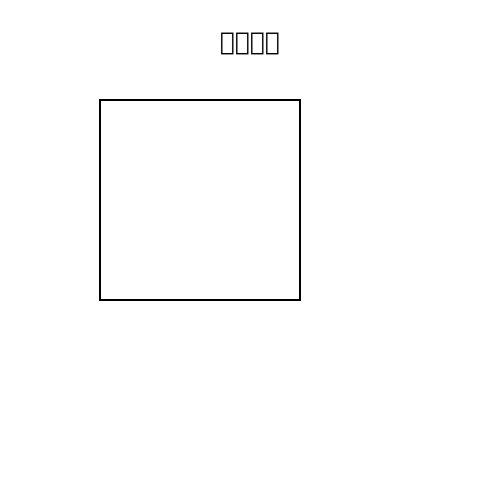

요청한 문장: 곧은선이 뭐야?
추출된 개념: 직선
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="75" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="175" font-size="25" text-anchor="middle">반직선</text>
    <circle cx="125" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="250" x2="500" y2="250" stroke="black" stroke-width="2" />
    <!-- 직선 -->
    <text x="250" y="300" font-size="25" text-anchor="middle">직선</text>
    <circle cx="125" cy="375" r="1" stroke="black"

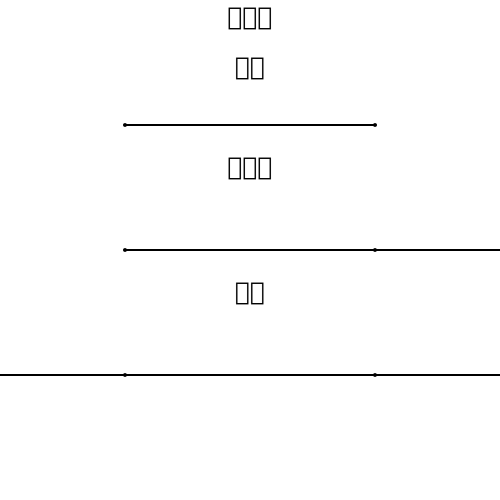

요청한 문장: 대표적인 굽은선을 그려줘
추출된 개념: 곡선
추출된 인자: {'type': '타원', 'description': '타원은 가장 대표적인 굽은선의 한 종류로, 두 초점 사이의 거리의 합이 일정한 점들의 집합으로 정의됩니다.'}

생성된 코드:
 
    <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">굽은선</text>
    <!-- 복잡한 S자 곡선 (두 개의 Cubic Bézier) -->
    <path d="M 100,400
    C 100,100 400,100 400,250
    C 400,400 100,400 100,100"
    stroke="black" fill="none" stroke-width="2"/>
    </svg>
    

생성된 설명:
 ### 곡선에 대한 설명

**정의:**
곡선은 직선이 아닌, 연속적으로 이어지는 점들의 모임으로 이루어진 도형입니다. 쉽게 말해, 직선처럼 일정한 방향으로만 움직이는 것이 아니라, 부드럽게 휘어지거나 굽어지는 형태를 가진 선을 말합니다.

**기본 성질:**
1. **연속성:** 곡선 위의 모든 점들은 부드럽게 이어져 있어, 어떤 작은 구간에서도 끊어지지 않고 이어집니다.
2. **길이:** 곡선의 길이는 그 곡선을 따라 측정한 총 거리입니다. 이 길이는 곡선의 모양에 따라 달라집니다. 예를 들어, 원의 둘레는 반지름에 따라 결정되며, 이는 곡선의 길이를 정확히 계산하는 방법 중 하나입니다.
3. **곡률:** 곡선이 얼마나 빠르게 방향을 바꾸는지를 나타내는 값입니다. 곡률이 크면 곡선이 더 급하게 굽어지고, 작으면 더 부드럽게 굽어집니다. 예를 들어, 원의 경우 모든 점에서 곡률이 일정합니다.
4. **접선:** 곡선 위의 어떤 점에서 그 점을 지나는 가장 가까운 직선을 접선이라고 합니다. 이 접

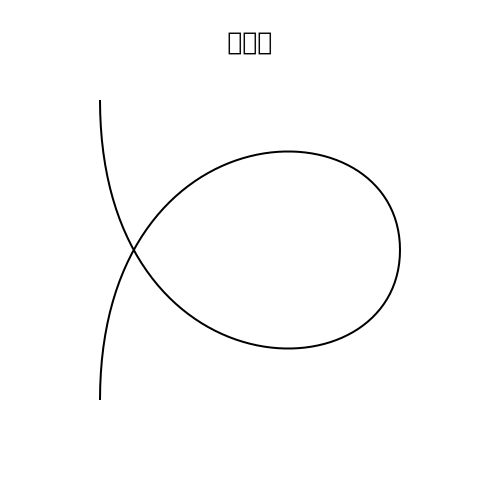

요청한 문장: 중심이 (0,0)이고 반지름이 2인 원을 그려주세요.
추출된 개념: Circle
추출된 인자: {'radius': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="100" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="250" y1="250" x2="350" y2="250" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Circle (원)

#### 정의:
원은 평면 위에서 한 점(중심)으로부터 일정한 거리(반지름)에 있는 모든 점들의 집합을 말합니다. 이 중심점을 기준으로 원 위의 모든 점들은 동일한 거리에 위치해 있습니다.

#### 기본 성질:
1. **둘레와 지름**: 원의 둘레는 지름에 π(약 3.14)를 곱한 값입니다. 즉, 둘레 = 지름 × π 입니다. 반대로 지름은 둘레를 π로 나누면 구할 수 있습니다.
   
2. **면적**: 원의 면적은 반지름의 제곱에 π를 곱한 값입니다. 공식으로 표현하면 면적 = π × 반지름2 입니다.

3. **대칭성**: 원은 중심을 기준으로 완벽하게 대칭입니다. 즉, 중심을 지나는 어떤 직선을 기준으로 원을 접어도 양쪽이 완전히 일치합니다.

4. **원주각과 호의 관계**: 원 위의 두 점을 잇는 호의 중앙각은 그 호에 대응하는 원주각의 두 배입니다. 예를 들어, 호의 중앙각이 θ라면 원주각은 θ/2가 됩니다.

이러한 성질들로 인해 원은 기하학에

<IPython.core.display.Math object>

<IPython.core.display.Math object>

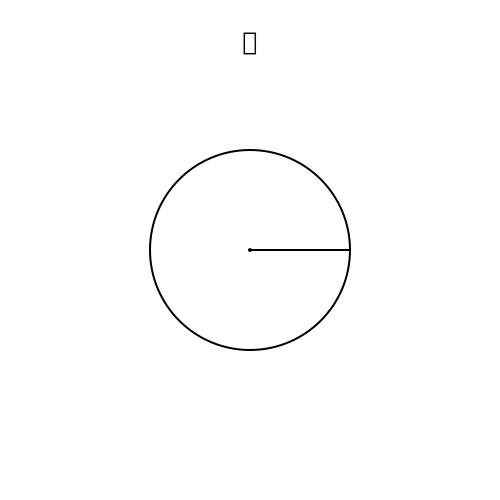

요청한 문장: 37° 각도를 그려줘
추출된 개념: 각도
추출된 인자: {'size': 37}

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
    <!-- 기준선 -->
    <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="333" x2="324.6588775118232" y2="182.54624421198793" stroke="black" stroke-width="2" />
    <!-- 각도 호 -->
    <path d="M 164.93177550236464,302.9092488423976 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>
    </svg>
    

생성된 설명:
 ### 각도에 대한 설명

**정의:**
각도는 두 직선이나 선분이 만나서 생기는 공간의 크기를 측정하는 방법입니다. 우리가 일상에서 자주 접하는 각도는 주로 도로 표지판에서 볼 수 있는 방향 지시나, 그림에서 선들이 만나는 부분을 표현할 때 사용됩니다.

**기본 성질:**
1. **직선의 각도:** 직선은 정확히 180도의 각도를 가집니다. 직선은 두 방향으로 무한히 이어지는 것처럼 보이지만, 실제로는 시작점과 끝점이 있습니다.
   
2. **직각 각도:** 직각은 90도를 의미합니다. 이는 우리가 흔히 사용하는 'L'자 모양의 모서리나 사각형의 모서리에서 볼 수 있습니다. 직각은 두 직선이 서로 수직으로 만나는 경우에 생깁니다.

3. **평행선과 각도:** 평행한 두 직선은 만나지 않기 때문에, 그들 사이의 각도는

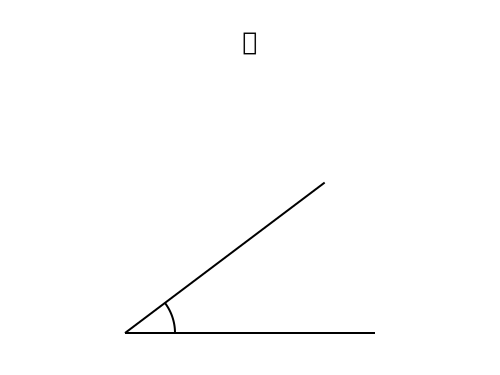

요청한 문장: 직각을 표현해줘
추출된 개념: Right Angle
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
    <!-- 기준선 -->
    <line x1="125" y1="400" x2="458" y2="400" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="400" x2="125" y2="67" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="175" y1="400" x2="175" y2="350" stroke="black" stroke-width="2" />
    <line x1="125" y1="350" x2="175" y2="350" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Angle

**정의:**
Right Angle은 기하학에서 가장 기본적인 각도 중 하나로, 정확히 90도를 이루는 각도를 말합니다. 이 각도는 직각이라고도 불리며, 직선이나 특정 도형의 모서리에서 만나는 두 변이 서로 수직으로 만나는 경우에 나타납니다.

**기본 성질:**
1. **크기:** Right Angle은 항상 정확히 90도입니다. 이는 모든 Right Angle이 동일한 크기를 가짐을 의미합니다.
2. **모양:** Right Angle은 보통 'L' 모양으로 쉽게 인식할 수 있습니다. 이 모양은 직각을 나타내는 데 자주 사용됩니다.
3. **도형과의 관계:** 직각은 사각형, 직사각형, 정사각형 등 다양한 도형의 모서리에서 발견됩니다. 특히, 직사각형이나 정사각형은 네 개

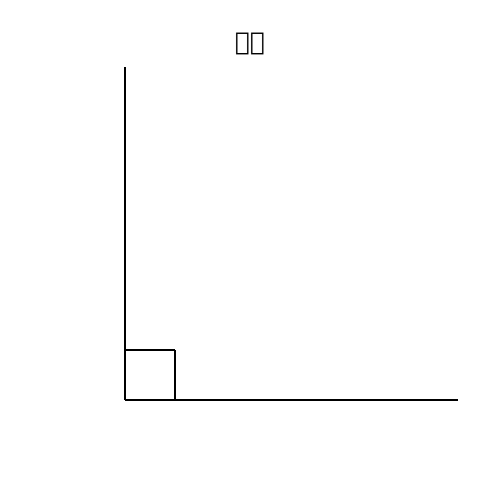

요청한 문장: 밑변이 3이고, 높이가 4인 직각삼각형 하나를 그려줘
추출된 개념: Right Triangle
추출된 인자: {'base': 3, 'height': 4}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <line x1="83" y1="416" x2="308" y2="416" stroke="black" stroke-width="2" />
    <line x1="308" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <line x1="83" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="286" y1="416" x2="286" y2="394" stroke="black" stroke-width="2" />
    <line x1="286" y1="394" x2="308" y2="394" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Triangle

**정의:**
A right triangle is a special type of triangle that has one angle which measures exactly 90 degrees (a right angle). This unique angle distinguishes it from other triangles where all angles are less than 90 degrees.

**기본 성질:**
1. **한 각이 직각:** 가장 중요한 특징은 한 꼭짓점

<IPython.core.display.Math object>

<IPython.core.display.Math object>

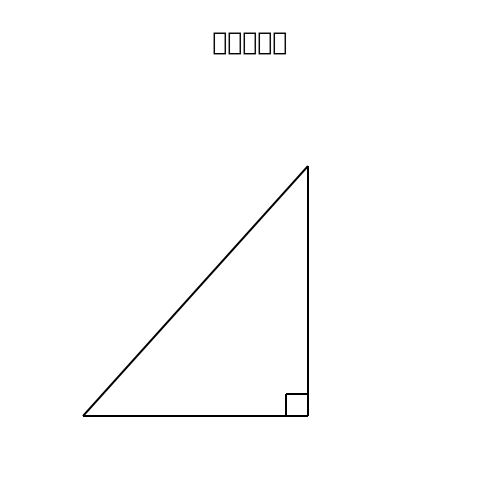

요청한 문장: 가로가 5, 세로가 3인 직사각형의 넓이
추출된 개념: Rectangle
추출된 인자: {'width': 5, 'height': 3}

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="250" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Rectangle 설명

**정의:**
사각형은 네 개의 직선으로 둘러싸인 평면 도형으로, 각 내각이 직각(90도)인 특징을 가지고 있습니다. 즉, 사각형의 네 모서리는 모두 직각을 이루며, 대변이 평행하고 길이가 같은 특성을 갖습니다.

**기본 성질:**
1. **대변의 길이가 같음:** 사각형의 두 쌍의 대변은 길이가 동일합니다. 예를 들어, 가로와 세로가 같은 길이를 가집니다.
2. **대각선이 서로 같음:** 사각형의 두 대각선은 길이가 같습니다. 즉, 사각형을 두 개의 동일한 삼각형으로 나눌 수 있습니다.
3. **내각의 합:** 사각형의 네 내각의 합은 항상 360도입니다.
4. **변의 배열:** 사각형은 여러 가지 형태로 배열될 수 있습니다. 예를 들어, 직사각형은 가로와 세로가 각각 다른 길이를 가질 수 있으며, 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 형태의 사각형입니다.

이러한 성질들로 인해 사각형은 우리 일상생활에서 매우 흔하게 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '2 × (밑변 + 높이)', 'area': '밑변 × 높이'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

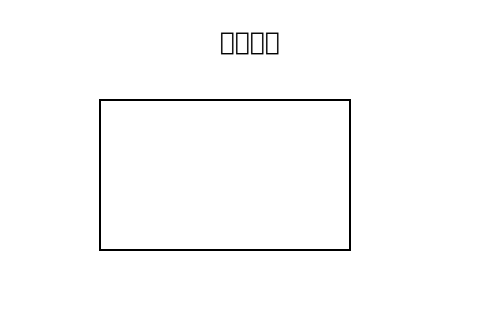

요청한 문장: 한 변의 길이가 2인 정사각형 하나를 그려줘
추출된 개념: Square
추출된 인자: {'length': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="200" height="200" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Square

**정의:**
사각형은 네 개의 변으로 이루어진 평면 도형입니다. 모든 내각이 직각(90도)이며, 반대편의 변들이 길이가 같아서 마주보는 두 변은 평행하고 길이가 동일합니다.

**기본 성질:**
1. **대변의 길이 동일:** 사각형의 마주보는 두 변은 길이가 같습니다. 예를 들어, 정사각형이나 직사각형에서는 모든 대변이 같은 길이를 가집니다.
2. **대각선의 성질:** 사각형의 대각선은 서로를 반으로 나눕니다. 즉, 대각선이 만나는 점에서 대각선을 잇는 선분들은 서로를 절반으로 나눕니다.
3. **변의 합:** 사각형의 네 변의 길이를 모두 더하면, 그 합은 사각형의 둘레를 나타냅니다. 예를 들어, 한 변의 길이가 \(a\)이고 다른 변의 길이가 \(b\)라면, 둘레는 \(a + b + a + b = 2(a + b)\)가 됩니다.
4. **정사각형의 특징:** 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 사각형입니다. 모든 대각선도 길이가 같고 서로를 직각으로 이룹니다.

이러한 성질들로 인해 사각형은 다양한 형태와 크기로 존재하며, 건축, 디자인, 그리고 일상생활에서 자주 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '4 \\times \\mathrm{한 변의 길이}', 'area': '\\m

<IPython.core.display.Math object>

<IPython.core.display.Math object>

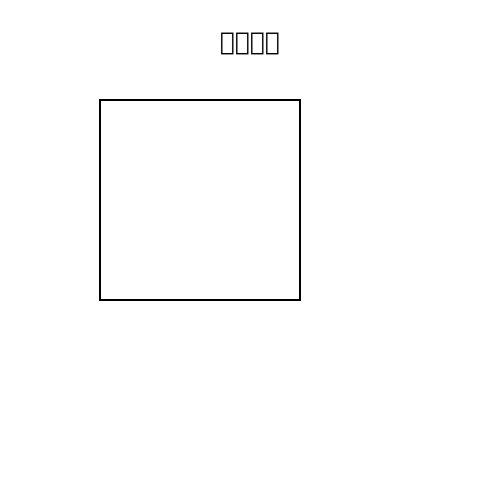

요청한 문장: 곧은선이 뭐야?
추출된 개념: 직선
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="75" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="175" font-size="25" text-anchor="middle">반직선</text>
    <circle cx="125" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="250" x2="500" y2="250" stroke="black" stroke-width="2" />
    <!-- 직선 -->
    <text x="250" y="300" font-size="25" text-anchor="middle">직선</text>
    <circle cx="125" cy="375" r="1" stroke="black"

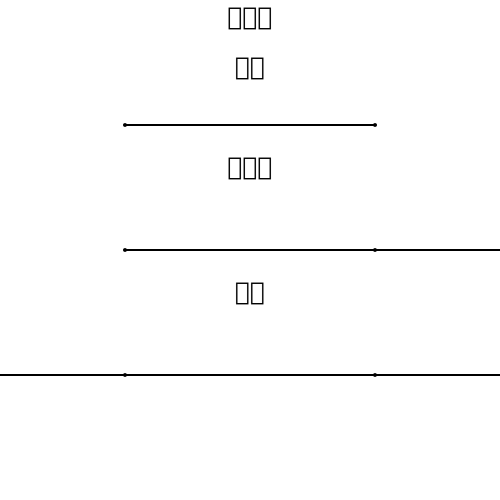

요청한 문장: 대표적인 굽은선을 그려줘
추출된 개념: 곡선
추출된 인자: {'type': '타원', 'description': '타원은 가장 대표적인 굽은선의 한 종류로, 두 초점 사이의 거리의 합이 일정한 점들의 집합으로 정의됩니다.'}

생성된 코드:
 
    <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">굽은선</text>
    <!-- 복잡한 S자 곡선 (두 개의 Cubic Bézier) -->
    <path d="M 100,400
    C 100,100 400,100 400,250
    C 400,400 100,400 100,100"
    stroke="black" fill="none" stroke-width="2"/>
    </svg>
    

생성된 설명:
 ### 곡선에 대한 설명

**정의:**
곡선은 직선이 아닌, 연속적으로 이어지는 점들의 모임으로 이루어진 도형입니다. 쉽게 말해, 직선처럼 일정한 방향으로만 움직이는 것이 아니라, 부드럽게 휘어지거나 굽어지는 형태를 가진 선을 말합니다.

**기본 성질:**
1. **연속성:** 곡선 위의 모든 점들은 부드럽게 이어져 있어, 어떤 작은 구간에서도 끊어지지 않고 이어집니다.
2. **길이:** 곡선의 길이는 그 곡선을 따라 측정한 총 거리입니다. 이 길이는 곡선의 모양에 따라 달라집니다. 예를 들어, 원의 둘레는 반지름에 따라 결정되며, 이는 곡선의 길이를 정확히 계산하는 방법 중 하나입니다.
3. **곡률:** 곡선이 얼마나 빠르게 방향을 바꾸는지를 나타내는 값입니다. 곡률이 크면 곡선이 더 급하게 굽어지고, 작으면 더 부드럽게 굽어집니다. 예를 들어, 원의 경우 모든 점에서 곡률이 일정합니다.
4. **접선:** 곡선 위의 어떤 점에서 그 점을 지나는 가장 가까운 직선을 접선이라고 합니다. 이 접

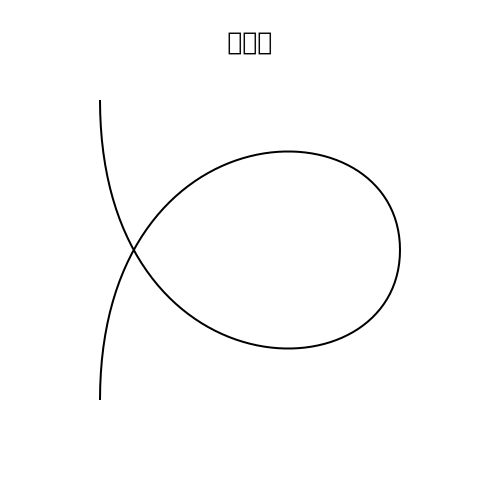

요청한 문장: 중심이 (0,0)이고 반지름이 2인 원을 그려주세요.
추출된 개념: Circle
추출된 인자: {'radius': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="100" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="250" y1="250" x2="350" y2="250" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Circle (원)

#### 정의:
원은 평면 위에서 한 점(중심)으로부터 일정한 거리(반지름)에 있는 모든 점들의 집합을 말합니다. 이 중심점을 기준으로 원 위의 모든 점들은 동일한 거리에 위치해 있습니다.

#### 기본 성질:
1. **둘레와 지름**: 원의 둘레는 지름에 π(약 3.14)를 곱한 값입니다. 즉, 둘레 = 지름 × π 입니다. 반대로 지름은 둘레를 π로 나누면 구할 수 있습니다.
   
2. **면적**: 원의 면적은 반지름의 제곱에 π를 곱한 값입니다. 공식으로 표현하면 면적 = π × 반지름2 입니다.

3. **대칭성**: 원은 중심을 기준으로 완벽하게 대칭입니다. 즉, 중심을 지나는 어떤 직선을 기준으로 원을 접어도 양쪽이 완전히 일치합니다.

4. **원주각과 호의 관계**: 원 위의 두 점을 잇는 호의 중앙각은 그 호에 대응하는 원주각의 두 배입니다. 예를 들어, 호의 중앙각이 θ라면 원주각은 θ/2가 됩니다.

이러한 성질들로 인해 원은 기하학에

<IPython.core.display.Math object>

<IPython.core.display.Math object>

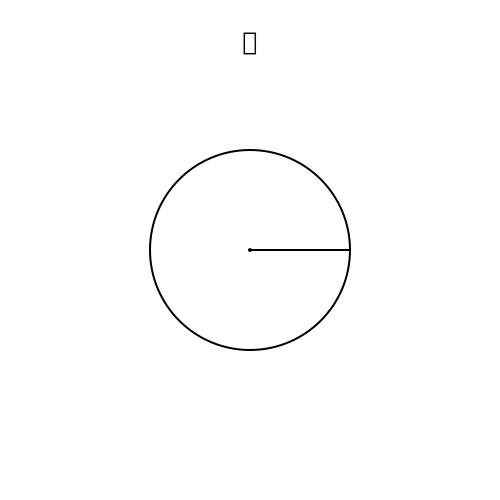

요청한 문장: 37° 각도를 그려줘
추출된 개념: 각도
추출된 인자: {'size': 37}

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
    <!-- 기준선 -->
    <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="333" x2="324.6588775118232" y2="182.54624421198793" stroke="black" stroke-width="2" />
    <!-- 각도 호 -->
    <path d="M 164.93177550236464,302.9092488423976 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>
    </svg>
    

생성된 설명:
 ### 각도에 대한 설명

**정의:**
각도는 두 직선이나 선분이 만나서 생기는 공간의 크기를 측정하는 방법입니다. 우리가 일상에서 자주 접하는 각도는 주로 도로 표지판에서 볼 수 있는 방향 지시나, 그림에서 선들이 만나는 부분을 표현할 때 사용됩니다.

**기본 성질:**
1. **직선의 각도:** 직선은 정확히 180도의 각도를 가집니다. 직선은 두 방향으로 무한히 이어지는 것처럼 보이지만, 실제로는 시작점과 끝점이 있습니다.
   
2. **직각 각도:** 직각은 90도를 의미합니다. 이는 우리가 흔히 사용하는 'L'자 모양의 모서리나 사각형의 모서리에서 볼 수 있습니다. 직각은 두 직선이 서로 수직으로 만나는 경우에 생깁니다.

3. **평행선과 각도:** 평행한 두 직선은 만나지 않기 때문에, 그들 사이의 각도는

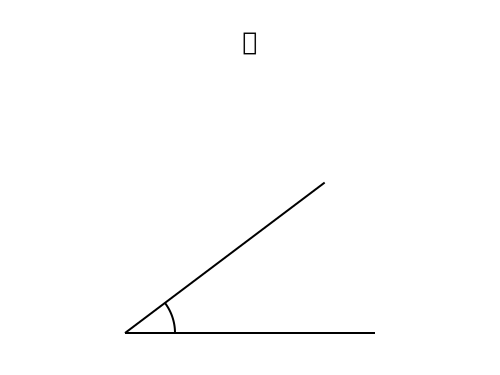

요청한 문장: 직각을 표현해줘
추출된 개념: Right Angle
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
    <!-- 기준선 -->
    <line x1="125" y1="400" x2="458" y2="400" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="400" x2="125" y2="67" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="175" y1="400" x2="175" y2="350" stroke="black" stroke-width="2" />
    <line x1="125" y1="350" x2="175" y2="350" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Angle

**정의:**
Right Angle은 기하학에서 가장 기본적인 각도 중 하나로, 정확히 90도를 이루는 각도를 말합니다. 이 각도는 직각이라고도 불리며, 직선이나 특정 도형의 모서리에서 만나는 두 변이 서로 수직으로 만나는 경우에 나타납니다.

**기본 성질:**
1. **크기:** Right Angle은 항상 정확히 90도입니다. 이는 모든 Right Angle이 동일한 크기를 가짐을 의미합니다.
2. **모양:** Right Angle은 보통 'L' 모양으로 쉽게 인식할 수 있습니다. 이 모양은 직각을 나타내는 데 자주 사용됩니다.
3. **도형과의 관계:** 직각은 사각형, 직사각형, 정사각형 등 다양한 도형의 모서리에서 발견됩니다. 특히, 직사각형이나 정사각형은 네 개

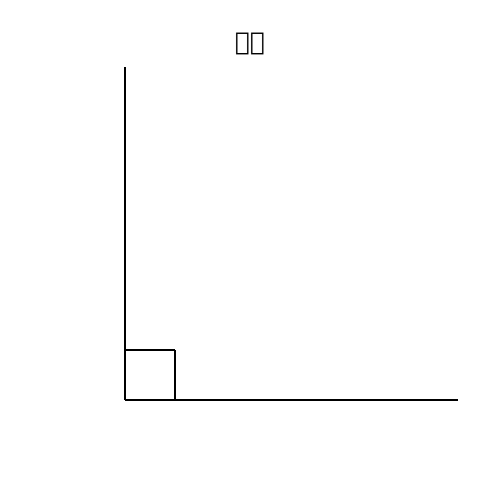

요청한 문장: 밑변이 3이고, 높이가 4인 직각삼각형 하나를 그려줘
추출된 개념: Right Triangle
추출된 인자: {'base': 3, 'height': 4}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <line x1="83" y1="416" x2="308" y2="416" stroke="black" stroke-width="2" />
    <line x1="308" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <line x1="83" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="286" y1="416" x2="286" y2="394" stroke="black" stroke-width="2" />
    <line x1="286" y1="394" x2="308" y2="394" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Triangle

**정의:**
A right triangle is a special type of triangle that has one angle which measures exactly 90 degrees (a right angle). This unique angle distinguishes it from other triangles where all angles are less than 90 degrees.

**기본 성질:**
1. **한 각이 직각:** 가장 중요한 특징은 한 꼭짓점

<IPython.core.display.Math object>

<IPython.core.display.Math object>

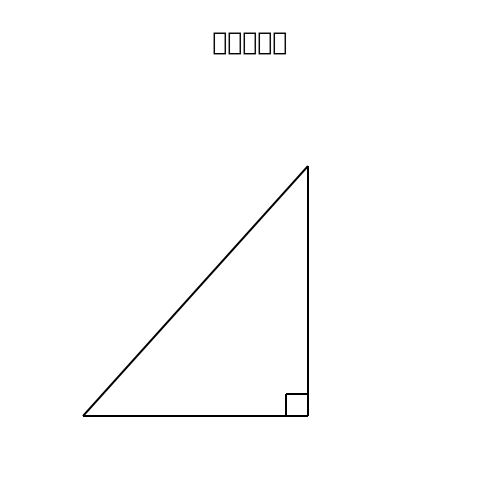

요청한 문장: 가로가 5, 세로가 3인 직사각형의 넓이
추출된 개념: Rectangle
추출된 인자: {'width': 5, 'height': 3}

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="250" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Rectangle 설명

**정의:**
사각형은 네 개의 직선으로 둘러싸인 평면 도형으로, 각 내각이 직각(90도)인 특징을 가지고 있습니다. 즉, 사각형의 네 모서리는 모두 직각을 이루며, 대변이 평행하고 길이가 같은 특성을 갖습니다.

**기본 성질:**
1. **대변의 길이가 같음:** 사각형의 두 쌍의 대변은 길이가 동일합니다. 예를 들어, 가로와 세로가 같은 길이를 가집니다.
2. **대각선이 서로 같음:** 사각형의 두 대각선은 길이가 같습니다. 즉, 사각형을 두 개의 동일한 삼각형으로 나눌 수 있습니다.
3. **내각의 합:** 사각형의 네 내각의 합은 항상 360도입니다.
4. **변의 배열:** 사각형은 여러 가지 형태로 배열될 수 있습니다. 예를 들어, 직사각형은 가로와 세로가 각각 다른 길이를 가질 수 있으며, 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 형태의 사각형입니다.

이러한 성질들로 인해 사각형은 우리 일상생활에서 매우 흔하게 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '2 × (밑변 + 높이)', 'area': '밑변 × 높이'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

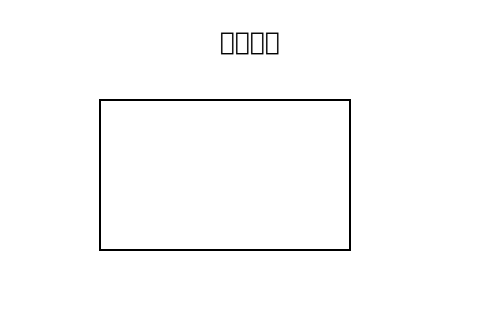

요청한 문장: 한 변의 길이가 2인 정사각형 하나를 그려줘
추출된 개념: Square
추출된 인자: {'length': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="200" height="200" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Square

**정의:**
사각형은 네 개의 변으로 이루어진 평면 도형입니다. 모든 내각이 직각(90도)이며, 반대편의 변들이 길이가 같아서 마주보는 두 변은 평행하고 길이가 동일합니다.

**기본 성질:**
1. **대변의 길이 동일:** 사각형의 마주보는 두 변은 길이가 같습니다. 예를 들어, 정사각형이나 직사각형에서는 모든 대변이 같은 길이를 가집니다.
2. **대각선의 성질:** 사각형의 대각선은 서로를 반으로 나눕니다. 즉, 대각선이 만나는 점에서 대각선을 잇는 선분들은 서로를 절반으로 나눕니다.
3. **변의 합:** 사각형의 네 변의 길이를 모두 더하면, 그 합은 사각형의 둘레를 나타냅니다. 예를 들어, 한 변의 길이가 \(a\)이고 다른 변의 길이가 \(b\)라면, 둘레는 \(a + b + a + b = 2(a + b)\)가 됩니다.
4. **정사각형의 특징:** 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 사각형입니다. 모든 대각선도 길이가 같고 서로를 직각으로 이룹니다.

이러한 성질들로 인해 사각형은 다양한 형태와 크기로 존재하며, 건축, 디자인, 그리고 일상생활에서 자주 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '4 \\times \\mathrm{한 변의 길이}', 'area': '\\m

<IPython.core.display.Math object>

<IPython.core.display.Math object>

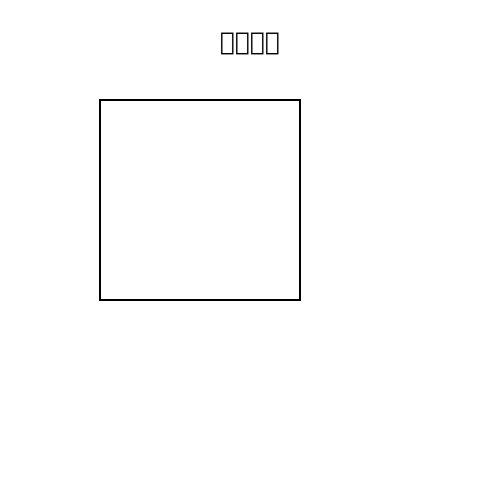

요청한 문장: 곧은선이 뭐야?
추출된 개념: 직선
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="75" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="175" font-size="25" text-anchor="middle">반직선</text>
    <circle cx="125" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="250" x2="500" y2="250" stroke="black" stroke-width="2" />
    <!-- 직선 -->
    <text x="250" y="300" font-size="25" text-anchor="middle">직선</text>
    <circle cx="125" cy="375" r="1" stroke="black"

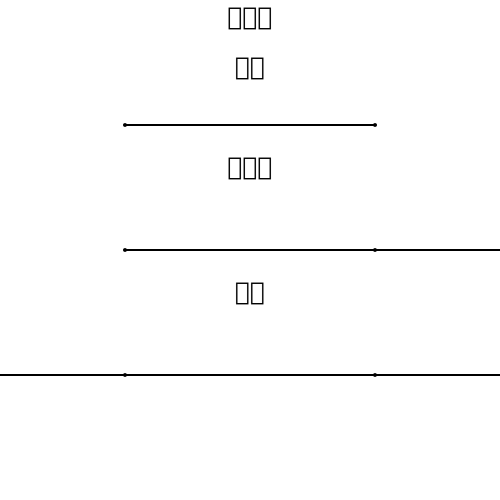

요청한 문장: 대표적인 굽은선을 그려줘
추출된 개념: 곡선
추출된 인자: {'type': '타원', 'description': '타원은 가장 대표적인 굽은선의 한 종류로, 두 초점 사이의 거리의 합이 일정한 점들의 집합으로 정의됩니다.'}

생성된 코드:
 
    <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">굽은선</text>
    <!-- 복잡한 S자 곡선 (두 개의 Cubic Bézier) -->
    <path d="M 100,400
    C 100,100 400,100 400,250
    C 400,400 100,400 100,100"
    stroke="black" fill="none" stroke-width="2"/>
    </svg>
    

생성된 설명:
 ### 곡선에 대한 설명

**정의:**
곡선은 직선이 아닌, 연속적으로 이어지는 점들의 모임으로 이루어진 도형입니다. 쉽게 말해, 직선처럼 일정한 방향으로만 움직이는 것이 아니라, 부드럽게 휘어지거나 굽어지는 형태를 가진 선을 말합니다.

**기본 성질:**
1. **연속성:** 곡선 위의 모든 점들은 부드럽게 이어져 있어, 어떤 작은 구간에서도 끊어지지 않고 이어집니다.
2. **길이:** 곡선의 길이는 그 곡선을 따라 측정한 총 거리입니다. 이 길이는 곡선의 모양에 따라 달라집니다. 예를 들어, 원의 둘레는 반지름에 따라 결정되며, 이는 곡선의 길이를 정확히 계산하는 방법 중 하나입니다.
3. **곡률:** 곡선이 얼마나 빠르게 방향을 바꾸는지를 나타내는 값입니다. 곡률이 크면 곡선이 더 급하게 굽어지고, 작으면 더 부드럽게 굽어집니다. 예를 들어, 원의 경우 모든 점에서 곡률이 일정합니다.
4. **접선:** 곡선 위의 어떤 점에서 그 점을 지나는 가장 가까운 직선을 접선이라고 합니다. 이 접

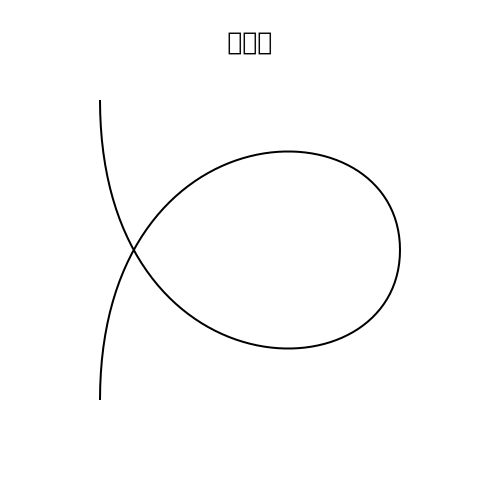

요청한 문장: 중심이 (0,0)이고 반지름이 2인 원을 그려주세요.
추출된 개념: Circle
추출된 인자: {'radius': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="100" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="250" y1="250" x2="350" y2="250" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Circle (원)

#### 정의:
원은 평면 위에서 한 점(중심)으로부터 일정한 거리(반지름)에 있는 모든 점들의 집합을 말합니다. 이 중심점을 기준으로 원 위의 모든 점들은 동일한 거리에 위치해 있습니다.

#### 기본 성질:
1. **둘레와 지름**: 원의 둘레는 지름에 π(약 3.14)를 곱한 값입니다. 즉, 둘레 = 지름 × π 입니다. 반대로 지름은 둘레를 π로 나누면 구할 수 있습니다.
   
2. **면적**: 원의 면적은 반지름의 제곱에 π를 곱한 값입니다. 공식으로 표현하면 면적 = π × 반지름2 입니다.

3. **대칭성**: 원은 중심을 기준으로 완벽하게 대칭입니다. 즉, 중심을 지나는 어떤 직선을 기준으로 원을 접어도 양쪽이 완전히 일치합니다.

4. **원주각과 호의 관계**: 원 위의 두 점을 잇는 호의 중앙각은 그 호에 대응하는 원주각의 두 배입니다. 예를 들어, 호의 중앙각이 θ라면 원주각은 θ/2가 됩니다.

이러한 성질들로 인해 원은 기하학에

<IPython.core.display.Math object>

<IPython.core.display.Math object>

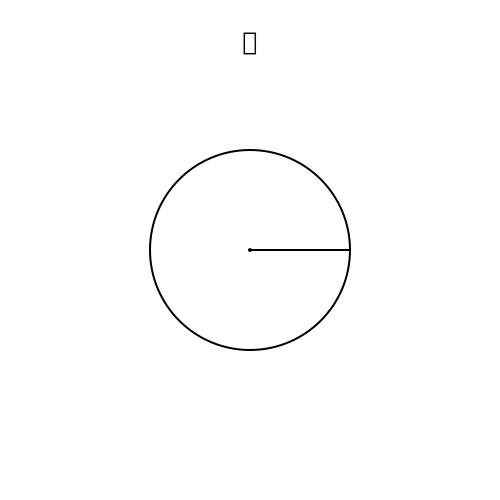

요청한 문장: 37° 각도를 그려줘
추출된 개념: 각도
추출된 인자: {'size': 37}

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
    <!-- 기준선 -->
    <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="333" x2="324.6588775118232" y2="182.54624421198793" stroke="black" stroke-width="2" />
    <!-- 각도 호 -->
    <path d="M 164.93177550236464,302.9092488423976 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>
    </svg>
    

생성된 설명:
 ### 각도에 대한 설명

**정의:**
각도는 두 직선이나 선분이 만나서 생기는 공간의 크기를 측정하는 방법입니다. 우리가 일상에서 자주 접하는 각도는 주로 도로 표지판에서 볼 수 있는 방향 지시나, 그림에서 선들이 만나는 부분을 표현할 때 사용됩니다.

**기본 성질:**
1. **직선의 각도:** 직선은 정확히 180도의 각도를 가집니다. 직선은 두 방향으로 무한히 이어지는 것처럼 보이지만, 실제로는 시작점과 끝점이 있습니다.
   
2. **직각 각도:** 직각은 90도를 의미합니다. 이는 우리가 흔히 사용하는 'L'자 모양의 모서리나 사각형의 모서리에서 볼 수 있습니다. 직각은 두 직선이 서로 수직으로 만나는 경우에 생깁니다.

3. **평행선과 각도:** 평행한 두 직선은 만나지 않기 때문에, 그들 사이의 각도는

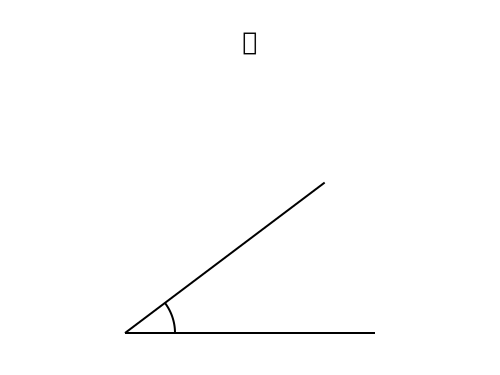

요청한 문장: 직각을 표현해줘
추출된 개념: Right Angle
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
    <!-- 기준선 -->
    <line x1="125" y1="400" x2="458" y2="400" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="400" x2="125" y2="67" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="175" y1="400" x2="175" y2="350" stroke="black" stroke-width="2" />
    <line x1="125" y1="350" x2="175" y2="350" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Angle

**정의:**
Right Angle은 기하학에서 가장 기본적인 각도 중 하나로, 정확히 90도를 이루는 각도를 말합니다. 이 각도는 직각이라고도 불리며, 직선이나 특정 도형의 모서리에서 만나는 두 변이 서로 수직으로 만나는 경우에 나타납니다.

**기본 성질:**
1. **크기:** Right Angle은 항상 정확히 90도입니다. 이는 모든 Right Angle이 동일한 크기를 가짐을 의미합니다.
2. **모양:** Right Angle은 보통 'L' 모양으로 쉽게 인식할 수 있습니다. 이 모양은 직각을 나타내는 데 자주 사용됩니다.
3. **도형과의 관계:** 직각은 사각형, 직사각형, 정사각형 등 다양한 도형의 모서리에서 발견됩니다. 특히, 직사각형이나 정사각형은 네 개

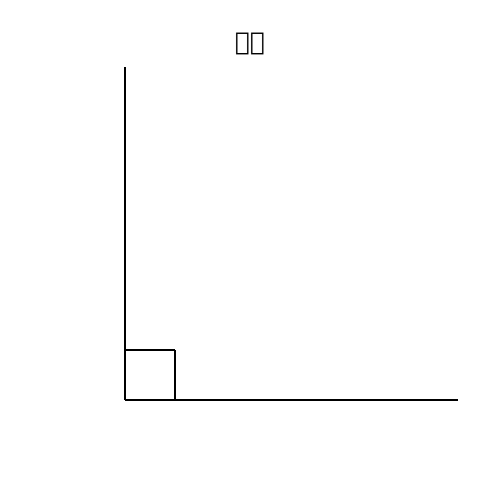

요청한 문장: 밑변이 3이고, 높이가 4인 직각삼각형 하나를 그려줘
추출된 개념: Right Triangle
추출된 인자: {'base': 3, 'height': 4}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <line x1="83" y1="416" x2="308" y2="416" stroke="black" stroke-width="2" />
    <line x1="308" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <line x1="83" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="286" y1="416" x2="286" y2="394" stroke="black" stroke-width="2" />
    <line x1="286" y1="394" x2="308" y2="394" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Triangle

**정의:**
A right triangle is a special type of triangle that has one angle which measures exactly 90 degrees (a right angle). This unique angle distinguishes it from other triangles where all angles are less than 90 degrees.

**기본 성질:**
1. **한 각이 직각:** 가장 중요한 특징은 한 꼭짓점

<IPython.core.display.Math object>

<IPython.core.display.Math object>

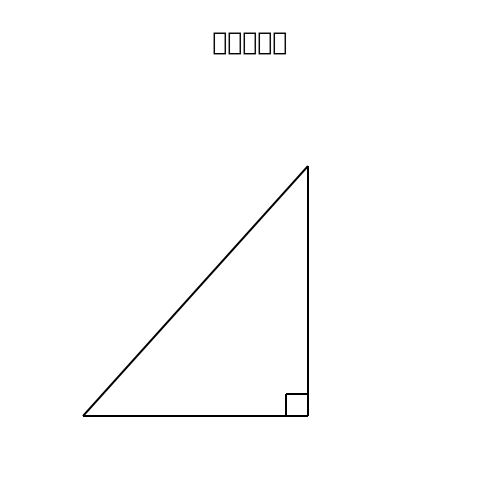

요청한 문장: 가로가 5, 세로가 3인 직사각형의 넓이
추출된 개념: Rectangle
추출된 인자: {'width': 5, 'height': 3}

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="250" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Rectangle 설명

**정의:**
사각형은 네 개의 직선으로 둘러싸인 평면 도형으로, 각 내각이 직각(90도)인 특징을 가지고 있습니다. 즉, 사각형의 네 모서리는 모두 직각을 이루며, 대변이 평행하고 길이가 같은 특성을 갖습니다.

**기본 성질:**
1. **대변의 길이가 같음:** 사각형의 두 쌍의 대변은 길이가 동일합니다. 예를 들어, 가로와 세로가 같은 길이를 가집니다.
2. **대각선이 서로 같음:** 사각형의 두 대각선은 길이가 같습니다. 즉, 사각형을 두 개의 동일한 삼각형으로 나눌 수 있습니다.
3. **내각의 합:** 사각형의 네 내각의 합은 항상 360도입니다.
4. **변의 배열:** 사각형은 여러 가지 형태로 배열될 수 있습니다. 예를 들어, 직사각형은 가로와 세로가 각각 다른 길이를 가질 수 있으며, 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 형태의 사각형입니다.

이러한 성질들로 인해 사각형은 우리 일상생활에서 매우 흔하게 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '2 × (밑변 + 높이)', 'area': '밑변 × 높이'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

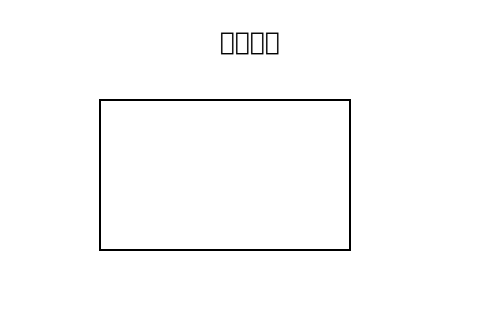

요청한 문장: 한 변의 길이가 2인 정사각형 하나를 그려줘
추출된 개념: Square
추출된 인자: {'length': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="200" height="200" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Square

**정의:**
사각형은 네 개의 변으로 이루어진 평면 도형입니다. 모든 내각이 직각(90도)이며, 반대편의 변들이 길이가 같아서 마주보는 두 변은 평행하고 길이가 동일합니다.

**기본 성질:**
1. **대변의 길이 동일:** 사각형의 마주보는 두 변은 길이가 같습니다. 예를 들어, 정사각형이나 직사각형에서는 모든 대변이 같은 길이를 가집니다.
2. **대각선의 성질:** 사각형의 대각선은 서로를 반으로 나눕니다. 즉, 대각선이 만나는 점에서 대각선을 잇는 선분들은 서로를 절반으로 나눕니다.
3. **변의 합:** 사각형의 네 변의 길이를 모두 더하면, 그 합은 사각형의 둘레를 나타냅니다. 예를 들어, 한 변의 길이가 \(a\)이고 다른 변의 길이가 \(b\)라면, 둘레는 \(a + b + a + b = 2(a + b)\)가 됩니다.
4. **정사각형의 특징:** 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 사각형입니다. 모든 대각선도 길이가 같고 서로를 직각으로 이룹니다.

이러한 성질들로 인해 사각형은 다양한 형태와 크기로 존재하며, 건축, 디자인, 그리고 일상생활에서 자주 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '4 \\times \\mathrm{한 변의 길이}', 'area': '\\m

<IPython.core.display.Math object>

<IPython.core.display.Math object>

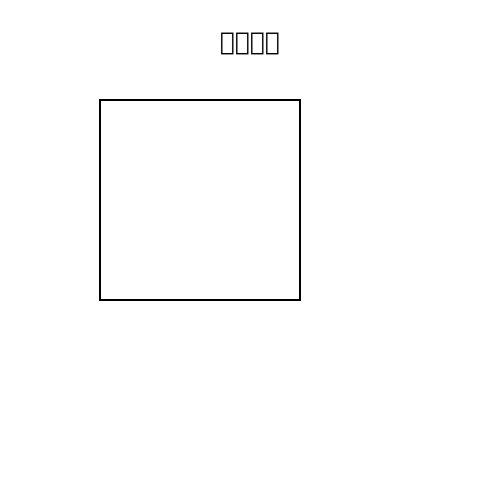

요청한 문장: 곧은선이 뭐야?
추출된 개념: 직선
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="75" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="175" font-size="25" text-anchor="middle">반직선</text>
    <circle cx="125" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="250" x2="500" y2="250" stroke="black" stroke-width="2" />
    <!-- 직선 -->
    <text x="250" y="300" font-size="25" text-anchor="middle">직선</text>
    <circle cx="125" cy="375" r="1" stroke="black"

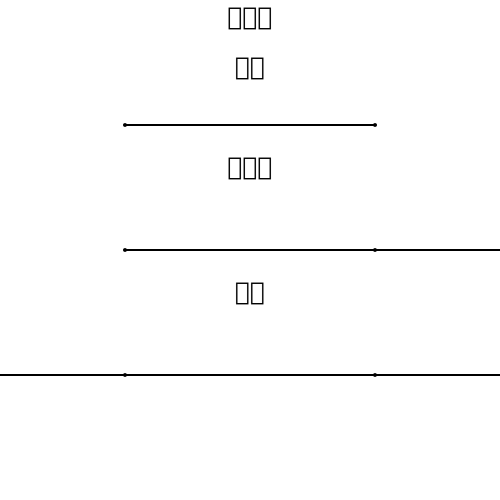

요청한 문장: 대표적인 굽은선을 그려줘
추출된 개념: 곡선
추출된 인자: {'type': '타원', 'description': '타원은 가장 대표적인 굽은선의 한 종류로, 두 초점 사이의 거리의 합이 일정한 점들의 집합으로 정의됩니다.'}

생성된 코드:
 
    <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">굽은선</text>
    <!-- 복잡한 S자 곡선 (두 개의 Cubic Bézier) -->
    <path d="M 100,400
    C 100,100 400,100 400,250
    C 400,400 100,400 100,100"
    stroke="black" fill="none" stroke-width="2"/>
    </svg>
    

생성된 설명:
 ### 곡선에 대한 설명

**정의:**
곡선은 직선이 아닌, 연속적으로 이어지는 점들의 모임으로 이루어진 도형입니다. 쉽게 말해, 직선처럼 일정한 방향으로만 움직이는 것이 아니라, 부드럽게 휘어지거나 굽어지는 형태를 가진 선을 말합니다.

**기본 성질:**
1. **연속성:** 곡선 위의 모든 점들은 부드럽게 이어져 있어, 어떤 작은 구간에서도 끊어지지 않고 이어집니다.
2. **길이:** 곡선의 길이는 그 곡선을 따라 측정한 총 거리입니다. 이 길이는 곡선의 모양에 따라 달라집니다. 예를 들어, 원의 둘레는 반지름에 따라 결정되며, 이는 곡선의 길이를 정확히 계산하는 방법 중 하나입니다.
3. **곡률:** 곡선이 얼마나 빠르게 방향을 바꾸는지를 나타내는 값입니다. 곡률이 크면 곡선이 더 급하게 굽어지고, 작으면 더 부드럽게 굽어집니다. 예를 들어, 원의 경우 모든 점에서 곡률이 일정합니다.
4. **접선:** 곡선 위의 어떤 점에서 그 점을 지나는 가장 가까운 직선을 접선이라고 합니다. 이 접

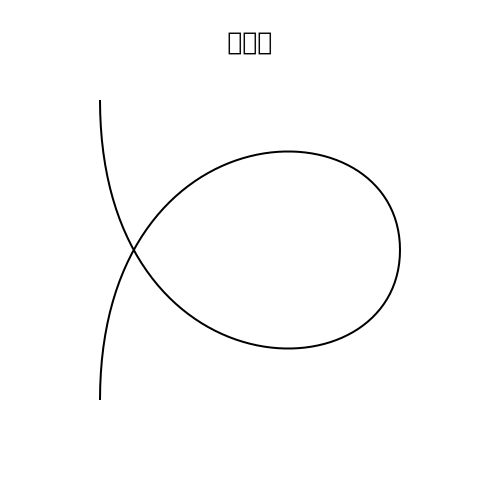

요청한 문장: 중심이 (0,0)이고 반지름이 2인 원을 그려주세요.
추출된 개념: Circle
추출된 인자: {'radius': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="100" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="250" y1="250" x2="350" y2="250" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Circle (원)

#### 정의:
원은 평면 위에서 한 점(중심)으로부터 일정한 거리(반지름)에 있는 모든 점들의 집합을 말합니다. 이 중심점을 기준으로 원 위의 모든 점들은 동일한 거리에 위치해 있습니다.

#### 기본 성질:
1. **둘레와 지름**: 원의 둘레는 지름에 π(약 3.14)를 곱한 값입니다. 즉, 둘레 = 지름 × π 입니다. 반대로 지름은 둘레를 π로 나누면 구할 수 있습니다.
   
2. **면적**: 원의 면적은 반지름의 제곱에 π를 곱한 값입니다. 공식으로 표현하면 면적 = π × 반지름2 입니다.

3. **대칭성**: 원은 중심을 기준으로 완벽하게 대칭입니다. 즉, 중심을 지나는 어떤 직선을 기준으로 원을 접어도 양쪽이 완전히 일치합니다.

4. **원주각과 호의 관계**: 원 위의 두 점을 잇는 호의 중앙각은 그 호에 대응하는 원주각의 두 배입니다. 예를 들어, 호의 중앙각이 θ라면 원주각은 θ/2가 됩니다.

이러한 성질들로 인해 원은 기하학에

<IPython.core.display.Math object>

<IPython.core.display.Math object>

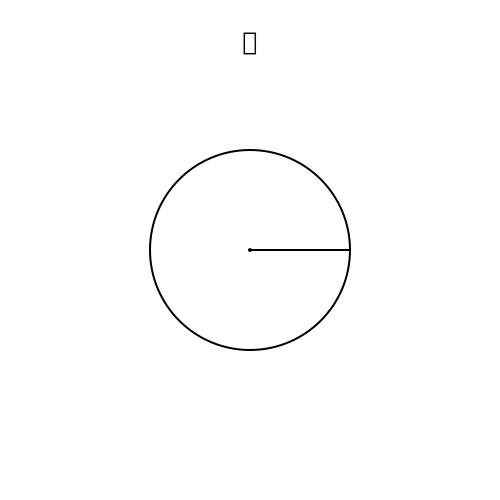

요청한 문장: 37° 각도를 그려줘
추출된 개념: 각도
추출된 인자: {'size': 37}

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
    <!-- 기준선 -->
    <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="333" x2="324.6588775118232" y2="182.54624421198793" stroke="black" stroke-width="2" />
    <!-- 각도 호 -->
    <path d="M 164.93177550236464,302.9092488423976 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>
    </svg>
    

생성된 설명:
 ### 각도에 대한 설명

**정의:**
각도는 두 직선이나 선분이 만나서 생기는 공간의 크기를 측정하는 방법입니다. 우리가 일상에서 자주 접하는 각도는 주로 도로 표지판에서 볼 수 있는 방향 지시나, 그림에서 선들이 만나는 부분을 표현할 때 사용됩니다.

**기본 성질:**
1. **직선의 각도:** 직선은 정확히 180도의 각도를 가집니다. 직선은 두 방향으로 무한히 이어지는 것처럼 보이지만, 실제로는 시작점과 끝점이 있습니다.
   
2. **직각 각도:** 직각은 90도를 의미합니다. 이는 우리가 흔히 사용하는 'L'자 모양의 모서리나 사각형의 모서리에서 볼 수 있습니다. 직각은 두 직선이 서로 수직으로 만나는 경우에 생깁니다.

3. **평행선과 각도:** 평행한 두 직선은 만나지 않기 때문에, 그들 사이의 각도는

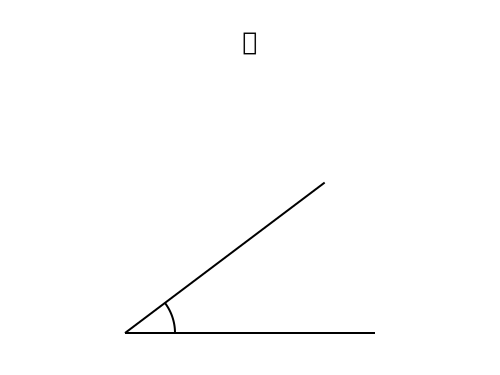

요청한 문장: 직각을 표현해줘
추출된 개념: Right Angle
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
    <!-- 기준선 -->
    <line x1="125" y1="400" x2="458" y2="400" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="400" x2="125" y2="67" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="175" y1="400" x2="175" y2="350" stroke="black" stroke-width="2" />
    <line x1="125" y1="350" x2="175" y2="350" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Angle

**정의:**
Right Angle은 기하학에서 가장 기본적인 각도 중 하나로, 정확히 90도를 이루는 각도를 말합니다. 이 각도는 직각이라고도 불리며, 직선이나 특정 도형의 모서리에서 만나는 두 변이 서로 수직으로 만나는 경우에 나타납니다.

**기본 성질:**
1. **크기:** Right Angle은 항상 정확히 90도입니다. 이는 모든 Right Angle이 동일한 크기를 가짐을 의미합니다.
2. **모양:** Right Angle은 보통 'L' 모양으로 쉽게 인식할 수 있습니다. 이 모양은 직각을 나타내는 데 자주 사용됩니다.
3. **도형과의 관계:** 직각은 사각형, 직사각형, 정사각형 등 다양한 도형의 모서리에서 발견됩니다. 특히, 직사각형이나 정사각형은 네 개

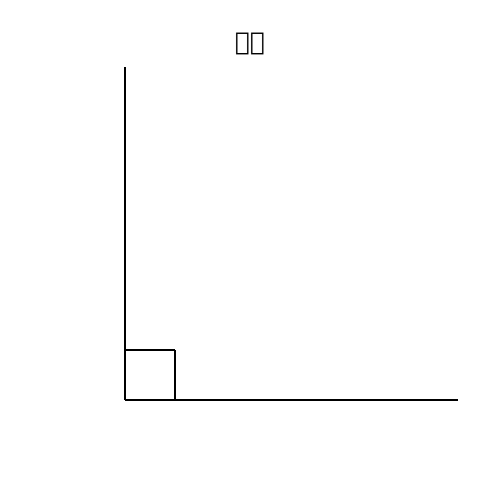

요청한 문장: 밑변이 3이고, 높이가 4인 직각삼각형 하나를 그려줘
추출된 개념: Right Triangle
추출된 인자: {'base': 3, 'height': 4}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <line x1="83" y1="416" x2="308" y2="416" stroke="black" stroke-width="2" />
    <line x1="308" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <line x1="83" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="286" y1="416" x2="286" y2="394" stroke="black" stroke-width="2" />
    <line x1="286" y1="394" x2="308" y2="394" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Triangle

**정의:**
A right triangle is a special type of triangle that has one angle which measures exactly 90 degrees (a right angle). This unique angle distinguishes it from other triangles where all angles are less than 90 degrees.

**기본 성질:**
1. **한 각이 직각:** 가장 중요한 특징은 한 꼭짓점

<IPython.core.display.Math object>

<IPython.core.display.Math object>

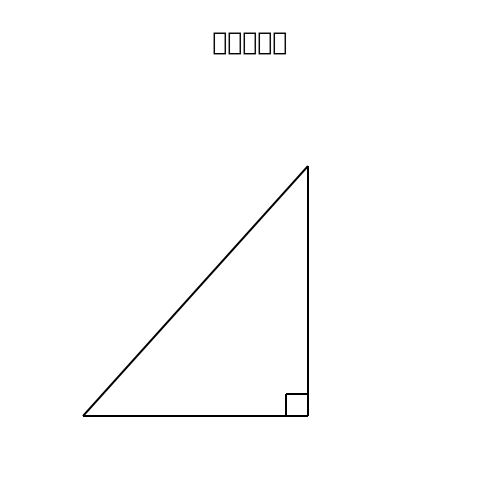

요청한 문장: 가로가 5, 세로가 3인 직사각형의 넓이
추출된 개념: Rectangle
추출된 인자: {'width': 5, 'height': 3}

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="250" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Rectangle 설명

**정의:**
사각형은 네 개의 직선으로 둘러싸인 평면 도형으로, 각 내각이 직각(90도)인 특징을 가지고 있습니다. 즉, 사각형의 네 모서리는 모두 직각을 이루며, 대변이 평행하고 길이가 같은 특성을 갖습니다.

**기본 성질:**
1. **대변의 길이가 같음:** 사각형의 두 쌍의 대변은 길이가 동일합니다. 예를 들어, 가로와 세로가 같은 길이를 가집니다.
2. **대각선이 서로 같음:** 사각형의 두 대각선은 길이가 같습니다. 즉, 사각형을 두 개의 동일한 삼각형으로 나눌 수 있습니다.
3. **내각의 합:** 사각형의 네 내각의 합은 항상 360도입니다.
4. **변의 배열:** 사각형은 여러 가지 형태로 배열될 수 있습니다. 예를 들어, 직사각형은 가로와 세로가 각각 다른 길이를 가질 수 있으며, 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 형태의 사각형입니다.

이러한 성질들로 인해 사각형은 우리 일상생활에서 매우 흔하게 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '2 × (밑변 + 높이)', 'area': '밑변 × 높이'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

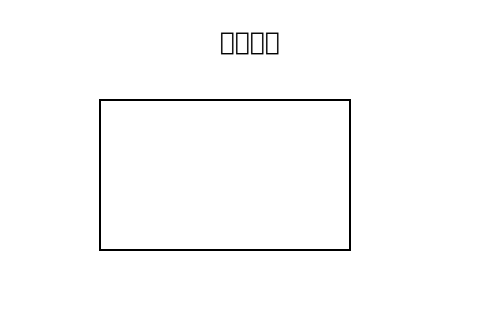

요청한 문장: 한 변의 길이가 2인 정사각형 하나를 그려줘
추출된 개념: Square
추출된 인자: {'length': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="200" height="200" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Square

**정의:**
사각형은 네 개의 변으로 이루어진 평면 도형입니다. 모든 내각이 직각(90도)이며, 반대편의 변들이 길이가 같아서 마주보는 두 변은 평행하고 길이가 동일합니다.

**기본 성질:**
1. **대변의 길이 동일:** 사각형의 마주보는 두 변은 길이가 같습니다. 예를 들어, 정사각형이나 직사각형에서는 모든 대변이 같은 길이를 가집니다.
2. **대각선의 성질:** 사각형의 대각선은 서로를 반으로 나눕니다. 즉, 대각선이 만나는 점에서 대각선을 잇는 선분들은 서로를 절반으로 나눕니다.
3. **변의 합:** 사각형의 네 변의 길이를 모두 더하면, 그 합은 사각형의 둘레를 나타냅니다. 예를 들어, 한 변의 길이가 \(a\)이고 다른 변의 길이가 \(b\)라면, 둘레는 \(a + b + a + b = 2(a + b)\)가 됩니다.
4. **정사각형의 특징:** 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 사각형입니다. 모든 대각선도 길이가 같고 서로를 직각으로 이룹니다.

이러한 성질들로 인해 사각형은 다양한 형태와 크기로 존재하며, 건축, 디자인, 그리고 일상생활에서 자주 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '4 \\times \\mathrm{한 변의 길이}', 'area': '\\m

<IPython.core.display.Math object>

<IPython.core.display.Math object>

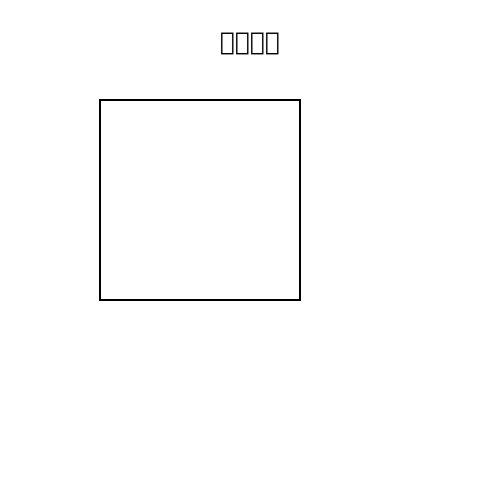

요청한 문장: 곧은선이 뭐야?
추출된 개념: 직선
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="75" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="175" font-size="25" text-anchor="middle">반직선</text>
    <circle cx="125" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="250" x2="500" y2="250" stroke="black" stroke-width="2" />
    <!-- 직선 -->
    <text x="250" y="300" font-size="25" text-anchor="middle">직선</text>
    <circle cx="125" cy="375" r="1" stroke="black"

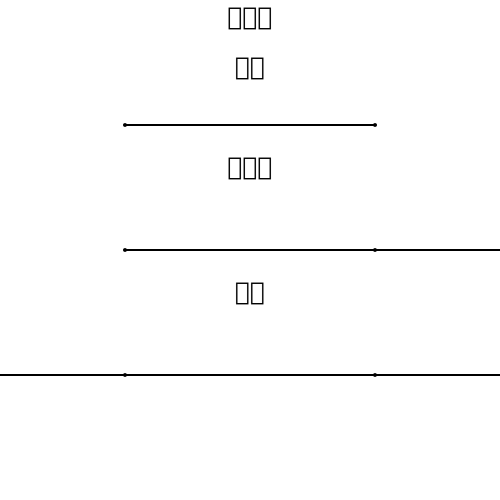

요청한 문장: 대표적인 굽은선을 그려줘
추출된 개념: 곡선
추출된 인자: {'type': '타원', 'description': '타원은 가장 대표적인 굽은선의 한 종류로, 두 초점 사이의 거리의 합이 일정한 점들의 집합으로 정의됩니다.'}

생성된 코드:
 
    <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">굽은선</text>
    <!-- 복잡한 S자 곡선 (두 개의 Cubic Bézier) -->
    <path d="M 100,400
    C 100,100 400,100 400,250
    C 400,400 100,400 100,100"
    stroke="black" fill="none" stroke-width="2"/>
    </svg>
    

생성된 설명:
 ### 곡선에 대한 설명

**정의:**
곡선은 직선이 아닌, 연속적으로 이어지는 점들의 모임으로 이루어진 도형입니다. 쉽게 말해, 직선처럼 일정한 방향으로만 움직이는 것이 아니라, 부드럽게 휘어지거나 굽어지는 형태를 가진 선을 말합니다.

**기본 성질:**
1. **연속성:** 곡선 위의 모든 점들은 부드럽게 이어져 있어, 어떤 작은 구간에서도 끊어지지 않고 이어집니다.
2. **길이:** 곡선의 길이는 그 곡선을 따라 측정한 총 거리입니다. 이 길이는 곡선의 모양에 따라 달라집니다. 예를 들어, 원의 둘레는 반지름에 따라 결정되며, 이는 곡선의 길이를 정확히 계산하는 방법 중 하나입니다.
3. **곡률:** 곡선이 얼마나 빠르게 방향을 바꾸는지를 나타내는 값입니다. 곡률이 크면 곡선이 더 급하게 굽어지고, 작으면 더 부드럽게 굽어집니다. 예를 들어, 원의 경우 모든 점에서 곡률이 일정합니다.
4. **접선:** 곡선 위의 어떤 점에서 그 점을 지나는 가장 가까운 직선을 접선이라고 합니다. 이 접

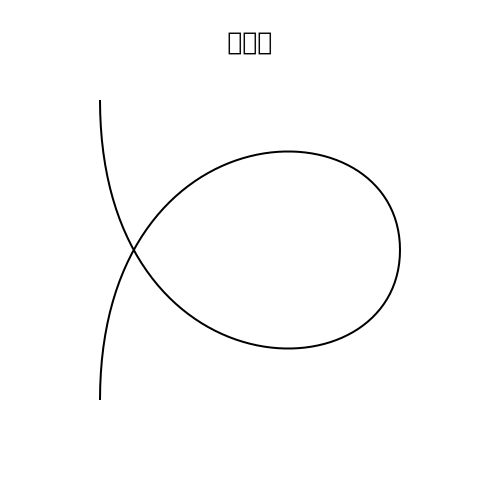

요청한 문장: 중심이 (0,0)이고 반지름이 2인 원을 그려주세요.
추출된 개념: Circle
추출된 인자: {'radius': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="100" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="250" y1="250" x2="350" y2="250" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Circle (원)

#### 정의:
원은 평면 위에서 한 점(중심)으로부터 일정한 거리(반지름)에 있는 모든 점들의 집합을 말합니다. 이 중심점을 기준으로 원 위의 모든 점들은 동일한 거리에 위치해 있습니다.

#### 기본 성질:
1. **둘레와 지름**: 원의 둘레는 지름에 π(약 3.14)를 곱한 값입니다. 즉, 둘레 = 지름 × π 입니다. 반대로 지름은 둘레를 π로 나누면 구할 수 있습니다.
   
2. **면적**: 원의 면적은 반지름의 제곱에 π를 곱한 값입니다. 공식으로 표현하면 면적 = π × 반지름2 입니다.

3. **대칭성**: 원은 중심을 기준으로 완벽하게 대칭입니다. 즉, 중심을 지나는 어떤 직선을 기준으로 원을 접어도 양쪽이 완전히 일치합니다.

4. **원주각과 호의 관계**: 원 위의 두 점을 잇는 호의 중앙각은 그 호에 대응하는 원주각의 두 배입니다. 예를 들어, 호의 중앙각이 θ라면 원주각은 θ/2가 됩니다.

이러한 성질들로 인해 원은 기하학에

<IPython.core.display.Math object>

<IPython.core.display.Math object>

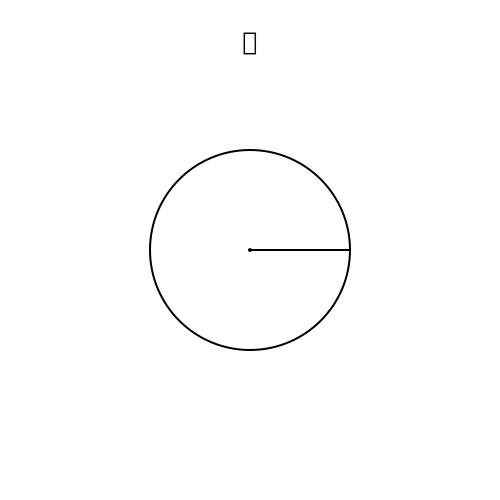

요청한 문장: 37° 각도를 그려줘
추출된 개념: 각도
추출된 인자: {'size': 37}

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
    <!-- 기준선 -->
    <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="333" x2="324.6588775118232" y2="182.54624421198793" stroke="black" stroke-width="2" />
    <!-- 각도 호 -->
    <path d="M 164.93177550236464,302.9092488423976 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>
    </svg>
    

생성된 설명:
 ### 각도에 대한 설명

**정의:**
각도는 두 직선이나 선분이 만나서 생기는 공간의 크기를 측정하는 방법입니다. 우리가 일상에서 자주 접하는 각도는 주로 도로 표지판에서 볼 수 있는 방향 지시나, 그림에서 선들이 만나는 부분을 표현할 때 사용됩니다.

**기본 성질:**
1. **직선의 각도:** 직선은 정확히 180도의 각도를 가집니다. 직선은 두 방향으로 무한히 이어지는 것처럼 보이지만, 실제로는 시작점과 끝점이 있습니다.
   
2. **직각 각도:** 직각은 90도를 의미합니다. 이는 우리가 흔히 사용하는 'L'자 모양의 모서리나 사각형의 모서리에서 볼 수 있습니다. 직각은 두 직선이 서로 수직으로 만나는 경우에 생깁니다.

3. **평행선과 각도:** 평행한 두 직선은 만나지 않기 때문에, 그들 사이의 각도는

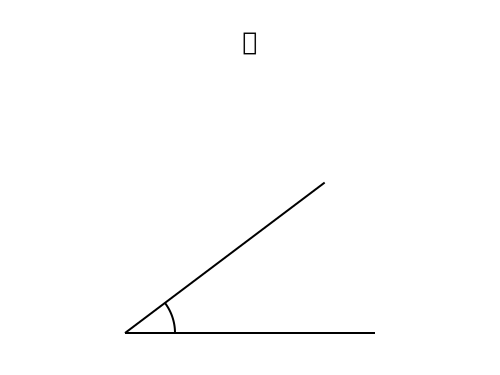

요청한 문장: 직각을 표현해줘
추출된 개념: Right Angle
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
    <!-- 기준선 -->
    <line x1="125" y1="400" x2="458" y2="400" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="400" x2="125" y2="67" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="175" y1="400" x2="175" y2="350" stroke="black" stroke-width="2" />
    <line x1="125" y1="350" x2="175" y2="350" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Angle

**정의:**
Right Angle은 기하학에서 가장 기본적인 각도 중 하나로, 정확히 90도를 이루는 각도를 말합니다. 이 각도는 직각이라고도 불리며, 직선이나 특정 도형의 모서리에서 만나는 두 변이 서로 수직으로 만나는 경우에 나타납니다.

**기본 성질:**
1. **크기:** Right Angle은 항상 정확히 90도입니다. 이는 모든 Right Angle이 동일한 크기를 가짐을 의미합니다.
2. **모양:** Right Angle은 보통 'L' 모양으로 쉽게 인식할 수 있습니다. 이 모양은 직각을 나타내는 데 자주 사용됩니다.
3. **도형과의 관계:** 직각은 사각형, 직사각형, 정사각형 등 다양한 도형의 모서리에서 발견됩니다. 특히, 직사각형이나 정사각형은 네 개

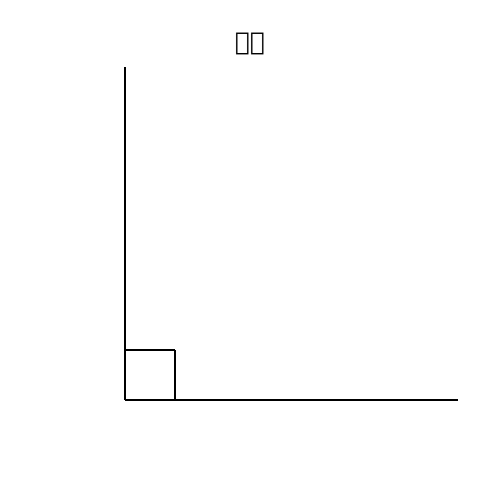

요청한 문장: 밑변이 3이고, 높이가 4인 직각삼각형 하나를 그려줘
추출된 개념: Right Triangle
추출된 인자: {'base': 3, 'height': 4}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <line x1="83" y1="416" x2="308" y2="416" stroke="black" stroke-width="2" />
    <line x1="308" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <line x1="83" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="286" y1="416" x2="286" y2="394" stroke="black" stroke-width="2" />
    <line x1="286" y1="394" x2="308" y2="394" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Triangle

**정의:**
A right triangle is a special type of triangle that has one angle which measures exactly 90 degrees (a right angle). This unique angle distinguishes it from other triangles where all angles are less than 90 degrees.

**기본 성질:**
1. **한 각이 직각:** 가장 중요한 특징은 한 꼭짓점

<IPython.core.display.Math object>

<IPython.core.display.Math object>

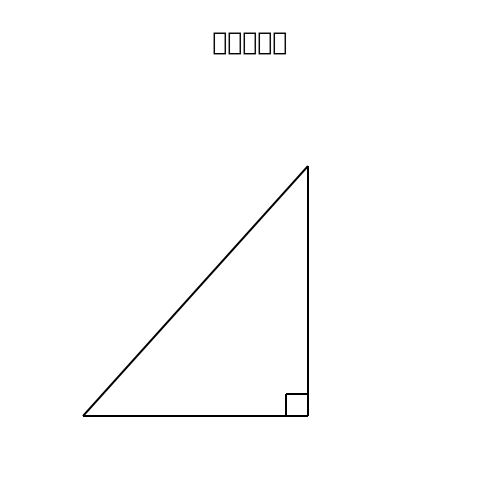

요청한 문장: 가로가 5, 세로가 3인 직사각형의 넓이
추출된 개념: Rectangle
추출된 인자: {'width': 5, 'height': 3}

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="250" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Rectangle 설명

**정의:**
사각형은 네 개의 직선으로 둘러싸인 평면 도형으로, 각 내각이 직각(90도)인 특징을 가지고 있습니다. 즉, 사각형의 네 모서리는 모두 직각을 이루며, 대변이 평행하고 길이가 같은 특성을 갖습니다.

**기본 성질:**
1. **대변의 길이가 같음:** 사각형의 두 쌍의 대변은 길이가 동일합니다. 예를 들어, 가로와 세로가 같은 길이를 가집니다.
2. **대각선이 서로 같음:** 사각형의 두 대각선은 길이가 같습니다. 즉, 사각형을 두 개의 동일한 삼각형으로 나눌 수 있습니다.
3. **내각의 합:** 사각형의 네 내각의 합은 항상 360도입니다.
4. **변의 배열:** 사각형은 여러 가지 형태로 배열될 수 있습니다. 예를 들어, 직사각형은 가로와 세로가 각각 다른 길이를 가질 수 있으며, 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 형태의 사각형입니다.

이러한 성질들로 인해 사각형은 우리 일상생활에서 매우 흔하게 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '2 × (밑변 + 높이)', 'area': '밑변 × 높이'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

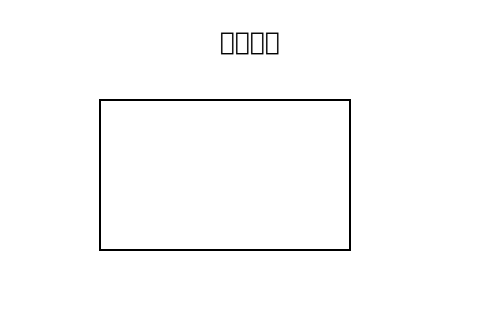

요청한 문장: 한 변의 길이가 2인 정사각형 하나를 그려줘
추출된 개념: Square
추출된 인자: {'length': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="200" height="200" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Square

**정의:**
사각형은 네 개의 변으로 이루어진 평면 도형입니다. 모든 내각이 직각(90도)이며, 반대편의 변들이 길이가 같아서 마주보는 두 변은 평행하고 길이가 동일합니다.

**기본 성질:**
1. **대변의 길이 동일:** 사각형의 마주보는 두 변은 길이가 같습니다. 예를 들어, 정사각형이나 직사각형에서는 모든 대변이 같은 길이를 가집니다.
2. **대각선의 성질:** 사각형의 대각선은 서로를 반으로 나눕니다. 즉, 대각선이 만나는 점에서 대각선을 잇는 선분들은 서로를 절반으로 나눕니다.
3. **변의 합:** 사각형의 네 변의 길이를 모두 더하면, 그 합은 사각형의 둘레를 나타냅니다. 예를 들어, 한 변의 길이가 \(a\)이고 다른 변의 길이가 \(b\)라면, 둘레는 \(a + b + a + b = 2(a + b)\)가 됩니다.
4. **정사각형의 특징:** 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 사각형입니다. 모든 대각선도 길이가 같고 서로를 직각으로 이룹니다.

이러한 성질들로 인해 사각형은 다양한 형태와 크기로 존재하며, 건축, 디자인, 그리고 일상생활에서 자주 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '4 \\times \\mathrm{한 변의 길이}', 'area': '\\m

<IPython.core.display.Math object>

<IPython.core.display.Math object>

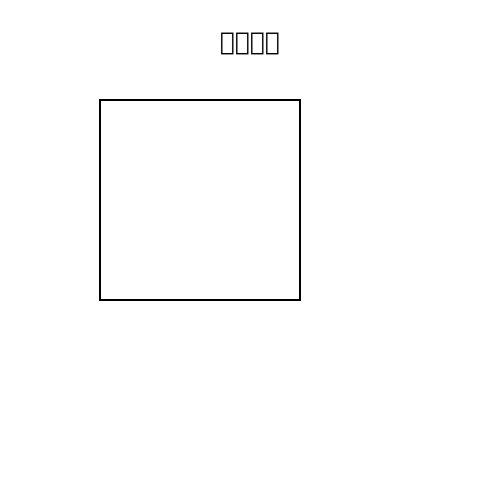

요청한 문장: 곧은선이 뭐야?
추출된 개념: 직선
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="75" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="175" font-size="25" text-anchor="middle">반직선</text>
    <circle cx="125" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="250" x2="500" y2="250" stroke="black" stroke-width="2" />
    <!-- 직선 -->
    <text x="250" y="300" font-size="25" text-anchor="middle">직선</text>
    <circle cx="125" cy="375" r="1" stroke="black"

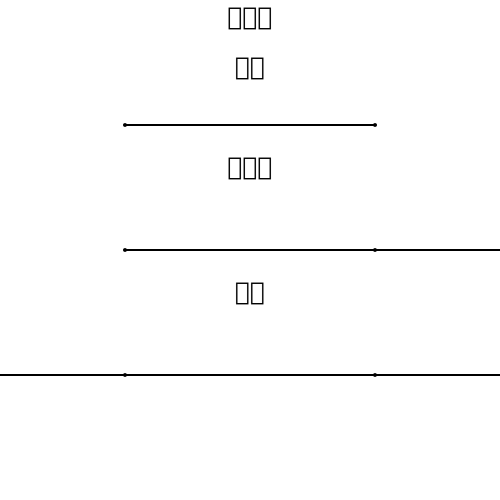

요청한 문장: 대표적인 굽은선을 그려줘
추출된 개념: 곡선
추출된 인자: {'type': '타원', 'description': '타원은 가장 대표적인 굽은선의 한 종류로, 두 초점 사이의 거리의 합이 일정한 점들의 집합으로 정의됩니다.'}

생성된 코드:
 
    <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">굽은선</text>
    <!-- 복잡한 S자 곡선 (두 개의 Cubic Bézier) -->
    <path d="M 100,400
    C 100,100 400,100 400,250
    C 400,400 100,400 100,100"
    stroke="black" fill="none" stroke-width="2"/>
    </svg>
    

생성된 설명:
 ### 곡선에 대한 설명

**정의:**
곡선은 직선이 아닌, 연속적으로 이어지는 점들의 모임으로 이루어진 도형입니다. 쉽게 말해, 직선처럼 일정한 방향으로만 움직이는 것이 아니라, 부드럽게 휘어지거나 굽어지는 형태를 가진 선을 말합니다.

**기본 성질:**
1. **연속성:** 곡선 위의 모든 점들은 부드럽게 이어져 있어, 어떤 작은 구간에서도 끊어지지 않고 이어집니다.
2. **길이:** 곡선의 길이는 그 곡선을 따라 측정한 총 거리입니다. 이 길이는 곡선의 모양에 따라 달라집니다. 예를 들어, 원의 둘레는 반지름에 따라 결정되며, 이는 곡선의 길이를 정확히 계산하는 방법 중 하나입니다.
3. **곡률:** 곡선이 얼마나 빠르게 방향을 바꾸는지를 나타내는 값입니다. 곡률이 크면 곡선이 더 급하게 굽어지고, 작으면 더 부드럽게 굽어집니다. 예를 들어, 원의 경우 모든 점에서 곡률이 일정합니다.
4. **접선:** 곡선 위의 어떤 점에서 그 점을 지나는 가장 가까운 직선을 접선이라고 합니다. 이 접

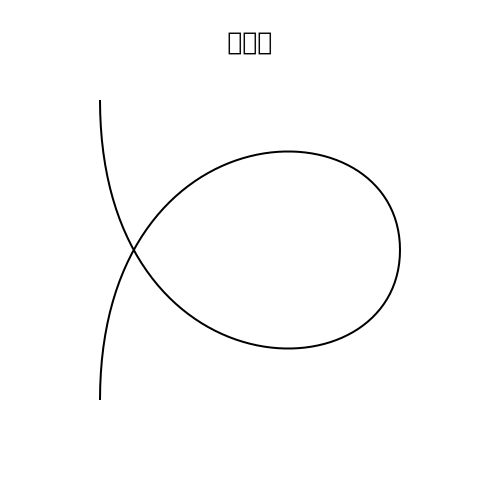

요청한 문장: 중심이 (0,0)이고 반지름이 2인 원을 그려주세요.
추출된 개념: Circle
추출된 인자: {'radius': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="100" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="250" y1="250" x2="350" y2="250" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Circle (원)

#### 정의:
원은 평면 위에서 한 점(중심)으로부터 일정한 거리(반지름)에 있는 모든 점들의 집합을 말합니다. 이 중심점을 기준으로 원 위의 모든 점들은 동일한 거리에 위치해 있습니다.

#### 기본 성질:
1. **둘레와 지름**: 원의 둘레는 지름에 π(약 3.14)를 곱한 값입니다. 즉, 둘레 = 지름 × π 입니다. 반대로 지름은 둘레를 π로 나누면 구할 수 있습니다.
   
2. **면적**: 원의 면적은 반지름의 제곱에 π를 곱한 값입니다. 공식으로 표현하면 면적 = π × 반지름2 입니다.

3. **대칭성**: 원은 중심을 기준으로 완벽하게 대칭입니다. 즉, 중심을 지나는 어떤 직선을 기준으로 원을 접어도 양쪽이 완전히 일치합니다.

4. **원주각과 호의 관계**: 원 위의 두 점을 잇는 호의 중앙각은 그 호에 대응하는 원주각의 두 배입니다. 예를 들어, 호의 중앙각이 θ라면 원주각은 θ/2가 됩니다.

이러한 성질들로 인해 원은 기하학에

<IPython.core.display.Math object>

<IPython.core.display.Math object>

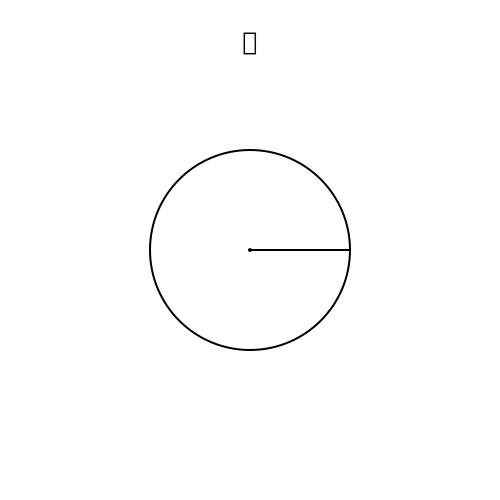

요청한 문장: 37° 각도를 그려줘
추출된 개념: 각도
추출된 인자: {'size': 37}

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
    <!-- 기준선 -->
    <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="333" x2="324.6588775118232" y2="182.54624421198793" stroke="black" stroke-width="2" />
    <!-- 각도 호 -->
    <path d="M 164.93177550236464,302.9092488423976 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>
    </svg>
    

생성된 설명:
 ### 각도에 대한 설명

**정의:**
각도는 두 직선이나 선분이 만나서 생기는 공간의 크기를 측정하는 방법입니다. 우리가 일상에서 자주 접하는 각도는 주로 도로 표지판에서 볼 수 있는 방향 지시나, 그림에서 선들이 만나는 부분을 표현할 때 사용됩니다.

**기본 성질:**
1. **직선의 각도:** 직선은 정확히 180도의 각도를 가집니다. 직선은 두 방향으로 무한히 이어지는 것처럼 보이지만, 실제로는 시작점과 끝점이 있습니다.
   
2. **직각 각도:** 직각은 90도를 의미합니다. 이는 우리가 흔히 사용하는 'L'자 모양의 모서리나 사각형의 모서리에서 볼 수 있습니다. 직각은 두 직선이 서로 수직으로 만나는 경우에 생깁니다.

3. **평행선과 각도:** 평행한 두 직선은 만나지 않기 때문에, 그들 사이의 각도는

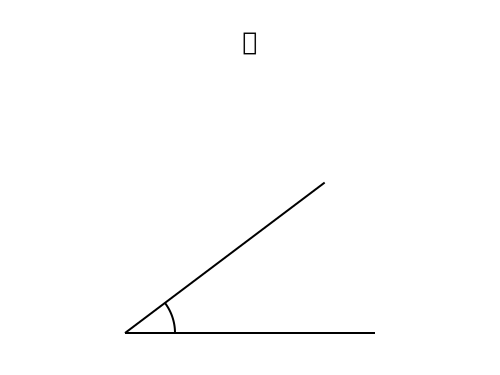

요청한 문장: 직각을 표현해줘
추출된 개념: Right Angle
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
    <!-- 기준선 -->
    <line x1="125" y1="400" x2="458" y2="400" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="400" x2="125" y2="67" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="175" y1="400" x2="175" y2="350" stroke="black" stroke-width="2" />
    <line x1="125" y1="350" x2="175" y2="350" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Angle

**정의:**
Right Angle은 기하학에서 가장 기본적인 각도 중 하나로, 정확히 90도를 이루는 각도를 말합니다. 이 각도는 직각이라고도 불리며, 직선이나 특정 도형의 모서리에서 만나는 두 변이 서로 수직으로 만나는 경우에 나타납니다.

**기본 성질:**
1. **크기:** Right Angle은 항상 정확히 90도입니다. 이는 모든 Right Angle이 동일한 크기를 가짐을 의미합니다.
2. **모양:** Right Angle은 보통 'L' 모양으로 쉽게 인식할 수 있습니다. 이 모양은 직각을 나타내는 데 자주 사용됩니다.
3. **도형과의 관계:** 직각은 사각형, 직사각형, 정사각형 등 다양한 도형의 모서리에서 발견됩니다. 특히, 직사각형이나 정사각형은 네 개

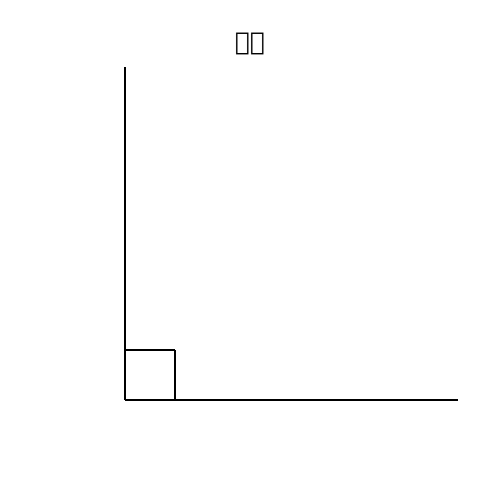

요청한 문장: 밑변이 3이고, 높이가 4인 직각삼각형 하나를 그려줘
추출된 개념: Right Triangle
추출된 인자: {'base': 3, 'height': 4}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <line x1="83" y1="416" x2="308" y2="416" stroke="black" stroke-width="2" />
    <line x1="308" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <line x1="83" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="286" y1="416" x2="286" y2="394" stroke="black" stroke-width="2" />
    <line x1="286" y1="394" x2="308" y2="394" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Triangle

**정의:**
A right triangle is a special type of triangle that has one angle which measures exactly 90 degrees (a right angle). This unique angle distinguishes it from other triangles where all angles are less than 90 degrees.

**기본 성질:**
1. **한 각이 직각:** 가장 중요한 특징은 한 꼭짓점

<IPython.core.display.Math object>

<IPython.core.display.Math object>

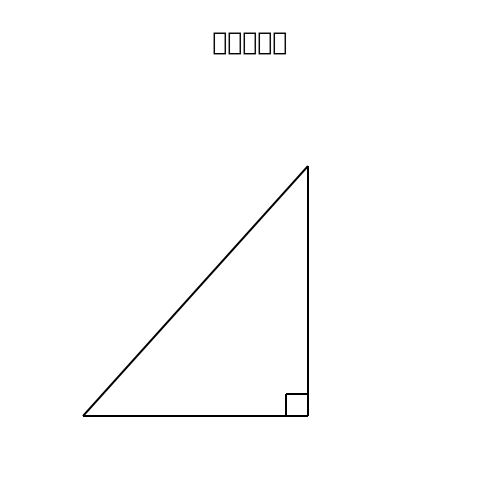

요청한 문장: 가로가 5, 세로가 3인 직사각형의 넓이
추출된 개념: Rectangle
추출된 인자: {'width': 5, 'height': 3}

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="250" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Rectangle 설명

**정의:**
사각형은 네 개의 직선으로 둘러싸인 평면 도형으로, 각 내각이 직각(90도)인 특징을 가지고 있습니다. 즉, 사각형의 네 모서리는 모두 직각을 이루며, 대변이 평행하고 길이가 같은 특성을 갖습니다.

**기본 성질:**
1. **대변의 길이가 같음:** 사각형의 두 쌍의 대변은 길이가 동일합니다. 예를 들어, 가로와 세로가 같은 길이를 가집니다.
2. **대각선이 서로 같음:** 사각형의 두 대각선은 길이가 같습니다. 즉, 사각형을 두 개의 동일한 삼각형으로 나눌 수 있습니다.
3. **내각의 합:** 사각형의 네 내각의 합은 항상 360도입니다.
4. **변의 배열:** 사각형은 여러 가지 형태로 배열될 수 있습니다. 예를 들어, 직사각형은 가로와 세로가 각각 다른 길이를 가질 수 있으며, 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 형태의 사각형입니다.

이러한 성질들로 인해 사각형은 우리 일상생활에서 매우 흔하게 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '2 × (밑변 + 높이)', 'area': '밑변 × 높이'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

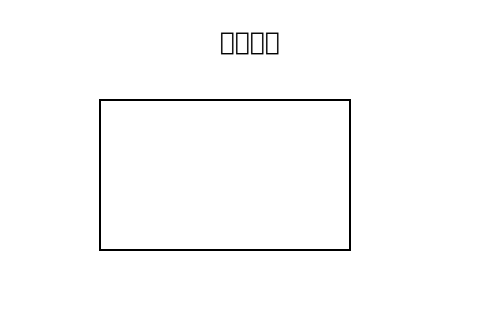

요청한 문장: 한 변의 길이가 2인 정사각형 하나를 그려줘
추출된 개념: Square
추출된 인자: {'length': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="200" height="200" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Square

**정의:**
사각형은 네 개의 변으로 이루어진 평면 도형입니다. 모든 내각이 직각(90도)이며, 반대편의 변들이 길이가 같아서 마주보는 두 변은 평행하고 길이가 동일합니다.

**기본 성질:**
1. **대변의 길이 동일:** 사각형의 마주보는 두 변은 길이가 같습니다. 예를 들어, 정사각형이나 직사각형에서는 모든 대변이 같은 길이를 가집니다.
2. **대각선의 성질:** 사각형의 대각선은 서로를 반으로 나눕니다. 즉, 대각선이 만나는 점에서 대각선을 잇는 선분들은 서로를 절반으로 나눕니다.
3. **변의 합:** 사각형의 네 변의 길이를 모두 더하면, 그 합은 사각형의 둘레를 나타냅니다. 예를 들어, 한 변의 길이가 \(a\)이고 다른 변의 길이가 \(b\)라면, 둘레는 \(a + b + a + b = 2(a + b)\)가 됩니다.
4. **정사각형의 특징:** 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 사각형입니다. 모든 대각선도 길이가 같고 서로를 직각으로 이룹니다.

이러한 성질들로 인해 사각형은 다양한 형태와 크기로 존재하며, 건축, 디자인, 그리고 일상생활에서 자주 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '4 \\times \\mathrm{한 변의 길이}', 'area': '\\m

<IPython.core.display.Math object>

<IPython.core.display.Math object>

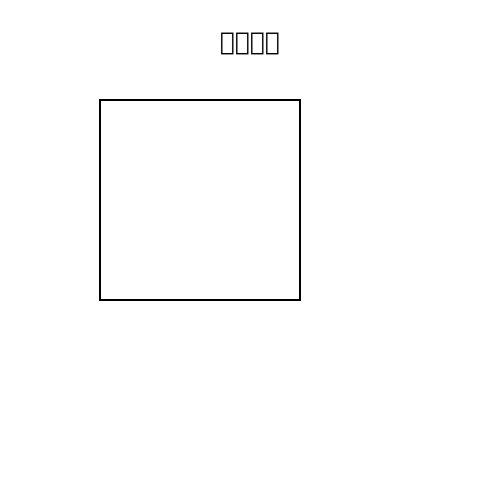

요청한 문장: 곧은선이 뭐야?
추출된 개념: 직선
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="75" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="175" font-size="25" text-anchor="middle">반직선</text>
    <circle cx="125" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="250" x2="500" y2="250" stroke="black" stroke-width="2" />
    <!-- 직선 -->
    <text x="250" y="300" font-size="25" text-anchor="middle">직선</text>
    <circle cx="125" cy="375" r="1" stroke="black"

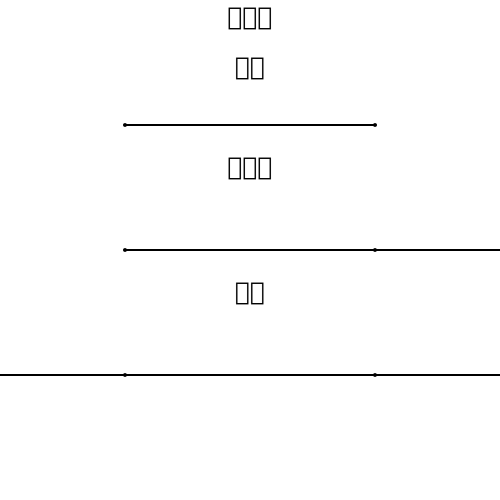

요청한 문장: 대표적인 굽은선을 그려줘
추출된 개념: 곡선
추출된 인자: {'type': '타원', 'description': '타원은 가장 대표적인 굽은선의 한 종류로, 두 초점 사이의 거리의 합이 일정한 점들의 집합으로 정의됩니다.'}

생성된 코드:
 
    <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">굽은선</text>
    <!-- 복잡한 S자 곡선 (두 개의 Cubic Bézier) -->
    <path d="M 100,400
    C 100,100 400,100 400,250
    C 400,400 100,400 100,100"
    stroke="black" fill="none" stroke-width="2"/>
    </svg>
    

생성된 설명:
 ### 곡선에 대한 설명

**정의:**
곡선은 직선이 아닌, 연속적으로 이어지는 점들의 모임으로 이루어진 도형입니다. 쉽게 말해, 직선처럼 일정한 방향으로만 움직이는 것이 아니라, 부드럽게 휘어지거나 굽어지는 형태를 가진 선을 말합니다.

**기본 성질:**
1. **연속성:** 곡선 위의 모든 점들은 부드럽게 이어져 있어, 어떤 작은 구간에서도 끊어지지 않고 이어집니다.
2. **길이:** 곡선의 길이는 그 곡선을 따라 측정한 총 거리입니다. 이 길이는 곡선의 모양에 따라 달라집니다. 예를 들어, 원의 둘레는 반지름에 따라 결정되며, 이는 곡선의 길이를 정확히 계산하는 방법 중 하나입니다.
3. **곡률:** 곡선이 얼마나 빠르게 방향을 바꾸는지를 나타내는 값입니다. 곡률이 크면 곡선이 더 급하게 굽어지고, 작으면 더 부드럽게 굽어집니다. 예를 들어, 원의 경우 모든 점에서 곡률이 일정합니다.
4. **접선:** 곡선 위의 어떤 점에서 그 점을 지나는 가장 가까운 직선을 접선이라고 합니다. 이 접

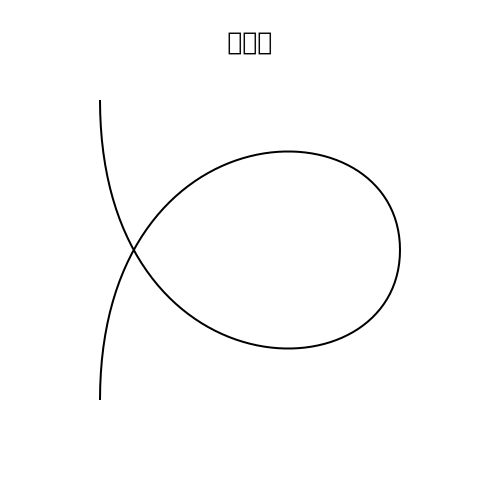

요청한 문장: 중심이 (0,0)이고 반지름이 2인 원을 그려주세요.
추출된 개념: Circle
추출된 인자: {'radius': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="100" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="250" y1="250" x2="350" y2="250" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Circle (원)

#### 정의:
원은 평면 위에서 한 점(중심)으로부터 일정한 거리(반지름)에 있는 모든 점들의 집합을 말합니다. 이 중심점을 기준으로 원 위의 모든 점들은 동일한 거리에 위치해 있습니다.

#### 기본 성질:
1. **둘레와 지름**: 원의 둘레는 지름에 π(약 3.14)를 곱한 값입니다. 즉, 둘레 = 지름 × π 입니다. 반대로 지름은 둘레를 π로 나누면 구할 수 있습니다.
   
2. **면적**: 원의 면적은 반지름의 제곱에 π를 곱한 값입니다. 공식으로 표현하면 면적 = π × 반지름2 입니다.

3. **대칭성**: 원은 중심을 기준으로 완벽하게 대칭입니다. 즉, 중심을 지나는 어떤 직선을 기준으로 원을 접어도 양쪽이 완전히 일치합니다.

4. **원주각과 호의 관계**: 원 위의 두 점을 잇는 호의 중앙각은 그 호에 대응하는 원주각의 두 배입니다. 예를 들어, 호의 중앙각이 θ라면 원주각은 θ/2가 됩니다.

이러한 성질들로 인해 원은 기하학에

<IPython.core.display.Math object>

<IPython.core.display.Math object>

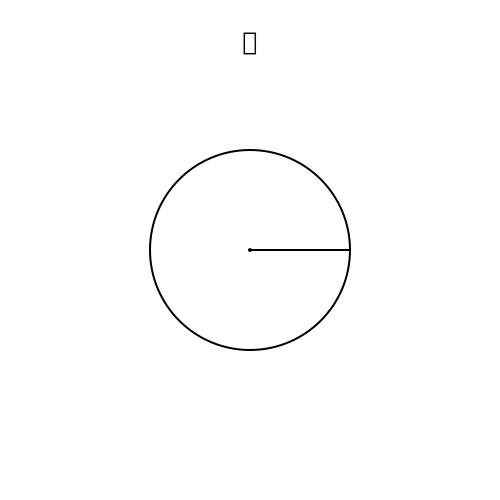

요청한 문장: 37° 각도를 그려줘
추출된 개념: 각도
추출된 인자: {'size': 37}

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
    <!-- 기준선 -->
    <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="333" x2="324.6588775118232" y2="182.54624421198793" stroke="black" stroke-width="2" />
    <!-- 각도 호 -->
    <path d="M 164.93177550236464,302.9092488423976 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>
    </svg>
    

생성된 설명:
 ### 각도에 대한 설명

**정의:**
각도는 두 직선이나 선분이 만나서 생기는 공간의 크기를 측정하는 방법입니다. 우리가 일상에서 자주 접하는 각도는 주로 도로 표지판에서 볼 수 있는 방향 지시나, 그림에서 선들이 만나는 부분을 표현할 때 사용됩니다.

**기본 성질:**
1. **직선의 각도:** 직선은 정확히 180도의 각도를 가집니다. 직선은 두 방향으로 무한히 이어지는 것처럼 보이지만, 실제로는 시작점과 끝점이 있습니다.
   
2. **직각 각도:** 직각은 90도를 의미합니다. 이는 우리가 흔히 사용하는 'L'자 모양의 모서리나 사각형의 모서리에서 볼 수 있습니다. 직각은 두 직선이 서로 수직으로 만나는 경우에 생깁니다.

3. **평행선과 각도:** 평행한 두 직선은 만나지 않기 때문에, 그들 사이의 각도는

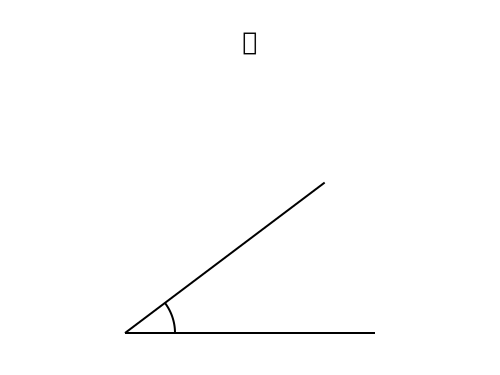

요청한 문장: 직각을 표현해줘
추출된 개념: Right Angle
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
    <!-- 기준선 -->
    <line x1="125" y1="400" x2="458" y2="400" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="400" x2="125" y2="67" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="175" y1="400" x2="175" y2="350" stroke="black" stroke-width="2" />
    <line x1="125" y1="350" x2="175" y2="350" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Angle

**정의:**
Right Angle은 기하학에서 가장 기본적인 각도 중 하나로, 정확히 90도를 이루는 각도를 말합니다. 이 각도는 직각이라고도 불리며, 직선이나 특정 도형의 모서리에서 만나는 두 변이 서로 수직으로 만나는 경우에 나타납니다.

**기본 성질:**
1. **크기:** Right Angle은 항상 정확히 90도입니다. 이는 모든 Right Angle이 동일한 크기를 가짐을 의미합니다.
2. **모양:** Right Angle은 보통 'L' 모양으로 쉽게 인식할 수 있습니다. 이 모양은 직각을 나타내는 데 자주 사용됩니다.
3. **도형과의 관계:** 직각은 사각형, 직사각형, 정사각형 등 다양한 도형의 모서리에서 발견됩니다. 특히, 직사각형이나 정사각형은 네 개

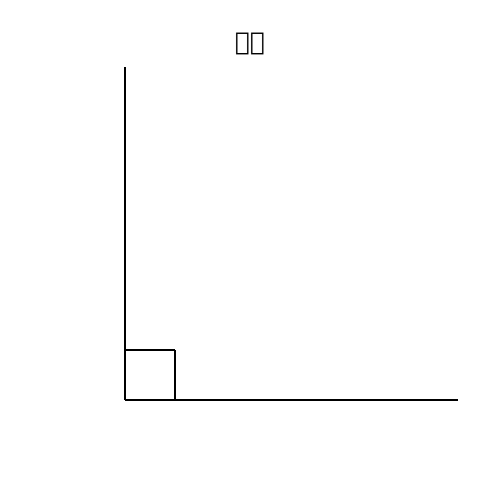

요청한 문장: 밑변이 3이고, 높이가 4인 직각삼각형 하나를 그려줘
추출된 개념: Right Triangle
추출된 인자: {'base': 3, 'height': 4}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <line x1="83" y1="416" x2="308" y2="416" stroke="black" stroke-width="2" />
    <line x1="308" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <line x1="83" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="286" y1="416" x2="286" y2="394" stroke="black" stroke-width="2" />
    <line x1="286" y1="394" x2="308" y2="394" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Triangle

**정의:**
A right triangle is a special type of triangle that has one angle which measures exactly 90 degrees (a right angle). This unique angle distinguishes it from other triangles where all angles are less than 90 degrees.

**기본 성질:**
1. **한 각이 직각:** 가장 중요한 특징은 한 꼭짓점

<IPython.core.display.Math object>

<IPython.core.display.Math object>

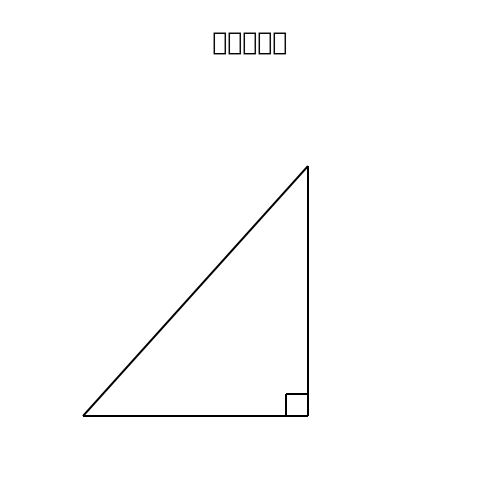

요청한 문장: 가로가 5, 세로가 3인 직사각형의 넓이
추출된 개념: Rectangle
추출된 인자: {'width': 5, 'height': 3}

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="250" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Rectangle 설명

**정의:**
사각형은 네 개의 직선으로 둘러싸인 평면 도형으로, 각 내각이 직각(90도)인 특징을 가지고 있습니다. 즉, 사각형의 네 모서리는 모두 직각을 이루며, 대변이 평행하고 길이가 같은 특성을 갖습니다.

**기본 성질:**
1. **대변의 길이가 같음:** 사각형의 두 쌍의 대변은 길이가 동일합니다. 예를 들어, 가로와 세로가 같은 길이를 가집니다.
2. **대각선이 서로 같음:** 사각형의 두 대각선은 길이가 같습니다. 즉, 사각형을 두 개의 동일한 삼각형으로 나눌 수 있습니다.
3. **내각의 합:** 사각형의 네 내각의 합은 항상 360도입니다.
4. **변의 배열:** 사각형은 여러 가지 형태로 배열될 수 있습니다. 예를 들어, 직사각형은 가로와 세로가 각각 다른 길이를 가질 수 있으며, 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 형태의 사각형입니다.

이러한 성질들로 인해 사각형은 우리 일상생활에서 매우 흔하게 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '2 × (밑변 + 높이)', 'area': '밑변 × 높이'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

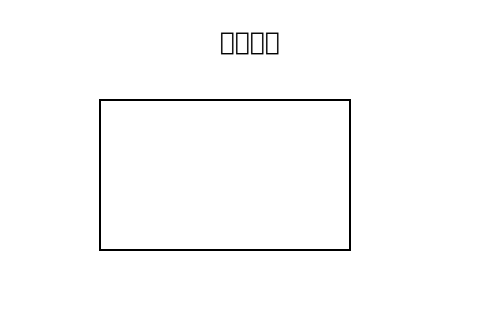

요청한 문장: 한 변의 길이가 2인 정사각형 하나를 그려줘
추출된 개념: Square
추출된 인자: {'length': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="200" height="200" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Square

**정의:**
사각형은 네 개의 변으로 이루어진 평면 도형입니다. 모든 내각이 직각(90도)이며, 반대편의 변들이 길이가 같아서 마주보는 두 변은 평행하고 길이가 동일합니다.

**기본 성질:**
1. **대변의 길이 동일:** 사각형의 마주보는 두 변은 길이가 같습니다. 예를 들어, 정사각형이나 직사각형에서는 모든 대변이 같은 길이를 가집니다.
2. **대각선의 성질:** 사각형의 대각선은 서로를 반으로 나눕니다. 즉, 대각선이 만나는 점에서 대각선을 잇는 선분들은 서로를 절반으로 나눕니다.
3. **변의 합:** 사각형의 네 변의 길이를 모두 더하면, 그 합은 사각형의 둘레를 나타냅니다. 예를 들어, 한 변의 길이가 \(a\)이고 다른 변의 길이가 \(b\)라면, 둘레는 \(a + b + a + b = 2(a + b)\)가 됩니다.
4. **정사각형의 특징:** 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 사각형입니다. 모든 대각선도 길이가 같고 서로를 직각으로 이룹니다.

이러한 성질들로 인해 사각형은 다양한 형태와 크기로 존재하며, 건축, 디자인, 그리고 일상생활에서 자주 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '4 \\times \\mathrm{한 변의 길이}', 'area': '\\m

<IPython.core.display.Math object>

<IPython.core.display.Math object>

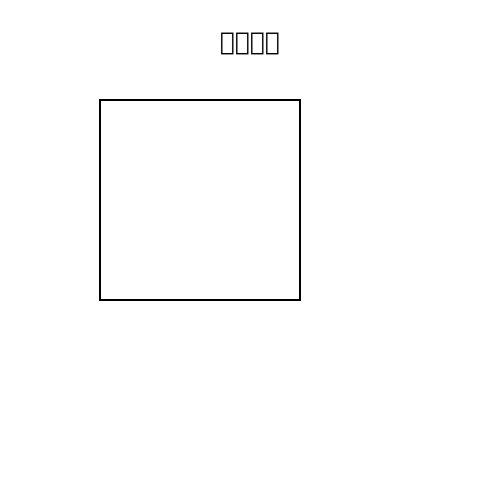

요청한 문장: 곧은선이 뭐야?
추출된 개념: 직선
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="75" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="175" font-size="25" text-anchor="middle">반직선</text>
    <circle cx="125" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="250" x2="500" y2="250" stroke="black" stroke-width="2" />
    <!-- 직선 -->
    <text x="250" y="300" font-size="25" text-anchor="middle">직선</text>
    <circle cx="125" cy="375" r="1" stroke="black"

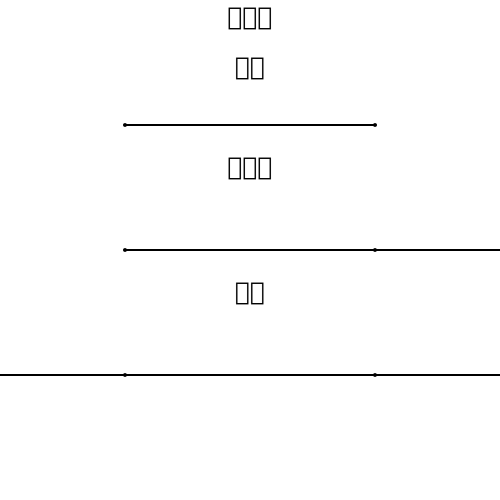

요청한 문장: 대표적인 굽은선을 그려줘
추출된 개념: 곡선
추출된 인자: {'type': '타원', 'description': '타원은 가장 대표적인 굽은선의 한 종류로, 두 초점 사이의 거리의 합이 일정한 점들의 집합으로 정의됩니다.'}

생성된 코드:
 
    <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">굽은선</text>
    <!-- 복잡한 S자 곡선 (두 개의 Cubic Bézier) -->
    <path d="M 100,400
    C 100,100 400,100 400,250
    C 400,400 100,400 100,100"
    stroke="black" fill="none" stroke-width="2"/>
    </svg>
    

생성된 설명:
 ### 곡선에 대한 설명

**정의:**
곡선은 직선이 아닌, 연속적으로 이어지는 점들의 모임으로 이루어진 도형입니다. 쉽게 말해, 직선처럼 일정한 방향으로만 움직이는 것이 아니라, 부드럽게 휘어지거나 굽어지는 형태를 가진 선을 말합니다.

**기본 성질:**
1. **연속성:** 곡선 위의 모든 점들은 부드럽게 이어져 있어, 어떤 작은 구간에서도 끊어지지 않고 이어집니다.
2. **길이:** 곡선의 길이는 그 곡선을 따라 측정한 총 거리입니다. 이 길이는 곡선의 모양에 따라 달라집니다. 예를 들어, 원의 둘레는 반지름에 따라 결정되며, 이는 곡선의 길이를 정확히 계산하는 방법 중 하나입니다.
3. **곡률:** 곡선이 얼마나 빠르게 방향을 바꾸는지를 나타내는 값입니다. 곡률이 크면 곡선이 더 급하게 굽어지고, 작으면 더 부드럽게 굽어집니다. 예를 들어, 원의 경우 모든 점에서 곡률이 일정합니다.
4. **접선:** 곡선 위의 어떤 점에서 그 점을 지나는 가장 가까운 직선을 접선이라고 합니다. 이 접

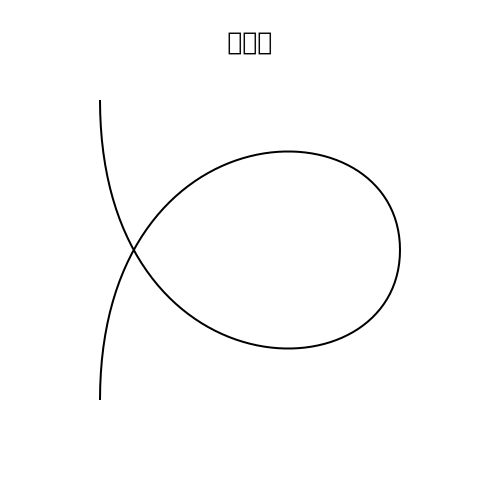

요청한 문장: 중심이 (0,0)이고 반지름이 2인 원을 그려주세요.
추출된 개념: Circle
추출된 인자: {'radius': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="100" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="250" y1="250" x2="350" y2="250" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Circle (원)

#### 정의:
원은 평면 위에서 한 점(중심)으로부터 일정한 거리(반지름)에 있는 모든 점들의 집합을 말합니다. 이 중심점을 기준으로 원 위의 모든 점들은 동일한 거리에 위치해 있습니다.

#### 기본 성질:
1. **둘레와 지름**: 원의 둘레는 지름에 π(약 3.14)를 곱한 값입니다. 즉, 둘레 = 지름 × π 입니다. 반대로 지름은 둘레를 π로 나누면 구할 수 있습니다.
   
2. **면적**: 원의 면적은 반지름의 제곱에 π를 곱한 값입니다. 공식으로 표현하면 면적 = π × 반지름2 입니다.

3. **대칭성**: 원은 중심을 기준으로 완벽하게 대칭입니다. 즉, 중심을 지나는 어떤 직선을 기준으로 원을 접어도 양쪽이 완전히 일치합니다.

4. **원주각과 호의 관계**: 원 위의 두 점을 잇는 호의 중앙각은 그 호에 대응하는 원주각의 두 배입니다. 예를 들어, 호의 중앙각이 θ라면 원주각은 θ/2가 됩니다.

이러한 성질들로 인해 원은 기하학에

<IPython.core.display.Math object>

<IPython.core.display.Math object>

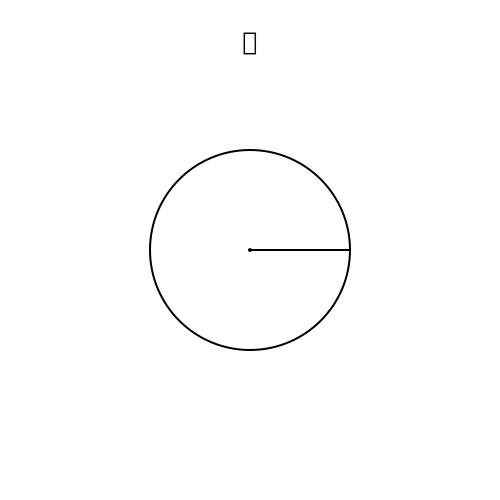

요청한 문장: 37° 각도를 그려줘
추출된 개념: 각도
추출된 인자: {'size': 37}

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
    <!-- 기준선 -->
    <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="333" x2="324.6588775118232" y2="182.54624421198793" stroke="black" stroke-width="2" />
    <!-- 각도 호 -->
    <path d="M 164.93177550236464,302.9092488423976 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>
    </svg>
    

생성된 설명:
 ### 각도에 대한 설명

**정의:**
각도는 두 직선이나 선분이 만나서 생기는 공간의 크기를 측정하는 방법입니다. 우리가 일상에서 자주 접하는 각도는 주로 도로 표지판에서 볼 수 있는 방향 지시나, 그림에서 선들이 만나는 부분을 표현할 때 사용됩니다.

**기본 성질:**
1. **직선의 각도:** 직선은 정확히 180도의 각도를 가집니다. 직선은 두 방향으로 무한히 이어지는 것처럼 보이지만, 실제로는 시작점과 끝점이 있습니다.
   
2. **직각 각도:** 직각은 90도를 의미합니다. 이는 우리가 흔히 사용하는 'L'자 모양의 모서리나 사각형의 모서리에서 볼 수 있습니다. 직각은 두 직선이 서로 수직으로 만나는 경우에 생깁니다.

3. **평행선과 각도:** 평행한 두 직선은 만나지 않기 때문에, 그들 사이의 각도는

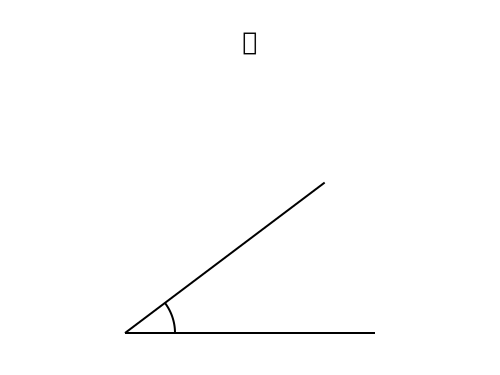

요청한 문장: 직각을 표현해줘
추출된 개념: Right Angle
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
    <!-- 기준선 -->
    <line x1="125" y1="400" x2="458" y2="400" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="400" x2="125" y2="67" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="175" y1="400" x2="175" y2="350" stroke="black" stroke-width="2" />
    <line x1="125" y1="350" x2="175" y2="350" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Angle

**정의:**
Right Angle은 기하학에서 가장 기본적인 각도 중 하나로, 정확히 90도를 이루는 각도를 말합니다. 이 각도는 직각이라고도 불리며, 직선이나 특정 도형의 모서리에서 만나는 두 변이 서로 수직으로 만나는 경우에 나타납니다.

**기본 성질:**
1. **크기:** Right Angle은 항상 정확히 90도입니다. 이는 모든 Right Angle이 동일한 크기를 가짐을 의미합니다.
2. **모양:** Right Angle은 보통 'L' 모양으로 쉽게 인식할 수 있습니다. 이 모양은 직각을 나타내는 데 자주 사용됩니다.
3. **도형과의 관계:** 직각은 사각형, 직사각형, 정사각형 등 다양한 도형의 모서리에서 발견됩니다. 특히, 직사각형이나 정사각형은 네 개

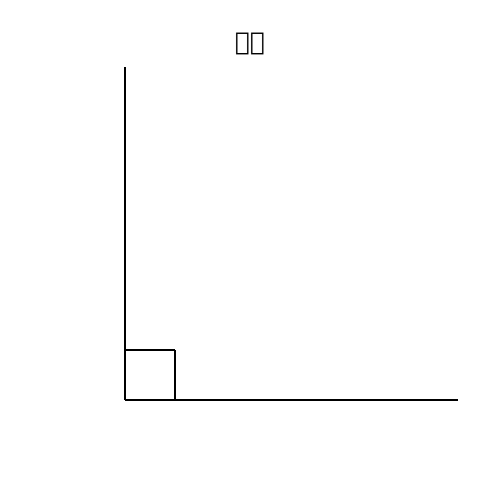

요청한 문장: 밑변이 3이고, 높이가 4인 직각삼각형 하나를 그려줘
추출된 개념: Right Triangle
추출된 인자: {'base': 3, 'height': 4}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <line x1="83" y1="416" x2="308" y2="416" stroke="black" stroke-width="2" />
    <line x1="308" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <line x1="83" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="286" y1="416" x2="286" y2="394" stroke="black" stroke-width="2" />
    <line x1="286" y1="394" x2="308" y2="394" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Triangle

**정의:**
A right triangle is a special type of triangle that has one angle which measures exactly 90 degrees (a right angle). This unique angle distinguishes it from other triangles where all angles are less than 90 degrees.

**기본 성질:**
1. **한 각이 직각:** 가장 중요한 특징은 한 꼭짓점

<IPython.core.display.Math object>

<IPython.core.display.Math object>

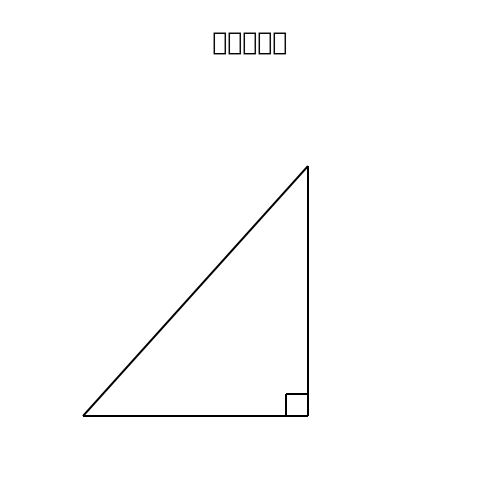

요청한 문장: 가로가 5, 세로가 3인 직사각형의 넓이
추출된 개념: Rectangle
추출된 인자: {'width': 5, 'height': 3}

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="250" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Rectangle 설명

**정의:**
사각형은 네 개의 직선으로 둘러싸인 평면 도형으로, 각 내각이 직각(90도)인 특징을 가지고 있습니다. 즉, 사각형의 네 모서리는 모두 직각을 이루며, 대변이 평행하고 길이가 같은 특성을 갖습니다.

**기본 성질:**
1. **대변의 길이가 같음:** 사각형의 두 쌍의 대변은 길이가 동일합니다. 예를 들어, 가로와 세로가 같은 길이를 가집니다.
2. **대각선이 서로 같음:** 사각형의 두 대각선은 길이가 같습니다. 즉, 사각형을 두 개의 동일한 삼각형으로 나눌 수 있습니다.
3. **내각의 합:** 사각형의 네 내각의 합은 항상 360도입니다.
4. **변의 배열:** 사각형은 여러 가지 형태로 배열될 수 있습니다. 예를 들어, 직사각형은 가로와 세로가 각각 다른 길이를 가질 수 있으며, 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 형태의 사각형입니다.

이러한 성질들로 인해 사각형은 우리 일상생활에서 매우 흔하게 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '2 × (밑변 + 높이)', 'area': '밑변 × 높이'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

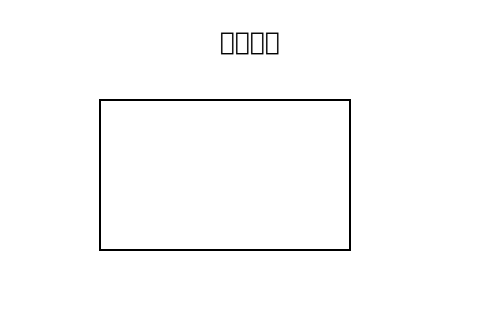

요청한 문장: 한 변의 길이가 2인 정사각형 하나를 그려줘
추출된 개념: Square
추출된 인자: {'length': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="200" height="200" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Square

**정의:**
사각형은 네 개의 변으로 이루어진 평면 도형입니다. 모든 내각이 직각(90도)이며, 반대편의 변들이 길이가 같아서 마주보는 두 변은 평행하고 길이가 동일합니다.

**기본 성질:**
1. **대변의 길이 동일:** 사각형의 마주보는 두 변은 길이가 같습니다. 예를 들어, 정사각형이나 직사각형에서는 모든 대변이 같은 길이를 가집니다.
2. **대각선의 성질:** 사각형의 대각선은 서로를 반으로 나눕니다. 즉, 대각선이 만나는 점에서 대각선을 잇는 선분들은 서로를 절반으로 나눕니다.
3. **변의 합:** 사각형의 네 변의 길이를 모두 더하면, 그 합은 사각형의 둘레를 나타냅니다. 예를 들어, 한 변의 길이가 \(a\)이고 다른 변의 길이가 \(b\)라면, 둘레는 \(a + b + a + b = 2(a + b)\)가 됩니다.
4. **정사각형의 특징:** 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 사각형입니다. 모든 대각선도 길이가 같고 서로를 직각으로 이룹니다.

이러한 성질들로 인해 사각형은 다양한 형태와 크기로 존재하며, 건축, 디자인, 그리고 일상생활에서 자주 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '4 \\times \\mathrm{한 변의 길이}', 'area': '\\m

<IPython.core.display.Math object>

<IPython.core.display.Math object>

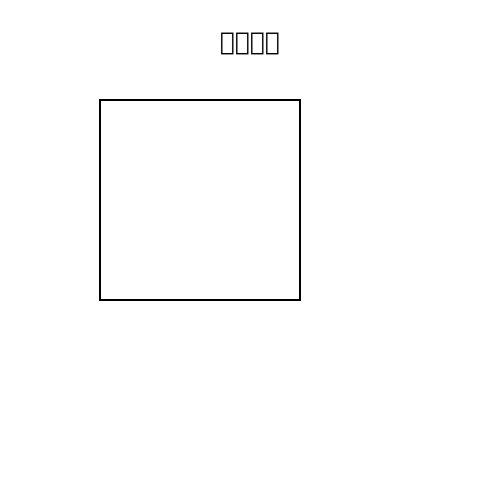

요청한 문장: 곧은선이 뭐야?
추출된 개념: 직선
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="75" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="175" font-size="25" text-anchor="middle">반직선</text>
    <circle cx="125" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="250" x2="500" y2="250" stroke="black" stroke-width="2" />
    <!-- 직선 -->
    <text x="250" y="300" font-size="25" text-anchor="middle">직선</text>
    <circle cx="125" cy="375" r="1" stroke="black"

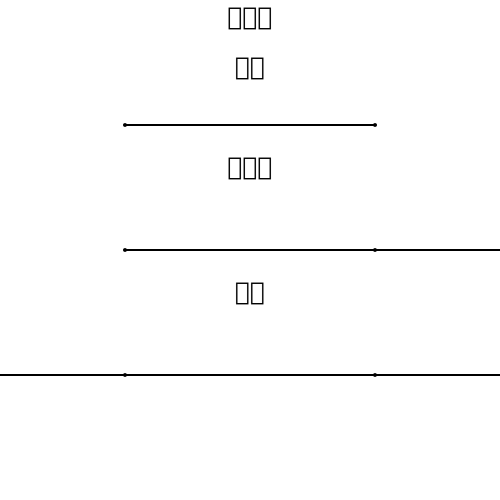

요청한 문장: 대표적인 굽은선을 그려줘
추출된 개념: 곡선
추출된 인자: {'type': '타원', 'description': '타원은 가장 대표적인 굽은선의 한 종류로, 두 초점 사이의 거리의 합이 일정한 점들의 집합으로 정의됩니다.'}

생성된 코드:
 
    <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">굽은선</text>
    <!-- 복잡한 S자 곡선 (두 개의 Cubic Bézier) -->
    <path d="M 100,400
    C 100,100 400,100 400,250
    C 400,400 100,400 100,100"
    stroke="black" fill="none" stroke-width="2"/>
    </svg>
    

생성된 설명:
 ### 곡선에 대한 설명

**정의:**
곡선은 직선이 아닌, 연속적으로 이어지는 점들의 모임으로 이루어진 도형입니다. 쉽게 말해, 직선처럼 일정한 방향으로만 움직이는 것이 아니라, 부드럽게 휘어지거나 굽어지는 형태를 가진 선을 말합니다.

**기본 성질:**
1. **연속성:** 곡선 위의 모든 점들은 부드럽게 이어져 있어, 어떤 작은 구간에서도 끊어지지 않고 이어집니다.
2. **길이:** 곡선의 길이는 그 곡선을 따라 측정한 총 거리입니다. 이 길이는 곡선의 모양에 따라 달라집니다. 예를 들어, 원의 둘레는 반지름에 따라 결정되며, 이는 곡선의 길이를 정확히 계산하는 방법 중 하나입니다.
3. **곡률:** 곡선이 얼마나 빠르게 방향을 바꾸는지를 나타내는 값입니다. 곡률이 크면 곡선이 더 급하게 굽어지고, 작으면 더 부드럽게 굽어집니다. 예를 들어, 원의 경우 모든 점에서 곡률이 일정합니다.
4. **접선:** 곡선 위의 어떤 점에서 그 점을 지나는 가장 가까운 직선을 접선이라고 합니다. 이 접

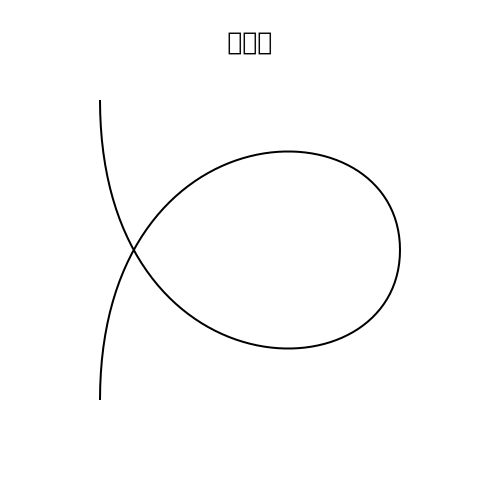

요청한 문장: 중심이 (0,0)이고 반지름이 2인 원을 그려주세요.
추출된 개념: Circle
추출된 인자: {'radius': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="100" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="250" y1="250" x2="350" y2="250" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Circle (원)

#### 정의:
원은 평면 위에서 한 점(중심)으로부터 일정한 거리(반지름)에 있는 모든 점들의 집합을 말합니다. 이 중심점을 기준으로 원 위의 모든 점들은 동일한 거리에 위치해 있습니다.

#### 기본 성질:
1. **둘레와 지름**: 원의 둘레는 지름에 π(약 3.14)를 곱한 값입니다. 즉, 둘레 = 지름 × π 입니다. 반대로 지름은 둘레를 π로 나누면 구할 수 있습니다.
   
2. **면적**: 원의 면적은 반지름의 제곱에 π를 곱한 값입니다. 공식으로 표현하면 면적 = π × 반지름2 입니다.

3. **대칭성**: 원은 중심을 기준으로 완벽하게 대칭입니다. 즉, 중심을 지나는 어떤 직선을 기준으로 원을 접어도 양쪽이 완전히 일치합니다.

4. **원주각과 호의 관계**: 원 위의 두 점을 잇는 호의 중앙각은 그 호에 대응하는 원주각의 두 배입니다. 예를 들어, 호의 중앙각이 θ라면 원주각은 θ/2가 됩니다.

이러한 성질들로 인해 원은 기하학에

<IPython.core.display.Math object>

<IPython.core.display.Math object>

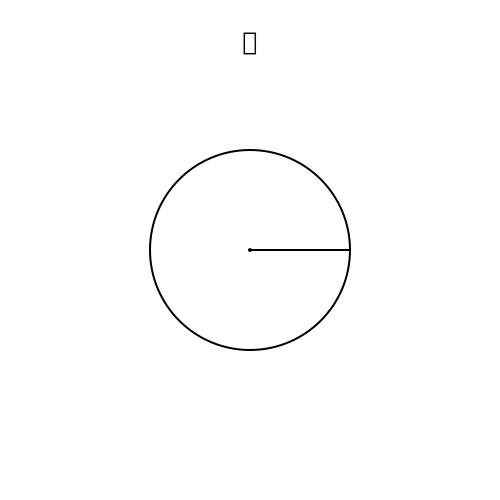

요청한 문장: 37° 각도를 그려줘
추출된 개념: 각도
추출된 인자: {'size': 37}

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
    <!-- 기준선 -->
    <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="333" x2="324.6588775118232" y2="182.54624421198793" stroke="black" stroke-width="2" />
    <!-- 각도 호 -->
    <path d="M 164.93177550236464,302.9092488423976 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>
    </svg>
    

생성된 설명:
 ### 각도에 대한 설명

**정의:**
각도는 두 직선이나 선분이 만나서 생기는 공간의 크기를 측정하는 방법입니다. 우리가 일상에서 자주 접하는 각도는 주로 도로 표지판에서 볼 수 있는 방향 지시나, 그림에서 선들이 만나는 부분을 표현할 때 사용됩니다.

**기본 성질:**
1. **직선의 각도:** 직선은 정확히 180도의 각도를 가집니다. 직선은 두 방향으로 무한히 이어지는 것처럼 보이지만, 실제로는 시작점과 끝점이 있습니다.
   
2. **직각 각도:** 직각은 90도를 의미합니다. 이는 우리가 흔히 사용하는 'L'자 모양의 모서리나 사각형의 모서리에서 볼 수 있습니다. 직각은 두 직선이 서로 수직으로 만나는 경우에 생깁니다.

3. **평행선과 각도:** 평행한 두 직선은 만나지 않기 때문에, 그들 사이의 각도는

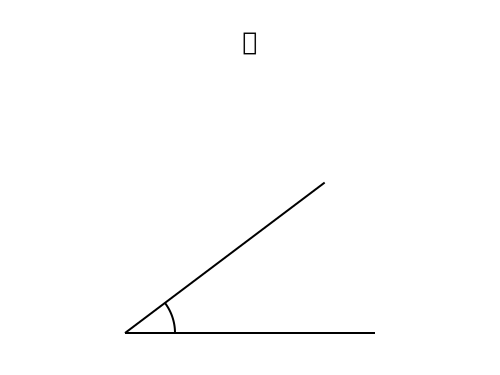

요청한 문장: 직각을 표현해줘
추출된 개념: Right Angle
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
    <!-- 기준선 -->
    <line x1="125" y1="400" x2="458" y2="400" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="400" x2="125" y2="67" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="175" y1="400" x2="175" y2="350" stroke="black" stroke-width="2" />
    <line x1="125" y1="350" x2="175" y2="350" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Angle

**정의:**
Right Angle은 기하학에서 가장 기본적인 각도 중 하나로, 정확히 90도를 이루는 각도를 말합니다. 이 각도는 직각이라고도 불리며, 직선이나 특정 도형의 모서리에서 만나는 두 변이 서로 수직으로 만나는 경우에 나타납니다.

**기본 성질:**
1. **크기:** Right Angle은 항상 정확히 90도입니다. 이는 모든 Right Angle이 동일한 크기를 가짐을 의미합니다.
2. **모양:** Right Angle은 보통 'L' 모양으로 쉽게 인식할 수 있습니다. 이 모양은 직각을 나타내는 데 자주 사용됩니다.
3. **도형과의 관계:** 직각은 사각형, 직사각형, 정사각형 등 다양한 도형의 모서리에서 발견됩니다. 특히, 직사각형이나 정사각형은 네 개

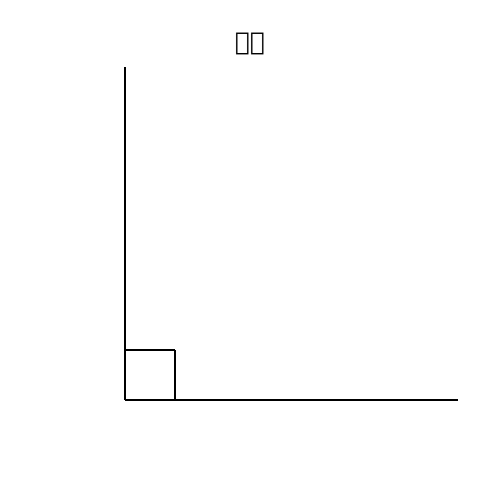

요청한 문장: 밑변이 3이고, 높이가 4인 직각삼각형 하나를 그려줘
추출된 개념: Right Triangle
추출된 인자: {'base': 3, 'height': 4}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <line x1="83" y1="416" x2="308" y2="416" stroke="black" stroke-width="2" />
    <line x1="308" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <line x1="83" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="286" y1="416" x2="286" y2="394" stroke="black" stroke-width="2" />
    <line x1="286" y1="394" x2="308" y2="394" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Triangle

**정의:**
A right triangle is a special type of triangle that has one angle which measures exactly 90 degrees (a right angle). This unique angle distinguishes it from other triangles where all angles are less than 90 degrees.

**기본 성질:**
1. **한 각이 직각:** 가장 중요한 특징은 한 꼭짓점

<IPython.core.display.Math object>

<IPython.core.display.Math object>

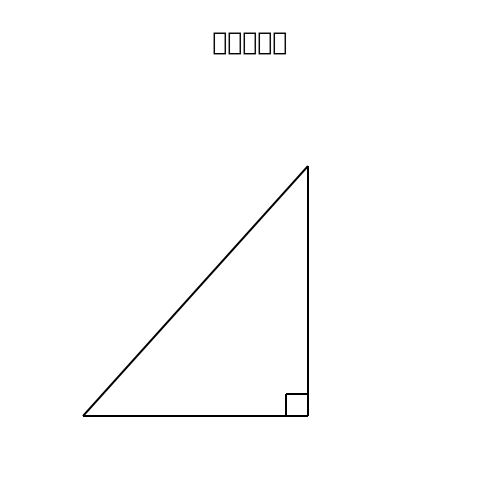

요청한 문장: 가로가 5, 세로가 3인 직사각형의 넓이
추출된 개념: Rectangle
추출된 인자: {'width': 5, 'height': 3}

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="250" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Rectangle 설명

**정의:**
사각형은 네 개의 직선으로 둘러싸인 평면 도형으로, 각 내각이 직각(90도)인 특징을 가지고 있습니다. 즉, 사각형의 네 모서리는 모두 직각을 이루며, 대변이 평행하고 길이가 같은 특성을 갖습니다.

**기본 성질:**
1. **대변의 길이가 같음:** 사각형의 두 쌍의 대변은 길이가 동일합니다. 예를 들어, 가로와 세로가 같은 길이를 가집니다.
2. **대각선이 서로 같음:** 사각형의 두 대각선은 길이가 같습니다. 즉, 사각형을 두 개의 동일한 삼각형으로 나눌 수 있습니다.
3. **내각의 합:** 사각형의 네 내각의 합은 항상 360도입니다.
4. **변의 배열:** 사각형은 여러 가지 형태로 배열될 수 있습니다. 예를 들어, 직사각형은 가로와 세로가 각각 다른 길이를 가질 수 있으며, 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 형태의 사각형입니다.

이러한 성질들로 인해 사각형은 우리 일상생활에서 매우 흔하게 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '2 × (밑변 + 높이)', 'area': '밑변 × 높이'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

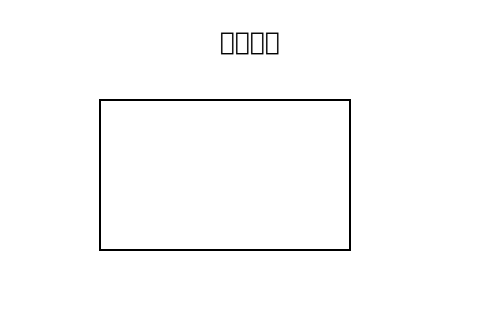

요청한 문장: 한 변의 길이가 2인 정사각형 하나를 그려줘
추출된 개념: Square
추출된 인자: {'length': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="200" height="200" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Square

**정의:**
사각형은 네 개의 변으로 이루어진 평면 도형입니다. 모든 내각이 직각(90도)이며, 반대편의 변들이 길이가 같아서 마주보는 두 변은 평행하고 길이가 동일합니다.

**기본 성질:**
1. **대변의 길이 동일:** 사각형의 마주보는 두 변은 길이가 같습니다. 예를 들어, 정사각형이나 직사각형에서는 모든 대변이 같은 길이를 가집니다.
2. **대각선의 성질:** 사각형의 대각선은 서로를 반으로 나눕니다. 즉, 대각선이 만나는 점에서 대각선을 잇는 선분들은 서로를 절반으로 나눕니다.
3. **변의 합:** 사각형의 네 변의 길이를 모두 더하면, 그 합은 사각형의 둘레를 나타냅니다. 예를 들어, 한 변의 길이가 \(a\)이고 다른 변의 길이가 \(b\)라면, 둘레는 \(a + b + a + b = 2(a + b)\)가 됩니다.
4. **정사각형의 특징:** 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 사각형입니다. 모든 대각선도 길이가 같고 서로를 직각으로 이룹니다.

이러한 성질들로 인해 사각형은 다양한 형태와 크기로 존재하며, 건축, 디자인, 그리고 일상생활에서 자주 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '4 \\times \\mathrm{한 변의 길이}', 'area': '\\m

<IPython.core.display.Math object>

<IPython.core.display.Math object>

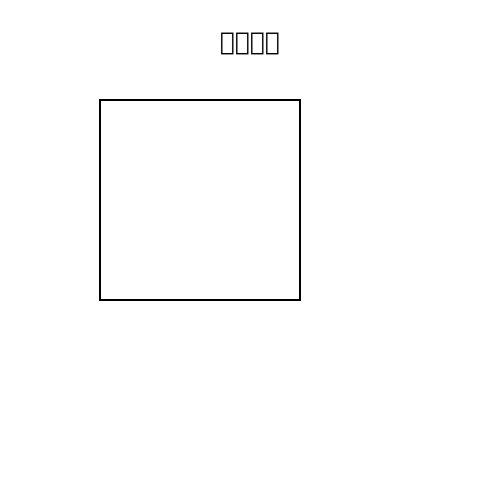

요청한 문장: 곧은선이 뭐야?
추출된 개념: 직선
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="75" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="175" font-size="25" text-anchor="middle">반직선</text>
    <circle cx="125" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="250" x2="500" y2="250" stroke="black" stroke-width="2" />
    <!-- 직선 -->
    <text x="250" y="300" font-size="25" text-anchor="middle">직선</text>
    <circle cx="125" cy="375" r="1" stroke="black"

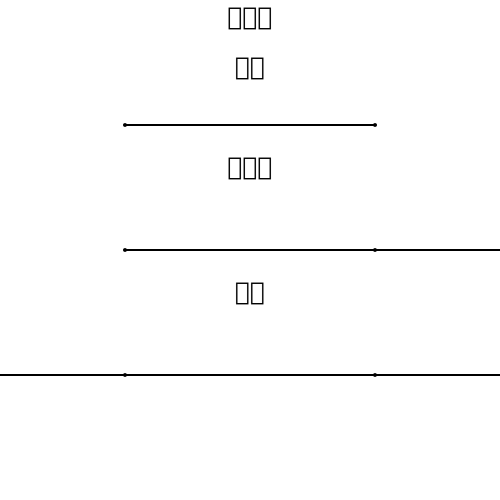

요청한 문장: 대표적인 굽은선을 그려줘
추출된 개념: 곡선
추출된 인자: {'type': '타원', 'description': '타원은 가장 대표적인 굽은선의 한 종류로, 두 초점 사이의 거리의 합이 일정한 점들의 집합으로 정의됩니다.'}

생성된 코드:
 
    <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">굽은선</text>
    <!-- 복잡한 S자 곡선 (두 개의 Cubic Bézier) -->
    <path d="M 100,400
    C 100,100 400,100 400,250
    C 400,400 100,400 100,100"
    stroke="black" fill="none" stroke-width="2"/>
    </svg>
    

생성된 설명:
 ### 곡선에 대한 설명

**정의:**
곡선은 직선이 아닌, 연속적으로 이어지는 점들의 모임으로 이루어진 도형입니다. 쉽게 말해, 직선처럼 일정한 방향으로만 움직이는 것이 아니라, 부드럽게 휘어지거나 굽어지는 형태를 가진 선을 말합니다.

**기본 성질:**
1. **연속성:** 곡선 위의 모든 점들은 부드럽게 이어져 있어, 어떤 작은 구간에서도 끊어지지 않고 이어집니다.
2. **길이:** 곡선의 길이는 그 곡선을 따라 측정한 총 거리입니다. 이 길이는 곡선의 모양에 따라 달라집니다. 예를 들어, 원의 둘레는 반지름에 따라 결정되며, 이는 곡선의 길이를 정확히 계산하는 방법 중 하나입니다.
3. **곡률:** 곡선이 얼마나 빠르게 방향을 바꾸는지를 나타내는 값입니다. 곡률이 크면 곡선이 더 급하게 굽어지고, 작으면 더 부드럽게 굽어집니다. 예를 들어, 원의 경우 모든 점에서 곡률이 일정합니다.
4. **접선:** 곡선 위의 어떤 점에서 그 점을 지나는 가장 가까운 직선을 접선이라고 합니다. 이 접

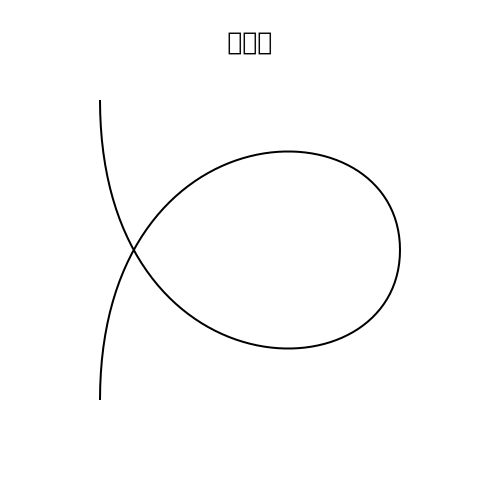

요청한 문장: 중심이 (0,0)이고 반지름이 2인 원을 그려주세요.
추출된 개념: Circle
추출된 인자: {'radius': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="100" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="250" y1="250" x2="350" y2="250" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Circle (원)

#### 정의:
원은 평면 위에서 한 점(중심)으로부터 일정한 거리(반지름)에 있는 모든 점들의 집합을 말합니다. 이 중심점을 기준으로 원 위의 모든 점들은 동일한 거리에 위치해 있습니다.

#### 기본 성질:
1. **둘레와 지름**: 원의 둘레는 지름에 π(약 3.14)를 곱한 값입니다. 즉, 둘레 = 지름 × π 입니다. 반대로 지름은 둘레를 π로 나누면 구할 수 있습니다.
   
2. **면적**: 원의 면적은 반지름의 제곱에 π를 곱한 값입니다. 공식으로 표현하면 면적 = π × 반지름2 입니다.

3. **대칭성**: 원은 중심을 기준으로 완벽하게 대칭입니다. 즉, 중심을 지나는 어떤 직선을 기준으로 원을 접어도 양쪽이 완전히 일치합니다.

4. **원주각과 호의 관계**: 원 위의 두 점을 잇는 호의 중앙각은 그 호에 대응하는 원주각의 두 배입니다. 예를 들어, 호의 중앙각이 θ라면 원주각은 θ/2가 됩니다.

이러한 성질들로 인해 원은 기하학에

<IPython.core.display.Math object>

<IPython.core.display.Math object>

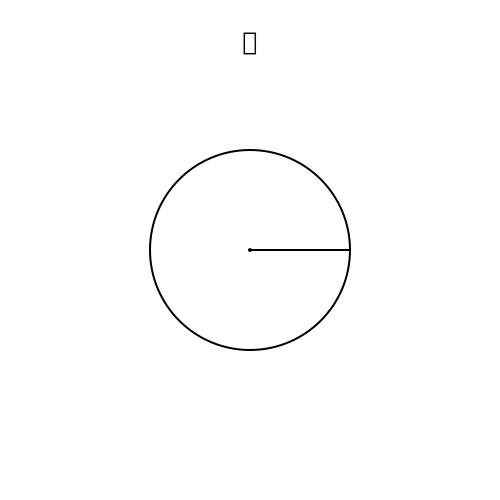

요청한 문장: 37° 각도를 그려줘
추출된 개념: 각도
추출된 인자: {'size': 37}

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
    <!-- 기준선 -->
    <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="333" x2="324.6588775118232" y2="182.54624421198793" stroke="black" stroke-width="2" />
    <!-- 각도 호 -->
    <path d="M 164.93177550236464,302.9092488423976 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>
    </svg>
    

생성된 설명:
 ### 각도에 대한 설명

**정의:**
각도는 두 직선이나 선분이 만나서 생기는 공간의 크기를 측정하는 방법입니다. 우리가 일상에서 자주 접하는 각도는 주로 도로 표지판에서 볼 수 있는 방향 지시나, 그림에서 선들이 만나는 부분을 표현할 때 사용됩니다.

**기본 성질:**
1. **직선의 각도:** 직선은 정확히 180도의 각도를 가집니다. 직선은 두 방향으로 무한히 이어지는 것처럼 보이지만, 실제로는 시작점과 끝점이 있습니다.
   
2. **직각 각도:** 직각은 90도를 의미합니다. 이는 우리가 흔히 사용하는 'L'자 모양의 모서리나 사각형의 모서리에서 볼 수 있습니다. 직각은 두 직선이 서로 수직으로 만나는 경우에 생깁니다.

3. **평행선과 각도:** 평행한 두 직선은 만나지 않기 때문에, 그들 사이의 각도는

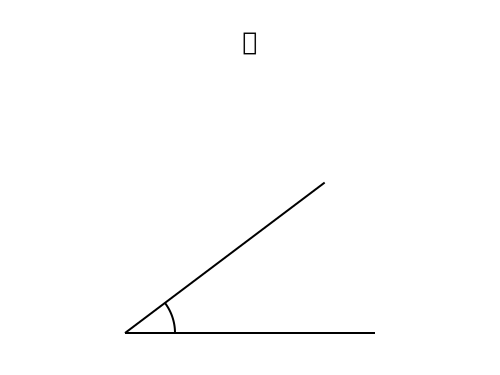

요청한 문장: 직각을 표현해줘
추출된 개념: Right Angle
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
    <!-- 기준선 -->
    <line x1="125" y1="400" x2="458" y2="400" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="400" x2="125" y2="67" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="175" y1="400" x2="175" y2="350" stroke="black" stroke-width="2" />
    <line x1="125" y1="350" x2="175" y2="350" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Angle

**정의:**
Right Angle은 기하학에서 가장 기본적인 각도 중 하나로, 정확히 90도를 이루는 각도를 말합니다. 이 각도는 직각이라고도 불리며, 직선이나 특정 도형의 모서리에서 만나는 두 변이 서로 수직으로 만나는 경우에 나타납니다.

**기본 성질:**
1. **크기:** Right Angle은 항상 정확히 90도입니다. 이는 모든 Right Angle이 동일한 크기를 가짐을 의미합니다.
2. **모양:** Right Angle은 보통 'L' 모양으로 쉽게 인식할 수 있습니다. 이 모양은 직각을 나타내는 데 자주 사용됩니다.
3. **도형과의 관계:** 직각은 사각형, 직사각형, 정사각형 등 다양한 도형의 모서리에서 발견됩니다. 특히, 직사각형이나 정사각형은 네 개

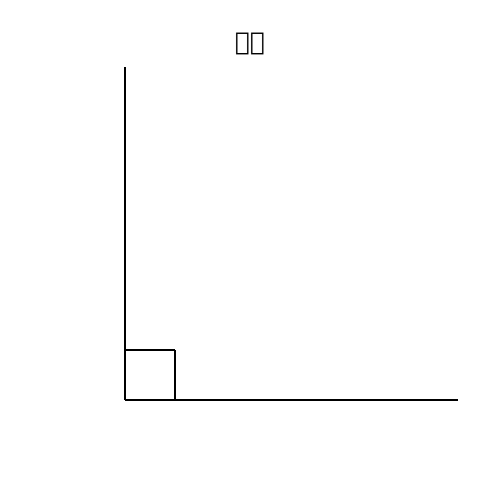

요청한 문장: 밑변이 3이고, 높이가 4인 직각삼각형 하나를 그려줘
추출된 개념: Right Triangle
추출된 인자: {'base': 3, 'height': 4}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <line x1="83" y1="416" x2="308" y2="416" stroke="black" stroke-width="2" />
    <line x1="308" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <line x1="83" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="286" y1="416" x2="286" y2="394" stroke="black" stroke-width="2" />
    <line x1="286" y1="394" x2="308" y2="394" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Triangle

**정의:**
A right triangle is a special type of triangle that has one angle which measures exactly 90 degrees (a right angle). This unique angle distinguishes it from other triangles where all angles are less than 90 degrees.

**기본 성질:**
1. **한 각이 직각:** 가장 중요한 특징은 한 꼭짓점

<IPython.core.display.Math object>

<IPython.core.display.Math object>

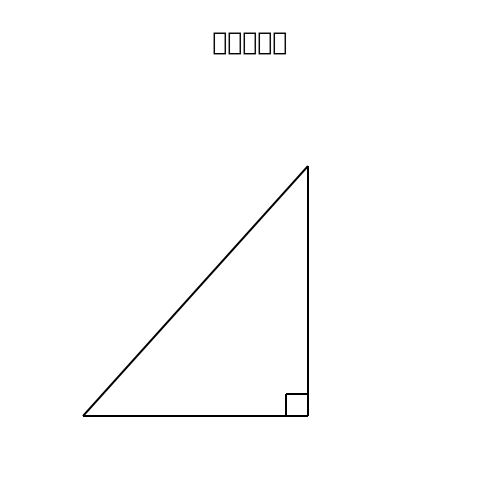

요청한 문장: 가로가 5, 세로가 3인 직사각형의 넓이
추출된 개념: Rectangle
추출된 인자: {'width': 5, 'height': 3}

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="250" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Rectangle 설명

**정의:**
사각형은 네 개의 직선으로 둘러싸인 평면 도형으로, 각 내각이 직각(90도)인 특징을 가지고 있습니다. 즉, 사각형의 네 모서리는 모두 직각을 이루며, 대변이 평행하고 길이가 같은 특성을 갖습니다.

**기본 성질:**
1. **대변의 길이가 같음:** 사각형의 두 쌍의 대변은 길이가 동일합니다. 예를 들어, 가로와 세로가 같은 길이를 가집니다.
2. **대각선이 서로 같음:** 사각형의 두 대각선은 길이가 같습니다. 즉, 사각형을 두 개의 동일한 삼각형으로 나눌 수 있습니다.
3. **내각의 합:** 사각형의 네 내각의 합은 항상 360도입니다.
4. **변의 배열:** 사각형은 여러 가지 형태로 배열될 수 있습니다. 예를 들어, 직사각형은 가로와 세로가 각각 다른 길이를 가질 수 있으며, 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 형태의 사각형입니다.

이러한 성질들로 인해 사각형은 우리 일상생활에서 매우 흔하게 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '2 × (밑변 + 높이)', 'area': '밑변 × 높이'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

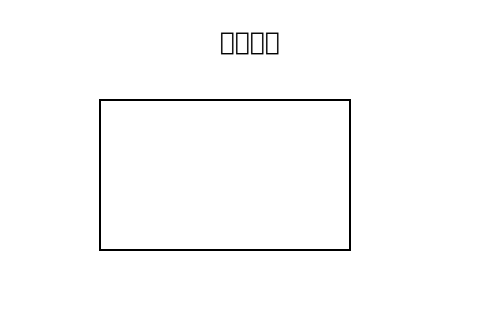

요청한 문장: 한 변의 길이가 2인 정사각형 하나를 그려줘
추출된 개념: Square
추출된 인자: {'length': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="200" height="200" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Square

**정의:**
사각형은 네 개의 변으로 이루어진 평면 도형입니다. 모든 내각이 직각(90도)이며, 반대편의 변들이 길이가 같아서 마주보는 두 변은 평행하고 길이가 동일합니다.

**기본 성질:**
1. **대변의 길이 동일:** 사각형의 마주보는 두 변은 길이가 같습니다. 예를 들어, 정사각형이나 직사각형에서는 모든 대변이 같은 길이를 가집니다.
2. **대각선의 성질:** 사각형의 대각선은 서로를 반으로 나눕니다. 즉, 대각선이 만나는 점에서 대각선을 잇는 선분들은 서로를 절반으로 나눕니다.
3. **변의 합:** 사각형의 네 변의 길이를 모두 더하면, 그 합은 사각형의 둘레를 나타냅니다. 예를 들어, 한 변의 길이가 \(a\)이고 다른 변의 길이가 \(b\)라면, 둘레는 \(a + b + a + b = 2(a + b)\)가 됩니다.
4. **정사각형의 특징:** 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 사각형입니다. 모든 대각선도 길이가 같고 서로를 직각으로 이룹니다.

이러한 성질들로 인해 사각형은 다양한 형태와 크기로 존재하며, 건축, 디자인, 그리고 일상생활에서 자주 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '4 \\times \\mathrm{한 변의 길이}', 'area': '\\m

<IPython.core.display.Math object>

<IPython.core.display.Math object>

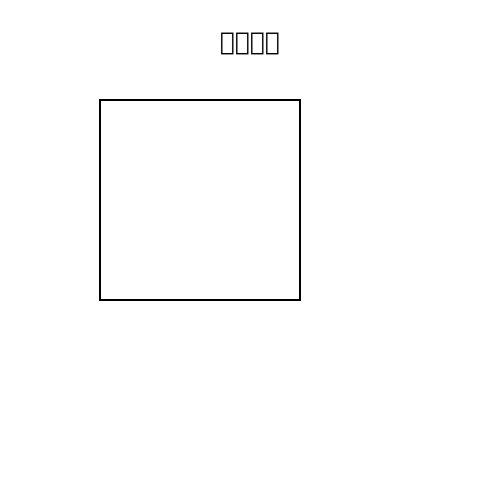

요청한 문장: 곧은선이 뭐야?
추출된 개념: 직선
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="75" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="175" font-size="25" text-anchor="middle">반직선</text>
    <circle cx="125" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="250" x2="500" y2="250" stroke="black" stroke-width="2" />
    <!-- 직선 -->
    <text x="250" y="300" font-size="25" text-anchor="middle">직선</text>
    <circle cx="125" cy="375" r="1" stroke="black"

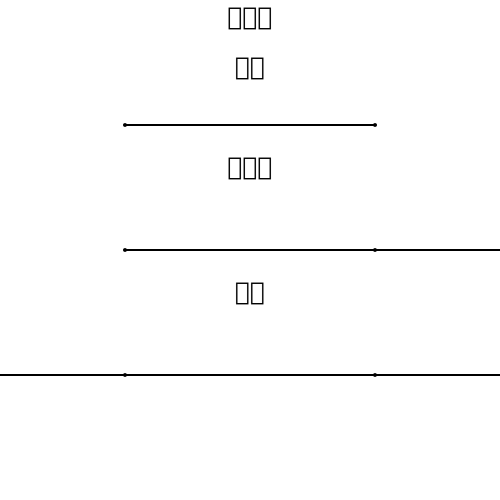

요청한 문장: 대표적인 굽은선을 그려줘
추출된 개념: 곡선
추출된 인자: {'type': '타원', 'description': '타원은 가장 대표적인 굽은선의 한 종류로, 두 초점 사이의 거리의 합이 일정한 점들의 집합으로 정의됩니다.'}

생성된 코드:
 
    <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">굽은선</text>
    <!-- 복잡한 S자 곡선 (두 개의 Cubic Bézier) -->
    <path d="M 100,400
    C 100,100 400,100 400,250
    C 400,400 100,400 100,100"
    stroke="black" fill="none" stroke-width="2"/>
    </svg>
    

생성된 설명:
 ### 곡선에 대한 설명

**정의:**
곡선은 직선이 아닌, 연속적으로 이어지는 점들의 모임으로 이루어진 도형입니다. 쉽게 말해, 직선처럼 일정한 방향으로만 움직이는 것이 아니라, 부드럽게 휘어지거나 굽어지는 형태를 가진 선을 말합니다.

**기본 성질:**
1. **연속성:** 곡선 위의 모든 점들은 부드럽게 이어져 있어, 어떤 작은 구간에서도 끊어지지 않고 이어집니다.
2. **길이:** 곡선의 길이는 그 곡선을 따라 측정한 총 거리입니다. 이 길이는 곡선의 모양에 따라 달라집니다. 예를 들어, 원의 둘레는 반지름에 따라 결정되며, 이는 곡선의 길이를 정확히 계산하는 방법 중 하나입니다.
3. **곡률:** 곡선이 얼마나 빠르게 방향을 바꾸는지를 나타내는 값입니다. 곡률이 크면 곡선이 더 급하게 굽어지고, 작으면 더 부드럽게 굽어집니다. 예를 들어, 원의 경우 모든 점에서 곡률이 일정합니다.
4. **접선:** 곡선 위의 어떤 점에서 그 점을 지나는 가장 가까운 직선을 접선이라고 합니다. 이 접

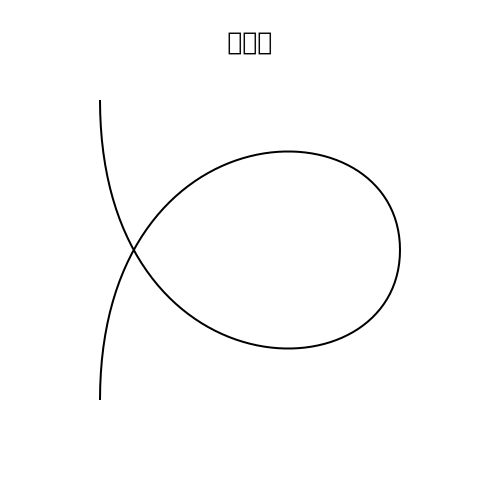

요청한 문장: 중심이 (0,0)이고 반지름이 2인 원을 그려주세요.
추출된 개념: Circle
추출된 인자: {'radius': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="100" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="250" y1="250" x2="350" y2="250" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Circle (원)

#### 정의:
원은 평면 위에서 한 점(중심)으로부터 일정한 거리(반지름)에 있는 모든 점들의 집합을 말합니다. 이 중심점을 기준으로 원 위의 모든 점들은 동일한 거리에 위치해 있습니다.

#### 기본 성질:
1. **둘레와 지름**: 원의 둘레는 지름에 π(약 3.14)를 곱한 값입니다. 즉, 둘레 = 지름 × π 입니다. 반대로 지름은 둘레를 π로 나누면 구할 수 있습니다.
   
2. **면적**: 원의 면적은 반지름의 제곱에 π를 곱한 값입니다. 공식으로 표현하면 면적 = π × 반지름2 입니다.

3. **대칭성**: 원은 중심을 기준으로 완벽하게 대칭입니다. 즉, 중심을 지나는 어떤 직선을 기준으로 원을 접어도 양쪽이 완전히 일치합니다.

4. **원주각과 호의 관계**: 원 위의 두 점을 잇는 호의 중앙각은 그 호에 대응하는 원주각의 두 배입니다. 예를 들어, 호의 중앙각이 θ라면 원주각은 θ/2가 됩니다.

이러한 성질들로 인해 원은 기하학에

<IPython.core.display.Math object>

<IPython.core.display.Math object>

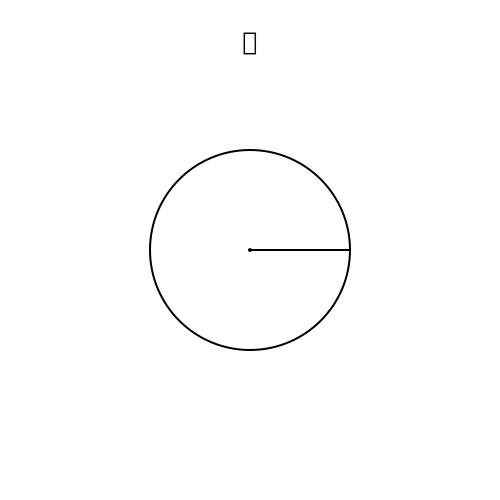

요청한 문장: 37° 각도를 그려줘
추출된 개념: 각도
추출된 인자: {'size': 37}

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
    <!-- 기준선 -->
    <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="333" x2="324.6588775118232" y2="182.54624421198793" stroke="black" stroke-width="2" />
    <!-- 각도 호 -->
    <path d="M 164.93177550236464,302.9092488423976 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>
    </svg>
    

생성된 설명:
 ### 각도에 대한 설명

**정의:**
각도는 두 직선이나 선분이 만나서 생기는 공간의 크기를 측정하는 방법입니다. 우리가 일상에서 자주 접하는 각도는 주로 도로 표지판에서 볼 수 있는 방향 지시나, 그림에서 선들이 만나는 부분을 표현할 때 사용됩니다.

**기본 성질:**
1. **직선의 각도:** 직선은 정확히 180도의 각도를 가집니다. 직선은 두 방향으로 무한히 이어지는 것처럼 보이지만, 실제로는 시작점과 끝점이 있습니다.
   
2. **직각 각도:** 직각은 90도를 의미합니다. 이는 우리가 흔히 사용하는 'L'자 모양의 모서리나 사각형의 모서리에서 볼 수 있습니다. 직각은 두 직선이 서로 수직으로 만나는 경우에 생깁니다.

3. **평행선과 각도:** 평행한 두 직선은 만나지 않기 때문에, 그들 사이의 각도는

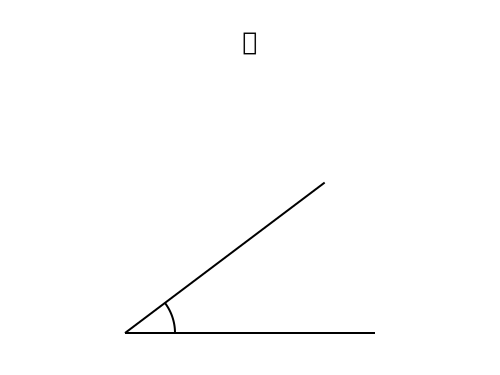

요청한 문장: 직각을 표현해줘
추출된 개념: Right Angle
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
    <!-- 기준선 -->
    <line x1="125" y1="400" x2="458" y2="400" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="400" x2="125" y2="67" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="175" y1="400" x2="175" y2="350" stroke="black" stroke-width="2" />
    <line x1="125" y1="350" x2="175" y2="350" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Angle

**정의:**
Right Angle은 기하학에서 가장 기본적인 각도 중 하나로, 정확히 90도를 이루는 각도를 말합니다. 이 각도는 직각이라고도 불리며, 직선이나 특정 도형의 모서리에서 만나는 두 변이 서로 수직으로 만나는 경우에 나타납니다.

**기본 성질:**
1. **크기:** Right Angle은 항상 정확히 90도입니다. 이는 모든 Right Angle이 동일한 크기를 가짐을 의미합니다.
2. **모양:** Right Angle은 보통 'L' 모양으로 쉽게 인식할 수 있습니다. 이 모양은 직각을 나타내는 데 자주 사용됩니다.
3. **도형과의 관계:** 직각은 사각형, 직사각형, 정사각형 등 다양한 도형의 모서리에서 발견됩니다. 특히, 직사각형이나 정사각형은 네 개

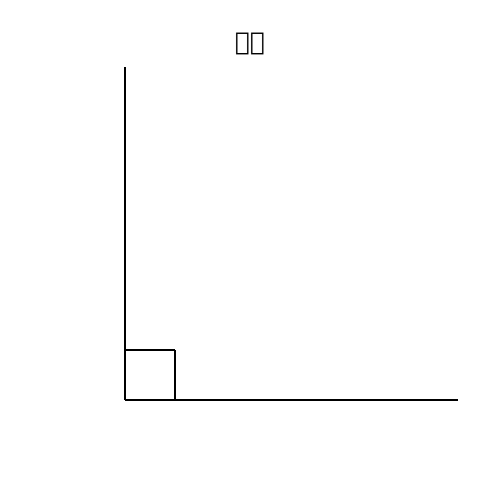

요청한 문장: 밑변이 3이고, 높이가 4인 직각삼각형 하나를 그려줘
추출된 개념: Right Triangle
추출된 인자: {'base': 3, 'height': 4}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <line x1="83" y1="416" x2="308" y2="416" stroke="black" stroke-width="2" />
    <line x1="308" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <line x1="83" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="286" y1="416" x2="286" y2="394" stroke="black" stroke-width="2" />
    <line x1="286" y1="394" x2="308" y2="394" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Triangle

**정의:**
A right triangle is a special type of triangle that has one angle which measures exactly 90 degrees (a right angle). This unique angle distinguishes it from other triangles where all angles are less than 90 degrees.

**기본 성질:**
1. **한 각이 직각:** 가장 중요한 특징은 한 꼭짓점

<IPython.core.display.Math object>

<IPython.core.display.Math object>

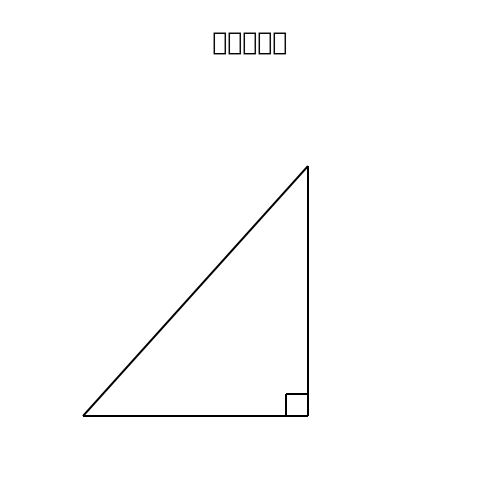

요청한 문장: 가로가 5, 세로가 3인 직사각형의 넓이
추출된 개념: Rectangle
추출된 인자: {'width': 5, 'height': 3}

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="250" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Rectangle 설명

**정의:**
사각형은 네 개의 직선으로 둘러싸인 평면 도형으로, 각 내각이 직각(90도)인 특징을 가지고 있습니다. 즉, 사각형의 네 모서리는 모두 직각을 이루며, 대변이 평행하고 길이가 같은 특성을 갖습니다.

**기본 성질:**
1. **대변의 길이가 같음:** 사각형의 두 쌍의 대변은 길이가 동일합니다. 예를 들어, 가로와 세로가 같은 길이를 가집니다.
2. **대각선이 서로 같음:** 사각형의 두 대각선은 길이가 같습니다. 즉, 사각형을 두 개의 동일한 삼각형으로 나눌 수 있습니다.
3. **내각의 합:** 사각형의 네 내각의 합은 항상 360도입니다.
4. **변의 배열:** 사각형은 여러 가지 형태로 배열될 수 있습니다. 예를 들어, 직사각형은 가로와 세로가 각각 다른 길이를 가질 수 있으며, 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 형태의 사각형입니다.

이러한 성질들로 인해 사각형은 우리 일상생활에서 매우 흔하게 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '2 × (밑변 + 높이)', 'area': '밑변 × 높이'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

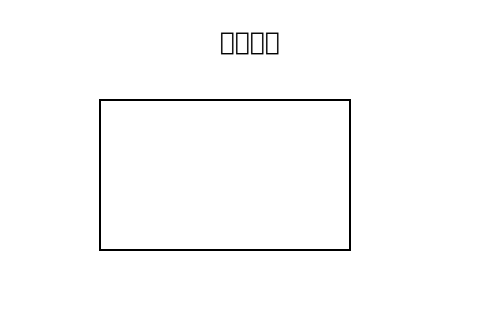

요청한 문장: 한 변의 길이가 2인 정사각형 하나를 그려줘
추출된 개념: Square
추출된 인자: {'length': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="200" height="200" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Square

**정의:**
사각형은 네 개의 변으로 이루어진 평면 도형입니다. 모든 내각이 직각(90도)이며, 반대편의 변들이 길이가 같아서 마주보는 두 변은 평행하고 길이가 동일합니다.

**기본 성질:**
1. **대변의 길이 동일:** 사각형의 마주보는 두 변은 길이가 같습니다. 예를 들어, 정사각형이나 직사각형에서는 모든 대변이 같은 길이를 가집니다.
2. **대각선의 성질:** 사각형의 대각선은 서로를 반으로 나눕니다. 즉, 대각선이 만나는 점에서 대각선을 잇는 선분들은 서로를 절반으로 나눕니다.
3. **변의 합:** 사각형의 네 변의 길이를 모두 더하면, 그 합은 사각형의 둘레를 나타냅니다. 예를 들어, 한 변의 길이가 \(a\)이고 다른 변의 길이가 \(b\)라면, 둘레는 \(a + b + a + b = 2(a + b)\)가 됩니다.
4. **정사각형의 특징:** 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 사각형입니다. 모든 대각선도 길이가 같고 서로를 직각으로 이룹니다.

이러한 성질들로 인해 사각형은 다양한 형태와 크기로 존재하며, 건축, 디자인, 그리고 일상생활에서 자주 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '4 \\times \\mathrm{한 변의 길이}', 'area': '\\m

<IPython.core.display.Math object>

<IPython.core.display.Math object>

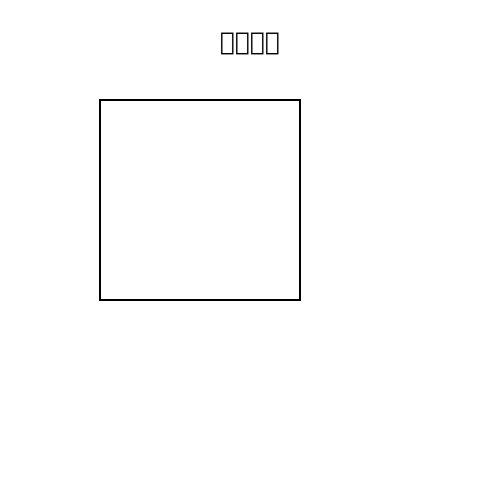

요청한 문장: 곧은선이 뭐야?
추출된 개념: 직선
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="75" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="175" font-size="25" text-anchor="middle">반직선</text>
    <circle cx="125" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="250" x2="500" y2="250" stroke="black" stroke-width="2" />
    <!-- 직선 -->
    <text x="250" y="300" font-size="25" text-anchor="middle">직선</text>
    <circle cx="125" cy="375" r="1" stroke="black"

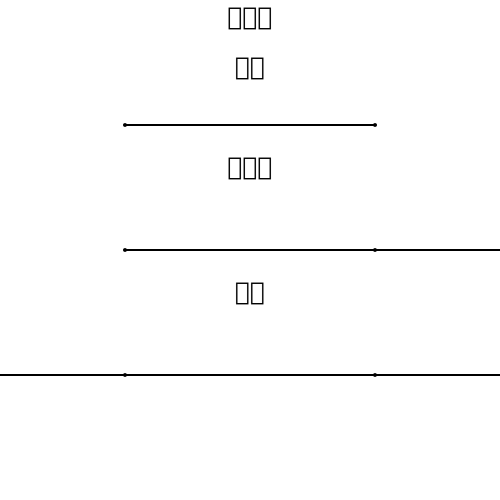

요청한 문장: 대표적인 굽은선을 그려줘
추출된 개념: 곡선
추출된 인자: {'type': '타원', 'description': '타원은 가장 대표적인 굽은선의 한 종류로, 두 초점 사이의 거리의 합이 일정한 점들의 집합으로 정의됩니다.'}

생성된 코드:
 
    <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">굽은선</text>
    <!-- 복잡한 S자 곡선 (두 개의 Cubic Bézier) -->
    <path d="M 100,400
    C 100,100 400,100 400,250
    C 400,400 100,400 100,100"
    stroke="black" fill="none" stroke-width="2"/>
    </svg>
    

생성된 설명:
 ### 곡선에 대한 설명

**정의:**
곡선은 직선이 아닌, 연속적으로 이어지는 점들의 모임으로 이루어진 도형입니다. 쉽게 말해, 직선처럼 일정한 방향으로만 움직이는 것이 아니라, 부드럽게 휘어지거나 굽어지는 형태를 가진 선을 말합니다.

**기본 성질:**
1. **연속성:** 곡선 위의 모든 점들은 부드럽게 이어져 있어, 어떤 작은 구간에서도 끊어지지 않고 이어집니다.
2. **길이:** 곡선의 길이는 그 곡선을 따라 측정한 총 거리입니다. 이 길이는 곡선의 모양에 따라 달라집니다. 예를 들어, 원의 둘레는 반지름에 따라 결정되며, 이는 곡선의 길이를 정확히 계산하는 방법 중 하나입니다.
3. **곡률:** 곡선이 얼마나 빠르게 방향을 바꾸는지를 나타내는 값입니다. 곡률이 크면 곡선이 더 급하게 굽어지고, 작으면 더 부드럽게 굽어집니다. 예를 들어, 원의 경우 모든 점에서 곡률이 일정합니다.
4. **접선:** 곡선 위의 어떤 점에서 그 점을 지나는 가장 가까운 직선을 접선이라고 합니다. 이 접

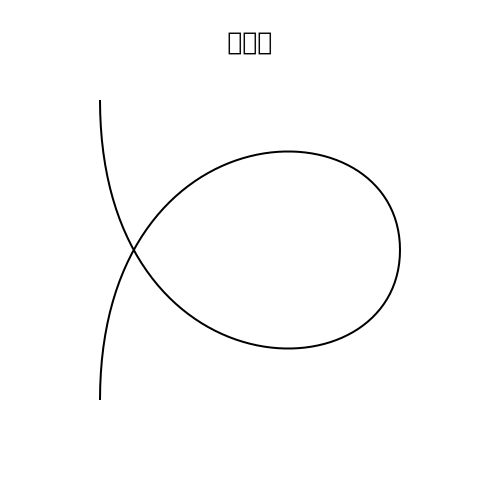

요청한 문장: 중심이 (0,0)이고 반지름이 2인 원을 그려주세요.
추출된 개념: Circle
추출된 인자: {'radius': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="100" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="250" y1="250" x2="350" y2="250" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Circle (원)

#### 정의:
원은 평면 위에서 한 점(중심)으로부터 일정한 거리(반지름)에 있는 모든 점들의 집합을 말합니다. 이 중심점을 기준으로 원 위의 모든 점들은 동일한 거리에 위치해 있습니다.

#### 기본 성질:
1. **둘레와 지름**: 원의 둘레는 지름에 π(약 3.14)를 곱한 값입니다. 즉, 둘레 = 지름 × π 입니다. 반대로 지름은 둘레를 π로 나누면 구할 수 있습니다.
   
2. **면적**: 원의 면적은 반지름의 제곱에 π를 곱한 값입니다. 공식으로 표현하면 면적 = π × 반지름2 입니다.

3. **대칭성**: 원은 중심을 기준으로 완벽하게 대칭입니다. 즉, 중심을 지나는 어떤 직선을 기준으로 원을 접어도 양쪽이 완전히 일치합니다.

4. **원주각과 호의 관계**: 원 위의 두 점을 잇는 호의 중앙각은 그 호에 대응하는 원주각의 두 배입니다. 예를 들어, 호의 중앙각이 θ라면 원주각은 θ/2가 됩니다.

이러한 성질들로 인해 원은 기하학에

<IPython.core.display.Math object>

<IPython.core.display.Math object>

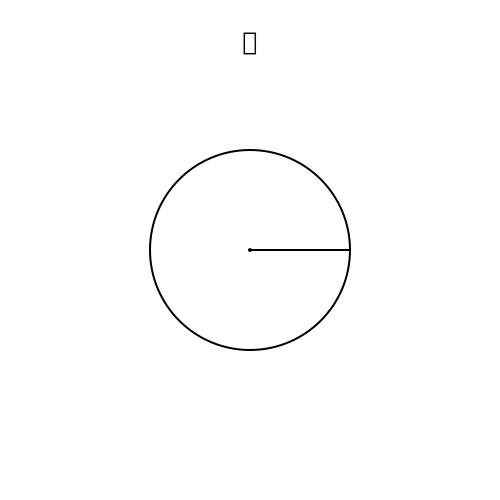

요청한 문장: 37° 각도를 그려줘
추출된 개념: 각도
추출된 인자: {'size': 37}

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
    <!-- 기준선 -->
    <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="333" x2="324.6588775118232" y2="182.54624421198793" stroke="black" stroke-width="2" />
    <!-- 각도 호 -->
    <path d="M 164.93177550236464,302.9092488423976 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>
    </svg>
    

생성된 설명:
 ### 각도에 대한 설명

**정의:**
각도는 두 직선이나 선분이 만나서 생기는 공간의 크기를 측정하는 방법입니다. 우리가 일상에서 자주 접하는 각도는 주로 도로 표지판에서 볼 수 있는 방향 지시나, 그림에서 선들이 만나는 부분을 표현할 때 사용됩니다.

**기본 성질:**
1. **직선의 각도:** 직선은 정확히 180도의 각도를 가집니다. 직선은 두 방향으로 무한히 이어지는 것처럼 보이지만, 실제로는 시작점과 끝점이 있습니다.
   
2. **직각 각도:** 직각은 90도를 의미합니다. 이는 우리가 흔히 사용하는 'L'자 모양의 모서리나 사각형의 모서리에서 볼 수 있습니다. 직각은 두 직선이 서로 수직으로 만나는 경우에 생깁니다.

3. **평행선과 각도:** 평행한 두 직선은 만나지 않기 때문에, 그들 사이의 각도는

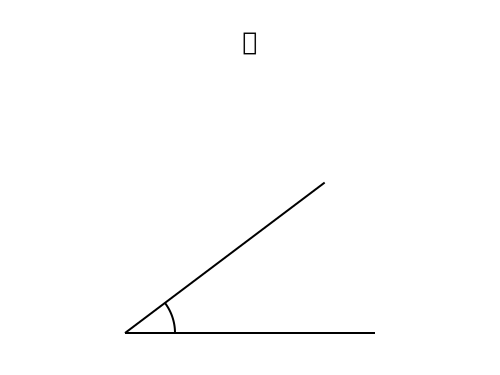

요청한 문장: 직각을 표현해줘
추출된 개념: Right Angle
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
    <!-- 기준선 -->
    <line x1="125" y1="400" x2="458" y2="400" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="400" x2="125" y2="67" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="175" y1="400" x2="175" y2="350" stroke="black" stroke-width="2" />
    <line x1="125" y1="350" x2="175" y2="350" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Angle

**정의:**
Right Angle은 기하학에서 가장 기본적인 각도 중 하나로, 정확히 90도를 이루는 각도를 말합니다. 이 각도는 직각이라고도 불리며, 직선이나 특정 도형의 모서리에서 만나는 두 변이 서로 수직으로 만나는 경우에 나타납니다.

**기본 성질:**
1. **크기:** Right Angle은 항상 정확히 90도입니다. 이는 모든 Right Angle이 동일한 크기를 가짐을 의미합니다.
2. **모양:** Right Angle은 보통 'L' 모양으로 쉽게 인식할 수 있습니다. 이 모양은 직각을 나타내는 데 자주 사용됩니다.
3. **도형과의 관계:** 직각은 사각형, 직사각형, 정사각형 등 다양한 도형의 모서리에서 발견됩니다. 특히, 직사각형이나 정사각형은 네 개

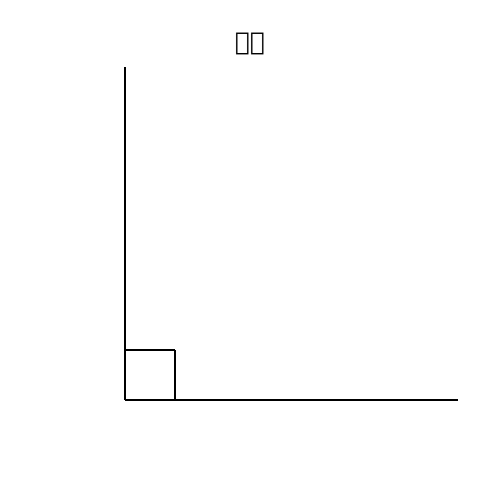

요청한 문장: 밑변이 3이고, 높이가 4인 직각삼각형 하나를 그려줘
추출된 개념: Right Triangle
추출된 인자: {'base': 3, 'height': 4}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <line x1="83" y1="416" x2="308" y2="416" stroke="black" stroke-width="2" />
    <line x1="308" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <line x1="83" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="286" y1="416" x2="286" y2="394" stroke="black" stroke-width="2" />
    <line x1="286" y1="394" x2="308" y2="394" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Triangle

**정의:**
A right triangle is a special type of triangle that has one angle which measures exactly 90 degrees (a right angle). This unique angle distinguishes it from other triangles where all angles are less than 90 degrees.

**기본 성질:**
1. **한 각이 직각:** 가장 중요한 특징은 한 꼭짓점

<IPython.core.display.Math object>

<IPython.core.display.Math object>

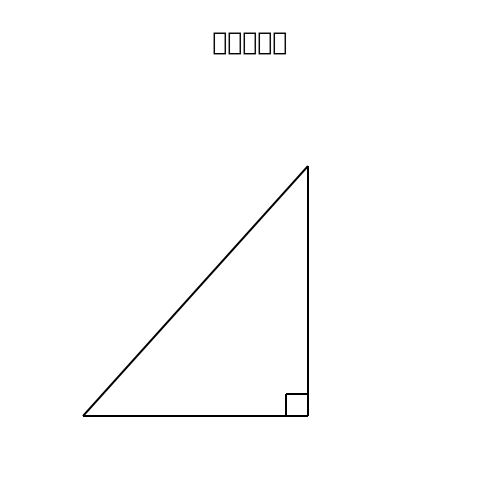

요청한 문장: 가로가 5, 세로가 3인 직사각형의 넓이
추출된 개념: Rectangle
추출된 인자: {'width': 5, 'height': 3}

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="250" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Rectangle 설명

**정의:**
사각형은 네 개의 직선으로 둘러싸인 평면 도형으로, 각 내각이 직각(90도)인 특징을 가지고 있습니다. 즉, 사각형의 네 모서리는 모두 직각을 이루며, 대변이 평행하고 길이가 같은 특성을 갖습니다.

**기본 성질:**
1. **대변의 길이가 같음:** 사각형의 두 쌍의 대변은 길이가 동일합니다. 예를 들어, 가로와 세로가 같은 길이를 가집니다.
2. **대각선이 서로 같음:** 사각형의 두 대각선은 길이가 같습니다. 즉, 사각형을 두 개의 동일한 삼각형으로 나눌 수 있습니다.
3. **내각의 합:** 사각형의 네 내각의 합은 항상 360도입니다.
4. **변의 배열:** 사각형은 여러 가지 형태로 배열될 수 있습니다. 예를 들어, 직사각형은 가로와 세로가 각각 다른 길이를 가질 수 있으며, 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 형태의 사각형입니다.

이러한 성질들로 인해 사각형은 우리 일상생활에서 매우 흔하게 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '2 × (밑변 + 높이)', 'area': '밑변 × 높이'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

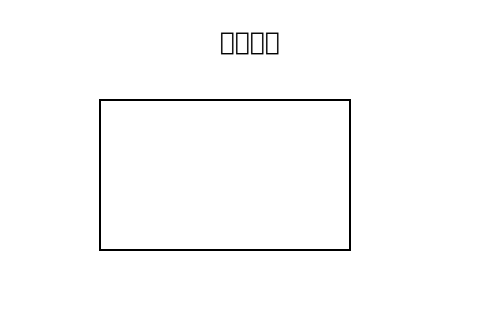

요청한 문장: 한 변의 길이가 2인 정사각형 하나를 그려줘
추출된 개념: Square
추출된 인자: {'length': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="200" height="200" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Square

**정의:**
사각형은 네 개의 변으로 이루어진 평면 도형입니다. 모든 내각이 직각(90도)이며, 반대편의 변들이 길이가 같아서 마주보는 두 변은 평행하고 길이가 동일합니다.

**기본 성질:**
1. **대변의 길이 동일:** 사각형의 마주보는 두 변은 길이가 같습니다. 예를 들어, 정사각형이나 직사각형에서는 모든 대변이 같은 길이를 가집니다.
2. **대각선의 성질:** 사각형의 대각선은 서로를 반으로 나눕니다. 즉, 대각선이 만나는 점에서 대각선을 잇는 선분들은 서로를 절반으로 나눕니다.
3. **변의 합:** 사각형의 네 변의 길이를 모두 더하면, 그 합은 사각형의 둘레를 나타냅니다. 예를 들어, 한 변의 길이가 \(a\)이고 다른 변의 길이가 \(b\)라면, 둘레는 \(a + b + a + b = 2(a + b)\)가 됩니다.
4. **정사각형의 특징:** 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 사각형입니다. 모든 대각선도 길이가 같고 서로를 직각으로 이룹니다.

이러한 성질들로 인해 사각형은 다양한 형태와 크기로 존재하며, 건축, 디자인, 그리고 일상생활에서 자주 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '4 \\times \\mathrm{한 변의 길이}', 'area': '\\m

<IPython.core.display.Math object>

<IPython.core.display.Math object>

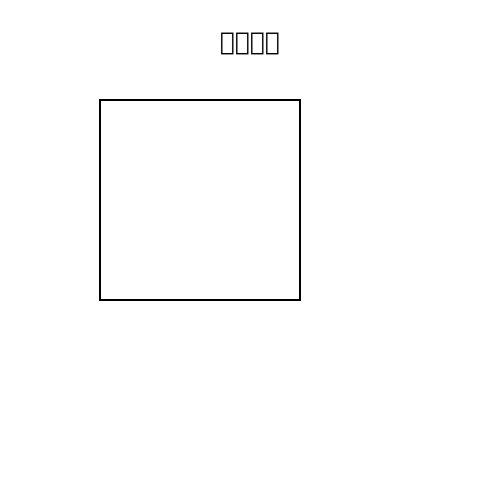

요청한 문장: 곧은선이 뭐야?
추출된 개념: 직선
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="75" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="175" font-size="25" text-anchor="middle">반직선</text>
    <circle cx="125" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="250" x2="500" y2="250" stroke="black" stroke-width="2" />
    <!-- 직선 -->
    <text x="250" y="300" font-size="25" text-anchor="middle">직선</text>
    <circle cx="125" cy="375" r="1" stroke="black"

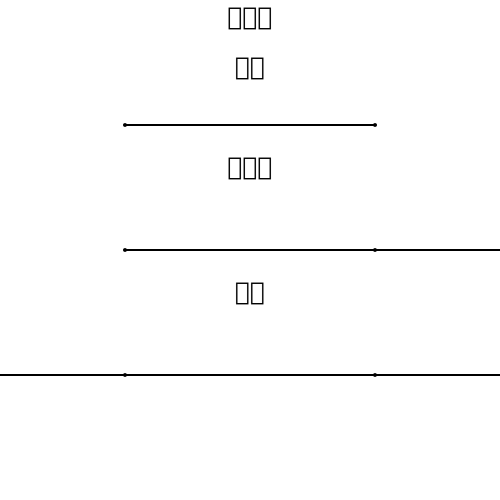

요청한 문장: 대표적인 굽은선을 그려줘
추출된 개념: 곡선
추출된 인자: {'type': '타원', 'description': '타원은 가장 대표적인 굽은선의 한 종류로, 두 초점 사이의 거리의 합이 일정한 점들의 집합으로 정의됩니다.'}

생성된 코드:
 
    <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">굽은선</text>
    <!-- 복잡한 S자 곡선 (두 개의 Cubic Bézier) -->
    <path d="M 100,400
    C 100,100 400,100 400,250
    C 400,400 100,400 100,100"
    stroke="black" fill="none" stroke-width="2"/>
    </svg>
    

생성된 설명:
 ### 곡선에 대한 설명

**정의:**
곡선은 직선이 아닌, 연속적으로 이어지는 점들의 모임으로 이루어진 도형입니다. 쉽게 말해, 직선처럼 일정한 방향으로만 움직이는 것이 아니라, 부드럽게 휘어지거나 굽어지는 형태를 가진 선을 말합니다.

**기본 성질:**
1. **연속성:** 곡선 위의 모든 점들은 부드럽게 이어져 있어, 어떤 작은 구간에서도 끊어지지 않고 이어집니다.
2. **길이:** 곡선의 길이는 그 곡선을 따라 측정한 총 거리입니다. 이 길이는 곡선의 모양에 따라 달라집니다. 예를 들어, 원의 둘레는 반지름에 따라 결정되며, 이는 곡선의 길이를 정확히 계산하는 방법 중 하나입니다.
3. **곡률:** 곡선이 얼마나 빠르게 방향을 바꾸는지를 나타내는 값입니다. 곡률이 크면 곡선이 더 급하게 굽어지고, 작으면 더 부드럽게 굽어집니다. 예를 들어, 원의 경우 모든 점에서 곡률이 일정합니다.
4. **접선:** 곡선 위의 어떤 점에서 그 점을 지나는 가장 가까운 직선을 접선이라고 합니다. 이 접

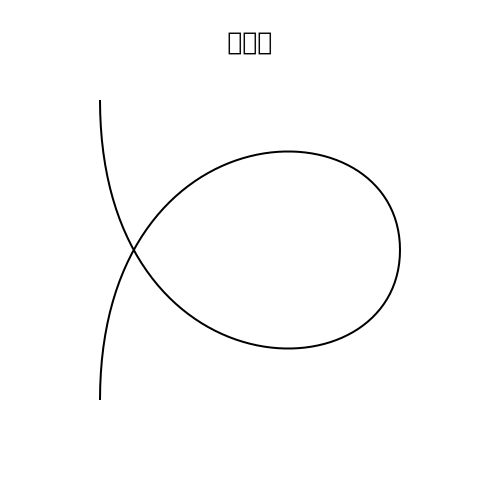

요청한 문장: 중심이 (0,0)이고 반지름이 2인 원을 그려주세요.
추출된 개념: Circle
추출된 인자: {'radius': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="100" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="250" y1="250" x2="350" y2="250" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Circle (원)

#### 정의:
원은 평면 위에서 한 점(중심)으로부터 일정한 거리(반지름)에 있는 모든 점들의 집합을 말합니다. 이 중심점을 기준으로 원 위의 모든 점들은 동일한 거리에 위치해 있습니다.

#### 기본 성질:
1. **둘레와 지름**: 원의 둘레는 지름에 π(약 3.14)를 곱한 값입니다. 즉, 둘레 = 지름 × π 입니다. 반대로 지름은 둘레를 π로 나누면 구할 수 있습니다.
   
2. **면적**: 원의 면적은 반지름의 제곱에 π를 곱한 값입니다. 공식으로 표현하면 면적 = π × 반지름2 입니다.

3. **대칭성**: 원은 중심을 기준으로 완벽하게 대칭입니다. 즉, 중심을 지나는 어떤 직선을 기준으로 원을 접어도 양쪽이 완전히 일치합니다.

4. **원주각과 호의 관계**: 원 위의 두 점을 잇는 호의 중앙각은 그 호에 대응하는 원주각의 두 배입니다. 예를 들어, 호의 중앙각이 θ라면 원주각은 θ/2가 됩니다.

이러한 성질들로 인해 원은 기하학에

<IPython.core.display.Math object>

<IPython.core.display.Math object>

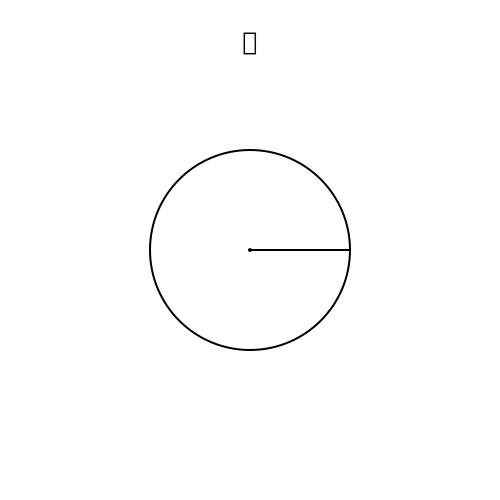

요청한 문장: 37° 각도를 그려줘
추출된 개념: 각도
추출된 인자: {'size': 37}

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
    <!-- 기준선 -->
    <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="333" x2="324.6588775118232" y2="182.54624421198793" stroke="black" stroke-width="2" />
    <!-- 각도 호 -->
    <path d="M 164.93177550236464,302.9092488423976 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>
    </svg>
    

생성된 설명:
 ### 각도에 대한 설명

**정의:**
각도는 두 직선이나 선분이 만나서 생기는 공간의 크기를 측정하는 방법입니다. 우리가 일상에서 자주 접하는 각도는 주로 도로 표지판에서 볼 수 있는 방향 지시나, 그림에서 선들이 만나는 부분을 표현할 때 사용됩니다.

**기본 성질:**
1. **직선의 각도:** 직선은 정확히 180도의 각도를 가집니다. 직선은 두 방향으로 무한히 이어지는 것처럼 보이지만, 실제로는 시작점과 끝점이 있습니다.
   
2. **직각 각도:** 직각은 90도를 의미합니다. 이는 우리가 흔히 사용하는 'L'자 모양의 모서리나 사각형의 모서리에서 볼 수 있습니다. 직각은 두 직선이 서로 수직으로 만나는 경우에 생깁니다.

3. **평행선과 각도:** 평행한 두 직선은 만나지 않기 때문에, 그들 사이의 각도는

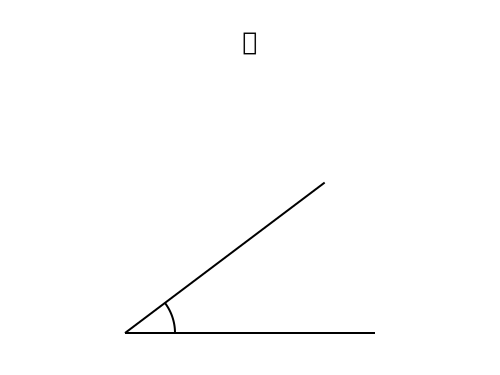

요청한 문장: 직각을 표현해줘
추출된 개념: Right Angle
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
    <!-- 기준선 -->
    <line x1="125" y1="400" x2="458" y2="400" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="400" x2="125" y2="67" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="175" y1="400" x2="175" y2="350" stroke="black" stroke-width="2" />
    <line x1="125" y1="350" x2="175" y2="350" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Angle

**정의:**
Right Angle은 기하학에서 가장 기본적인 각도 중 하나로, 정확히 90도를 이루는 각도를 말합니다. 이 각도는 직각이라고도 불리며, 직선이나 특정 도형의 모서리에서 만나는 두 변이 서로 수직으로 만나는 경우에 나타납니다.

**기본 성질:**
1. **크기:** Right Angle은 항상 정확히 90도입니다. 이는 모든 Right Angle이 동일한 크기를 가짐을 의미합니다.
2. **모양:** Right Angle은 보통 'L' 모양으로 쉽게 인식할 수 있습니다. 이 모양은 직각을 나타내는 데 자주 사용됩니다.
3. **도형과의 관계:** 직각은 사각형, 직사각형, 정사각형 등 다양한 도형의 모서리에서 발견됩니다. 특히, 직사각형이나 정사각형은 네 개

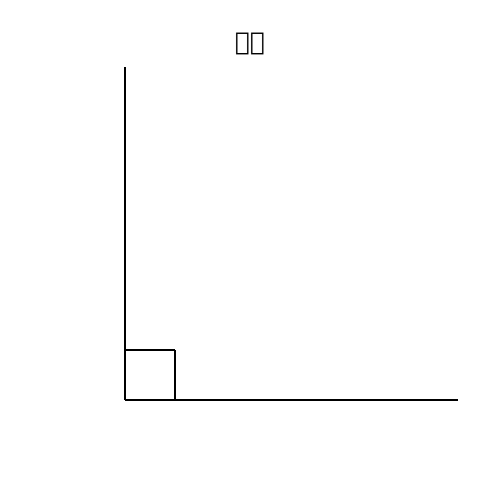

요청한 문장: 밑변이 3이고, 높이가 4인 직각삼각형 하나를 그려줘
추출된 개념: Right Triangle
추출된 인자: {'base': 3, 'height': 4}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <line x1="83" y1="416" x2="308" y2="416" stroke="black" stroke-width="2" />
    <line x1="308" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <line x1="83" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="286" y1="416" x2="286" y2="394" stroke="black" stroke-width="2" />
    <line x1="286" y1="394" x2="308" y2="394" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Triangle

**정의:**
A right triangle is a special type of triangle that has one angle which measures exactly 90 degrees (a right angle). This unique angle distinguishes it from other triangles where all angles are less than 90 degrees.

**기본 성질:**
1. **한 각이 직각:** 가장 중요한 특징은 한 꼭짓점

<IPython.core.display.Math object>

<IPython.core.display.Math object>

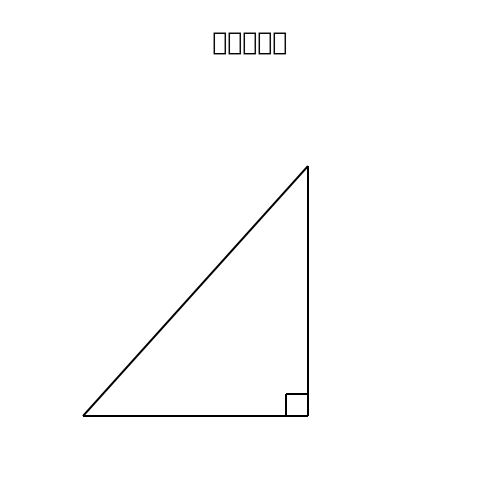

요청한 문장: 가로가 5, 세로가 3인 직사각형의 넓이
추출된 개념: Rectangle
추출된 인자: {'width': 5, 'height': 3}

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="250" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Rectangle 설명

**정의:**
사각형은 네 개의 직선으로 둘러싸인 평면 도형으로, 각 내각이 직각(90도)인 특징을 가지고 있습니다. 즉, 사각형의 네 모서리는 모두 직각을 이루며, 대변이 평행하고 길이가 같은 특성을 갖습니다.

**기본 성질:**
1. **대변의 길이가 같음:** 사각형의 두 쌍의 대변은 길이가 동일합니다. 예를 들어, 가로와 세로가 같은 길이를 가집니다.
2. **대각선이 서로 같음:** 사각형의 두 대각선은 길이가 같습니다. 즉, 사각형을 두 개의 동일한 삼각형으로 나눌 수 있습니다.
3. **내각의 합:** 사각형의 네 내각의 합은 항상 360도입니다.
4. **변의 배열:** 사각형은 여러 가지 형태로 배열될 수 있습니다. 예를 들어, 직사각형은 가로와 세로가 각각 다른 길이를 가질 수 있으며, 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 형태의 사각형입니다.

이러한 성질들로 인해 사각형은 우리 일상생활에서 매우 흔하게 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '2 × (밑변 + 높이)', 'area': '밑변 × 높이'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

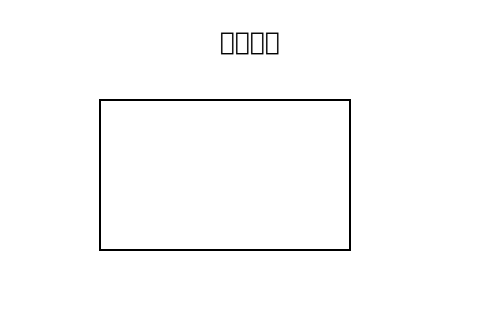

요청한 문장: 한 변의 길이가 2인 정사각형 하나를 그려줘
추출된 개념: Square
추출된 인자: {'length': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="200" height="200" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Square

**정의:**
사각형은 네 개의 변으로 이루어진 평면 도형입니다. 모든 내각이 직각(90도)이며, 반대편의 변들이 길이가 같아서 마주보는 두 변은 평행하고 길이가 동일합니다.

**기본 성질:**
1. **대변의 길이 동일:** 사각형의 마주보는 두 변은 길이가 같습니다. 예를 들어, 정사각형이나 직사각형에서는 모든 대변이 같은 길이를 가집니다.
2. **대각선의 성질:** 사각형의 대각선은 서로를 반으로 나눕니다. 즉, 대각선이 만나는 점에서 대각선을 잇는 선분들은 서로를 절반으로 나눕니다.
3. **변의 합:** 사각형의 네 변의 길이를 모두 더하면, 그 합은 사각형의 둘레를 나타냅니다. 예를 들어, 한 변의 길이가 \(a\)이고 다른 변의 길이가 \(b\)라면, 둘레는 \(a + b + a + b = 2(a + b)\)가 됩니다.
4. **정사각형의 특징:** 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 사각형입니다. 모든 대각선도 길이가 같고 서로를 직각으로 이룹니다.

이러한 성질들로 인해 사각형은 다양한 형태와 크기로 존재하며, 건축, 디자인, 그리고 일상생활에서 자주 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '4 \\times \\mathrm{한 변의 길이}', 'area': '\\m

<IPython.core.display.Math object>

<IPython.core.display.Math object>

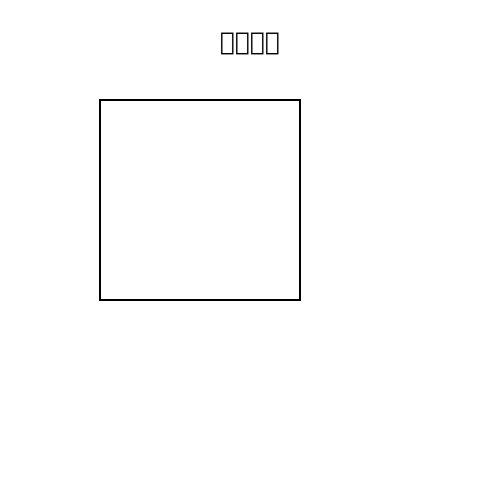

요청한 문장: 곧은선이 뭐야?
추출된 개념: 직선
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="75" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="175" font-size="25" text-anchor="middle">반직선</text>
    <circle cx="125" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="250" x2="500" y2="250" stroke="black" stroke-width="2" />
    <!-- 직선 -->
    <text x="250" y="300" font-size="25" text-anchor="middle">직선</text>
    <circle cx="125" cy="375" r="1" stroke="black"

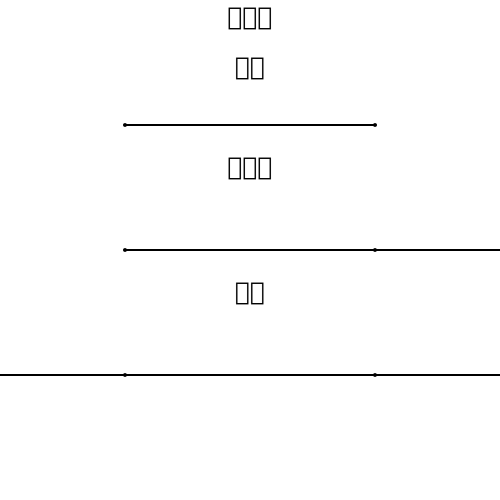

요청한 문장: 대표적인 굽은선을 그려줘
추출된 개념: 곡선
추출된 인자: {'type': '타원', 'description': '타원은 가장 대표적인 굽은선의 한 종류로, 두 초점 사이의 거리의 합이 일정한 점들의 집합으로 정의됩니다.'}

생성된 코드:
 
    <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">굽은선</text>
    <!-- 복잡한 S자 곡선 (두 개의 Cubic Bézier) -->
    <path d="M 100,400
    C 100,100 400,100 400,250
    C 400,400 100,400 100,100"
    stroke="black" fill="none" stroke-width="2"/>
    </svg>
    

생성된 설명:
 ### 곡선에 대한 설명

**정의:**
곡선은 직선이 아닌, 연속적으로 이어지는 점들의 모임으로 이루어진 도형입니다. 쉽게 말해, 직선처럼 일정한 방향으로만 움직이는 것이 아니라, 부드럽게 휘어지거나 굽어지는 형태를 가진 선을 말합니다.

**기본 성질:**
1. **연속성:** 곡선 위의 모든 점들은 부드럽게 이어져 있어, 어떤 작은 구간에서도 끊어지지 않고 이어집니다.
2. **길이:** 곡선의 길이는 그 곡선을 따라 측정한 총 거리입니다. 이 길이는 곡선의 모양에 따라 달라집니다. 예를 들어, 원의 둘레는 반지름에 따라 결정되며, 이는 곡선의 길이를 정확히 계산하는 방법 중 하나입니다.
3. **곡률:** 곡선이 얼마나 빠르게 방향을 바꾸는지를 나타내는 값입니다. 곡률이 크면 곡선이 더 급하게 굽어지고, 작으면 더 부드럽게 굽어집니다. 예를 들어, 원의 경우 모든 점에서 곡률이 일정합니다.
4. **접선:** 곡선 위의 어떤 점에서 그 점을 지나는 가장 가까운 직선을 접선이라고 합니다. 이 접

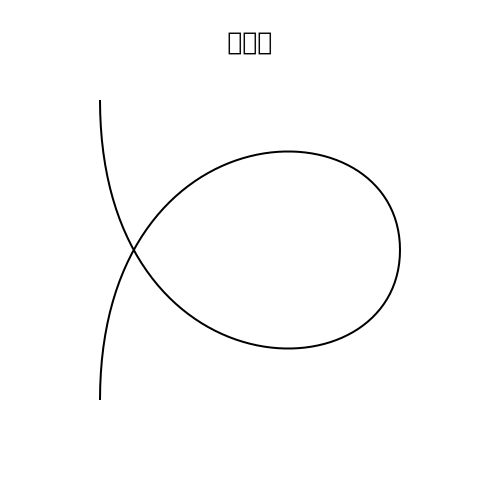

요청한 문장: 중심이 (0,0)이고 반지름이 2인 원을 그려주세요.
추출된 개념: Circle
추출된 인자: {'radius': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="100" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="250" y1="250" x2="350" y2="250" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Circle (원)

#### 정의:
원은 평면 위에서 한 점(중심)으로부터 일정한 거리(반지름)에 있는 모든 점들의 집합을 말합니다. 이 중심점을 기준으로 원 위의 모든 점들은 동일한 거리에 위치해 있습니다.

#### 기본 성질:
1. **둘레와 지름**: 원의 둘레는 지름에 π(약 3.14)를 곱한 값입니다. 즉, 둘레 = 지름 × π 입니다. 반대로 지름은 둘레를 π로 나누면 구할 수 있습니다.
   
2. **면적**: 원의 면적은 반지름의 제곱에 π를 곱한 값입니다. 공식으로 표현하면 면적 = π × 반지름2 입니다.

3. **대칭성**: 원은 중심을 기준으로 완벽하게 대칭입니다. 즉, 중심을 지나는 어떤 직선을 기준으로 원을 접어도 양쪽이 완전히 일치합니다.

4. **원주각과 호의 관계**: 원 위의 두 점을 잇는 호의 중앙각은 그 호에 대응하는 원주각의 두 배입니다. 예를 들어, 호의 중앙각이 θ라면 원주각은 θ/2가 됩니다.

이러한 성질들로 인해 원은 기하학에

<IPython.core.display.Math object>

<IPython.core.display.Math object>

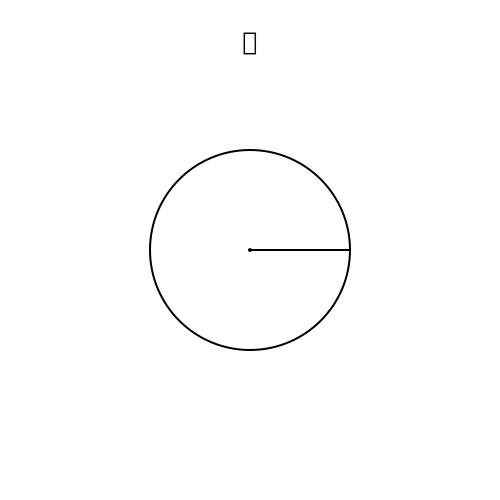

요청한 문장: 37° 각도를 그려줘
추출된 개념: 각도
추출된 인자: {'size': 37}

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
    <!-- 기준선 -->
    <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="333" x2="324.6588775118232" y2="182.54624421198793" stroke="black" stroke-width="2" />
    <!-- 각도 호 -->
    <path d="M 164.93177550236464,302.9092488423976 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>
    </svg>
    

생성된 설명:
 ### 각도에 대한 설명

**정의:**
각도는 두 직선이나 선분이 만나서 생기는 공간의 크기를 측정하는 방법입니다. 우리가 일상에서 자주 접하는 각도는 주로 도로 표지판에서 볼 수 있는 방향 지시나, 그림에서 선들이 만나는 부분을 표현할 때 사용됩니다.

**기본 성질:**
1. **직선의 각도:** 직선은 정확히 180도의 각도를 가집니다. 직선은 두 방향으로 무한히 이어지는 것처럼 보이지만, 실제로는 시작점과 끝점이 있습니다.
   
2. **직각 각도:** 직각은 90도를 의미합니다. 이는 우리가 흔히 사용하는 'L'자 모양의 모서리나 사각형의 모서리에서 볼 수 있습니다. 직각은 두 직선이 서로 수직으로 만나는 경우에 생깁니다.

3. **평행선과 각도:** 평행한 두 직선은 만나지 않기 때문에, 그들 사이의 각도는

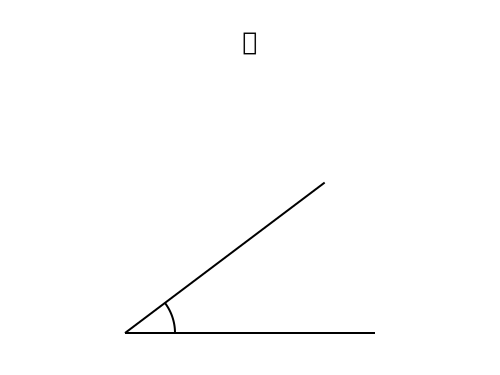

요청한 문장: 직각을 표현해줘
추출된 개념: Right Angle
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
    <!-- 기준선 -->
    <line x1="125" y1="400" x2="458" y2="400" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="400" x2="125" y2="67" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="175" y1="400" x2="175" y2="350" stroke="black" stroke-width="2" />
    <line x1="125" y1="350" x2="175" y2="350" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Angle

**정의:**
Right Angle은 기하학에서 가장 기본적인 각도 중 하나로, 정확히 90도를 이루는 각도를 말합니다. 이 각도는 직각이라고도 불리며, 직선이나 특정 도형의 모서리에서 만나는 두 변이 서로 수직으로 만나는 경우에 나타납니다.

**기본 성질:**
1. **크기:** Right Angle은 항상 정확히 90도입니다. 이는 모든 Right Angle이 동일한 크기를 가짐을 의미합니다.
2. **모양:** Right Angle은 보통 'L' 모양으로 쉽게 인식할 수 있습니다. 이 모양은 직각을 나타내는 데 자주 사용됩니다.
3. **도형과의 관계:** 직각은 사각형, 직사각형, 정사각형 등 다양한 도형의 모서리에서 발견됩니다. 특히, 직사각형이나 정사각형은 네 개

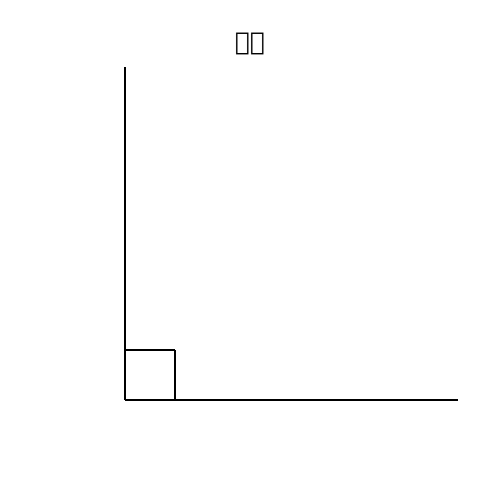

요청한 문장: 밑변이 3이고, 높이가 4인 직각삼각형 하나를 그려줘
추출된 개념: Right Triangle
추출된 인자: {'base': 3, 'height': 4}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <line x1="83" y1="416" x2="308" y2="416" stroke="black" stroke-width="2" />
    <line x1="308" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <line x1="83" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="286" y1="416" x2="286" y2="394" stroke="black" stroke-width="2" />
    <line x1="286" y1="394" x2="308" y2="394" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Triangle

**정의:**
A right triangle is a special type of triangle that has one angle which measures exactly 90 degrees (a right angle). This unique angle distinguishes it from other triangles where all angles are less than 90 degrees.

**기본 성질:**
1. **한 각이 직각:** 가장 중요한 특징은 한 꼭짓점

<IPython.core.display.Math object>

<IPython.core.display.Math object>

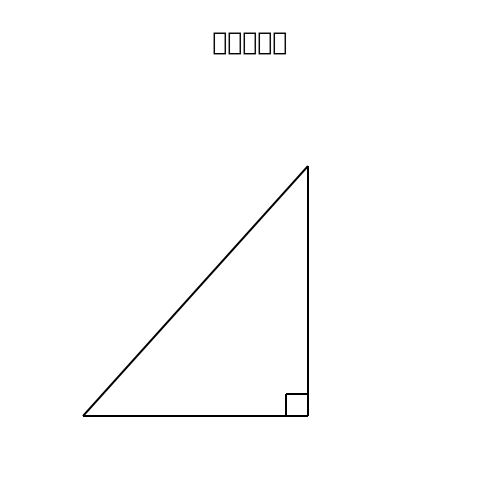

요청한 문장: 가로가 5, 세로가 3인 직사각형의 넓이
추출된 개념: Rectangle
추출된 인자: {'width': 5, 'height': 3}

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="250" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Rectangle 설명

**정의:**
사각형은 네 개의 직선으로 둘러싸인 평면 도형으로, 각 내각이 직각(90도)인 특징을 가지고 있습니다. 즉, 사각형의 네 모서리는 모두 직각을 이루며, 대변이 평행하고 길이가 같은 특성을 갖습니다.

**기본 성질:**
1. **대변의 길이가 같음:** 사각형의 두 쌍의 대변은 길이가 동일합니다. 예를 들어, 가로와 세로가 같은 길이를 가집니다.
2. **대각선이 서로 같음:** 사각형의 두 대각선은 길이가 같습니다. 즉, 사각형을 두 개의 동일한 삼각형으로 나눌 수 있습니다.
3. **내각의 합:** 사각형의 네 내각의 합은 항상 360도입니다.
4. **변의 배열:** 사각형은 여러 가지 형태로 배열될 수 있습니다. 예를 들어, 직사각형은 가로와 세로가 각각 다른 길이를 가질 수 있으며, 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 형태의 사각형입니다.

이러한 성질들로 인해 사각형은 우리 일상생활에서 매우 흔하게 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '2 × (밑변 + 높이)', 'area': '밑변 × 높이'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

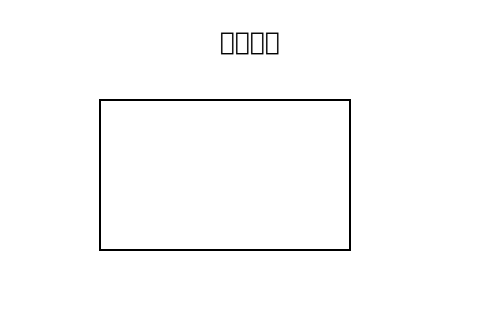

요청한 문장: 한 변의 길이가 2인 정사각형 하나를 그려줘
추출된 개념: Square
추출된 인자: {'length': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="200" height="200" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Square

**정의:**
사각형은 네 개의 변으로 이루어진 평면 도형입니다. 모든 내각이 직각(90도)이며, 반대편의 변들이 길이가 같아서 마주보는 두 변은 평행하고 길이가 동일합니다.

**기본 성질:**
1. **대변의 길이 동일:** 사각형의 마주보는 두 변은 길이가 같습니다. 예를 들어, 정사각형이나 직사각형에서는 모든 대변이 같은 길이를 가집니다.
2. **대각선의 성질:** 사각형의 대각선은 서로를 반으로 나눕니다. 즉, 대각선이 만나는 점에서 대각선을 잇는 선분들은 서로를 절반으로 나눕니다.
3. **변의 합:** 사각형의 네 변의 길이를 모두 더하면, 그 합은 사각형의 둘레를 나타냅니다. 예를 들어, 한 변의 길이가 \(a\)이고 다른 변의 길이가 \(b\)라면, 둘레는 \(a + b + a + b = 2(a + b)\)가 됩니다.
4. **정사각형의 특징:** 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 사각형입니다. 모든 대각선도 길이가 같고 서로를 직각으로 이룹니다.

이러한 성질들로 인해 사각형은 다양한 형태와 크기로 존재하며, 건축, 디자인, 그리고 일상생활에서 자주 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '4 \\times \\mathrm{한 변의 길이}', 'area': '\\m

<IPython.core.display.Math object>

<IPython.core.display.Math object>

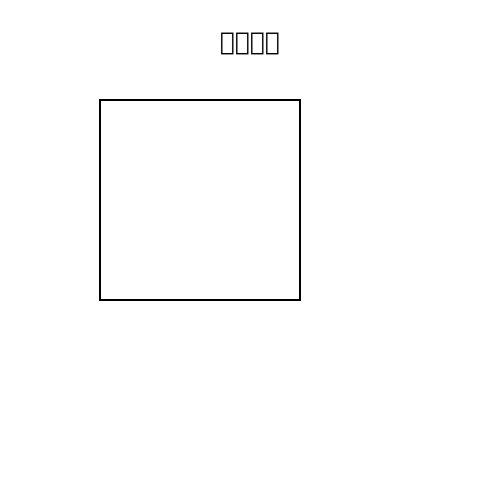

요청한 문장: 곧은선이 뭐야?
추출된 개념: 직선
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="75" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="175" font-size="25" text-anchor="middle">반직선</text>
    <circle cx="125" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="250" x2="500" y2="250" stroke="black" stroke-width="2" />
    <!-- 직선 -->
    <text x="250" y="300" font-size="25" text-anchor="middle">직선</text>
    <circle cx="125" cy="375" r="1" stroke="black"

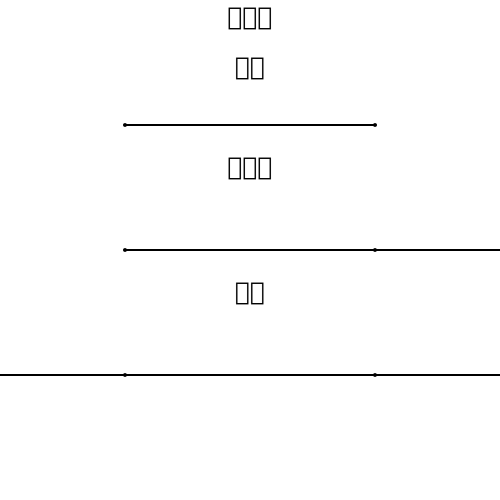

요청한 문장: 대표적인 굽은선을 그려줘
추출된 개념: 곡선
추출된 인자: {'type': '타원', 'description': '타원은 가장 대표적인 굽은선의 한 종류로, 두 초점 사이의 거리의 합이 일정한 점들의 집합으로 정의됩니다.'}

생성된 코드:
 
    <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">굽은선</text>
    <!-- 복잡한 S자 곡선 (두 개의 Cubic Bézier) -->
    <path d="M 100,400
    C 100,100 400,100 400,250
    C 400,400 100,400 100,100"
    stroke="black" fill="none" stroke-width="2"/>
    </svg>
    

생성된 설명:
 ### 곡선에 대한 설명

**정의:**
곡선은 직선이 아닌, 연속적으로 이어지는 점들의 모임으로 이루어진 도형입니다. 쉽게 말해, 직선처럼 일정한 방향으로만 움직이는 것이 아니라, 부드럽게 휘어지거나 굽어지는 형태를 가진 선을 말합니다.

**기본 성질:**
1. **연속성:** 곡선 위의 모든 점들은 부드럽게 이어져 있어, 어떤 작은 구간에서도 끊어지지 않고 이어집니다.
2. **길이:** 곡선의 길이는 그 곡선을 따라 측정한 총 거리입니다. 이 길이는 곡선의 모양에 따라 달라집니다. 예를 들어, 원의 둘레는 반지름에 따라 결정되며, 이는 곡선의 길이를 정확히 계산하는 방법 중 하나입니다.
3. **곡률:** 곡선이 얼마나 빠르게 방향을 바꾸는지를 나타내는 값입니다. 곡률이 크면 곡선이 더 급하게 굽어지고, 작으면 더 부드럽게 굽어집니다. 예를 들어, 원의 경우 모든 점에서 곡률이 일정합니다.
4. **접선:** 곡선 위의 어떤 점에서 그 점을 지나는 가장 가까운 직선을 접선이라고 합니다. 이 접

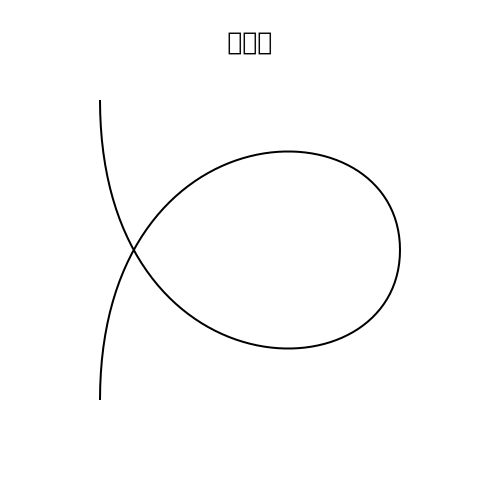

요청한 문장: 중심이 (0,0)이고 반지름이 2인 원을 그려주세요.
추출된 개념: Circle
추출된 인자: {'radius': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="100" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="250" y1="250" x2="350" y2="250" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Circle (원)

#### 정의:
원은 평면 위에서 한 점(중심)으로부터 일정한 거리(반지름)에 있는 모든 점들의 집합을 말합니다. 이 중심점을 기준으로 원 위의 모든 점들은 동일한 거리에 위치해 있습니다.

#### 기본 성질:
1. **둘레와 지름**: 원의 둘레는 지름에 π(약 3.14)를 곱한 값입니다. 즉, 둘레 = 지름 × π 입니다. 반대로 지름은 둘레를 π로 나누면 구할 수 있습니다.
   
2. **면적**: 원의 면적은 반지름의 제곱에 π를 곱한 값입니다. 공식으로 표현하면 면적 = π × 반지름2 입니다.

3. **대칭성**: 원은 중심을 기준으로 완벽하게 대칭입니다. 즉, 중심을 지나는 어떤 직선을 기준으로 원을 접어도 양쪽이 완전히 일치합니다.

4. **원주각과 호의 관계**: 원 위의 두 점을 잇는 호의 중앙각은 그 호에 대응하는 원주각의 두 배입니다. 예를 들어, 호의 중앙각이 θ라면 원주각은 θ/2가 됩니다.

이러한 성질들로 인해 원은 기하학에

<IPython.core.display.Math object>

<IPython.core.display.Math object>

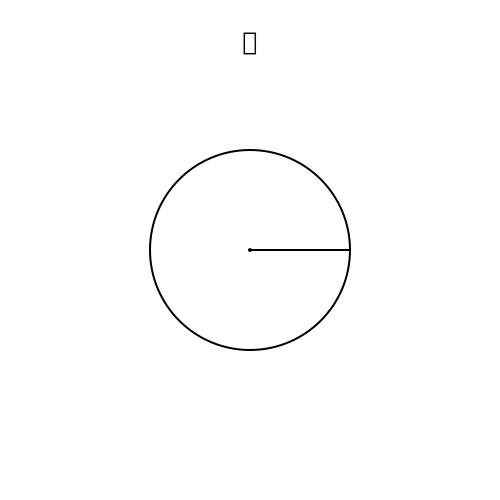

요청한 문장: 37° 각도를 그려줘
추출된 개념: 각도
추출된 인자: {'size': 37}

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
    <!-- 기준선 -->
    <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="333" x2="324.6588775118232" y2="182.54624421198793" stroke="black" stroke-width="2" />
    <!-- 각도 호 -->
    <path d="M 164.93177550236464,302.9092488423976 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>
    </svg>
    

생성된 설명:
 ### 각도에 대한 설명

**정의:**
각도는 두 직선이나 선분이 만나서 생기는 공간의 크기를 측정하는 방법입니다. 우리가 일상에서 자주 접하는 각도는 주로 도로 표지판에서 볼 수 있는 방향 지시나, 그림에서 선들이 만나는 부분을 표현할 때 사용됩니다.

**기본 성질:**
1. **직선의 각도:** 직선은 정확히 180도의 각도를 가집니다. 직선은 두 방향으로 무한히 이어지는 것처럼 보이지만, 실제로는 시작점과 끝점이 있습니다.
   
2. **직각 각도:** 직각은 90도를 의미합니다. 이는 우리가 흔히 사용하는 'L'자 모양의 모서리나 사각형의 모서리에서 볼 수 있습니다. 직각은 두 직선이 서로 수직으로 만나는 경우에 생깁니다.

3. **평행선과 각도:** 평행한 두 직선은 만나지 않기 때문에, 그들 사이의 각도는

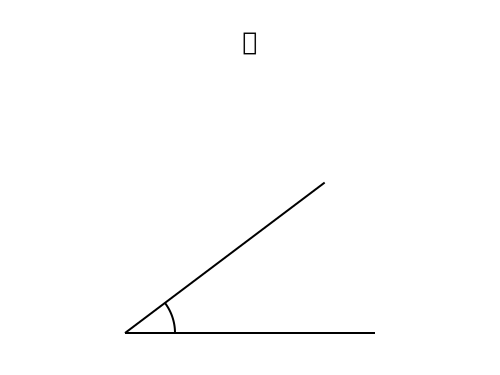

요청한 문장: 직각을 표현해줘
추출된 개념: Right Angle
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
    <!-- 기준선 -->
    <line x1="125" y1="400" x2="458" y2="400" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="400" x2="125" y2="67" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="175" y1="400" x2="175" y2="350" stroke="black" stroke-width="2" />
    <line x1="125" y1="350" x2="175" y2="350" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Angle

**정의:**
Right Angle은 기하학에서 가장 기본적인 각도 중 하나로, 정확히 90도를 이루는 각도를 말합니다. 이 각도는 직각이라고도 불리며, 직선이나 특정 도형의 모서리에서 만나는 두 변이 서로 수직으로 만나는 경우에 나타납니다.

**기본 성질:**
1. **크기:** Right Angle은 항상 정확히 90도입니다. 이는 모든 Right Angle이 동일한 크기를 가짐을 의미합니다.
2. **모양:** Right Angle은 보통 'L' 모양으로 쉽게 인식할 수 있습니다. 이 모양은 직각을 나타내는 데 자주 사용됩니다.
3. **도형과의 관계:** 직각은 사각형, 직사각형, 정사각형 등 다양한 도형의 모서리에서 발견됩니다. 특히, 직사각형이나 정사각형은 네 개

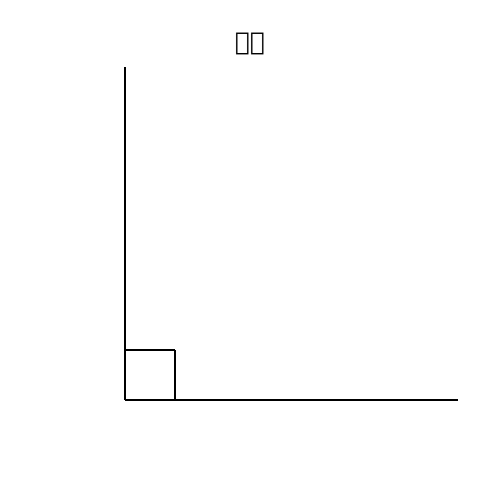

요청한 문장: 밑변이 3이고, 높이가 4인 직각삼각형 하나를 그려줘
추출된 개념: Right Triangle
추출된 인자: {'base': 3, 'height': 4}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <line x1="83" y1="416" x2="308" y2="416" stroke="black" stroke-width="2" />
    <line x1="308" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <line x1="83" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="286" y1="416" x2="286" y2="394" stroke="black" stroke-width="2" />
    <line x1="286" y1="394" x2="308" y2="394" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Triangle

**정의:**
A right triangle is a special type of triangle that has one angle which measures exactly 90 degrees (a right angle). This unique angle distinguishes it from other triangles where all angles are less than 90 degrees.

**기본 성질:**
1. **한 각이 직각:** 가장 중요한 특징은 한 꼭짓점

<IPython.core.display.Math object>

<IPython.core.display.Math object>

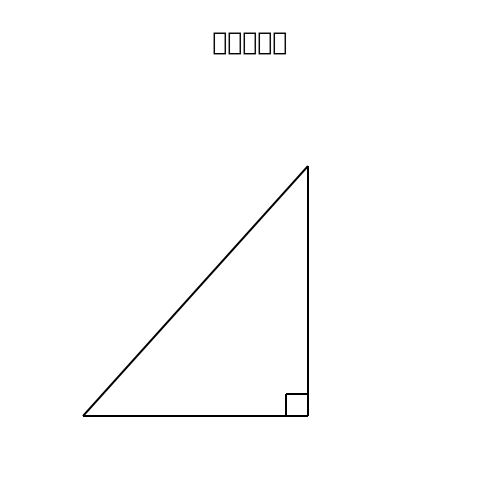

요청한 문장: 가로가 5, 세로가 3인 직사각형의 넓이
추출된 개념: Rectangle
추출된 인자: {'width': 5, 'height': 3}

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="250" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Rectangle 설명

**정의:**
사각형은 네 개의 직선으로 둘러싸인 평면 도형으로, 각 내각이 직각(90도)인 특징을 가지고 있습니다. 즉, 사각형의 네 모서리는 모두 직각을 이루며, 대변이 평행하고 길이가 같은 특성을 갖습니다.

**기본 성질:**
1. **대변의 길이가 같음:** 사각형의 두 쌍의 대변은 길이가 동일합니다. 예를 들어, 가로와 세로가 같은 길이를 가집니다.
2. **대각선이 서로 같음:** 사각형의 두 대각선은 길이가 같습니다. 즉, 사각형을 두 개의 동일한 삼각형으로 나눌 수 있습니다.
3. **내각의 합:** 사각형의 네 내각의 합은 항상 360도입니다.
4. **변의 배열:** 사각형은 여러 가지 형태로 배열될 수 있습니다. 예를 들어, 직사각형은 가로와 세로가 각각 다른 길이를 가질 수 있으며, 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 형태의 사각형입니다.

이러한 성질들로 인해 사각형은 우리 일상생활에서 매우 흔하게 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '2 × (밑변 + 높이)', 'area': '밑변 × 높이'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

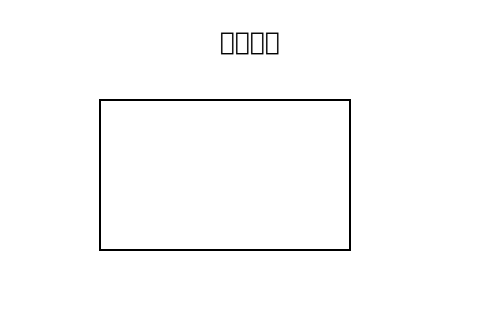

요청한 문장: 한 변의 길이가 2인 정사각형 하나를 그려줘
추출된 개념: Square
추출된 인자: {'length': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="200" height="200" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Square

**정의:**
사각형은 네 개의 변으로 이루어진 평면 도형입니다. 모든 내각이 직각(90도)이며, 반대편의 변들이 길이가 같아서 마주보는 두 변은 평행하고 길이가 동일합니다.

**기본 성질:**
1. **대변의 길이 동일:** 사각형의 마주보는 두 변은 길이가 같습니다. 예를 들어, 정사각형이나 직사각형에서는 모든 대변이 같은 길이를 가집니다.
2. **대각선의 성질:** 사각형의 대각선은 서로를 반으로 나눕니다. 즉, 대각선이 만나는 점에서 대각선을 잇는 선분들은 서로를 절반으로 나눕니다.
3. **변의 합:** 사각형의 네 변의 길이를 모두 더하면, 그 합은 사각형의 둘레를 나타냅니다. 예를 들어, 한 변의 길이가 \(a\)이고 다른 변의 길이가 \(b\)라면, 둘레는 \(a + b + a + b = 2(a + b)\)가 됩니다.
4. **정사각형의 특징:** 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 사각형입니다. 모든 대각선도 길이가 같고 서로를 직각으로 이룹니다.

이러한 성질들로 인해 사각형은 다양한 형태와 크기로 존재하며, 건축, 디자인, 그리고 일상생활에서 자주 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '4 \\times \\mathrm{한 변의 길이}', 'area': '\\m

<IPython.core.display.Math object>

<IPython.core.display.Math object>

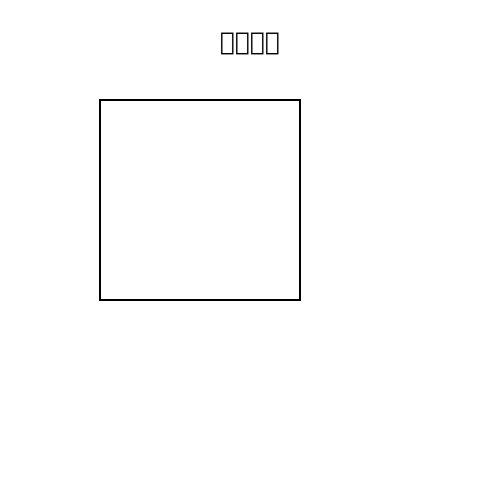

요청한 문장: 곧은선이 뭐야?
추출된 개념: 직선
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="75" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="175" font-size="25" text-anchor="middle">반직선</text>
    <circle cx="125" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="250" x2="500" y2="250" stroke="black" stroke-width="2" />
    <!-- 직선 -->
    <text x="250" y="300" font-size="25" text-anchor="middle">직선</text>
    <circle cx="125" cy="375" r="1" stroke="black"

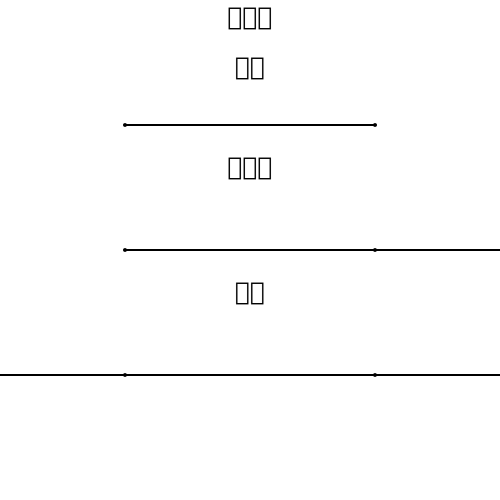

요청한 문장: 대표적인 굽은선을 그려줘
추출된 개념: 곡선
추출된 인자: {'type': '타원', 'description': '타원은 가장 대표적인 굽은선의 한 종류로, 두 초점 사이의 거리의 합이 일정한 점들의 집합으로 정의됩니다.'}

생성된 코드:
 
    <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">굽은선</text>
    <!-- 복잡한 S자 곡선 (두 개의 Cubic Bézier) -->
    <path d="M 100,400
    C 100,100 400,100 400,250
    C 400,400 100,400 100,100"
    stroke="black" fill="none" stroke-width="2"/>
    </svg>
    

생성된 설명:
 ### 곡선에 대한 설명

**정의:**
곡선은 직선이 아닌, 연속적으로 이어지는 점들의 모임으로 이루어진 도형입니다. 쉽게 말해, 직선처럼 일정한 방향으로만 움직이는 것이 아니라, 부드럽게 휘어지거나 굽어지는 형태를 가진 선을 말합니다.

**기본 성질:**
1. **연속성:** 곡선 위의 모든 점들은 부드럽게 이어져 있어, 어떤 작은 구간에서도 끊어지지 않고 이어집니다.
2. **길이:** 곡선의 길이는 그 곡선을 따라 측정한 총 거리입니다. 이 길이는 곡선의 모양에 따라 달라집니다. 예를 들어, 원의 둘레는 반지름에 따라 결정되며, 이는 곡선의 길이를 정확히 계산하는 방법 중 하나입니다.
3. **곡률:** 곡선이 얼마나 빠르게 방향을 바꾸는지를 나타내는 값입니다. 곡률이 크면 곡선이 더 급하게 굽어지고, 작으면 더 부드럽게 굽어집니다. 예를 들어, 원의 경우 모든 점에서 곡률이 일정합니다.
4. **접선:** 곡선 위의 어떤 점에서 그 점을 지나는 가장 가까운 직선을 접선이라고 합니다. 이 접

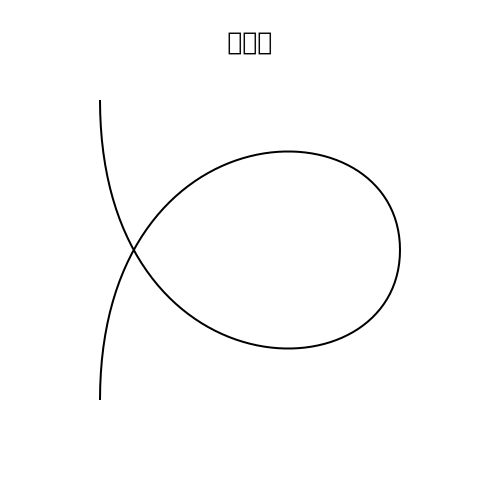

요청한 문장: 중심이 (0,0)이고 반지름이 2인 원을 그려주세요.
추출된 개념: Circle
추출된 인자: {'radius': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="100" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="250" y1="250" x2="350" y2="250" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Circle (원)

#### 정의:
원은 평면 위에서 한 점(중심)으로부터 일정한 거리(반지름)에 있는 모든 점들의 집합을 말합니다. 이 중심점을 기준으로 원 위의 모든 점들은 동일한 거리에 위치해 있습니다.

#### 기본 성질:
1. **둘레와 지름**: 원의 둘레는 지름에 π(약 3.14)를 곱한 값입니다. 즉, 둘레 = 지름 × π 입니다. 반대로 지름은 둘레를 π로 나누면 구할 수 있습니다.
   
2. **면적**: 원의 면적은 반지름의 제곱에 π를 곱한 값입니다. 공식으로 표현하면 면적 = π × 반지름2 입니다.

3. **대칭성**: 원은 중심을 기준으로 완벽하게 대칭입니다. 즉, 중심을 지나는 어떤 직선을 기준으로 원을 접어도 양쪽이 완전히 일치합니다.

4. **원주각과 호의 관계**: 원 위의 두 점을 잇는 호의 중앙각은 그 호에 대응하는 원주각의 두 배입니다. 예를 들어, 호의 중앙각이 θ라면 원주각은 θ/2가 됩니다.

이러한 성질들로 인해 원은 기하학에

<IPython.core.display.Math object>

<IPython.core.display.Math object>

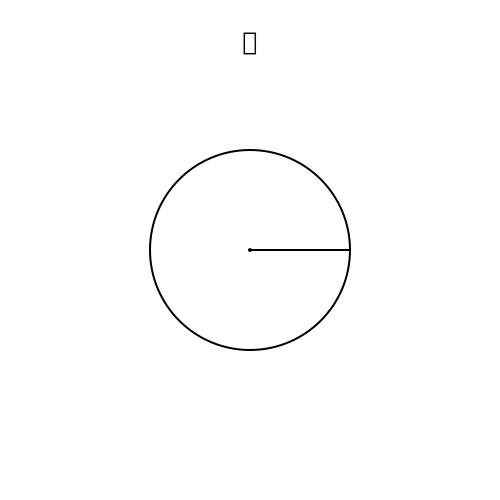

요청한 문장: 37° 각도를 그려줘
추출된 개념: 각도
추출된 인자: {'size': 37}

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
    <!-- 기준선 -->
    <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="333" x2="324.6588775118232" y2="182.54624421198793" stroke="black" stroke-width="2" />
    <!-- 각도 호 -->
    <path d="M 164.93177550236464,302.9092488423976 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>
    </svg>
    

생성된 설명:
 ### 각도에 대한 설명

**정의:**
각도는 두 직선이나 선분이 만나서 생기는 공간의 크기를 측정하는 방법입니다. 우리가 일상에서 자주 접하는 각도는 주로 도로 표지판에서 볼 수 있는 방향 지시나, 그림에서 선들이 만나는 부분을 표현할 때 사용됩니다.

**기본 성질:**
1. **직선의 각도:** 직선은 정확히 180도의 각도를 가집니다. 직선은 두 방향으로 무한히 이어지는 것처럼 보이지만, 실제로는 시작점과 끝점이 있습니다.
   
2. **직각 각도:** 직각은 90도를 의미합니다. 이는 우리가 흔히 사용하는 'L'자 모양의 모서리나 사각형의 모서리에서 볼 수 있습니다. 직각은 두 직선이 서로 수직으로 만나는 경우에 생깁니다.

3. **평행선과 각도:** 평행한 두 직선은 만나지 않기 때문에, 그들 사이의 각도는

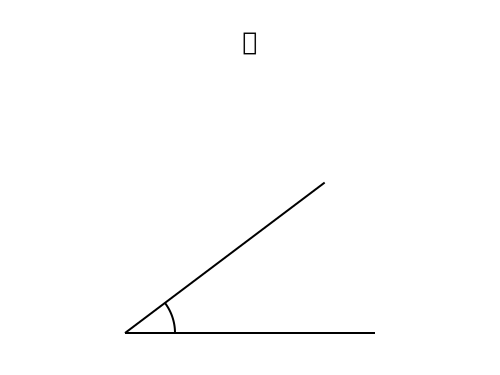

요청한 문장: 직각을 표현해줘
추출된 개념: Right Angle
추출된 인자: {}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
    <!-- 기준선 -->
    <line x1="125" y1="400" x2="458" y2="400" stroke="black" stroke-width="2" />
    <!-- 기울어진 선 -->
    <line x1="125" y1="400" x2="125" y2="67" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="175" y1="400" x2="175" y2="350" stroke="black" stroke-width="2" />
    <line x1="125" y1="350" x2="175" y2="350" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Angle

**정의:**
Right Angle은 기하학에서 가장 기본적인 각도 중 하나로, 정확히 90도를 이루는 각도를 말합니다. 이 각도는 직각이라고도 불리며, 직선이나 특정 도형의 모서리에서 만나는 두 변이 서로 수직으로 만나는 경우에 나타납니다.

**기본 성질:**
1. **크기:** Right Angle은 항상 정확히 90도입니다. 이는 모든 Right Angle이 동일한 크기를 가짐을 의미합니다.
2. **모양:** Right Angle은 보통 'L' 모양으로 쉽게 인식할 수 있습니다. 이 모양은 직각을 나타내는 데 자주 사용됩니다.
3. **도형과의 관계:** 직각은 사각형, 직사각형, 정사각형 등 다양한 도형의 모서리에서 발견됩니다. 특히, 직사각형이나 정사각형은 네 개

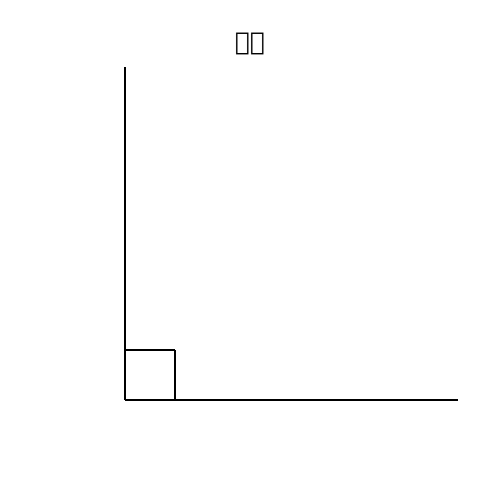

요청한 문장: 밑변이 3이고, 높이가 4인 직각삼각형 하나를 그려줘
추출된 개념: Right Triangle
추출된 인자: {'base': 3, 'height': 4}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <line x1="83" y1="416" x2="308" y2="416" stroke="black" stroke-width="2" />
    <line x1="308" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <line x1="83" y1="416" x2="308" y2="166" stroke="black" stroke-width="2" />
    <!-- 직각 보조선 -->
    <line x1="286" y1="416" x2="286" y2="394" stroke="black" stroke-width="2" />
    <line x1="286" y1="394" x2="308" y2="394" stroke="black" stroke-width="2" />
    </svg>
    

생성된 설명:
 ### Right Triangle

**정의:**
A right triangle is a special type of triangle that has one angle which measures exactly 90 degrees (a right angle). This unique angle distinguishes it from other triangles where all angles are less than 90 degrees.

**기본 성질:**
1. **한 각이 직각:** 가장 중요한 특징은 한 꼭짓점

<IPython.core.display.Math object>

<IPython.core.display.Math object>

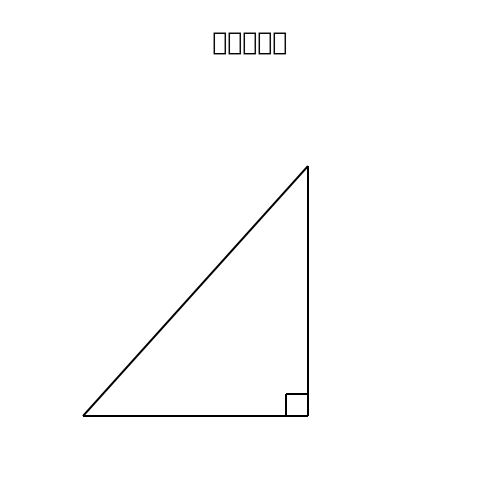

요청한 문장: 가로가 5, 세로가 3인 직사각형의 넓이
추출된 개념: Rectangle
추출된 인자: {'width': 5, 'height': 3}

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="250" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Rectangle 설명

**정의:**
사각형은 네 개의 직선으로 둘러싸인 평면 도형으로, 각 내각이 직각(90도)인 특징을 가지고 있습니다. 즉, 사각형의 네 모서리는 모두 직각을 이루며, 대변이 평행하고 길이가 같은 특성을 갖습니다.

**기본 성질:**
1. **대변의 길이가 같음:** 사각형의 두 쌍의 대변은 길이가 동일합니다. 예를 들어, 가로와 세로가 같은 길이를 가집니다.
2. **대각선이 서로 같음:** 사각형의 두 대각선은 길이가 같습니다. 즉, 사각형을 두 개의 동일한 삼각형으로 나눌 수 있습니다.
3. **내각의 합:** 사각형의 네 내각의 합은 항상 360도입니다.
4. **변의 배열:** 사각형은 여러 가지 형태로 배열될 수 있습니다. 예를 들어, 직사각형은 가로와 세로가 각각 다른 길이를 가질 수 있으며, 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 형태의 사각형입니다.

이러한 성질들로 인해 사각형은 우리 일상생활에서 매우 흔하게 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '2 × (밑변 + 높이)', 'area': '밑변 × 높이'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

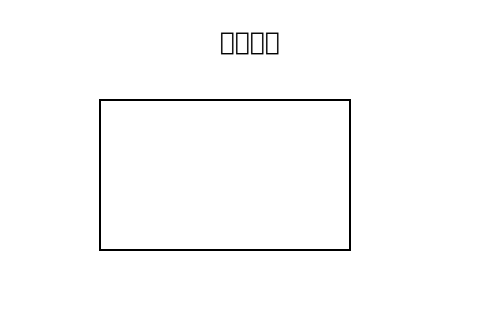

요청한 문장: 한 변의 길이가 2인 정사각형 하나를 그려줘
추출된 개념: Square
추출된 인자: {'length': 2}

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="200" height="200" stroke="black" stroke-width="2" fill="none" />
    </svg>

생성된 설명:
 ### Square

**정의:**
사각형은 네 개의 변으로 이루어진 평면 도형입니다. 모든 내각이 직각(90도)이며, 반대편의 변들이 길이가 같아서 마주보는 두 변은 평행하고 길이가 동일합니다.

**기본 성질:**
1. **대변의 길이 동일:** 사각형의 마주보는 두 변은 길이가 같습니다. 예를 들어, 정사각형이나 직사각형에서는 모든 대변이 같은 길이를 가집니다.
2. **대각선의 성질:** 사각형의 대각선은 서로를 반으로 나눕니다. 즉, 대각선이 만나는 점에서 대각선을 잇는 선분들은 서로를 절반으로 나눕니다.
3. **변의 합:** 사각형의 네 변의 길이를 모두 더하면, 그 합은 사각형의 둘레를 나타냅니다. 예를 들어, 한 변의 길이가 \(a\)이고 다른 변의 길이가 \(b\)라면, 둘레는 \(a + b + a + b = 2(a + b)\)가 됩니다.
4. **정사각형의 특징:** 정사각형은 모든 변의 길이가 같고 모든 내각이 직각인 특별한 사각형입니다. 모든 대각선도 길이가 같고 서로를 직각으로 이룹니다.

이러한 성질들로 인해 사각형은 다양한 형태와 크기로 존재하며, 건축, 디자인, 그리고 일상생활에서 자주 볼 수 있는 도형입니다!

생성된 공식 raw:
 {'perimeter': '4 \\times \\mathrm{한 변의 길이}', 'area': '\\m

<IPython.core.display.Math object>

<IPython.core.display.Math object>

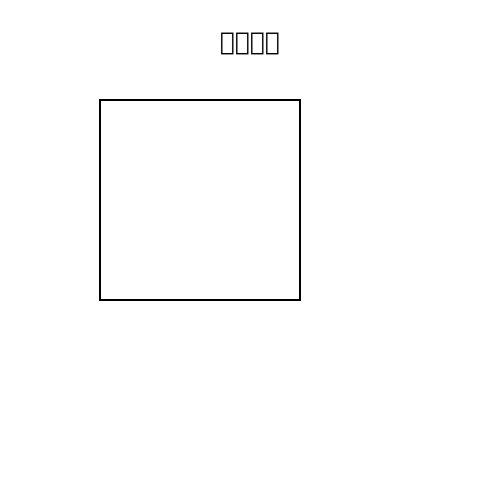

1min 50s ± 1.14 s per loop (mean ± std. dev. of 6 runs, 5 loops each)


In [19]:
%%timeit -n 5 -r 6

input_samples = [
    "곧은선이 뭐야?",
    "대표적인 굽은선을 그려줘",
    "중심이 (0,0)이고 반지름이 2인 원을 그려주세요.",
    "37° 각도를 그려줘",
    "직각을 표현해줘",
    "밑변이 3이고, 높이가 4인 직각삼각형 하나를 그려줘",
    "가로가 5, 세로가 3인 직사각형의 넓이",
    "한 변의 길이가 2인 정사각형 하나를 그려줘",
]

# 그래프 호출
for i, user_input in enumerate(input_samples):
    result = app.invoke({"user_request": user_input})

    # 결과 출력
    print("요청한 문장:", result["user_request"])
    print("추출된 개념:", result["math_concept"])
    print("추출된 인자:", result["parameters"])
    print("\n생성된 코드:\n", result["generated_code"])
    print("\n생성된 설명:\n", result["comments"])
    if "formulas" in result.keys():
        print("\n생성된 공식 raw:\n", result["formulas"])
        show_formulas(result["formulas"]["perimeter"])
        show_formulas(result["formulas"]["area"])
    show_svg(result["generated_code"])
    print("=" * 100)